In [1]:
# Importing data extraction libraries
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning, normalization and Regression libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import MultinomialNB

import math


# TensorFlow Libraries

In [2]:
# Impoorting libraries for deep learning
import tensorflow as tf
from tensorflow import keras

# Ensure notebook doesnt use the entire ram
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.disable_traceback_filtering()

1 Physical GPUs, 1 Logical GPUs


# Creating a Multi Activation Layer Function for Custom Model

In [3]:
# Define custom Layer
class MultiActivationLayer(keras.layers.Layer):
    '''
    Multiple Activation Layer
    
    A neural network layer in which every node has a different activation function applied
    '''
    
    def __init__(self, out_features, activations, **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features
        self.activations = activations
    
    def build(self, input_shape):
        self.w = tf.Variable(tf.random.normal([input_shape[-1], self.out_features]), name='w')
        self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
    
    @tf.function
    def call(self, inputs):
        z = tf.matmul(inputs, self.w) + self.b
        shape = tf.shape(z)[0]
        
        # Apply activation function to ouput features from nodes (columns) separately with different activation functions
        #, reshape to 2-D array and concatenate the results from each node in the same order
        nodes = [tf.reshape(self.activations[i%len(self.activations)](z[:,i]), (shape, 1)) for i in range(self.out_features)]
        z = tf.concat(nodes, 1)
        return z
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "out_features": self.out_features,
            "activations": self.activations,
        })
        return config

# Function to create other models 

In [4]:
# Define custom architecture using the new layer
def create_model(activations, option='multi', num_classes=1, dropout=False, dropout_rate=0.2, task='classification'):
    if task == 'classification' and num_classes < 2:
        raise RuntimeError()
        
    # Creating 5 Uniform models     
    if option == 'uniform':
        # Creating methods if the model does have dropout
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[0], name='layers_dense_2'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_3'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[0], name='layers_dense_4'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[0], name='layers_dense_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])
 
    elif option == 'multi':
        # Method to create a multi activation model
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    MultiActivationLayer(25, activations, name='layers_multi_1'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(20, activations, name='layers_multi_2'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(15, activations, name='layers_multi_3'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(10, activations, name='layers_multi_4'),
                    keras.layers.BatchNormalization(),
                    MultiActivationLayer(5, activations, name='layers_multi_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])

    elif option == 'sequential':
        if len(activations) < 5: raise RuntimeError()
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    keras.layers.Dense(25, activation=activations[0], name='layers_dense_1'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(20, activation=activations[1], name='layers_dense_2'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(15, activation=activations[2], name='layers_dense_3'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(10, activation=activations[3], name='layers_dense_4'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(5, activation=activations[4], name='layers_dense_5'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])

    else:
        raise RuntimeError()

In [5]:
# Define custom architecture using the new layer
def create_model_paper(activations, option='multi', num_classes=1, dropout=False, dropout_rate=0.3, task='classification'):
    if task == 'classification' and num_classes < 2:
        raise RuntimeError()
        
    # Creating 5 Uniform models     
    if option == 'uniform':
        # Creating methods if the model does have dropout
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_3'),

                    keras.layers.Dense(1, activation=activations[0], name='layers_dense_4'),
                    
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])
 
    elif option == 'multi':
        # Method to create a multi activation model
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_3'),

                    keras.layers.Dense(1, activation=activations[0], name='layers_dense_4'),
                    
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])
 

    elif option == 'sequential':
        if len(activations) < 5: raise RuntimeError()
        if not dropout:
            if task == 'classification':
                return keras.models.Sequential([
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_1'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(15, activation=activations[0], name='layers_dense_2'),
                    keras.layers.Dropout(dropout_rate),
                    
                    keras.layers.Dense(30, activation=activations[0], name='layers_dense_3'),

                    keras.layers.Dense(1, activation=activations[0], name='layers_dense_4'),
                    
                    keras.layers.Dense(num_classes, activation='softmax', name='layers_dense')
                ])
 

    else:
        raise RuntimeError()

In [6]:
# Define testing function for generating and running tests
def test(X, y, num_classes=None, X_test=None, y_test=None, task='classification', epochs=100, batch_size=32, task_name=''):
    
    Paper_MANN, Paper_MANN_Alt1, Paper_MANN_Alt2, Paper_MANN_Alt3 = None, None, None, None
    MANN, MANN_Alt1, MANN_Alt2, MANN_Alt3 = None, None, None, None
    UANN1, UANN2, UANN3, UANN4, UANN5 = None, None, None, None, None
    SANN =  None
    
    if X_test is None or y_test is None:
        # Split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    else:
        X_train, y_train = X, y

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_dataset = train_dataset.shuffle(1000).batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
        
    
    if task == 'classification':
        if num_classes is None:
            raise RuntimeError()
            
        # Create our model
        MANN = create_model(activations=[tf.nn.sigmoid, 
                                         tf.nn.tanh, 
                                         tf.nn.leaky_relu, 
                                         tf.nn.elu, 
                                         tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        
        MANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                         loss=keras.losses.CategoricalCrossentropy(),
                         metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        MANN_Alt1 = create_model(activations=[tf.nn.tanh, 
                                              tf.nn.sigmoid, 
                                              tf.nn.leaky_relu, 
                                              tf.nn.elu, 
                                              tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        
        MANN_Alt1.compile(optimizer=keras.optimizers.legacy.Nadam(),
                         loss=keras.losses.CategoricalCrossentropy(),
                         metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        MANN_Alt2 = create_model(activations=[tf.nn.tanh,
                                              tf.nn.leaky_relu,
                                              tf.nn.sigmoid,
                                              tf.nn.elu,
                                              tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        MANN_Alt2.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        
        MANN_Alt3 = create_model(activations=[tf.nn.tanh, 
                                              tf.nn.leaky_relu, 
                                              tf.nn.elu, 
                                              tf.nn.sigmoid, 
                                              tf.nn.swish], 
                                 dropout=False, 
                                 num_classes=num_classes, 
                                 task=task)
        
        MANN_Alt3.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        # Paper Proposed Models
        
        # Create our model
        Paper_MANN = create_model_paper(activations=[tf.nn.sigmoid,
                                         tf.nn.leaky_relu, 
                                         tf.nn.elu, 
                                         tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        
        Paper_MANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        Paper_MANN_Alt1 = create_model_paper(activations=[tf.nn.leaky_relu, 
                                              tf.nn.sigmoid, 
                                              tf.nn.elu, 
                                              tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        Paper_MANN_Alt1.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        Paper_MANN_Alt2 = create_model_paper(activations=[tf.nn.leaky_relu,
                                              tf.nn.elu,
                                              tf.nn.sigmoid,
                                              tf.nn.swish], dropout=False, num_classes=num_classes, task=task)
        Paper_MANN_Alt2.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        Paper_MANN_Alt3 = create_model_paper(activations=[tf.nn.leaky_relu, 
                                              tf.nn.elu, 
                                              tf.nn.swish,
                                              tf.nn.sigmoid],
                                 dropout=False, 
                                 num_classes=num_classes, 
                                 task=task)
        
        Paper_MANN_Alt3.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        
        
        # Create uniform model for each activation function
        UANN1 = create_model(activations=[tf.nn.sigmoid], option='uniform', num_classes=num_classes, task=task)
        UANN1.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN2 = create_model(activations=[tf.nn.tanh], option='uniform', num_classes=num_classes, task=task)
        UANN2.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN3 = create_model(activations=[tf.nn.leaky_relu], option='uniform', num_classes=num_classes, task=task)
        UANN3.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN4 = create_model(activations=[tf.nn.elu], option='uniform', num_classes=num_classes, task=task)
        UANN4.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        UANN5 = create_model(activations=[tf.nn.swish], option='uniform', num_classes=num_classes, task=task)
        UANN5.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])
        
        # Create sequential activation network
        SANN = create_model(activations=[tf.nn.swish, tf.nn.elu, tf.nn.leaky_relu, tf.nn.tanh, tf.nn.sigmoid], option='sequential', dropout=False, num_classes=num_classes, task=task)
        SANN.compile(optimizer=keras.optimizers.legacy.Nadam(),
                     loss=keras.losses.CategoricalCrossentropy(),
                     metrics=[keras.metrics.CategoricalAccuracy()])

        
    else:
        raise RuntimeError()
    
    # Fit the data to the models for a set number of epochs
    print("Training Multi Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/MANN.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    MANN_hist = MANN.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    MANN.save(filepath=f'./Models/{task_name}/MANN', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    
    # Alternate MANN Model    
    path=f'./Models/Checkpoints/{task_name}/MANN_Alt1.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    MANN_Alt1_hist = MANN_Alt1.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    MANN_Alt1.save(filepath=f'./Models/{task_name}/MANN_Alt1', overwrite=True, save_format="keras")
    print("Training Complete")
    

    # Alternate MANN Model 
    path=f'./Models/Checkpoints/{task_name}/MANN_Alt2.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    MANN_Alt2_hist = MANN_Alt2.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    MANN_Alt2.save(filepath=f'./Models/{task_name}/MANN_Alt2', overwrite=True, save_format="keras")
    print("Training Compelte")
    
    
    
    
    
    
    path=f'./Models/Checkpoints/{task_name}/MANN_Alt3.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    MANN_Alt3_hist = MANN_Alt3.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    MANN_Alt3.save(filepath=f'./Models/{task_name}/MANN_Alt3', overwrite=True, save_format="keras")
    
    
    # Training Paper proposed model
    print("Training Multi Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/Paper_MANN.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    Paper_MANN_hist = Paper_MANN.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    Paper_MANN.save(filepath=f'./Models/{task_name}/Paper_MANN', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    print("\n\n************Training Multi Activation Neural Network...************")
    path=f'./Models/Checkpoints/{task_name}/Paper_MANN_Alt1.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    Paper_MANN_Alt1_hist = Paper_MANN_Alt1.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    Paper_MANN_Alt1.save(filepath=f'./Models/{task_name}/Paper_MANN_Alt1', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    print("\n\n************Training Multi Activation Neural Network...************")
    path=f'./Models/Checkpoints/{task_name}/Paper_MANN_Alt2.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    Paper_MANN_Alt2_hist = Paper_MANN_Alt2.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    Paper_MANN_Alt2.save(filepath=f'./Models/{task_name}/Paper_MANN_Alt2', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    print("\n\n************Training Multi Activation Neural Network************")
    path=f'./Models/Checkpoints/{task_name}/Paper_MANN_Alt3.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                filepath=path,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only= True
                                                               )
    Paper_MANN_Alt3_hist = Paper_MANN_Alt3.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    Paper_MANN_Alt3.save(filepath=f'./Models/{task_name}/Paper_MANN_Alt3', overwrite=True, save_format="keras")
    print('Training Complete')
    
    
    
    
    print("\n\n************Training Sigmoid Uniform Activation Neural Network************")
    path=f'./Models/Checkpoints/{task_name}/Sigmoid.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN1_hist = UANN1.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN1.save(filepath=f'./Models/{task_name}/UniformSigmoid', overwrite=True, save_format="keras")
    print('Training Complete')

    
    print("\n\n************Training Tanh Uniform Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/Tanh.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN2_hist = UANN2.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN2.save(filepath=f'./Models/{task_name}/UniformTanh', overwrite=True, save_format="keras")
    print('Training Complete')

    
    print("\n\n************Training Leaky ReLU Uniform Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/LeakyReLU.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN3_hist = UANN3.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN3.save(filepath=f'./Models/{task_name}/UniformLeakyReLU', overwrite=True, save_format="keras")
    print('Training Complete')
    

    print("\n\n************Training ELU Uniform Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/ELU.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN4_hist = UANN4.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN4.save(filepath=f'./Models/{task_name}/UniformELU', overwrite=True, save_format="keras")
    print('Training Complete')

    print("\n\n************Training Swish Uniform Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/Swish.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    UANN5_hist = UANN5.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    UANN5.save(filepath=f'./Models/{task_name}/UniformSwish', overwrite=True, save_format="keras")
    print('Training Complete')

    print("\n\n************Training Sequential Activation Neural Network...")
    path=f'./Models/Checkpoints/{task_name}/Sequential.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)
    SANN_hist = SANN.fit(x=train_dataset, batch_size=batch_size, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint_callback])
    SANN.save(filepath=f'./Models/{task_name}/Sequential', overwrite=True, save_format="keras")
    print('Training Complete')

    # Create dictionaries to return for models and scores
    models = {
        'MANN': MANN,
        'MANN_Alt1': MANN_Alt1,
        'MANN_Alt2': MANN_Alt2,
        'MANN_Alt3': MANN_Alt3,
        'Paper_MANN': Paper_MANN,
        'Paper_MANN_Alt1': Paper_MANN_Alt1,
        'Paper_MANN_Alt2': Paper_MANN_Alt2,
        'Paper_MANN_Alt3': Paper_MANN_Alt3,
        'Sigmoid': UANN1,
        'Tanh': UANN2,
        'LeakyReLU': UANN3,
        'ELU': UANN4,
        'Swish': UANN5,
        'Sequential': SANN
    }
    
    histories = {
        'MANN': MANN_hist,
        'MANN_Alt1': MANN_Alt1_hist,
        'MANN_Alt2': MANN_Alt2_hist,
        'MANN_Alt3': MANN_Alt3_hist,
        'Paper_MANN': Paper_MANN_hist,
        'Paper_MANN_Alt1': Paper_MANN_Alt1_hist,
        'Paper_MANN_Alt2': Paper_MANN_Alt2_hist,
        'Paper_MANN_Alt3': Paper_MANN_Alt3_hist,
        'Sigmoid': UANN1_hist,
        'Tanh': UANN2_hist,
        'LeakyReLU': UANN3_hist,
        'ELU': UANN4_hist,
        'Swish': UANN5_hist,
        'Sequential': SANN_hist
    }

    return models, histories

# Pulling Heart Faliure data from the csv

In [7]:
# Load the data and split into testing and training for processing
HeartFailureData = pd.read_csv('./Datasets/heart.csv')

HeartFailureData.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

## Assigning features and targets from dataset

In [8]:
features = HeartFailureData.drop('HeartDisease', axis=1)
#npFeatures = np.array(features)

target = HeartFailureData['HeartDisease']
#npTarget = np.array(target)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

## Normalizing dataset

In [9]:
# Process and normalize the data
one_hot = OneHotEncoder(sparse_output=False)

# One-Hot encode categorical columns
X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=one_hot.get_feature_names_out()))
X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=one_hot.get_feature_names_out()))


# Drop the transformed columns and unneeded columns
X_train.drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis = 1, inplace=True)
X_test.drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1, inplace=True)


# Normalize numerical columns
scaler = StandardScaler()
X_train[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]= scaler.fit_transform(X_train[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']])
X_test[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']] = scaler.transform(X_test[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']])

C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_44820\3618434260.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=one_hot.get_feature_names_out()))
C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_44820\3618434260.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']]), columns=one_hot.get_feature_names_out()))


In [10]:
# One-Hot encode target labels
y_train = pd.DataFrame(data=one_hot.fit_transform(y_train.to_numpy().reshape(-1,1)), columns=one_hot.categories_)
y_test = pd.DataFrame(data=one_hot.transform(y_test.to_numpy().reshape(-1,1)), columns=one_hot.categories_)

In [11]:
# Create and fit all neural networks for evaluations

models, histories = test(X_train.to_numpy(), y_train.to_numpy(), X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), num_classes=len(one_hot.categories_[0]), task='classification', epochs=500, batch_size=128, task_name='HeartFailure')

Training Multi Activation Neural Network...
Epoch 1/500
6/6 [==============================] - 4s 159ms/step - loss: 0.7333 - categorical_accuracy: 0.5640 - val_loss: 6.0098 - val_categorical_accuracy: 0.5707
Epoch 2/500
6/6 [==============================] - 0s 68ms/step - loss: 0.6780 - categorical_accuracy: 0.6131 - val_loss: 3.8909 - val_categorical_accuracy: 0.5707
Epoch 3/500
6/6 [==============================] - 0s 82ms/step - loss: 0.6488 - categorical_accuracy: 0.6322 - val_loss: 2.7642 - val_categorical_accuracy: 0.5761
Epoch 4/500
6/6 [==============================] - 1s 82ms/step - loss: 0.6159 - categorical_accuracy: 0.6662 - val_loss: 2.1233 - val_categorical_accuracy: 0.5761
Epoch 5/500
6/6 [==============================] - 0s 68ms/step - loss: 0.5913 - categorical_accuracy: 0.6907 - val_loss: 1.7195 - val_categorical_accuracy: 0.5978
Epoch 6/500
6/6 [==============================] - 0s 71ms/step - loss: 0.5801 - categorical_accuracy: 0.7098 - val_loss: 1.4668 - val_

6/6 [==============================] - 0s 79ms/step - loss: 0.4206 - categorical_accuracy: 0.8093 - val_loss: 0.6243 - val_categorical_accuracy: 0.6848
Epoch 51/500
6/6 [==============================] - 0s 74ms/step - loss: 0.4078 - categorical_accuracy: 0.8161 - val_loss: 0.6230 - val_categorical_accuracy: 0.6902
Epoch 52/500
6/6 [==============================] - 0s 72ms/step - loss: 0.4139 - categorical_accuracy: 0.8106 - val_loss: 0.6218 - val_categorical_accuracy: 0.6902
Epoch 53/500
6/6 [==============================] - 0s 63ms/step - loss: 0.4184 - categorical_accuracy: 0.8038 - val_loss: 0.6195 - val_categorical_accuracy: 0.6902
Epoch 54/500
6/6 [==============================] - 0s 54ms/step - loss: 0.4042 - categorical_accuracy: 0.8161 - val_loss: 0.6208 - val_categorical_accuracy: 0.7011
Epoch 55/500
6/6 [==============================] - 0s 58ms/step - loss: 0.4062 - categorical_accuracy: 0.8202 - val_loss: 0.6202 - val_categorical_accuracy: 0.7011
Epoch 56/500
6/6 [=====

Epoch 100/500
6/6 [==============================] - 0s 49ms/step - loss: 0.3642 - categorical_accuracy: 0.8283 - val_loss: 0.6108 - val_categorical_accuracy: 0.7120
Epoch 101/500
6/6 [==============================] - 0s 56ms/step - loss: 0.3557 - categorical_accuracy: 0.8311 - val_loss: 0.6153 - val_categorical_accuracy: 0.7120
Epoch 102/500
6/6 [==============================] - 0s 49ms/step - loss: 0.3837 - categorical_accuracy: 0.8188 - val_loss: 0.6139 - val_categorical_accuracy: 0.7065
Epoch 103/500
6/6 [==============================] - 0s 51ms/step - loss: 0.3798 - categorical_accuracy: 0.8147 - val_loss: 0.6180 - val_categorical_accuracy: 0.7120
Epoch 104/500
6/6 [==============================] - 0s 49ms/step - loss: 0.3609 - categorical_accuracy: 0.8297 - val_loss: 0.6160 - val_categorical_accuracy: 0.7120
Epoch 105/500
6/6 [==============================] - 0s 52ms/step - loss: 0.3561 - categorical_accuracy: 0.8324 - val_loss: 0.6154 - val_categorical_accuracy: 0.7228
Epoc

6/6 [==============================] - 0s 53ms/step - loss: 0.3228 - categorical_accuracy: 0.8501 - val_loss: 0.6244 - val_categorical_accuracy: 0.7446
Epoch 150/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3107 - categorical_accuracy: 0.8515 - val_loss: 0.6293 - val_categorical_accuracy: 0.7391
Epoch 151/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3195 - categorical_accuracy: 0.8569 - val_loss: 0.6350 - val_categorical_accuracy: 0.7500
Epoch 152/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3028 - categorical_accuracy: 0.8678 - val_loss: 0.6362 - val_categorical_accuracy: 0.7554
Epoch 153/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3073 - categorical_accuracy: 0.8569 - val_loss: 0.6347 - val_categorical_accuracy: 0.7500
Epoch 154/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3289 - categorical_accuracy: 0.8542 - val_loss: 0.6311 - val_categorical_accuracy: 0.7446
Epoch 155/500
6/6 

6/6 [==============================] - 0s 54ms/step - loss: 0.2801 - categorical_accuracy: 0.8801 - val_loss: 0.6520 - val_categorical_accuracy: 0.7554
Epoch 199/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2797 - categorical_accuracy: 0.8787 - val_loss: 0.6509 - val_categorical_accuracy: 0.7554
Epoch 200/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2805 - categorical_accuracy: 0.8856 - val_loss: 0.6517 - val_categorical_accuracy: 0.7554
Epoch 201/500
6/6 [==============================] - 0s 55ms/step - loss: 0.3097 - categorical_accuracy: 0.8624 - val_loss: 0.6639 - val_categorical_accuracy: 0.7500
Epoch 202/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2723 - categorical_accuracy: 0.8828 - val_loss: 0.6715 - val_categorical_accuracy: 0.7500
Epoch 203/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2942 - categorical_accuracy: 0.8760 - val_loss: 0.6685 - val_categorical_accuracy: 0.7500
Epoch 204/500
6/6 

6/6 [==============================] - 0s 52ms/step - loss: 0.2549 - categorical_accuracy: 0.8896 - val_loss: 0.7096 - val_categorical_accuracy: 0.7391
Epoch 248/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2489 - categorical_accuracy: 0.8883 - val_loss: 0.7081 - val_categorical_accuracy: 0.7391
Epoch 249/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2619 - categorical_accuracy: 0.8883 - val_loss: 0.7078 - val_categorical_accuracy: 0.7337
Epoch 250/500
6/6 [==============================] - 0s 55ms/step - loss: 0.2673 - categorical_accuracy: 0.8815 - val_loss: 0.7126 - val_categorical_accuracy: 0.7446
Epoch 251/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2863 - categorical_accuracy: 0.8692 - val_loss: 0.7008 - val_categorical_accuracy: 0.7500
Epoch 252/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2491 - categorical_accuracy: 0.8924 - val_loss: 0.6977 - val_categorical_accuracy: 0.7500
Epoch 253/500
6/6 

6/6 [==============================] - 0s 54ms/step - loss: 0.2516 - categorical_accuracy: 0.8978 - val_loss: 0.7102 - val_categorical_accuracy: 0.7391
Epoch 297/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2336 - categorical_accuracy: 0.9019 - val_loss: 0.7021 - val_categorical_accuracy: 0.7554
Epoch 298/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2545 - categorical_accuracy: 0.8856 - val_loss: 0.7042 - val_categorical_accuracy: 0.7609
Epoch 299/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2506 - categorical_accuracy: 0.8896 - val_loss: 0.7045 - val_categorical_accuracy: 0.7609
Epoch 300/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2626 - categorical_accuracy: 0.9019 - val_loss: 0.7147 - val_categorical_accuracy: 0.7554
Epoch 301/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2512 - categorical_accuracy: 0.8937 - val_loss: 0.7160 - val_categorical_accuracy: 0.7554
Epoch 302/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2387 - categorical_accuracy: 0.8951 - val_loss: 0.7299 - val_categorical_accuracy: 0.7446
Epoch 346/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2026 - categorical_accuracy: 0.9101 - val_loss: 0.7296 - val_categorical_accuracy: 0.7446
Epoch 347/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2455 - categorical_accuracy: 0.8869 - val_loss: 0.7288 - val_categorical_accuracy: 0.7554
Epoch 348/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2250 - categorical_accuracy: 0.8965 - val_loss: 0.7290 - val_categorical_accuracy: 0.7663
Epoch 349/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2287 - categorical_accuracy: 0.8992 - val_loss: 0.7378 - val_categorical_accuracy: 0.7609
Epoch 350/500
6/6 [==============================] - 0s 56ms/step - loss: 0.2179 - categorical_accuracy: 0.9019 - val_loss: 0.7390 - val_categorical_accuracy: 0.7554
Epoch 351/500
6/6 

6/6 [==============================] - 0s 52ms/step - loss: 0.2144 - categorical_accuracy: 0.9074 - val_loss: 0.7505 - val_categorical_accuracy: 0.7609
Epoch 395/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2445 - categorical_accuracy: 0.8924 - val_loss: 0.7553 - val_categorical_accuracy: 0.7717
Epoch 396/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2006 - categorical_accuracy: 0.9142 - val_loss: 0.7638 - val_categorical_accuracy: 0.7609
Epoch 397/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2295 - categorical_accuracy: 0.9046 - val_loss: 0.7594 - val_categorical_accuracy: 0.7554
Epoch 398/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2187 - categorical_accuracy: 0.9033 - val_loss: 0.7589 - val_categorical_accuracy: 0.7446
Epoch 399/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2313 - categorical_accuracy: 0.9128 - val_loss: 0.7578 - val_categorical_accuracy: 0.7446
Epoch 400/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2025 - categorical_accuracy: 0.9114 - val_loss: 0.8217 - val_categorical_accuracy: 0.7391
Epoch 444/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2482 - categorical_accuracy: 0.9019 - val_loss: 0.8239 - val_categorical_accuracy: 0.7283
Epoch 445/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2015 - categorical_accuracy: 0.9196 - val_loss: 0.8286 - val_categorical_accuracy: 0.7283
Epoch 446/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2115 - categorical_accuracy: 0.9087 - val_loss: 0.8303 - val_categorical_accuracy: 0.7337
Epoch 447/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1981 - categorical_accuracy: 0.9114 - val_loss: 0.8346 - val_categorical_accuracy: 0.7337
Epoch 448/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2356 - categorical_accuracy: 0.8951 - val_loss: 0.8307 - val_categorical_accuracy: 0.7337
Epoch 449/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2270 - categorical_accuracy: 0.9046 - val_loss: 0.8429 - val_categorical_accuracy: 0.7283
Epoch 493/500
6/6 [==============================] - 0s 51ms/step - loss: 0.1857 - categorical_accuracy: 0.9210 - val_loss: 0.8453 - val_categorical_accuracy: 0.7446
Epoch 494/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1906 - categorical_accuracy: 0.9183 - val_loss: 0.8451 - val_categorical_accuracy: 0.7446
Epoch 495/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1867 - categorical_accuracy: 0.9210 - val_loss: 0.8378 - val_categorical_accuracy: 0.7391
Epoch 496/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1849 - categorical_accuracy: 0.9237 - val_loss: 0.8415 - val_categorical_accuracy: 0.7337
Epoch 497/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2243 - categorical_accuracy: 0.8992 - val_loss: 0.8435 - val_categorical_accuracy: 0.7337
Epoch 498/500
6/6 

6/6 [==============================] - 0s 69ms/step - loss: 0.4472 - categorical_accuracy: 0.8025 - val_loss: 0.5406 - val_categorical_accuracy: 0.7500
Epoch 42/500
6/6 [==============================] - 0s 68ms/step - loss: 0.4685 - categorical_accuracy: 0.7875 - val_loss: 0.5397 - val_categorical_accuracy: 0.7500
Epoch 43/500
6/6 [==============================] - 0s 54ms/step - loss: 0.4432 - categorical_accuracy: 0.8093 - val_loss: 0.5402 - val_categorical_accuracy: 0.7446
Epoch 44/500
6/6 [==============================] - 0s 54ms/step - loss: 0.4528 - categorical_accuracy: 0.7984 - val_loss: 0.5400 - val_categorical_accuracy: 0.7554
Epoch 45/500
6/6 [==============================] - 0s 54ms/step - loss: 0.4434 - categorical_accuracy: 0.8079 - val_loss: 0.5407 - val_categorical_accuracy: 0.7500
Epoch 46/500
6/6 [==============================] - 0s 66ms/step - loss: 0.4406 - categorical_accuracy: 0.8079 - val_loss: 0.5382 - val_categorical_accuracy: 0.7500
Epoch 47/500
6/6 [=====

Epoch 91/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3798 - categorical_accuracy: 0.8488 - val_loss: 0.5731 - val_categorical_accuracy: 0.7120
Epoch 92/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3798 - categorical_accuracy: 0.8460 - val_loss: 0.5749 - val_categorical_accuracy: 0.7120
Epoch 93/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3892 - categorical_accuracy: 0.8351 - val_loss: 0.5767 - val_categorical_accuracy: 0.7174
Epoch 94/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3872 - categorical_accuracy: 0.8447 - val_loss: 0.5777 - val_categorical_accuracy: 0.7120
Epoch 95/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3813 - categorical_accuracy: 0.8392 - val_loss: 0.5798 - val_categorical_accuracy: 0.7120
Epoch 96/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3628 - categorical_accuracy: 0.8597 - val_loss: 0.5798 - val_categorical_accuracy: 0.7120
Epoch 97/5

6/6 [==============================] - 0s 55ms/step - loss: 0.3070 - categorical_accuracy: 0.8787 - val_loss: 0.6730 - val_categorical_accuracy: 0.6739
Epoch 141/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3251 - categorical_accuracy: 0.8638 - val_loss: 0.6736 - val_categorical_accuracy: 0.6848
Epoch 142/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3054 - categorical_accuracy: 0.8869 - val_loss: 0.6763 - val_categorical_accuracy: 0.6848
Epoch 143/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3169 - categorical_accuracy: 0.8706 - val_loss: 0.6787 - val_categorical_accuracy: 0.6902
Epoch 144/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3180 - categorical_accuracy: 0.8665 - val_loss: 0.6786 - val_categorical_accuracy: 0.6793
Epoch 145/500
6/6 [==============================] - 0s 52ms/step - loss: 0.3096 - categorical_accuracy: 0.8842 - val_loss: 0.6802 - val_categorical_accuracy: 0.6739
Epoch 146/500
6/6 

6/6 [==============================] - 0s 52ms/step - loss: 0.2761 - categorical_accuracy: 0.8937 - val_loss: 0.7575 - val_categorical_accuracy: 0.6685
Epoch 190/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2802 - categorical_accuracy: 0.8883 - val_loss: 0.7636 - val_categorical_accuracy: 0.6685
Epoch 191/500
6/6 [==============================] - 0s 51ms/step - loss: 0.2830 - categorical_accuracy: 0.8924 - val_loss: 0.7608 - val_categorical_accuracy: 0.6576
Epoch 192/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2835 - categorical_accuracy: 0.8828 - val_loss: 0.7674 - val_categorical_accuracy: 0.6576
Epoch 193/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2910 - categorical_accuracy: 0.8856 - val_loss: 0.7702 - val_categorical_accuracy: 0.6685
Epoch 194/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2638 - categorical_accuracy: 0.8883 - val_loss: 0.7705 - val_categorical_accuracy: 0.6630
Epoch 195/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2571 - categorical_accuracy: 0.8992 - val_loss: 0.8420 - val_categorical_accuracy: 0.6630
Epoch 239/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2516 - categorical_accuracy: 0.8978 - val_loss: 0.8449 - val_categorical_accuracy: 0.6630
Epoch 240/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2606 - categorical_accuracy: 0.9019 - val_loss: 0.8460 - val_categorical_accuracy: 0.6739
Epoch 241/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2519 - categorical_accuracy: 0.8951 - val_loss: 0.8435 - val_categorical_accuracy: 0.6793
Epoch 242/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2706 - categorical_accuracy: 0.8801 - val_loss: 0.8479 - val_categorical_accuracy: 0.6685
Epoch 243/500
6/6 [==============================] - 0s 55ms/step - loss: 0.2506 - categorical_accuracy: 0.9019 - val_loss: 0.8459 - val_categorical_accuracy: 0.6685
Epoch 244/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2499 - categorical_accuracy: 0.8937 - val_loss: 0.9437 - val_categorical_accuracy: 0.6630
Epoch 288/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2486 - categorical_accuracy: 0.8978 - val_loss: 0.9474 - val_categorical_accuracy: 0.6522
Epoch 289/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2265 - categorical_accuracy: 0.9155 - val_loss: 0.9534 - val_categorical_accuracy: 0.6522
Epoch 290/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2292 - categorical_accuracy: 0.9142 - val_loss: 0.9561 - val_categorical_accuracy: 0.6522
Epoch 291/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2279 - categorical_accuracy: 0.9019 - val_loss: 0.9614 - val_categorical_accuracy: 0.6413
Epoch 292/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2448 - categorical_accuracy: 0.9114 - val_loss: 0.9707 - val_categorical_accuracy: 0.6359
Epoch 293/500
6/6 

6/6 [==============================] - 0s 75ms/step - loss: 0.2493 - categorical_accuracy: 0.9019 - val_loss: 0.9827 - val_categorical_accuracy: 0.6304
Epoch 337/500
6/6 [==============================] - 0s 72ms/step - loss: 0.2038 - categorical_accuracy: 0.9169 - val_loss: 0.9803 - val_categorical_accuracy: 0.6359
Epoch 338/500
6/6 [==============================] - 0s 70ms/step - loss: 0.2126 - categorical_accuracy: 0.9183 - val_loss: 0.9804 - val_categorical_accuracy: 0.6467
Epoch 339/500
6/6 [==============================] - 0s 72ms/step - loss: 0.1892 - categorical_accuracy: 0.9305 - val_loss: 0.9815 - val_categorical_accuracy: 0.6522
Epoch 340/500
6/6 [==============================] - 0s 72ms/step - loss: 0.2168 - categorical_accuracy: 0.9128 - val_loss: 0.9968 - val_categorical_accuracy: 0.6522
Epoch 341/500
6/6 [==============================] - 0s 71ms/step - loss: 0.2554 - categorical_accuracy: 0.8978 - val_loss: 1.0020 - val_categorical_accuracy: 0.6467
Epoch 342/500
6/6 

6/6 [==============================] - 0s 51ms/step - loss: 0.1804 - categorical_accuracy: 0.9373 - val_loss: 1.0689 - val_categorical_accuracy: 0.6304
Epoch 386/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2029 - categorical_accuracy: 0.9196 - val_loss: 1.0597 - val_categorical_accuracy: 0.6196
Epoch 387/500
6/6 [==============================] - 0s 50ms/step - loss: 0.2020 - categorical_accuracy: 0.9155 - val_loss: 1.0620 - val_categorical_accuracy: 0.6196
Epoch 388/500
6/6 [==============================] - 0s 50ms/step - loss: 0.1855 - categorical_accuracy: 0.9237 - val_loss: 1.0766 - val_categorical_accuracy: 0.6359
Epoch 389/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2126 - categorical_accuracy: 0.9223 - val_loss: 1.0850 - val_categorical_accuracy: 0.6576
Epoch 390/500
6/6 [==============================] - 0s 49ms/step - loss: 0.2141 - categorical_accuracy: 0.9196 - val_loss: 1.0952 - val_categorical_accuracy: 0.6359
Epoch 391/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.1747 - categorical_accuracy: 0.9305 - val_loss: 1.1577 - val_categorical_accuracy: 0.6250
Epoch 435/500
6/6 [==============================] - 0s 51ms/step - loss: 0.2036 - categorical_accuracy: 0.9128 - val_loss: 1.1489 - val_categorical_accuracy: 0.6250
Epoch 436/500
6/6 [==============================] - 0s 51ms/step - loss: 0.2249 - categorical_accuracy: 0.9046 - val_loss: 1.1397 - val_categorical_accuracy: 0.6304
Epoch 437/500
6/6 [==============================] - 0s 50ms/step - loss: 0.1709 - categorical_accuracy: 0.9360 - val_loss: 1.1535 - val_categorical_accuracy: 0.6359
Epoch 438/500
6/6 [==============================] - 0s 50ms/step - loss: 0.2070 - categorical_accuracy: 0.9046 - val_loss: 1.1526 - val_categorical_accuracy: 0.6250
Epoch 439/500
6/6 [==============================] - 0s 49ms/step - loss: 0.2169 - categorical_accuracy: 0.9223 - val_loss: 1.1456 - val_categorical_accuracy: 0.6304
Epoch 440/500
6/6 

6/6 [==============================] - 0s 52ms/step - loss: 0.1749 - categorical_accuracy: 0.9264 - val_loss: 1.1814 - val_categorical_accuracy: 0.6359
Epoch 484/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2202 - categorical_accuracy: 0.9114 - val_loss: 1.1841 - val_categorical_accuracy: 0.6413
Epoch 485/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1647 - categorical_accuracy: 0.9346 - val_loss: 1.1654 - val_categorical_accuracy: 0.6413
Epoch 486/500
6/6 [==============================] - 1s 104ms/step - loss: 0.2339 - categorical_accuracy: 0.9087 - val_loss: 1.1361 - val_categorical_accuracy: 0.6522
Epoch 487/500
6/6 [==============================] - 0s 48ms/step - loss: 0.1989 - categorical_accuracy: 0.9251 - val_loss: 1.1307 - val_categorical_accuracy: 0.6522
Epoch 488/500
6/6 [==============================] - 0s 49ms/step - loss: 0.2041 - categorical_accuracy: 0.9223 - val_loss: 1.1326 - val_categorical_accuracy: 0.6576
Epoch 489/500
6/6

6/6 [==============================] - 0s 67ms/step - loss: 0.5060 - categorical_accuracy: 0.7439 - val_loss: 0.7012 - val_categorical_accuracy: 0.6304
Epoch 33/500
6/6 [==============================] - 0s 68ms/step - loss: 0.5202 - categorical_accuracy: 0.7398 - val_loss: 0.6930 - val_categorical_accuracy: 0.6304
Epoch 34/500
6/6 [==============================] - 0s 66ms/step - loss: 0.5151 - categorical_accuracy: 0.7548 - val_loss: 0.6862 - val_categorical_accuracy: 0.6413
Epoch 35/500
6/6 [==============================] - 0s 68ms/step - loss: 0.4992 - categorical_accuracy: 0.7629 - val_loss: 0.6794 - val_categorical_accuracy: 0.6413
Epoch 36/500
6/6 [==============================] - 0s 65ms/step - loss: 0.4949 - categorical_accuracy: 0.7561 - val_loss: 0.6719 - val_categorical_accuracy: 0.6413
Epoch 37/500
6/6 [==============================] - 0s 65ms/step - loss: 0.4861 - categorical_accuracy: 0.7779 - val_loss: 0.6639 - val_categorical_accuracy: 0.6359
Epoch 38/500
6/6 [=====

Epoch 82/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3908 - categorical_accuracy: 0.8351 - val_loss: 0.6604 - val_categorical_accuracy: 0.6848
Epoch 83/500
6/6 [==============================] - 0s 52ms/step - loss: 0.3953 - categorical_accuracy: 0.8283 - val_loss: 0.6585 - val_categorical_accuracy: 0.6848
Epoch 84/500
6/6 [==============================] - 0s 54ms/step - loss: 0.4100 - categorical_accuracy: 0.8093 - val_loss: 0.6577 - val_categorical_accuracy: 0.6902
Epoch 85/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3874 - categorical_accuracy: 0.8338 - val_loss: 0.6599 - val_categorical_accuracy: 0.6848
Epoch 86/500
6/6 [==============================] - 0s 54ms/step - loss: 0.4035 - categorical_accuracy: 0.8256 - val_loss: 0.6590 - val_categorical_accuracy: 0.6848
Epoch 87/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3888 - categorical_accuracy: 0.8324 - val_loss: 0.6573 - val_categorical_accuracy: 0.6848
Epoch 88/5

6/6 [==============================] - 0s 57ms/step - loss: 0.3528 - categorical_accuracy: 0.8420 - val_loss: 0.6554 - val_categorical_accuracy: 0.6957
Epoch 132/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3464 - categorical_accuracy: 0.8542 - val_loss: 0.6572 - val_categorical_accuracy: 0.6957
Epoch 133/500
6/6 [==============================] - 0s 55ms/step - loss: 0.3354 - categorical_accuracy: 0.8569 - val_loss: 0.6581 - val_categorical_accuracy: 0.6957
Epoch 134/500
6/6 [==============================] - 0s 55ms/step - loss: 0.3603 - categorical_accuracy: 0.8392 - val_loss: 0.6627 - val_categorical_accuracy: 0.6902
Epoch 135/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3442 - categorical_accuracy: 0.8597 - val_loss: 0.6609 - val_categorical_accuracy: 0.6957
Epoch 136/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3311 - categorical_accuracy: 0.8583 - val_loss: 0.6562 - val_categorical_accuracy: 0.6902
Epoch 137/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2992 - categorical_accuracy: 0.8842 - val_loss: 0.6706 - val_categorical_accuracy: 0.6902
Epoch 181/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3051 - categorical_accuracy: 0.8760 - val_loss: 0.6750 - val_categorical_accuracy: 0.7011
Epoch 182/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3069 - categorical_accuracy: 0.8719 - val_loss: 0.6797 - val_categorical_accuracy: 0.6957
Epoch 183/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3076 - categorical_accuracy: 0.8597 - val_loss: 0.6823 - val_categorical_accuracy: 0.6848
Epoch 184/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3010 - categorical_accuracy: 0.8678 - val_loss: 0.6826 - val_categorical_accuracy: 0.6902
Epoch 185/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2975 - categorical_accuracy: 0.8801 - val_loss: 0.6857 - val_categorical_accuracy: 0.6957
Epoch 186/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2672 - categorical_accuracy: 0.8992 - val_loss: 0.7597 - val_categorical_accuracy: 0.6685
Epoch 230/500
6/6 [==============================] - 0s 56ms/step - loss: 0.2909 - categorical_accuracy: 0.8706 - val_loss: 0.7546 - val_categorical_accuracy: 0.6630
Epoch 231/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3057 - categorical_accuracy: 0.8678 - val_loss: 0.7449 - val_categorical_accuracy: 0.6576
Epoch 232/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2661 - categorical_accuracy: 0.8869 - val_loss: 0.7344 - val_categorical_accuracy: 0.6522
Epoch 233/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2852 - categorical_accuracy: 0.8883 - val_loss: 0.7356 - val_categorical_accuracy: 0.6522
Epoch 234/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2652 - categorical_accuracy: 0.8883 - val_loss: 0.7331 - val_categorical_accuracy: 0.6467
Epoch 235/500
6/6 

6/6 [==============================] - 0s 52ms/step - loss: 0.2569 - categorical_accuracy: 0.8924 - val_loss: 0.7765 - val_categorical_accuracy: 0.6685
Epoch 279/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2475 - categorical_accuracy: 0.8910 - val_loss: 0.7748 - val_categorical_accuracy: 0.6630
Epoch 280/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2680 - categorical_accuracy: 0.8896 - val_loss: 0.7821 - val_categorical_accuracy: 0.6630
Epoch 281/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2850 - categorical_accuracy: 0.8597 - val_loss: 0.7799 - val_categorical_accuracy: 0.6630
Epoch 282/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2401 - categorical_accuracy: 0.9074 - val_loss: 0.7853 - val_categorical_accuracy: 0.6522
Epoch 283/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2860 - categorical_accuracy: 0.8828 - val_loss: 0.7842 - val_categorical_accuracy: 0.6522
Epoch 284/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2278 - categorical_accuracy: 0.9046 - val_loss: 0.8100 - val_categorical_accuracy: 0.6576
Epoch 328/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2109 - categorical_accuracy: 0.9183 - val_loss: 0.8151 - val_categorical_accuracy: 0.6522
Epoch 329/500
6/6 [==============================] - 0s 54ms/step - loss: 0.1966 - categorical_accuracy: 0.9251 - val_loss: 0.8186 - val_categorical_accuracy: 0.6467
Epoch 330/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2245 - categorical_accuracy: 0.9074 - val_loss: 0.8148 - val_categorical_accuracy: 0.6630
Epoch 331/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2183 - categorical_accuracy: 0.9114 - val_loss: 0.8199 - val_categorical_accuracy: 0.6630
Epoch 332/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2815 - categorical_accuracy: 0.8787 - val_loss: 0.8243 - val_categorical_accuracy: 0.6467
Epoch 333/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2118 - categorical_accuracy: 0.9114 - val_loss: 0.8698 - val_categorical_accuracy: 0.6630
Epoch 377/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1995 - categorical_accuracy: 0.9183 - val_loss: 0.8637 - val_categorical_accuracy: 0.6685
Epoch 378/500
6/6 [==============================] - 0s 55ms/step - loss: 0.1976 - categorical_accuracy: 0.9183 - val_loss: 0.8622 - val_categorical_accuracy: 0.6685
Epoch 379/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2077 - categorical_accuracy: 0.9142 - val_loss: 0.8627 - val_categorical_accuracy: 0.6848
Epoch 380/500
6/6 [==============================] - 0s 56ms/step - loss: 0.2527 - categorical_accuracy: 0.8951 - val_loss: 0.8702 - val_categorical_accuracy: 0.6848
Epoch 381/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2011 - categorical_accuracy: 0.9251 - val_loss: 0.8794 - val_categorical_accuracy: 0.6685
Epoch 382/500
6/6 

6/6 [==============================] - 0s 52ms/step - loss: 0.1906 - categorical_accuracy: 0.9237 - val_loss: 0.9196 - val_categorical_accuracy: 0.6630
Epoch 426/500
6/6 [==============================] - 0s 51ms/step - loss: 0.1843 - categorical_accuracy: 0.9346 - val_loss: 0.9151 - val_categorical_accuracy: 0.6630
Epoch 427/500
6/6 [==============================] - 0s 51ms/step - loss: 0.1678 - categorical_accuracy: 0.9401 - val_loss: 0.9172 - val_categorical_accuracy: 0.6576
Epoch 428/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1803 - categorical_accuracy: 0.9237 - val_loss: 0.9189 - val_categorical_accuracy: 0.6685
Epoch 429/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2033 - categorical_accuracy: 0.9210 - val_loss: 0.9169 - val_categorical_accuracy: 0.6739
Epoch 430/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1881 - categorical_accuracy: 0.9196 - val_loss: 0.9188 - val_categorical_accuracy: 0.6739
Epoch 431/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2025 - categorical_accuracy: 0.9101 - val_loss: 0.9809 - val_categorical_accuracy: 0.6739
Epoch 475/500
6/6 [==============================] - 0s 54ms/step - loss: 0.1803 - categorical_accuracy: 0.9237 - val_loss: 0.9743 - val_categorical_accuracy: 0.6685
Epoch 476/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1799 - categorical_accuracy: 0.9332 - val_loss: 0.9685 - val_categorical_accuracy: 0.6739
Epoch 477/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2037 - categorical_accuracy: 0.9169 - val_loss: 0.9775 - val_categorical_accuracy: 0.6685
Epoch 478/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1951 - categorical_accuracy: 0.9074 - val_loss: 0.9953 - val_categorical_accuracy: 0.6630
Epoch 479/500
6/6 [==============================] - 0s 56ms/step - loss: 0.1808 - categorical_accuracy: 0.9237 - val_loss: 0.9909 - val_categorical_accuracy: 0.6685
Epoch 480/500
6/6 

6/6 [==============================] - 0s 66ms/step - loss: 0.5153 - categorical_accuracy: 0.7575 - val_loss: 0.6148 - val_categorical_accuracy: 0.6902
Epoch 24/500
6/6 [==============================] - 0s 69ms/step - loss: 0.5162 - categorical_accuracy: 0.7439 - val_loss: 0.6092 - val_categorical_accuracy: 0.6793
Epoch 25/500
6/6 [==============================] - 0s 67ms/step - loss: 0.5087 - categorical_accuracy: 0.7561 - val_loss: 0.6053 - val_categorical_accuracy: 0.6957
Epoch 26/500
6/6 [==============================] - 0s 68ms/step - loss: 0.5124 - categorical_accuracy: 0.7466 - val_loss: 0.6024 - val_categorical_accuracy: 0.7065
Epoch 27/500
6/6 [==============================] - 0s 71ms/step - loss: 0.4966 - categorical_accuracy: 0.7629 - val_loss: 0.6009 - val_categorical_accuracy: 0.7120
Epoch 28/500
6/6 [==============================] - 0s 70ms/step - loss: 0.5082 - categorical_accuracy: 0.7493 - val_loss: 0.5993 - val_categorical_accuracy: 0.7065
Epoch 29/500
6/6 [=====

Epoch 73/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3972 - categorical_accuracy: 0.8311 - val_loss: 0.5494 - val_categorical_accuracy: 0.7446
Epoch 74/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3845 - categorical_accuracy: 0.8283 - val_loss: 0.5489 - val_categorical_accuracy: 0.7446
Epoch 75/500
6/6 [==============================] - 0s 51ms/step - loss: 0.3956 - categorical_accuracy: 0.8202 - val_loss: 0.5483 - val_categorical_accuracy: 0.7609
Epoch 76/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3894 - categorical_accuracy: 0.8324 - val_loss: 0.5502 - val_categorical_accuracy: 0.7391
Epoch 77/500
6/6 [==============================] - 0s 50ms/step - loss: 0.3754 - categorical_accuracy: 0.8420 - val_loss: 0.5517 - val_categorical_accuracy: 0.7446
Epoch 78/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3864 - categorical_accuracy: 0.8243 - val_loss: 0.5512 - val_categorical_accuracy: 0.7500
Epoch 79/5

6/6 [==============================] - 0s 53ms/step - loss: 0.3258 - categorical_accuracy: 0.8488 - val_loss: 0.5889 - val_categorical_accuracy: 0.7228
Epoch 123/500
6/6 [==============================] - 0s 50ms/step - loss: 0.3361 - categorical_accuracy: 0.8460 - val_loss: 0.5913 - val_categorical_accuracy: 0.7228
Epoch 124/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3169 - categorical_accuracy: 0.8678 - val_loss: 0.5962 - val_categorical_accuracy: 0.7174
Epoch 125/500
6/6 [==============================] - 0s 51ms/step - loss: 0.3071 - categorical_accuracy: 0.8733 - val_loss: 0.5941 - val_categorical_accuracy: 0.7174
Epoch 126/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3030 - categorical_accuracy: 0.8678 - val_loss: 0.5979 - val_categorical_accuracy: 0.7228
Epoch 127/500
6/6 [==============================] - 0s 50ms/step - loss: 0.3275 - categorical_accuracy: 0.8583 - val_loss: 0.6011 - val_categorical_accuracy: 0.7065
Epoch 128/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2847 - categorical_accuracy: 0.8842 - val_loss: 0.6591 - val_categorical_accuracy: 0.7065
Epoch 172/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2852 - categorical_accuracy: 0.8665 - val_loss: 0.6616 - val_categorical_accuracy: 0.7065
Epoch 173/500
6/6 [==============================] - 0s 54ms/step - loss: 0.3001 - categorical_accuracy: 0.8815 - val_loss: 0.6703 - val_categorical_accuracy: 0.7011
Epoch 174/500
6/6 [==============================] - 0s 55ms/step - loss: 0.3023 - categorical_accuracy: 0.8678 - val_loss: 0.6739 - val_categorical_accuracy: 0.6957
Epoch 175/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2833 - categorical_accuracy: 0.8869 - val_loss: 0.6773 - val_categorical_accuracy: 0.6957
Epoch 176/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2841 - categorical_accuracy: 0.8842 - val_loss: 0.6835 - val_categorical_accuracy: 0.6902
Epoch 177/500
6/6 

6/6 [==============================] - 0s 52ms/step - loss: 0.2506 - categorical_accuracy: 0.8937 - val_loss: 0.7326 - val_categorical_accuracy: 0.6957
Epoch 221/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2421 - categorical_accuracy: 0.9019 - val_loss: 0.7364 - val_categorical_accuracy: 0.6957
Epoch 222/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2574 - categorical_accuracy: 0.9019 - val_loss: 0.7385 - val_categorical_accuracy: 0.6957
Epoch 223/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2655 - categorical_accuracy: 0.8910 - val_loss: 0.7333 - val_categorical_accuracy: 0.6902
Epoch 224/500
6/6 [==============================] - 0s 55ms/step - loss: 0.2477 - categorical_accuracy: 0.9033 - val_loss: 0.7363 - val_categorical_accuracy: 0.6902
Epoch 225/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2561 - categorical_accuracy: 0.8965 - val_loss: 0.7389 - val_categorical_accuracy: 0.6902
Epoch 226/500
6/6 

6/6 [==============================] - 0s 54ms/step - loss: 0.2280 - categorical_accuracy: 0.9074 - val_loss: 0.7986 - val_categorical_accuracy: 0.7011
Epoch 270/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2097 - categorical_accuracy: 0.9142 - val_loss: 0.7944 - val_categorical_accuracy: 0.7011
Epoch 271/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2287 - categorical_accuracy: 0.9019 - val_loss: 0.8001 - val_categorical_accuracy: 0.7120
Epoch 272/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2417 - categorical_accuracy: 0.8937 - val_loss: 0.8042 - val_categorical_accuracy: 0.7065
Epoch 273/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2451 - categorical_accuracy: 0.8896 - val_loss: 0.8151 - val_categorical_accuracy: 0.6957
Epoch 274/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2302 - categorical_accuracy: 0.9046 - val_loss: 0.8147 - val_categorical_accuracy: 0.7011
Epoch 275/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.2204 - categorical_accuracy: 0.9183 - val_loss: 0.8579 - val_categorical_accuracy: 0.6902
Epoch 319/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1942 - categorical_accuracy: 0.9183 - val_loss: 0.8633 - val_categorical_accuracy: 0.7065
Epoch 320/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2457 - categorical_accuracy: 0.8869 - val_loss: 0.8664 - val_categorical_accuracy: 0.7120
Epoch 321/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2247 - categorical_accuracy: 0.8992 - val_loss: 0.8619 - val_categorical_accuracy: 0.7011
Epoch 322/500
6/6 [==============================] - 0s 51ms/step - loss: 0.2026 - categorical_accuracy: 0.9210 - val_loss: 0.8685 - val_categorical_accuracy: 0.7065
Epoch 323/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2247 - categorical_accuracy: 0.9142 - val_loss: 0.8630 - val_categorical_accuracy: 0.7011
Epoch 324/500
6/6 

6/6 [==============================] - 0s 52ms/step - loss: 0.1969 - categorical_accuracy: 0.9169 - val_loss: 0.8956 - val_categorical_accuracy: 0.6848
Epoch 368/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1949 - categorical_accuracy: 0.9183 - val_loss: 0.9010 - val_categorical_accuracy: 0.7011
Epoch 369/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2063 - categorical_accuracy: 0.9114 - val_loss: 0.8980 - val_categorical_accuracy: 0.6957
Epoch 370/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2177 - categorical_accuracy: 0.9210 - val_loss: 0.8979 - val_categorical_accuracy: 0.6902
Epoch 371/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1998 - categorical_accuracy: 0.9101 - val_loss: 0.8989 - val_categorical_accuracy: 0.6793
Epoch 372/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2107 - categorical_accuracy: 0.9005 - val_loss: 0.8968 - val_categorical_accuracy: 0.6902
Epoch 373/500
6/6 

6/6 [==============================] - 0s 54ms/step - loss: 0.1715 - categorical_accuracy: 0.9373 - val_loss: 0.9117 - val_categorical_accuracy: 0.6848
Epoch 417/500
6/6 [==============================] - 0s 52ms/step - loss: 0.1935 - categorical_accuracy: 0.9237 - val_loss: 0.9199 - val_categorical_accuracy: 0.6793
Epoch 418/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1920 - categorical_accuracy: 0.9128 - val_loss: 0.9218 - val_categorical_accuracy: 0.6848
Epoch 419/500
6/6 [==============================] - 0s 54ms/step - loss: 0.1835 - categorical_accuracy: 0.9210 - val_loss: 0.9244 - val_categorical_accuracy: 0.6848
Epoch 420/500
6/6 [==============================] - 0s 54ms/step - loss: 0.2100 - categorical_accuracy: 0.9223 - val_loss: 0.9299 - val_categorical_accuracy: 0.6957
Epoch 421/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1901 - categorical_accuracy: 0.9101 - val_loss: 0.9408 - val_categorical_accuracy: 0.6848
Epoch 422/500
6/6 

6/6 [==============================] - 0s 53ms/step - loss: 0.1768 - categorical_accuracy: 0.9237 - val_loss: 0.9817 - val_categorical_accuracy: 0.6902
Epoch 466/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1730 - categorical_accuracy: 0.9169 - val_loss: 0.9783 - val_categorical_accuracy: 0.6793
Epoch 467/500
6/6 [==============================] - 0s 52ms/step - loss: 0.2176 - categorical_accuracy: 0.9087 - val_loss: 0.9679 - val_categorical_accuracy: 0.6957
Epoch 468/500
6/6 [==============================] - 0s 53ms/step - loss: 0.1679 - categorical_accuracy: 0.9305 - val_loss: 0.9708 - val_categorical_accuracy: 0.6902
Epoch 469/500
6/6 [==============================] - 0s 54ms/step - loss: 0.1726 - categorical_accuracy: 0.9360 - val_loss: 0.9679 - val_categorical_accuracy: 0.6957
Epoch 470/500
6/6 [==============================] - 0s 53ms/step - loss: 0.2042 - categorical_accuracy: 0.9128 - val_loss: 0.9615 - val_categorical_accuracy: 0.6957
Epoch 471/500
6/6 

Epoch 14/500
6/6 [==============================] - 0s 26ms/step - loss: 0.6859 - categorical_accuracy: 0.5463 - val_loss: 0.6786 - val_categorical_accuracy: 0.5815
Epoch 15/500
6/6 [==============================] - 0s 25ms/step - loss: 0.6855 - categorical_accuracy: 0.5463 - val_loss: 0.6781 - val_categorical_accuracy: 0.5815
Epoch 16/500
6/6 [==============================] - 0s 25ms/step - loss: 0.6856 - categorical_accuracy: 0.5463 - val_loss: 0.6775 - val_categorical_accuracy: 0.5815
Epoch 17/500
6/6 [==============================] - 0s 26ms/step - loss: 0.6839 - categorical_accuracy: 0.5463 - val_loss: 0.6768 - val_categorical_accuracy: 0.5815
Epoch 18/500
6/6 [==============================] - 0s 26ms/step - loss: 0.6830 - categorical_accuracy: 0.5463 - val_loss: 0.6758 - val_categorical_accuracy: 0.5815
Epoch 19/500
6/6 [==============================] - 0s 26ms/step - loss: 0.6811 - categorical_accuracy: 0.5463 - val_loss: 0.6746 - val_categorical_accuracy: 0.5815
Epoch 20/5

Epoch 64/500
6/6 [==============================] - 0s 27ms/step - loss: 0.5482 - categorical_accuracy: 0.7684 - val_loss: 0.5679 - val_categorical_accuracy: 0.7283
Epoch 65/500
6/6 [==============================] - 0s 27ms/step - loss: 0.5380 - categorical_accuracy: 0.7807 - val_loss: 0.5671 - val_categorical_accuracy: 0.7283
Epoch 66/500
6/6 [==============================] - 0s 26ms/step - loss: 0.5443 - categorical_accuracy: 0.7684 - val_loss: 0.5666 - val_categorical_accuracy: 0.7283
Epoch 67/500
6/6 [==============================] - 0s 29ms/step - loss: 0.5425 - categorical_accuracy: 0.7807 - val_loss: 0.5660 - val_categorical_accuracy: 0.7228
Epoch 68/500
6/6 [==============================] - 0s 29ms/step - loss: 0.5419 - categorical_accuracy: 0.7875 - val_loss: 0.5650 - val_categorical_accuracy: 0.7174
Epoch 69/500
6/6 [==============================] - 0s 28ms/step - loss: 0.5420 - categorical_accuracy: 0.7711 - val_loss: 0.5645 - val_categorical_accuracy: 0.7228
Epoch 70/5

6/6 [==============================] - 0s 26ms/step - loss: 0.5166 - categorical_accuracy: 0.7725 - val_loss: 0.5580 - val_categorical_accuracy: 0.7174
Epoch 114/500
6/6 [==============================] - 0s 20ms/step - loss: 0.5175 - categorical_accuracy: 0.7766 - val_loss: 0.5580 - val_categorical_accuracy: 0.7174
Epoch 115/500
6/6 [==============================] - 0s 20ms/step - loss: 0.5174 - categorical_accuracy: 0.7684 - val_loss: 0.5580 - val_categorical_accuracy: 0.7174
Epoch 116/500
6/6 [==============================] - 0s 26ms/step - loss: 0.5158 - categorical_accuracy: 0.7738 - val_loss: 0.5579 - val_categorical_accuracy: 0.7174
Epoch 117/500
6/6 [==============================] - 0s 26ms/step - loss: 0.5167 - categorical_accuracy: 0.7698 - val_loss: 0.5577 - val_categorical_accuracy: 0.7174
Epoch 118/500
6/6 [==============================] - 0s 26ms/step - loss: 0.5125 - categorical_accuracy: 0.7698 - val_loss: 0.5575 - val_categorical_accuracy: 0.7174
Epoch 119/500
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4989 - categorical_accuracy: 0.7861 - val_loss: 0.5589 - val_categorical_accuracy: 0.7120
Epoch 163/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4981 - categorical_accuracy: 0.7902 - val_loss: 0.5588 - val_categorical_accuracy: 0.7120
Epoch 164/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4991 - categorical_accuracy: 0.7861 - val_loss: 0.5585 - val_categorical_accuracy: 0.7120
Epoch 165/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4953 - categorical_accuracy: 0.7929 - val_loss: 0.5587 - val_categorical_accuracy: 0.7120
Epoch 166/500
6/6 [==============================] - 0s 16ms/step - loss: 0.5005 - categorical_accuracy: 0.7793 - val_loss: 0.5586 - val_categorical_accuracy: 0.7120
Epoch 167/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4977 - categorical_accuracy: 0.7875 - val_loss: 0.5585 - val_categorical_accuracy: 0.7120
Epoch 168/500
6/6 

6/6 [==============================] - 0s 27ms/step - loss: 0.5021 - categorical_accuracy: 0.7657 - val_loss: 0.5564 - val_categorical_accuracy: 0.7174
Epoch 212/500
6/6 [==============================] - 0s 24ms/step - loss: 0.4944 - categorical_accuracy: 0.7875 - val_loss: 0.5562 - val_categorical_accuracy: 0.7174
Epoch 213/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4941 - categorical_accuracy: 0.7902 - val_loss: 0.5560 - val_categorical_accuracy: 0.7120
Epoch 214/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4894 - categorical_accuracy: 0.7847 - val_loss: 0.5557 - val_categorical_accuracy: 0.7120
Epoch 215/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4905 - categorical_accuracy: 0.7847 - val_loss: 0.5556 - val_categorical_accuracy: 0.7120
Epoch 216/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4915 - categorical_accuracy: 0.7888 - val_loss: 0.5555 - val_categorical_accuracy: 0.7120
Epoch 217/500
6/6 

6/6 [==============================] - 0s 21ms/step - loss: 0.4887 - categorical_accuracy: 0.7793 - val_loss: 0.5515 - val_categorical_accuracy: 0.7120
Epoch 261/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4795 - categorical_accuracy: 0.7943 - val_loss: 0.5516 - val_categorical_accuracy: 0.7120
Epoch 262/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4947 - categorical_accuracy: 0.7793 - val_loss: 0.5514 - val_categorical_accuracy: 0.7120
Epoch 263/500
6/6 [==============================] - 0s 29ms/step - loss: 0.4753 - categorical_accuracy: 0.8038 - val_loss: 0.5509 - val_categorical_accuracy: 0.7120
Epoch 264/500
6/6 [==============================] - 0s 27ms/step - loss: 0.4818 - categorical_accuracy: 0.7916 - val_loss: 0.5507 - val_categorical_accuracy: 0.7120
Epoch 265/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4851 - categorical_accuracy: 0.7929 - val_loss: 0.5508 - val_categorical_accuracy: 0.7120
Epoch 266/500
6/6 

6/6 [==============================] - 0s 28ms/step - loss: 0.4820 - categorical_accuracy: 0.7888 - val_loss: 0.5450 - val_categorical_accuracy: 0.7120
Epoch 310/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4847 - categorical_accuracy: 0.7875 - val_loss: 0.5448 - val_categorical_accuracy: 0.7120
Epoch 311/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4755 - categorical_accuracy: 0.7888 - val_loss: 0.5447 - val_categorical_accuracy: 0.7120
Epoch 312/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4824 - categorical_accuracy: 0.7779 - val_loss: 0.5445 - val_categorical_accuracy: 0.7120
Epoch 313/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4880 - categorical_accuracy: 0.7725 - val_loss: 0.5439 - val_categorical_accuracy: 0.7065
Epoch 314/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4810 - categorical_accuracy: 0.7929 - val_loss: 0.5439 - val_categorical_accuracy: 0.7065
Epoch 315/500
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4822 - categorical_accuracy: 0.7902 - val_loss: 0.5403 - val_categorical_accuracy: 0.7011
Epoch 359/500
6/6 [==============================] - 0s 28ms/step - loss: 0.4805 - categorical_accuracy: 0.7847 - val_loss: 0.5402 - val_categorical_accuracy: 0.7065
Epoch 360/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4822 - categorical_accuracy: 0.7888 - val_loss: 0.5400 - val_categorical_accuracy: 0.7011
Epoch 361/500
6/6 [==============================] - 0s 27ms/step - loss: 0.4802 - categorical_accuracy: 0.7888 - val_loss: 0.5397 - val_categorical_accuracy: 0.7011
Epoch 362/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4751 - categorical_accuracy: 0.7916 - val_loss: 0.5398 - val_categorical_accuracy: 0.7011
Epoch 363/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4822 - categorical_accuracy: 0.7847 - val_loss: 0.5399 - val_categorical_accuracy: 0.7011
Epoch 364/500
6/6 

6/6 [==============================] - 0s 24ms/step - loss: 0.4833 - categorical_accuracy: 0.7929 - val_loss: 0.5372 - val_categorical_accuracy: 0.7065
Epoch 408/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4818 - categorical_accuracy: 0.7929 - val_loss: 0.5375 - val_categorical_accuracy: 0.7011
Epoch 409/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4820 - categorical_accuracy: 0.7888 - val_loss: 0.5377 - val_categorical_accuracy: 0.7011
Epoch 410/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4827 - categorical_accuracy: 0.7875 - val_loss: 0.5372 - val_categorical_accuracy: 0.7065
Epoch 411/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4781 - categorical_accuracy: 0.7943 - val_loss: 0.5378 - val_categorical_accuracy: 0.7011
Epoch 412/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4705 - categorical_accuracy: 0.7861 - val_loss: 0.5381 - val_categorical_accuracy: 0.7065
Epoch 413/500
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4729 - categorical_accuracy: 0.7902 - val_loss: 0.5361 - val_categorical_accuracy: 0.7065
Epoch 457/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4771 - categorical_accuracy: 0.7902 - val_loss: 0.5360 - val_categorical_accuracy: 0.7065
Epoch 458/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4757 - categorical_accuracy: 0.7847 - val_loss: 0.5354 - val_categorical_accuracy: 0.7065
Epoch 459/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4792 - categorical_accuracy: 0.7766 - val_loss: 0.5353 - val_categorical_accuracy: 0.7065
Epoch 460/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4778 - categorical_accuracy: 0.7888 - val_loss: 0.5360 - val_categorical_accuracy: 0.7065
Epoch 461/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4892 - categorical_accuracy: 0.7779 - val_loss: 0.5359 - val_categorical_accuracy: 0.7011
Epoch 462/500
6/6 

6/6 [==============================] - 0s 31ms/step - loss: 0.6636 - categorical_accuracy: 0.5872 - val_loss: 0.6573 - val_categorical_accuracy: 0.6087
Epoch 5/500
6/6 [==============================] - 0s 29ms/step - loss: 0.6478 - categorical_accuracy: 0.6104 - val_loss: 0.6433 - val_categorical_accuracy: 0.6250
Epoch 6/500
6/6 [==============================] - 0s 28ms/step - loss: 0.6338 - categorical_accuracy: 0.6158 - val_loss: 0.6299 - val_categorical_accuracy: 0.6793
Epoch 7/500
6/6 [==============================] - 0s 31ms/step - loss: 0.6225 - categorical_accuracy: 0.6281 - val_loss: 0.6178 - val_categorical_accuracy: 0.7337
Epoch 8/500
6/6 [==============================] - 0s 28ms/step - loss: 0.6108 - categorical_accuracy: 0.6608 - val_loss: 0.6070 - val_categorical_accuracy: 0.7391
Epoch 9/500
6/6 [==============================] - 0s 29ms/step - loss: 0.5951 - categorical_accuracy: 0.6948 - val_loss: 0.5961 - val_categorical_accuracy: 0.7500
Epoch 10/500
6/6 [==========

Epoch 54/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4733 - categorical_accuracy: 0.7997 - val_loss: 0.5102 - val_categorical_accuracy: 0.7337
Epoch 55/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4718 - categorical_accuracy: 0.7820 - val_loss: 0.5096 - val_categorical_accuracy: 0.7391
Epoch 56/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4776 - categorical_accuracy: 0.7834 - val_loss: 0.5092 - val_categorical_accuracy: 0.7391
Epoch 57/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4714 - categorical_accuracy: 0.7956 - val_loss: 0.5086 - val_categorical_accuracy: 0.7500
Epoch 58/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4720 - categorical_accuracy: 0.7902 - val_loss: 0.5083 - val_categorical_accuracy: 0.7391
Epoch 59/500
6/6 [==============================] - 0s 24ms/step - loss: 0.4634 - categorical_accuracy: 0.7875 - val_loss: 0.5083 - val_categorical_accuracy: 0.7391
Epoch 60/5

6/6 [==============================] - 0s 27ms/step - loss: 0.4649 - categorical_accuracy: 0.7834 - val_loss: 0.5000 - val_categorical_accuracy: 0.7554
Epoch 104/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4555 - categorical_accuracy: 0.7970 - val_loss: 0.5012 - val_categorical_accuracy: 0.7554
Epoch 105/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4655 - categorical_accuracy: 0.7956 - val_loss: 0.5007 - val_categorical_accuracy: 0.7554
Epoch 106/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4575 - categorical_accuracy: 0.7916 - val_loss: 0.5015 - val_categorical_accuracy: 0.7500
Epoch 107/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4583 - categorical_accuracy: 0.8025 - val_loss: 0.5017 - val_categorical_accuracy: 0.7500
Epoch 108/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4722 - categorical_accuracy: 0.7875 - val_loss: 0.5019 - val_categorical_accuracy: 0.7500
Epoch 109/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4533 - categorical_accuracy: 0.7943 - val_loss: 0.5017 - val_categorical_accuracy: 0.7446
Epoch 153/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4606 - categorical_accuracy: 0.8038 - val_loss: 0.5013 - val_categorical_accuracy: 0.7500
Epoch 154/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4461 - categorical_accuracy: 0.8052 - val_loss: 0.5001 - val_categorical_accuracy: 0.7500
Epoch 155/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4696 - categorical_accuracy: 0.7902 - val_loss: 0.4999 - val_categorical_accuracy: 0.7500
Epoch 156/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4603 - categorical_accuracy: 0.7902 - val_loss: 0.5001 - val_categorical_accuracy: 0.7500
Epoch 157/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4562 - categorical_accuracy: 0.7902 - val_loss: 0.5011 - val_categorical_accuracy: 0.7554
Epoch 158/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4650 - categorical_accuracy: 0.8038 - val_loss: 0.5007 - val_categorical_accuracy: 0.7500
Epoch 202/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4585 - categorical_accuracy: 0.7984 - val_loss: 0.5011 - val_categorical_accuracy: 0.7500
Epoch 203/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4414 - categorical_accuracy: 0.8161 - val_loss: 0.5004 - val_categorical_accuracy: 0.7500
Epoch 204/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4536 - categorical_accuracy: 0.7956 - val_loss: 0.4998 - val_categorical_accuracy: 0.7500
Epoch 205/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4613 - categorical_accuracy: 0.7807 - val_loss: 0.4997 - val_categorical_accuracy: 0.7500
Epoch 206/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4574 - categorical_accuracy: 0.8011 - val_loss: 0.4999 - val_categorical_accuracy: 0.7500
Epoch 207/500
6/6 

6/6 [==============================] - 0s 21ms/step - loss: 0.4476 - categorical_accuracy: 0.7929 - val_loss: 0.4987 - val_categorical_accuracy: 0.7500
Epoch 251/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4457 - categorical_accuracy: 0.8052 - val_loss: 0.4984 - val_categorical_accuracy: 0.7500
Epoch 252/500
6/6 [==============================] - 0s 27ms/step - loss: 0.4334 - categorical_accuracy: 0.8120 - val_loss: 0.4976 - val_categorical_accuracy: 0.7554
Epoch 253/500
6/6 [==============================] - 0s 29ms/step - loss: 0.4434 - categorical_accuracy: 0.7943 - val_loss: 0.4976 - val_categorical_accuracy: 0.7554
Epoch 254/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4345 - categorical_accuracy: 0.8106 - val_loss: 0.4983 - val_categorical_accuracy: 0.7554
Epoch 255/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4451 - categorical_accuracy: 0.7970 - val_loss: 0.4992 - val_categorical_accuracy: 0.7554
Epoch 256/500
6/6 

6/6 [==============================] - 0s 20ms/step - loss: 0.4371 - categorical_accuracy: 0.7956 - val_loss: 0.5026 - val_categorical_accuracy: 0.7500
Epoch 300/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4501 - categorical_accuracy: 0.8093 - val_loss: 0.5015 - val_categorical_accuracy: 0.7500
Epoch 301/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4551 - categorical_accuracy: 0.7943 - val_loss: 0.5019 - val_categorical_accuracy: 0.7554
Epoch 302/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4476 - categorical_accuracy: 0.8038 - val_loss: 0.5019 - val_categorical_accuracy: 0.7446
Epoch 303/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4392 - categorical_accuracy: 0.8079 - val_loss: 0.5018 - val_categorical_accuracy: 0.7500
Epoch 304/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4507 - categorical_accuracy: 0.7970 - val_loss: 0.5009 - val_categorical_accuracy: 0.7500
Epoch 305/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4413 - categorical_accuracy: 0.8079 - val_loss: 0.5018 - val_categorical_accuracy: 0.7500
Epoch 349/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4380 - categorical_accuracy: 0.7997 - val_loss: 0.5004 - val_categorical_accuracy: 0.7391
Epoch 350/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4367 - categorical_accuracy: 0.8065 - val_loss: 0.5001 - val_categorical_accuracy: 0.7391
Epoch 351/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4413 - categorical_accuracy: 0.7997 - val_loss: 0.5004 - val_categorical_accuracy: 0.7391
Epoch 352/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4390 - categorical_accuracy: 0.7956 - val_loss: 0.5006 - val_categorical_accuracy: 0.7391
Epoch 353/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4344 - categorical_accuracy: 0.7997 - val_loss: 0.5015 - val_categorical_accuracy: 0.7391
Epoch 354/500
6/6 

6/6 [==============================] - 0s 20ms/step - loss: 0.4466 - categorical_accuracy: 0.8038 - val_loss: 0.5014 - val_categorical_accuracy: 0.7391
Epoch 398/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4419 - categorical_accuracy: 0.7929 - val_loss: 0.5010 - val_categorical_accuracy: 0.7391
Epoch 399/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4285 - categorical_accuracy: 0.8120 - val_loss: 0.5018 - val_categorical_accuracy: 0.7391
Epoch 400/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4284 - categorical_accuracy: 0.7984 - val_loss: 0.5031 - val_categorical_accuracy: 0.7391
Epoch 401/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4409 - categorical_accuracy: 0.8120 - val_loss: 0.5027 - val_categorical_accuracy: 0.7391
Epoch 402/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4335 - categorical_accuracy: 0.8093 - val_loss: 0.5031 - val_categorical_accuracy: 0.7391
Epoch 403/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4352 - categorical_accuracy: 0.8011 - val_loss: 0.5023 - val_categorical_accuracy: 0.7446
Epoch 447/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4198 - categorical_accuracy: 0.8065 - val_loss: 0.5031 - val_categorical_accuracy: 0.7446
Epoch 448/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4271 - categorical_accuracy: 0.8052 - val_loss: 0.5019 - val_categorical_accuracy: 0.7446
Epoch 449/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4275 - categorical_accuracy: 0.8134 - val_loss: 0.5022 - val_categorical_accuracy: 0.7446
Epoch 450/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4289 - categorical_accuracy: 0.8052 - val_loss: 0.5022 - val_categorical_accuracy: 0.7391
Epoch 451/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4254 - categorical_accuracy: 0.8120 - val_loss: 0.5031 - val_categorical_accuracy: 0.7446
Epoch 452/500
6/6 

6/6 [==============================] - 0s 20ms/step - loss: 0.4339 - categorical_accuracy: 0.8134 - val_loss: 0.5040 - val_categorical_accuracy: 0.7391
Epoch 496/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4274 - categorical_accuracy: 0.8065 - val_loss: 0.5043 - val_categorical_accuracy: 0.7391
Epoch 497/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4329 - categorical_accuracy: 0.8065 - val_loss: 0.5050 - val_categorical_accuracy: 0.7446
Epoch 498/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4400 - categorical_accuracy: 0.8065 - val_loss: 0.5062 - val_categorical_accuracy: 0.7446
Epoch 499/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4298 - categorical_accuracy: 0.8079 - val_loss: 0.5071 - val_categorical_accuracy: 0.7446
Epoch 500/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4384 - categorical_accuracy: 0.8052 - val_loss: 0.5073 - val_categorical_accuracy: 0.7446
INFO:tensorflow:As

Epoch 44/500
6/6 [==============================] - 0s 21ms/step - loss: 0.4697 - categorical_accuracy: 0.7875 - val_loss: 0.5152 - val_categorical_accuracy: 0.7283
Epoch 45/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4892 - categorical_accuracy: 0.7779 - val_loss: 0.5161 - val_categorical_accuracy: 0.7283
Epoch 46/500
6/6 [==============================] - 0s 27ms/step - loss: 0.4805 - categorical_accuracy: 0.7956 - val_loss: 0.5145 - val_categorical_accuracy: 0.7283
Epoch 47/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4797 - categorical_accuracy: 0.7916 - val_loss: 0.5148 - val_categorical_accuracy: 0.7283
Epoch 48/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4817 - categorical_accuracy: 0.7861 - val_loss: 0.5161 - val_categorical_accuracy: 0.7228
Epoch 49/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4702 - categorical_accuracy: 0.7807 - val_loss: 0.5147 - val_categorical_accuracy: 0.7228
Epoch 50/5

Epoch 94/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4657 - categorical_accuracy: 0.7888 - val_loss: 0.5171 - val_categorical_accuracy: 0.7337
Epoch 95/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4645 - categorical_accuracy: 0.7916 - val_loss: 0.5157 - val_categorical_accuracy: 0.7391
Epoch 96/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4627 - categorical_accuracy: 0.7984 - val_loss: 0.5156 - val_categorical_accuracy: 0.7337
Epoch 97/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4534 - categorical_accuracy: 0.7984 - val_loss: 0.5162 - val_categorical_accuracy: 0.7337
Epoch 98/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4580 - categorical_accuracy: 0.7997 - val_loss: 0.5159 - val_categorical_accuracy: 0.7337
Epoch 99/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4674 - categorical_accuracy: 0.7984 - val_loss: 0.5164 - val_categorical_accuracy: 0.7337
Epoch 100/

6/6 [==============================] - 0s 18ms/step - loss: 0.4563 - categorical_accuracy: 0.7970 - val_loss: 0.5143 - val_categorical_accuracy: 0.7337
Epoch 144/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4552 - categorical_accuracy: 0.7984 - val_loss: 0.5152 - val_categorical_accuracy: 0.7337
Epoch 145/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4419 - categorical_accuracy: 0.7984 - val_loss: 0.5161 - val_categorical_accuracy: 0.7337
Epoch 146/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4571 - categorical_accuracy: 0.8025 - val_loss: 0.5163 - val_categorical_accuracy: 0.7337
Epoch 147/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4728 - categorical_accuracy: 0.7943 - val_loss: 0.5169 - val_categorical_accuracy: 0.7337
Epoch 148/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4657 - categorical_accuracy: 0.7984 - val_loss: 0.5159 - val_categorical_accuracy: 0.7337
Epoch 149/500
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4430 - categorical_accuracy: 0.7997 - val_loss: 0.5185 - val_categorical_accuracy: 0.7391
Epoch 193/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4445 - categorical_accuracy: 0.8038 - val_loss: 0.5177 - val_categorical_accuracy: 0.7391
Epoch 194/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4496 - categorical_accuracy: 0.7984 - val_loss: 0.5163 - val_categorical_accuracy: 0.7337
Epoch 195/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4604 - categorical_accuracy: 0.7970 - val_loss: 0.5175 - val_categorical_accuracy: 0.7337
Epoch 196/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4615 - categorical_accuracy: 0.7875 - val_loss: 0.5163 - val_categorical_accuracy: 0.7337
Epoch 197/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4543 - categorical_accuracy: 0.7916 - val_loss: 0.5153 - val_categorical_accuracy: 0.7283
Epoch 198/500
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4579 - categorical_accuracy: 0.7984 - val_loss: 0.5175 - val_categorical_accuracy: 0.7391
Epoch 242/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4420 - categorical_accuracy: 0.7943 - val_loss: 0.5183 - val_categorical_accuracy: 0.7446
Epoch 243/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4484 - categorical_accuracy: 0.7943 - val_loss: 0.5181 - val_categorical_accuracy: 0.7446
Epoch 244/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4466 - categorical_accuracy: 0.8011 - val_loss: 0.5181 - val_categorical_accuracy: 0.7446
Epoch 245/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4464 - categorical_accuracy: 0.7984 - val_loss: 0.5190 - val_categorical_accuracy: 0.7446
Epoch 246/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4379 - categorical_accuracy: 0.8065 - val_loss: 0.5161 - val_categorical_accuracy: 0.7446
Epoch 247/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4381 - categorical_accuracy: 0.8052 - val_loss: 0.5175 - val_categorical_accuracy: 0.7500
Epoch 291/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4495 - categorical_accuracy: 0.7902 - val_loss: 0.5172 - val_categorical_accuracy: 0.7500
Epoch 292/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4315 - categorical_accuracy: 0.8038 - val_loss: 0.5171 - val_categorical_accuracy: 0.7500
Epoch 293/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4462 - categorical_accuracy: 0.7984 - val_loss: 0.5180 - val_categorical_accuracy: 0.7500
Epoch 294/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4524 - categorical_accuracy: 0.8093 - val_loss: 0.5185 - val_categorical_accuracy: 0.7500
Epoch 295/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4453 - categorical_accuracy: 0.7916 - val_loss: 0.5202 - val_categorical_accuracy: 0.7446
Epoch 296/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4315 - categorical_accuracy: 0.8065 - val_loss: 0.5138 - val_categorical_accuracy: 0.7446
Epoch 340/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4441 - categorical_accuracy: 0.7916 - val_loss: 0.5168 - val_categorical_accuracy: 0.7446
Epoch 341/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4398 - categorical_accuracy: 0.7902 - val_loss: 0.5169 - val_categorical_accuracy: 0.7446
Epoch 342/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4248 - categorical_accuracy: 0.8025 - val_loss: 0.5158 - val_categorical_accuracy: 0.7500
Epoch 343/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4533 - categorical_accuracy: 0.7943 - val_loss: 0.5155 - val_categorical_accuracy: 0.7500
Epoch 344/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4396 - categorical_accuracy: 0.7956 - val_loss: 0.5173 - val_categorical_accuracy: 0.7446
Epoch 345/500
6/6 

6/6 [==============================] - 0s 20ms/step - loss: 0.4481 - categorical_accuracy: 0.7902 - val_loss: 0.5152 - val_categorical_accuracy: 0.7500
Epoch 389/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4269 - categorical_accuracy: 0.8134 - val_loss: 0.5158 - val_categorical_accuracy: 0.7554
Epoch 390/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4443 - categorical_accuracy: 0.7902 - val_loss: 0.5147 - val_categorical_accuracy: 0.7609
Epoch 391/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4453 - categorical_accuracy: 0.7943 - val_loss: 0.5172 - val_categorical_accuracy: 0.7609
Epoch 392/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4377 - categorical_accuracy: 0.7984 - val_loss: 0.5175 - val_categorical_accuracy: 0.7609
Epoch 393/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4411 - categorical_accuracy: 0.7902 - val_loss: 0.5201 - val_categorical_accuracy: 0.7554
Epoch 394/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4405 - categorical_accuracy: 0.8065 - val_loss: 0.5218 - val_categorical_accuracy: 0.7391
Epoch 438/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4396 - categorical_accuracy: 0.7970 - val_loss: 0.5205 - val_categorical_accuracy: 0.7391
Epoch 439/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4400 - categorical_accuracy: 0.7997 - val_loss: 0.5205 - val_categorical_accuracy: 0.7500
Epoch 440/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4386 - categorical_accuracy: 0.7984 - val_loss: 0.5198 - val_categorical_accuracy: 0.7500
Epoch 441/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4389 - categorical_accuracy: 0.7916 - val_loss: 0.5196 - val_categorical_accuracy: 0.7500
Epoch 442/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4347 - categorical_accuracy: 0.8011 - val_loss: 0.5205 - val_categorical_accuracy: 0.7446
Epoch 443/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4370 - categorical_accuracy: 0.7970 - val_loss: 0.5233 - val_categorical_accuracy: 0.7500
Epoch 487/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4290 - categorical_accuracy: 0.8134 - val_loss: 0.5230 - val_categorical_accuracy: 0.7500
Epoch 488/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4403 - categorical_accuracy: 0.7916 - val_loss: 0.5224 - val_categorical_accuracy: 0.7500
Epoch 489/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4335 - categorical_accuracy: 0.7970 - val_loss: 0.5212 - val_categorical_accuracy: 0.7500
Epoch 490/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4291 - categorical_accuracy: 0.8065 - val_loss: 0.5243 - val_categorical_accuracy: 0.7446
Epoch 491/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4327 - categorical_accuracy: 0.8011 - val_loss: 0.5247 - val_categorical_accuracy: 0.7446
Epoch 492/500
6/6 

Epoch 35/500
6/6 [==============================] - 0s 27ms/step - loss: 0.4870 - categorical_accuracy: 0.7698 - val_loss: 0.5283 - val_categorical_accuracy: 0.7283
Epoch 36/500
6/6 [==============================] - 0s 27ms/step - loss: 0.4800 - categorical_accuracy: 0.7643 - val_loss: 0.5280 - val_categorical_accuracy: 0.7337
Epoch 37/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4942 - categorical_accuracy: 0.7670 - val_loss: 0.5272 - val_categorical_accuracy: 0.7337
Epoch 38/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4868 - categorical_accuracy: 0.7698 - val_loss: 0.5275 - val_categorical_accuracy: 0.7337
Epoch 39/500
6/6 [==============================] - 0s 27ms/step - loss: 0.4825 - categorical_accuracy: 0.7807 - val_loss: 0.5270 - val_categorical_accuracy: 0.7337
Epoch 40/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4677 - categorical_accuracy: 0.7820 - val_loss: 0.5290 - val_categorical_accuracy: 0.7446
Epoch 41/5

Epoch 85/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4742 - categorical_accuracy: 0.7888 - val_loss: 0.5176 - val_categorical_accuracy: 0.7554
Epoch 86/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4619 - categorical_accuracy: 0.7956 - val_loss: 0.5174 - val_categorical_accuracy: 0.7500
Epoch 87/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4569 - categorical_accuracy: 0.7929 - val_loss: 0.5172 - val_categorical_accuracy: 0.7500
Epoch 88/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4570 - categorical_accuracy: 0.7984 - val_loss: 0.5181 - val_categorical_accuracy: 0.7554
Epoch 89/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4797 - categorical_accuracy: 0.7766 - val_loss: 0.5181 - val_categorical_accuracy: 0.7500
Epoch 90/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4747 - categorical_accuracy: 0.7834 - val_loss: 0.5185 - val_categorical_accuracy: 0.7500
Epoch 91/5

6/6 [==============================] - 0s 18ms/step - loss: 0.4514 - categorical_accuracy: 0.7929 - val_loss: 0.5154 - val_categorical_accuracy: 0.7337
Epoch 135/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4579 - categorical_accuracy: 0.7956 - val_loss: 0.5158 - val_categorical_accuracy: 0.7337
Epoch 136/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4617 - categorical_accuracy: 0.7888 - val_loss: 0.5154 - val_categorical_accuracy: 0.7337
Epoch 137/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4592 - categorical_accuracy: 0.7916 - val_loss: 0.5154 - val_categorical_accuracy: 0.7337
Epoch 138/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4694 - categorical_accuracy: 0.7875 - val_loss: 0.5145 - val_categorical_accuracy: 0.7337
Epoch 139/500
6/6 [==============================] - 0s 24ms/step - loss: 0.4600 - categorical_accuracy: 0.7902 - val_loss: 0.5143 - val_categorical_accuracy: 0.7391
Epoch 140/500
6/6 

6/6 [==============================] - 0s 25ms/step - loss: 0.4458 - categorical_accuracy: 0.7943 - val_loss: 0.5088 - val_categorical_accuracy: 0.7500
Epoch 184/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4593 - categorical_accuracy: 0.7929 - val_loss: 0.5091 - val_categorical_accuracy: 0.7500
Epoch 185/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4659 - categorical_accuracy: 0.7875 - val_loss: 0.5089 - val_categorical_accuracy: 0.7500
Epoch 186/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4502 - categorical_accuracy: 0.7997 - val_loss: 0.5091 - val_categorical_accuracy: 0.7500
Epoch 187/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4379 - categorical_accuracy: 0.7888 - val_loss: 0.5089 - val_categorical_accuracy: 0.7446
Epoch 188/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4617 - categorical_accuracy: 0.7888 - val_loss: 0.5083 - val_categorical_accuracy: 0.7500
Epoch 189/500
6/6 

6/6 [==============================] - 0s 24ms/step - loss: 0.4487 - categorical_accuracy: 0.7970 - val_loss: 0.5050 - val_categorical_accuracy: 0.7446
Epoch 233/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4578 - categorical_accuracy: 0.7970 - val_loss: 0.5054 - val_categorical_accuracy: 0.7446
Epoch 234/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4527 - categorical_accuracy: 0.8134 - val_loss: 0.5062 - val_categorical_accuracy: 0.7446
Epoch 235/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4361 - categorical_accuracy: 0.8079 - val_loss: 0.5078 - val_categorical_accuracy: 0.7446
Epoch 236/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4596 - categorical_accuracy: 0.7888 - val_loss: 0.5071 - val_categorical_accuracy: 0.7391
Epoch 237/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4528 - categorical_accuracy: 0.7956 - val_loss: 0.5069 - val_categorical_accuracy: 0.7391
Epoch 238/500
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4498 - categorical_accuracy: 0.7956 - val_loss: 0.5067 - val_categorical_accuracy: 0.7337
Epoch 282/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4496 - categorical_accuracy: 0.7997 - val_loss: 0.5067 - val_categorical_accuracy: 0.7337
Epoch 283/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4455 - categorical_accuracy: 0.8011 - val_loss: 0.5070 - val_categorical_accuracy: 0.7337
Epoch 284/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4487 - categorical_accuracy: 0.8038 - val_loss: 0.5068 - val_categorical_accuracy: 0.7337
Epoch 285/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4505 - categorical_accuracy: 0.7888 - val_loss: 0.5065 - val_categorical_accuracy: 0.7337
Epoch 286/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4433 - categorical_accuracy: 0.8011 - val_loss: 0.5069 - val_categorical_accuracy: 0.7337
Epoch 287/500
6/6 

6/6 [==============================] - 0s 19ms/step - loss: 0.4584 - categorical_accuracy: 0.7984 - val_loss: 0.5045 - val_categorical_accuracy: 0.7283
Epoch 331/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4491 - categorical_accuracy: 0.7997 - val_loss: 0.5040 - val_categorical_accuracy: 0.7283
Epoch 332/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4518 - categorical_accuracy: 0.8065 - val_loss: 0.5036 - val_categorical_accuracy: 0.7283
Epoch 333/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4459 - categorical_accuracy: 0.7970 - val_loss: 0.5032 - val_categorical_accuracy: 0.7283
Epoch 334/500
6/6 [==============================] - 0s 25ms/step - loss: 0.4502 - categorical_accuracy: 0.7929 - val_loss: 0.5031 - val_categorical_accuracy: 0.7283
Epoch 335/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4481 - categorical_accuracy: 0.7943 - val_loss: 0.5042 - val_categorical_accuracy: 0.7283
Epoch 336/500
6/6 

6/6 [==============================] - 0s 17ms/step - loss: 0.4421 - categorical_accuracy: 0.8052 - val_loss: 0.5064 - val_categorical_accuracy: 0.7391
Epoch 380/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4486 - categorical_accuracy: 0.8011 - val_loss: 0.5062 - val_categorical_accuracy: 0.7391
Epoch 381/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4452 - categorical_accuracy: 0.8093 - val_loss: 0.5072 - val_categorical_accuracy: 0.7283
Epoch 382/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4415 - categorical_accuracy: 0.8079 - val_loss: 0.5068 - val_categorical_accuracy: 0.7283
Epoch 383/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4573 - categorical_accuracy: 0.7916 - val_loss: 0.5063 - val_categorical_accuracy: 0.7283
Epoch 384/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4415 - categorical_accuracy: 0.8065 - val_loss: 0.5059 - val_categorical_accuracy: 0.7337
Epoch 385/500
6/6 

6/6 [==============================] - 0s 20ms/step - loss: 0.4401 - categorical_accuracy: 0.7916 - val_loss: 0.5032 - val_categorical_accuracy: 0.7391
Epoch 429/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4340 - categorical_accuracy: 0.8106 - val_loss: 0.5045 - val_categorical_accuracy: 0.7337
Epoch 430/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4535 - categorical_accuracy: 0.7929 - val_loss: 0.5038 - val_categorical_accuracy: 0.7228
Epoch 431/500
6/6 [==============================] - 0s 20ms/step - loss: 0.4467 - categorical_accuracy: 0.8093 - val_loss: 0.5038 - val_categorical_accuracy: 0.7228
Epoch 432/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4516 - categorical_accuracy: 0.7997 - val_loss: 0.5034 - val_categorical_accuracy: 0.7283
Epoch 433/500
6/6 [==============================] - 0s 19ms/step - loss: 0.4390 - categorical_accuracy: 0.7997 - val_loss: 0.5036 - val_categorical_accuracy: 0.7228
Epoch 434/500
6/6 

6/6 [==============================] - 0s 18ms/step - loss: 0.4264 - categorical_accuracy: 0.8174 - val_loss: 0.5026 - val_categorical_accuracy: 0.7446
Epoch 478/500
6/6 [==============================] - 0s 18ms/step - loss: 0.4331 - categorical_accuracy: 0.8079 - val_loss: 0.5031 - val_categorical_accuracy: 0.7391
Epoch 479/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4378 - categorical_accuracy: 0.8065 - val_loss: 0.5024 - val_categorical_accuracy: 0.7391
Epoch 480/500
6/6 [==============================] - 0s 17ms/step - loss: 0.4350 - categorical_accuracy: 0.8025 - val_loss: 0.5020 - val_categorical_accuracy: 0.7446
Epoch 481/500
6/6 [==============================] - 0s 26ms/step - loss: 0.4640 - categorical_accuracy: 0.7984 - val_loss: 0.5010 - val_categorical_accuracy: 0.7446
Epoch 482/500
6/6 [==============================] - 0s 24ms/step - loss: 0.4431 - categorical_accuracy: 0.7916 - val_loss: 0.5004 - val_categorical_accuracy: 0.7446
Epoch 483/500
6/6 

6/6 [==============================] - 0s 50ms/step - loss: 0.4417 - categorical_accuracy: 0.8011 - val_loss: 0.6760 - val_categorical_accuracy: 0.5815
Epoch 26/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4497 - categorical_accuracy: 0.7984 - val_loss: 0.6752 - val_categorical_accuracy: 0.5815
Epoch 27/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4460 - categorical_accuracy: 0.7943 - val_loss: 0.6741 - val_categorical_accuracy: 0.5815
Epoch 28/500
6/6 [==============================] - 0s 49ms/step - loss: 0.4398 - categorical_accuracy: 0.7970 - val_loss: 0.6733 - val_categorical_accuracy: 0.5815
Epoch 29/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4472 - categorical_accuracy: 0.7997 - val_loss: 0.6723 - val_categorical_accuracy: 0.5815
Epoch 30/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4387 - categorical_accuracy: 0.8025 - val_loss: 0.6705 - val_categorical_accuracy: 0.5815
Epoch 31/500
6/6 [=====

Epoch 75/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4077 - categorical_accuracy: 0.8093 - val_loss: 0.5254 - val_categorical_accuracy: 0.7337
Epoch 76/500
6/6 [==============================] - 0s 49ms/step - loss: 0.4193 - categorical_accuracy: 0.8025 - val_loss: 0.5197 - val_categorical_accuracy: 0.7500
Epoch 77/500
6/6 [==============================] - 0s 47ms/step - loss: 0.4104 - categorical_accuracy: 0.8120 - val_loss: 0.5156 - val_categorical_accuracy: 0.7337
Epoch 78/500
6/6 [==============================] - 0s 47ms/step - loss: 0.4130 - categorical_accuracy: 0.8011 - val_loss: 0.5128 - val_categorical_accuracy: 0.7609
Epoch 79/500
6/6 [==============================] - 0s 36ms/step - loss: 0.4111 - categorical_accuracy: 0.8052 - val_loss: 0.5132 - val_categorical_accuracy: 0.7609
Epoch 80/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4027 - categorical_accuracy: 0.8052 - val_loss: 0.5105 - val_categorical_accuracy: 0.7663
Epoch 81/5

6/6 [==============================] - 0s 35ms/step - loss: 0.4008 - categorical_accuracy: 0.8093 - val_loss: 0.5059 - val_categorical_accuracy: 0.7554
Epoch 125/500
6/6 [==============================] - 0s 35ms/step - loss: 0.4107 - categorical_accuracy: 0.8093 - val_loss: 0.5215 - val_categorical_accuracy: 0.7663
Epoch 126/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3924 - categorical_accuracy: 0.8093 - val_loss: 0.5112 - val_categorical_accuracy: 0.7663
Epoch 127/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3983 - categorical_accuracy: 0.8188 - val_loss: 0.5088 - val_categorical_accuracy: 0.7663
Epoch 128/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3971 - categorical_accuracy: 0.8120 - val_loss: 0.5299 - val_categorical_accuracy: 0.7446
Epoch 129/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3974 - categorical_accuracy: 0.8065 - val_loss: 0.5060 - val_categorical_accuracy: 0.7663
Epoch 130/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.3885 - categorical_accuracy: 0.8270 - val_loss: 0.5225 - val_categorical_accuracy: 0.7554
Epoch 174/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3798 - categorical_accuracy: 0.8270 - val_loss: 0.5170 - val_categorical_accuracy: 0.7663
Epoch 175/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3843 - categorical_accuracy: 0.8202 - val_loss: 0.5119 - val_categorical_accuracy: 0.7500
Epoch 176/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3877 - categorical_accuracy: 0.8215 - val_loss: 0.5229 - val_categorical_accuracy: 0.7446
Epoch 177/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3775 - categorical_accuracy: 0.8188 - val_loss: 0.5168 - val_categorical_accuracy: 0.7554
Epoch 178/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3928 - categorical_accuracy: 0.8202 - val_loss: 0.5212 - val_categorical_accuracy: 0.7554
Epoch 179/500
6/6 

6/6 [==============================] - 0s 34ms/step - loss: 0.3904 - categorical_accuracy: 0.8188 - val_loss: 0.5370 - val_categorical_accuracy: 0.7283
Epoch 223/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3620 - categorical_accuracy: 0.8283 - val_loss: 0.5406 - val_categorical_accuracy: 0.7174
Epoch 224/500
6/6 [==============================] - 0s 33ms/step - loss: 0.3745 - categorical_accuracy: 0.8188 - val_loss: 0.5356 - val_categorical_accuracy: 0.7446
Epoch 225/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3615 - categorical_accuracy: 0.8351 - val_loss: 0.5449 - val_categorical_accuracy: 0.7283
Epoch 226/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3770 - categorical_accuracy: 0.8351 - val_loss: 0.5542 - val_categorical_accuracy: 0.7120
Epoch 227/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3771 - categorical_accuracy: 0.8243 - val_loss: 0.5543 - val_categorical_accuracy: 0.7174
Epoch 228/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.3626 - categorical_accuracy: 0.8365 - val_loss: 0.5506 - val_categorical_accuracy: 0.7446
Epoch 272/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3622 - categorical_accuracy: 0.8420 - val_loss: 0.5672 - val_categorical_accuracy: 0.7283
Epoch 273/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3753 - categorical_accuracy: 0.8270 - val_loss: 0.5715 - val_categorical_accuracy: 0.7283
Epoch 274/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3551 - categorical_accuracy: 0.8324 - val_loss: 0.5476 - val_categorical_accuracy: 0.7228
Epoch 275/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3612 - categorical_accuracy: 0.8351 - val_loss: 0.5572 - val_categorical_accuracy: 0.6902
Epoch 276/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3661 - categorical_accuracy: 0.8365 - val_loss: 0.5565 - val_categorical_accuracy: 0.6902
Epoch 277/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.3579 - categorical_accuracy: 0.8420 - val_loss: 0.5723 - val_categorical_accuracy: 0.7337
Epoch 321/500
6/6 [==============================] - 0s 37ms/step - loss: 0.3492 - categorical_accuracy: 0.8338 - val_loss: 0.5698 - val_categorical_accuracy: 0.7283
Epoch 322/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3318 - categorical_accuracy: 0.8406 - val_loss: 0.5755 - val_categorical_accuracy: 0.7174
Epoch 323/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3548 - categorical_accuracy: 0.8392 - val_loss: 0.5795 - val_categorical_accuracy: 0.7446
Epoch 324/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3364 - categorical_accuracy: 0.8392 - val_loss: 0.5806 - val_categorical_accuracy: 0.7337
Epoch 325/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3530 - categorical_accuracy: 0.8420 - val_loss: 0.5835 - val_categorical_accuracy: 0.7337
Epoch 326/500
6/6 

6/6 [==============================] - 0s 38ms/step - loss: 0.3377 - categorical_accuracy: 0.8460 - val_loss: 0.5986 - val_categorical_accuracy: 0.7337
Epoch 370/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3518 - categorical_accuracy: 0.8297 - val_loss: 0.5899 - val_categorical_accuracy: 0.7391
Epoch 371/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3268 - categorical_accuracy: 0.8542 - val_loss: 0.5983 - val_categorical_accuracy: 0.7391
Epoch 372/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3405 - categorical_accuracy: 0.8392 - val_loss: 0.6128 - val_categorical_accuracy: 0.7391
Epoch 373/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3372 - categorical_accuracy: 0.8311 - val_loss: 0.6070 - val_categorical_accuracy: 0.7337
Epoch 374/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3430 - categorical_accuracy: 0.8447 - val_loss: 0.6018 - val_categorical_accuracy: 0.7391
Epoch 375/500
6/6 

6/6 [==============================] - 0s 36ms/step - loss: 0.3402 - categorical_accuracy: 0.8392 - val_loss: 0.6404 - val_categorical_accuracy: 0.7174
Epoch 419/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3249 - categorical_accuracy: 0.8597 - val_loss: 0.6155 - val_categorical_accuracy: 0.7283
Epoch 420/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3409 - categorical_accuracy: 0.8447 - val_loss: 0.6215 - val_categorical_accuracy: 0.7446
Epoch 421/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3263 - categorical_accuracy: 0.8474 - val_loss: 0.6295 - val_categorical_accuracy: 0.7391
Epoch 422/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3298 - categorical_accuracy: 0.8460 - val_loss: 0.6148 - val_categorical_accuracy: 0.7120
Epoch 423/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3388 - categorical_accuracy: 0.8311 - val_loss: 0.6254 - val_categorical_accuracy: 0.7228
Epoch 424/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.3184 - categorical_accuracy: 0.8488 - val_loss: 0.6346 - val_categorical_accuracy: 0.7228
Epoch 468/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3461 - categorical_accuracy: 0.8338 - val_loss: 0.6497 - val_categorical_accuracy: 0.7283
Epoch 469/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3243 - categorical_accuracy: 0.8597 - val_loss: 0.6216 - val_categorical_accuracy: 0.7500
Epoch 470/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3262 - categorical_accuracy: 0.8474 - val_loss: 0.6175 - val_categorical_accuracy: 0.7283
Epoch 471/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3200 - categorical_accuracy: 0.8474 - val_loss: 0.6313 - val_categorical_accuracy: 0.7554
Epoch 472/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3078 - categorical_accuracy: 0.8529 - val_loss: 0.6209 - val_categorical_accuracy: 0.7337
Epoch 473/500
6/6 

6/6 [==============================] - 0s 48ms/step - loss: 0.4527 - categorical_accuracy: 0.8011 - val_loss: 0.5599 - val_categorical_accuracy: 0.7065
Epoch 16/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4342 - categorical_accuracy: 0.8120 - val_loss: 0.5547 - val_categorical_accuracy: 0.7011
Epoch 17/500
6/6 [==============================] - 0s 37ms/step - loss: 0.4375 - categorical_accuracy: 0.7956 - val_loss: 0.5563 - val_categorical_accuracy: 0.7120
Epoch 18/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4409 - categorical_accuracy: 0.8065 - val_loss: 0.5505 - val_categorical_accuracy: 0.7065
Epoch 19/500
6/6 [==============================] - 0s 48ms/step - loss: 0.4284 - categorical_accuracy: 0.8011 - val_loss: 0.5471 - val_categorical_accuracy: 0.7065
Epoch 20/500
6/6 [==============================] - 0s 35ms/step - loss: 0.4269 - categorical_accuracy: 0.8161 - val_loss: 0.5498 - val_categorical_accuracy: 0.7011
Epoch 21/500
6/6 [=====

Epoch 65/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3723 - categorical_accuracy: 0.8270 - val_loss: 0.5233 - val_categorical_accuracy: 0.7446
Epoch 66/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3575 - categorical_accuracy: 0.8297 - val_loss: 0.5259 - val_categorical_accuracy: 0.7663
Epoch 67/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3737 - categorical_accuracy: 0.8311 - val_loss: 0.5243 - val_categorical_accuracy: 0.7500
Epoch 68/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3632 - categorical_accuracy: 0.8270 - val_loss: 0.5445 - val_categorical_accuracy: 0.7391
Epoch 69/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3591 - categorical_accuracy: 0.8283 - val_loss: 0.5197 - val_categorical_accuracy: 0.7554
Epoch 70/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3656 - categorical_accuracy: 0.8256 - val_loss: 0.5467 - val_categorical_accuracy: 0.7500
Epoch 71/5

6/6 [==============================] - 0s 35ms/step - loss: 0.3249 - categorical_accuracy: 0.8460 - val_loss: 0.5895 - val_categorical_accuracy: 0.7283
Epoch 115/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3440 - categorical_accuracy: 0.8338 - val_loss: 0.6121 - val_categorical_accuracy: 0.7554
Epoch 116/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3276 - categorical_accuracy: 0.8433 - val_loss: 0.5984 - val_categorical_accuracy: 0.7391
Epoch 117/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3349 - categorical_accuracy: 0.8406 - val_loss: 0.6089 - val_categorical_accuracy: 0.7174
Epoch 118/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3253 - categorical_accuracy: 0.8515 - val_loss: 0.6183 - val_categorical_accuracy: 0.7174
Epoch 119/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3279 - categorical_accuracy: 0.8474 - val_loss: 0.6298 - val_categorical_accuracy: 0.7337
Epoch 120/500
6/6 

6/6 [==============================] - 0s 32ms/step - loss: 0.2954 - categorical_accuracy: 0.8665 - val_loss: 0.6727 - val_categorical_accuracy: 0.7337
Epoch 164/500
6/6 [==============================] - 0s 33ms/step - loss: 0.2900 - categorical_accuracy: 0.8624 - val_loss: 0.6582 - val_categorical_accuracy: 0.7174
Epoch 165/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2977 - categorical_accuracy: 0.8597 - val_loss: 0.6459 - val_categorical_accuracy: 0.7065
Epoch 166/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3128 - categorical_accuracy: 0.8515 - val_loss: 0.6616 - val_categorical_accuracy: 0.7228
Epoch 167/500
6/6 [==============================] - 0s 33ms/step - loss: 0.3161 - categorical_accuracy: 0.8515 - val_loss: 0.6863 - val_categorical_accuracy: 0.7500
Epoch 168/500
6/6 [==============================] - 0s 32ms/step - loss: 0.2803 - categorical_accuracy: 0.8706 - val_loss: 0.7164 - val_categorical_accuracy: 0.7446
Epoch 169/500
6/6 

6/6 [==============================] - 0s 36ms/step - loss: 0.2828 - categorical_accuracy: 0.8733 - val_loss: 0.7824 - val_categorical_accuracy: 0.7446
Epoch 213/500
6/6 [==============================] - 0s 30ms/step - loss: 0.2741 - categorical_accuracy: 0.8733 - val_loss: 0.8084 - val_categorical_accuracy: 0.7174
Epoch 214/500
6/6 [==============================] - 0s 31ms/step - loss: 0.2763 - categorical_accuracy: 0.8719 - val_loss: 0.7906 - val_categorical_accuracy: 0.7337
Epoch 215/500
6/6 [==============================] - 0s 31ms/step - loss: 0.2866 - categorical_accuracy: 0.8719 - val_loss: 0.8071 - val_categorical_accuracy: 0.7391
Epoch 216/500
6/6 [==============================] - 0s 30ms/step - loss: 0.2500 - categorical_accuracy: 0.8965 - val_loss: 0.7833 - val_categorical_accuracy: 0.7446
Epoch 217/500
6/6 [==============================] - 0s 31ms/step - loss: 0.2592 - categorical_accuracy: 0.8856 - val_loss: 0.8090 - val_categorical_accuracy: 0.7500
Epoch 218/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.2472 - categorical_accuracy: 0.8856 - val_loss: 0.8624 - val_categorical_accuracy: 0.7228
Epoch 262/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2463 - categorical_accuracy: 0.8978 - val_loss: 0.8924 - val_categorical_accuracy: 0.7337
Epoch 263/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2363 - categorical_accuracy: 0.8951 - val_loss: 0.8742 - val_categorical_accuracy: 0.7337
Epoch 264/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2305 - categorical_accuracy: 0.8965 - val_loss: 0.8609 - val_categorical_accuracy: 0.7283
Epoch 265/500
6/6 [==============================] - 0s 33ms/step - loss: 0.2354 - categorical_accuracy: 0.8951 - val_loss: 0.8776 - val_categorical_accuracy: 0.7065
Epoch 266/500
6/6 [==============================] - 0s 33ms/step - loss: 0.2364 - categorical_accuracy: 0.8951 - val_loss: 0.8362 - val_categorical_accuracy: 0.6630
Epoch 267/500
6/6 

6/6 [==============================] - 0s 34ms/step - loss: 0.2276 - categorical_accuracy: 0.8978 - val_loss: 0.9140 - val_categorical_accuracy: 0.7554
Epoch 311/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2275 - categorical_accuracy: 0.8965 - val_loss: 0.9322 - val_categorical_accuracy: 0.7500
Epoch 312/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2190 - categorical_accuracy: 0.8951 - val_loss: 0.9544 - val_categorical_accuracy: 0.7391
Epoch 313/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2014 - categorical_accuracy: 0.9155 - val_loss: 1.0294 - val_categorical_accuracy: 0.7446
Epoch 314/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2414 - categorical_accuracy: 0.8815 - val_loss: 0.9597 - val_categorical_accuracy: 0.7283
Epoch 315/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2199 - categorical_accuracy: 0.8978 - val_loss: 0.9624 - val_categorical_accuracy: 0.7283
Epoch 316/500
6/6 

6/6 [==============================] - 0s 34ms/step - loss: 0.2047 - categorical_accuracy: 0.9060 - val_loss: 0.9854 - val_categorical_accuracy: 0.7174
Epoch 360/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2230 - categorical_accuracy: 0.8978 - val_loss: 1.0676 - val_categorical_accuracy: 0.7120
Epoch 361/500
6/6 [==============================] - 0s 35ms/step - loss: 0.1959 - categorical_accuracy: 0.9183 - val_loss: 0.9963 - val_categorical_accuracy: 0.7283
Epoch 362/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2409 - categorical_accuracy: 0.8924 - val_loss: 0.9836 - val_categorical_accuracy: 0.7228
Epoch 363/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2054 - categorical_accuracy: 0.9074 - val_loss: 0.9956 - val_categorical_accuracy: 0.7337
Epoch 364/500
6/6 [==============================] - 0s 34ms/step - loss: 0.1982 - categorical_accuracy: 0.9142 - val_loss: 0.9723 - val_categorical_accuracy: 0.7337
Epoch 365/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.2085 - categorical_accuracy: 0.9060 - val_loss: 1.0493 - val_categorical_accuracy: 0.7283
Epoch 409/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2172 - categorical_accuracy: 0.8869 - val_loss: 1.0223 - val_categorical_accuracy: 0.7283
Epoch 410/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2050 - categorical_accuracy: 0.9074 - val_loss: 1.0674 - val_categorical_accuracy: 0.7337
Epoch 411/500
6/6 [==============================] - 0s 35ms/step - loss: 0.1986 - categorical_accuracy: 0.9019 - val_loss: 1.0862 - val_categorical_accuracy: 0.7283
Epoch 412/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2082 - categorical_accuracy: 0.9101 - val_loss: 1.0712 - val_categorical_accuracy: 0.7283
Epoch 413/500
6/6 [==============================] - 0s 34ms/step - loss: 0.1959 - categorical_accuracy: 0.9101 - val_loss: 1.0922 - val_categorical_accuracy: 0.7228
Epoch 414/500
6/6 

6/6 [==============================] - 0s 33ms/step - loss: 0.1633 - categorical_accuracy: 0.9223 - val_loss: 1.1326 - val_categorical_accuracy: 0.7065
Epoch 458/500
6/6 [==============================] - 0s 35ms/step - loss: 0.1718 - categorical_accuracy: 0.9169 - val_loss: 1.1352 - val_categorical_accuracy: 0.7011
Epoch 459/500
6/6 [==============================] - 0s 34ms/step - loss: 0.1840 - categorical_accuracy: 0.9210 - val_loss: 1.1905 - val_categorical_accuracy: 0.7011
Epoch 460/500
6/6 [==============================] - 0s 35ms/step - loss: 0.1726 - categorical_accuracy: 0.9264 - val_loss: 1.1371 - val_categorical_accuracy: 0.7174
Epoch 461/500
6/6 [==============================] - 0s 35ms/step - loss: 0.1698 - categorical_accuracy: 0.9319 - val_loss: 1.1598 - val_categorical_accuracy: 0.7174
Epoch 462/500
6/6 [==============================] - 0s 34ms/step - loss: 0.1840 - categorical_accuracy: 0.9114 - val_loss: 1.1698 - val_categorical_accuracy: 0.6957
Epoch 463/500
6/6 

6/6 [==============================] - 0s 49ms/step - loss: 0.5986 - categorical_accuracy: 0.7166 - val_loss: 0.6709 - val_categorical_accuracy: 0.5870
Epoch 6/500
6/6 [==============================] - 0s 50ms/step - loss: 0.5695 - categorical_accuracy: 0.7452 - val_loss: 0.6665 - val_categorical_accuracy: 0.5870
Epoch 7/500
6/6 [==============================] - 0s 48ms/step - loss: 0.5352 - categorical_accuracy: 0.7520 - val_loss: 0.6630 - val_categorical_accuracy: 0.5815
Epoch 8/500
6/6 [==============================] - 0s 47ms/step - loss: 0.5198 - categorical_accuracy: 0.7616 - val_loss: 0.6599 - val_categorical_accuracy: 0.5815
Epoch 9/500
6/6 [==============================] - 0s 50ms/step - loss: 0.5231 - categorical_accuracy: 0.7561 - val_loss: 0.6559 - val_categorical_accuracy: 0.5870
Epoch 10/500
6/6 [==============================] - 0s 48ms/step - loss: 0.5020 - categorical_accuracy: 0.7807 - val_loss: 0.6527 - val_categorical_accuracy: 0.5870
Epoch 11/500
6/6 [=========

Epoch 55/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3593 - categorical_accuracy: 0.8392 - val_loss: 0.5481 - val_categorical_accuracy: 0.6957
Epoch 56/500
6/6 [==============================] - 0s 48ms/step - loss: 0.3634 - categorical_accuracy: 0.8256 - val_loss: 0.5457 - val_categorical_accuracy: 0.6957
Epoch 57/500
6/6 [==============================] - 0s 47ms/step - loss: 0.3587 - categorical_accuracy: 0.8256 - val_loss: 0.5444 - val_categorical_accuracy: 0.7011
Epoch 58/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3406 - categorical_accuracy: 0.8379 - val_loss: 0.5577 - val_categorical_accuracy: 0.6848
Epoch 59/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3493 - categorical_accuracy: 0.8283 - val_loss: 0.5521 - val_categorical_accuracy: 0.6793
Epoch 60/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3513 - categorical_accuracy: 0.8324 - val_loss: 0.5514 - val_categorical_accuracy: 0.6957
Epoch 61/5

6/6 [==============================] - 0s 31ms/step - loss: 0.3071 - categorical_accuracy: 0.8706 - val_loss: 0.6012 - val_categorical_accuracy: 0.6848
Epoch 105/500
6/6 [==============================] - 0s 37ms/step - loss: 0.3168 - categorical_accuracy: 0.8447 - val_loss: 0.5990 - val_categorical_accuracy: 0.6902
Epoch 106/500
6/6 [==============================] - 0s 31ms/step - loss: 0.2986 - categorical_accuracy: 0.8665 - val_loss: 0.6013 - val_categorical_accuracy: 0.6957
Epoch 107/500
6/6 [==============================] - 0s 30ms/step - loss: 0.3000 - categorical_accuracy: 0.8624 - val_loss: 0.5972 - val_categorical_accuracy: 0.6848
Epoch 108/500
6/6 [==============================] - 0s 30ms/step - loss: 0.2938 - categorical_accuracy: 0.8624 - val_loss: 0.5989 - val_categorical_accuracy: 0.7065
Epoch 109/500
6/6 [==============================] - 0s 31ms/step - loss: 0.2876 - categorical_accuracy: 0.8610 - val_loss: 0.5937 - val_categorical_accuracy: 0.7120
Epoch 110/500
6/6 

6/6 [==============================] - 0s 32ms/step - loss: 0.2652 - categorical_accuracy: 0.8815 - val_loss: 0.6406 - val_categorical_accuracy: 0.6957
Epoch 154/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2502 - categorical_accuracy: 0.8910 - val_loss: 0.6363 - val_categorical_accuracy: 0.7065
Epoch 155/500
6/6 [==============================] - 0s 30ms/step - loss: 0.2761 - categorical_accuracy: 0.8801 - val_loss: 0.6363 - val_categorical_accuracy: 0.7174
Epoch 156/500
6/6 [==============================] - 0s 29ms/step - loss: 0.2504 - categorical_accuracy: 0.8910 - val_loss: 0.6492 - val_categorical_accuracy: 0.7065
Epoch 157/500
6/6 [==============================] - 0s 27ms/step - loss: 0.2430 - categorical_accuracy: 0.8910 - val_loss: 0.6499 - val_categorical_accuracy: 0.7120
Epoch 158/500
6/6 [==============================] - 0s 24ms/step - loss: 0.2839 - categorical_accuracy: 0.8706 - val_loss: 0.6591 - val_categorical_accuracy: 0.7283
Epoch 159/500
6/6 

6/6 [==============================] - 0s 43ms/step - loss: 0.2487 - categorical_accuracy: 0.8869 - val_loss: 0.7049 - val_categorical_accuracy: 0.7120
Epoch 203/500
6/6 [==============================] - 0s 43ms/step - loss: 0.2381 - categorical_accuracy: 0.8937 - val_loss: 0.7167 - val_categorical_accuracy: 0.6957
Epoch 204/500
6/6 [==============================] - 0s 27ms/step - loss: 0.2364 - categorical_accuracy: 0.8978 - val_loss: 0.7388 - val_categorical_accuracy: 0.7120
Epoch 205/500
6/6 [==============================] - 0s 27ms/step - loss: 0.2479 - categorical_accuracy: 0.9019 - val_loss: 0.7515 - val_categorical_accuracy: 0.7120
Epoch 206/500
6/6 [==============================] - 0s 28ms/step - loss: 0.2892 - categorical_accuracy: 0.8692 - val_loss: 0.7299 - val_categorical_accuracy: 0.7228
Epoch 207/500
6/6 [==============================] - 0s 40ms/step - loss: 0.2401 - categorical_accuracy: 0.9019 - val_loss: 0.7326 - val_categorical_accuracy: 0.7174
Epoch 208/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.2045 - categorical_accuracy: 0.9101 - val_loss: 0.8514 - val_categorical_accuracy: 0.7120
Epoch 252/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2539 - categorical_accuracy: 0.8787 - val_loss: 0.8439 - val_categorical_accuracy: 0.7228
Epoch 253/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2290 - categorical_accuracy: 0.8910 - val_loss: 0.8789 - val_categorical_accuracy: 0.7011
Epoch 254/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2077 - categorical_accuracy: 0.9101 - val_loss: 0.8901 - val_categorical_accuracy: 0.6902
Epoch 255/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1991 - categorical_accuracy: 0.9196 - val_loss: 0.8435 - val_categorical_accuracy: 0.7120
Epoch 256/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2066 - categorical_accuracy: 0.9155 - val_loss: 0.8262 - val_categorical_accuracy: 0.7120
Epoch 257/500
6/6 

6/6 [==============================] - 0s 38ms/step - loss: 0.1907 - categorical_accuracy: 0.9237 - val_loss: 0.8763 - val_categorical_accuracy: 0.7120
Epoch 301/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1849 - categorical_accuracy: 0.9264 - val_loss: 0.8911 - val_categorical_accuracy: 0.7065
Epoch 302/500
6/6 [==============================] - 0s 40ms/step - loss: 0.2246 - categorical_accuracy: 0.9019 - val_loss: 0.8789 - val_categorical_accuracy: 0.7065
Epoch 303/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1833 - categorical_accuracy: 0.9210 - val_loss: 0.8531 - val_categorical_accuracy: 0.7174
Epoch 304/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2069 - categorical_accuracy: 0.9087 - val_loss: 0.8801 - val_categorical_accuracy: 0.7120
Epoch 305/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1953 - categorical_accuracy: 0.9223 - val_loss: 0.8883 - val_categorical_accuracy: 0.7065
Epoch 306/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.1915 - categorical_accuracy: 0.9251 - val_loss: 0.9532 - val_categorical_accuracy: 0.7228
Epoch 350/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1777 - categorical_accuracy: 0.9264 - val_loss: 0.9454 - val_categorical_accuracy: 0.7337
Epoch 351/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1908 - categorical_accuracy: 0.9142 - val_loss: 0.9467 - val_categorical_accuracy: 0.6957
Epoch 352/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1776 - categorical_accuracy: 0.9237 - val_loss: 0.9578 - val_categorical_accuracy: 0.7120
Epoch 353/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1785 - categorical_accuracy: 0.9210 - val_loss: 0.9613 - val_categorical_accuracy: 0.7174
Epoch 354/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1833 - categorical_accuracy: 0.9210 - val_loss: 0.9786 - val_categorical_accuracy: 0.7011
Epoch 355/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.1956 - categorical_accuracy: 0.9196 - val_loss: 0.9498 - val_categorical_accuracy: 0.6793
Epoch 399/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1732 - categorical_accuracy: 0.9223 - val_loss: 0.9820 - val_categorical_accuracy: 0.6848
Epoch 400/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1706 - categorical_accuracy: 0.9264 - val_loss: 0.9849 - val_categorical_accuracy: 0.6902
Epoch 401/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1396 - categorical_accuracy: 0.9469 - val_loss: 0.9977 - val_categorical_accuracy: 0.7011
Epoch 402/500
6/6 [==============================] - 0s 37ms/step - loss: 0.1648 - categorical_accuracy: 0.9292 - val_loss: 0.9903 - val_categorical_accuracy: 0.7065
Epoch 403/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1740 - categorical_accuracy: 0.9292 - val_loss: 1.0192 - val_categorical_accuracy: 0.7065
Epoch 404/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.1679 - categorical_accuracy: 0.9237 - val_loss: 0.9919 - val_categorical_accuracy: 0.7120
Epoch 448/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1678 - categorical_accuracy: 0.9319 - val_loss: 0.9994 - val_categorical_accuracy: 0.6957
Epoch 449/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1733 - categorical_accuracy: 0.9251 - val_loss: 0.9929 - val_categorical_accuracy: 0.6793
Epoch 450/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1650 - categorical_accuracy: 0.9210 - val_loss: 1.0113 - val_categorical_accuracy: 0.6902
Epoch 451/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1541 - categorical_accuracy: 0.9414 - val_loss: 0.9948 - val_categorical_accuracy: 0.7120
Epoch 452/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1625 - categorical_accuracy: 0.9278 - val_loss: 0.9833 - val_categorical_accuracy: 0.6957
Epoch 453/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.1407 - categorical_accuracy: 0.9441 - val_loss: 1.0128 - val_categorical_accuracy: 0.6739
Epoch 497/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1446 - categorical_accuracy: 0.9332 - val_loss: 1.0099 - val_categorical_accuracy: 0.6902
Epoch 498/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1523 - categorical_accuracy: 0.9482 - val_loss: 0.9553 - val_categorical_accuracy: 0.7228
Epoch 499/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1724 - categorical_accuracy: 0.9332 - val_loss: 0.9454 - val_categorical_accuracy: 0.6957
Epoch 500/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1744 - categorical_accuracy: 0.9332 - val_loss: 0.9469 - val_categorical_accuracy: 0.6957
INFO:tensorflow:Assets written to: ./Models/HeartFailure/UniformLeakyReLU\assets
Training Complete


************Training ELU Uniform Activation Neural Network...
Epoch 1/500
6/6 [====

Epoch 45/500
6/6 [==============================] - 0s 35ms/step - loss: 0.4043 - categorical_accuracy: 0.8147 - val_loss: 0.5335 - val_categorical_accuracy: 0.7065
Epoch 46/500
6/6 [==============================] - 0s 34ms/step - loss: 0.4124 - categorical_accuracy: 0.8065 - val_loss: 0.5262 - val_categorical_accuracy: 0.7120
Epoch 47/500
6/6 [==============================] - 0s 34ms/step - loss: 0.4070 - categorical_accuracy: 0.8134 - val_loss: 0.5300 - val_categorical_accuracy: 0.7120
Epoch 48/500
6/6 [==============================] - 0s 35ms/step - loss: 0.4065 - categorical_accuracy: 0.8147 - val_loss: 0.5267 - val_categorical_accuracy: 0.7120
Epoch 49/500
6/6 [==============================] - 0s 34ms/step - loss: 0.4120 - categorical_accuracy: 0.8134 - val_loss: 0.5235 - val_categorical_accuracy: 0.7283
Epoch 50/500
6/6 [==============================] - 0s 35ms/step - loss: 0.4061 - categorical_accuracy: 0.8120 - val_loss: 0.5233 - val_categorical_accuracy: 0.7228
Epoch 51/5

Epoch 95/500
6/6 [==============================] - 0s 37ms/step - loss: 0.3845 - categorical_accuracy: 0.8134 - val_loss: 0.5303 - val_categorical_accuracy: 0.7391
Epoch 96/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3709 - categorical_accuracy: 0.8447 - val_loss: 0.5325 - val_categorical_accuracy: 0.7174
Epoch 97/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3776 - categorical_accuracy: 0.8270 - val_loss: 0.5240 - val_categorical_accuracy: 0.7283
Epoch 98/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3739 - categorical_accuracy: 0.8215 - val_loss: 0.5346 - val_categorical_accuracy: 0.7337
Epoch 99/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3764 - categorical_accuracy: 0.8229 - val_loss: 0.5462 - val_categorical_accuracy: 0.7337
Epoch 100/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3786 - categorical_accuracy: 0.8229 - val_loss: 0.5524 - val_categorical_accuracy: 0.7065
Epoch 101

6/6 [==============================] - 0s 35ms/step - loss: 0.3506 - categorical_accuracy: 0.8420 - val_loss: 0.6212 - val_categorical_accuracy: 0.6848
Epoch 145/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3565 - categorical_accuracy: 0.8379 - val_loss: 0.5912 - val_categorical_accuracy: 0.7011
Epoch 146/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3570 - categorical_accuracy: 0.8392 - val_loss: 0.5964 - val_categorical_accuracy: 0.7120
Epoch 147/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3409 - categorical_accuracy: 0.8433 - val_loss: 0.6155 - val_categorical_accuracy: 0.7065
Epoch 148/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3586 - categorical_accuracy: 0.8392 - val_loss: 0.6018 - val_categorical_accuracy: 0.7120
Epoch 149/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3596 - categorical_accuracy: 0.8324 - val_loss: 0.5869 - val_categorical_accuracy: 0.7228
Epoch 150/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.3716 - categorical_accuracy: 0.8038 - val_loss: 0.6246 - val_categorical_accuracy: 0.7228
Epoch 194/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3524 - categorical_accuracy: 0.8311 - val_loss: 0.6431 - val_categorical_accuracy: 0.7228
Epoch 195/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3385 - categorical_accuracy: 0.8379 - val_loss: 0.6296 - val_categorical_accuracy: 0.7174
Epoch 196/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3479 - categorical_accuracy: 0.8351 - val_loss: 0.6849 - val_categorical_accuracy: 0.6793
Epoch 197/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3277 - categorical_accuracy: 0.8515 - val_loss: 0.6451 - val_categorical_accuracy: 0.7011
Epoch 198/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3299 - categorical_accuracy: 0.8501 - val_loss: 0.6312 - val_categorical_accuracy: 0.7120
Epoch 199/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.3080 - categorical_accuracy: 0.8542 - val_loss: 0.6675 - val_categorical_accuracy: 0.7228
Epoch 243/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3301 - categorical_accuracy: 0.8474 - val_loss: 0.6580 - val_categorical_accuracy: 0.7120
Epoch 244/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3245 - categorical_accuracy: 0.8474 - val_loss: 0.6641 - val_categorical_accuracy: 0.7174
Epoch 245/500
6/6 [==============================] - 0s 37ms/step - loss: 0.3112 - categorical_accuracy: 0.8583 - val_loss: 0.6652 - val_categorical_accuracy: 0.7174
Epoch 246/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3261 - categorical_accuracy: 0.8406 - val_loss: 0.6528 - val_categorical_accuracy: 0.7174
Epoch 247/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3212 - categorical_accuracy: 0.8447 - val_loss: 0.6922 - val_categorical_accuracy: 0.7065
Epoch 248/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.3088 - categorical_accuracy: 0.8529 - val_loss: 0.6980 - val_categorical_accuracy: 0.7228
Epoch 292/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3105 - categorical_accuracy: 0.8556 - val_loss: 0.7104 - val_categorical_accuracy: 0.7174
Epoch 293/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3073 - categorical_accuracy: 0.8624 - val_loss: 0.6899 - val_categorical_accuracy: 0.7174
Epoch 294/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3078 - categorical_accuracy: 0.8624 - val_loss: 0.6839 - val_categorical_accuracy: 0.7174
Epoch 295/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3189 - categorical_accuracy: 0.8447 - val_loss: 0.6874 - val_categorical_accuracy: 0.7065
Epoch 296/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3280 - categorical_accuracy: 0.8488 - val_loss: 0.6879 - val_categorical_accuracy: 0.7174
Epoch 297/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.3200 - categorical_accuracy: 0.8447 - val_loss: 0.7183 - val_categorical_accuracy: 0.7228
Epoch 341/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3132 - categorical_accuracy: 0.8542 - val_loss: 0.7132 - val_categorical_accuracy: 0.7283
Epoch 342/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2946 - categorical_accuracy: 0.8542 - val_loss: 0.7090 - val_categorical_accuracy: 0.7391
Epoch 343/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2998 - categorical_accuracy: 0.8692 - val_loss: 0.7483 - val_categorical_accuracy: 0.7283
Epoch 344/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2958 - categorical_accuracy: 0.8556 - val_loss: 0.7282 - val_categorical_accuracy: 0.7283
Epoch 345/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3098 - categorical_accuracy: 0.8542 - val_loss: 0.7452 - val_categorical_accuracy: 0.7337
Epoch 346/500
6/6 

6/6 [==============================] - 0s 38ms/step - loss: 0.3243 - categorical_accuracy: 0.8365 - val_loss: 0.7453 - val_categorical_accuracy: 0.7120
Epoch 390/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3103 - categorical_accuracy: 0.8624 - val_loss: 0.7387 - val_categorical_accuracy: 0.7065
Epoch 391/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3028 - categorical_accuracy: 0.8610 - val_loss: 0.7834 - val_categorical_accuracy: 0.7011
Epoch 392/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2994 - categorical_accuracy: 0.8733 - val_loss: 0.7483 - val_categorical_accuracy: 0.7065
Epoch 393/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2982 - categorical_accuracy: 0.8678 - val_loss: 0.7507 - val_categorical_accuracy: 0.7065
Epoch 394/500
6/6 [==============================] - 0s 37ms/step - loss: 0.3005 - categorical_accuracy: 0.8460 - val_loss: 0.7861 - val_categorical_accuracy: 0.6957
Epoch 395/500
6/6 

6/6 [==============================] - 0s 37ms/step - loss: 0.2773 - categorical_accuracy: 0.8665 - val_loss: 0.7733 - val_categorical_accuracy: 0.7283
Epoch 439/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2990 - categorical_accuracy: 0.8597 - val_loss: 0.7838 - val_categorical_accuracy: 0.7391
Epoch 440/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2880 - categorical_accuracy: 0.8747 - val_loss: 0.7676 - val_categorical_accuracy: 0.7228
Epoch 441/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2776 - categorical_accuracy: 0.8651 - val_loss: 0.7915 - val_categorical_accuracy: 0.7228
Epoch 442/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2853 - categorical_accuracy: 0.8678 - val_loss: 0.7941 - val_categorical_accuracy: 0.7174
Epoch 443/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2920 - categorical_accuracy: 0.8692 - val_loss: 0.7789 - val_categorical_accuracy: 0.7228
Epoch 444/500
6/6 

6/6 [==============================] - 0s 36ms/step - loss: 0.2936 - categorical_accuracy: 0.8678 - val_loss: 0.8146 - val_categorical_accuracy: 0.7065
Epoch 488/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2891 - categorical_accuracy: 0.8692 - val_loss: 0.8147 - val_categorical_accuracy: 0.7120
Epoch 489/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2708 - categorical_accuracy: 0.8665 - val_loss: 0.8052 - val_categorical_accuracy: 0.7120
Epoch 490/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2815 - categorical_accuracy: 0.8815 - val_loss: 0.7961 - val_categorical_accuracy: 0.6957
Epoch 491/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2915 - categorical_accuracy: 0.8665 - val_loss: 0.7950 - val_categorical_accuracy: 0.7011
Epoch 492/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2633 - categorical_accuracy: 0.8815 - val_loss: 0.7971 - val_categorical_accuracy: 0.7011
Epoch 493/500
6/6 

Epoch 36/500
6/6 [==============================] - 0s 53ms/step - loss: 0.3969 - categorical_accuracy: 0.8120 - val_loss: 0.5492 - val_categorical_accuracy: 0.7663
Epoch 37/500
6/6 [==============================] - 0s 56ms/step - loss: 0.4020 - categorical_accuracy: 0.8120 - val_loss: 0.5488 - val_categorical_accuracy: 0.7609
Epoch 38/500
6/6 [==============================] - 0s 51ms/step - loss: 0.3896 - categorical_accuracy: 0.8215 - val_loss: 0.5478 - val_categorical_accuracy: 0.7500
Epoch 39/500
6/6 [==============================] - 0s 47ms/step - loss: 0.3993 - categorical_accuracy: 0.8243 - val_loss: 0.5474 - val_categorical_accuracy: 0.7554
Epoch 40/500
6/6 [==============================] - 0s 47ms/step - loss: 0.3797 - categorical_accuracy: 0.8297 - val_loss: 0.5462 - val_categorical_accuracy: 0.7554
Epoch 41/500
6/6 [==============================] - 0s 50ms/step - loss: 0.4019 - categorical_accuracy: 0.8106 - val_loss: 0.5456 - val_categorical_accuracy: 0.7500
Epoch 42/5

Epoch 86/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3407 - categorical_accuracy: 0.8515 - val_loss: 0.6272 - val_categorical_accuracy: 0.7120
Epoch 87/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3457 - categorical_accuracy: 0.8488 - val_loss: 0.6378 - val_categorical_accuracy: 0.7120
Epoch 88/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3438 - categorical_accuracy: 0.8447 - val_loss: 0.6417 - val_categorical_accuracy: 0.7120
Epoch 89/500
6/6 [==============================] - 0s 36ms/step - loss: 0.3597 - categorical_accuracy: 0.8351 - val_loss: 0.6428 - val_categorical_accuracy: 0.7120
Epoch 90/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3571 - categorical_accuracy: 0.8324 - val_loss: 0.6453 - val_categorical_accuracy: 0.7065
Epoch 91/500
6/6 [==============================] - 0s 38ms/step - loss: 0.3368 - categorical_accuracy: 0.8406 - val_loss: 0.6464 - val_categorical_accuracy: 0.7120
Epoch 92/5

6/6 [==============================] - 0s 37ms/step - loss: 0.3118 - categorical_accuracy: 0.8624 - val_loss: 0.7298 - val_categorical_accuracy: 0.7228
Epoch 136/500
6/6 [==============================] - 0s 37ms/step - loss: 0.3146 - categorical_accuracy: 0.8542 - val_loss: 0.7312 - val_categorical_accuracy: 0.7120
Epoch 137/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3073 - categorical_accuracy: 0.8610 - val_loss: 0.7342 - val_categorical_accuracy: 0.7065
Epoch 138/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3253 - categorical_accuracy: 0.8501 - val_loss: 0.7313 - val_categorical_accuracy: 0.7174
Epoch 139/500
6/6 [==============================] - 0s 37ms/step - loss: 0.3055 - categorical_accuracy: 0.8610 - val_loss: 0.7314 - val_categorical_accuracy: 0.7283
Epoch 140/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3067 - categorical_accuracy: 0.8624 - val_loss: 0.7374 - val_categorical_accuracy: 0.7283
Epoch 141/500
6/6 

6/6 [==============================] - 0s 36ms/step - loss: 0.2814 - categorical_accuracy: 0.8760 - val_loss: 0.8885 - val_categorical_accuracy: 0.7011
Epoch 185/500
6/6 [==============================] - 0s 33ms/step - loss: 0.2821 - categorical_accuracy: 0.8760 - val_loss: 0.9025 - val_categorical_accuracy: 0.7120
Epoch 186/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2858 - categorical_accuracy: 0.8719 - val_loss: 0.9086 - val_categorical_accuracy: 0.7120
Epoch 187/500
6/6 [==============================] - 0s 33ms/step - loss: 0.2985 - categorical_accuracy: 0.8692 - val_loss: 0.9109 - val_categorical_accuracy: 0.7228
Epoch 188/500
6/6 [==============================] - 0s 62ms/step - loss: 0.2890 - categorical_accuracy: 0.8706 - val_loss: 0.9085 - val_categorical_accuracy: 0.7228
Epoch 189/500
6/6 [==============================] - 0s 31ms/step - loss: 0.2936 - categorical_accuracy: 0.8706 - val_loss: 0.9036 - val_categorical_accuracy: 0.7120
Epoch 190/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.2483 - categorical_accuracy: 0.8856 - val_loss: 1.0001 - val_categorical_accuracy: 0.7174
Epoch 234/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2701 - categorical_accuracy: 0.8883 - val_loss: 0.9888 - val_categorical_accuracy: 0.7283
Epoch 235/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2406 - categorical_accuracy: 0.8937 - val_loss: 0.9926 - val_categorical_accuracy: 0.7174
Epoch 236/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2645 - categorical_accuracy: 0.8842 - val_loss: 0.9920 - val_categorical_accuracy: 0.7337
Epoch 237/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2623 - categorical_accuracy: 0.8856 - val_loss: 0.9887 - val_categorical_accuracy: 0.7228
Epoch 238/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2679 - categorical_accuracy: 0.8883 - val_loss: 0.9858 - val_categorical_accuracy: 0.7337
Epoch 239/500
6/6 

6/6 [==============================] - 0s 39ms/step - loss: 0.2453 - categorical_accuracy: 0.9005 - val_loss: 1.0996 - val_categorical_accuracy: 0.6957
Epoch 283/500
6/6 [==============================] - 0s 41ms/step - loss: 0.2466 - categorical_accuracy: 0.8842 - val_loss: 1.0797 - val_categorical_accuracy: 0.7011
Epoch 284/500
6/6 [==============================] - 0s 40ms/step - loss: 0.2419 - categorical_accuracy: 0.8883 - val_loss: 1.0958 - val_categorical_accuracy: 0.7065
Epoch 285/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2486 - categorical_accuracy: 0.8965 - val_loss: 1.1000 - val_categorical_accuracy: 0.7174
Epoch 286/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2456 - categorical_accuracy: 0.8910 - val_loss: 1.0793 - val_categorical_accuracy: 0.7174
Epoch 287/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2196 - categorical_accuracy: 0.9019 - val_loss: 1.0919 - val_categorical_accuracy: 0.7228
Epoch 288/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.2244 - categorical_accuracy: 0.9087 - val_loss: 1.1206 - val_categorical_accuracy: 0.7065
Epoch 332/500
6/6 [==============================] - 0s 37ms/step - loss: 0.2192 - categorical_accuracy: 0.9074 - val_loss: 1.1433 - val_categorical_accuracy: 0.7011
Epoch 333/500
6/6 [==============================] - 0s 37ms/step - loss: 0.2171 - categorical_accuracy: 0.9033 - val_loss: 1.1487 - val_categorical_accuracy: 0.7065
Epoch 334/500
6/6 [==============================] - 0s 37ms/step - loss: 0.2305 - categorical_accuracy: 0.8924 - val_loss: 1.1635 - val_categorical_accuracy: 0.6957
Epoch 335/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2484 - categorical_accuracy: 0.8910 - val_loss: 1.1502 - val_categorical_accuracy: 0.7011
Epoch 336/500
6/6 [==============================] - 0s 37ms/step - loss: 0.2506 - categorical_accuracy: 0.9019 - val_loss: 1.1568 - val_categorical_accuracy: 0.7120
Epoch 337/500
6/6 

6/6 [==============================] - 0s 40ms/step - loss: 0.2389 - categorical_accuracy: 0.8965 - val_loss: 1.2191 - val_categorical_accuracy: 0.6902
Epoch 381/500
6/6 [==============================] - 0s 41ms/step - loss: 0.2219 - categorical_accuracy: 0.9114 - val_loss: 1.2123 - val_categorical_accuracy: 0.6848
Epoch 382/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1982 - categorical_accuracy: 0.9128 - val_loss: 1.1943 - val_categorical_accuracy: 0.6957
Epoch 383/500
6/6 [==============================] - 0s 41ms/step - loss: 0.2109 - categorical_accuracy: 0.9060 - val_loss: 1.1904 - val_categorical_accuracy: 0.6902
Epoch 384/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1978 - categorical_accuracy: 0.9114 - val_loss: 1.1899 - val_categorical_accuracy: 0.7065
Epoch 385/500
6/6 [==============================] - 0s 40ms/step - loss: 0.2341 - categorical_accuracy: 0.9033 - val_loss: 1.1977 - val_categorical_accuracy: 0.7228
Epoch 386/500
6/6 

6/6 [==============================] - 0s 40ms/step - loss: 0.2147 - categorical_accuracy: 0.9101 - val_loss: 1.2505 - val_categorical_accuracy: 0.7011
Epoch 430/500
6/6 [==============================] - 0s 41ms/step - loss: 0.2288 - categorical_accuracy: 0.8978 - val_loss: 1.2401 - val_categorical_accuracy: 0.7065
Epoch 431/500
6/6 [==============================] - 0s 38ms/step - loss: 0.1925 - categorical_accuracy: 0.9196 - val_loss: 1.2569 - val_categorical_accuracy: 0.6957
Epoch 432/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2098 - categorical_accuracy: 0.9060 - val_loss: 1.2711 - val_categorical_accuracy: 0.6793
Epoch 433/500
6/6 [==============================] - 0s 39ms/step - loss: 0.1855 - categorical_accuracy: 0.9223 - val_loss: 1.2740 - val_categorical_accuracy: 0.6848
Epoch 434/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2234 - categorical_accuracy: 0.8924 - val_loss: 1.2622 - val_categorical_accuracy: 0.7011
Epoch 435/500
6/6 

6/6 [==============================] - 0s 40ms/step - loss: 0.1884 - categorical_accuracy: 0.9278 - val_loss: 1.2840 - val_categorical_accuracy: 0.6793
Epoch 479/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1835 - categorical_accuracy: 0.9237 - val_loss: 1.2712 - val_categorical_accuracy: 0.6739
Epoch 480/500
6/6 [==============================] - 0s 41ms/step - loss: 0.1958 - categorical_accuracy: 0.9155 - val_loss: 1.2559 - val_categorical_accuracy: 0.6848
Epoch 481/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1882 - categorical_accuracy: 0.9183 - val_loss: 1.2601 - val_categorical_accuracy: 0.6848
Epoch 482/500
6/6 [==============================] - 0s 40ms/step - loss: 0.2444 - categorical_accuracy: 0.9033 - val_loss: 1.2403 - val_categorical_accuracy: 0.7011
Epoch 483/500
6/6 [==============================] - 0s 40ms/step - loss: 0.1989 - categorical_accuracy: 0.9128 - val_loss: 1.2147 - val_categorical_accuracy: 0.7065
Epoch 484/500
6/6 

Epoch 27/500
6/6 [==============================] - 0s 51ms/step - loss: 0.4181 - categorical_accuracy: 0.8079 - val_loss: 0.5629 - val_categorical_accuracy: 0.7120
Epoch 28/500
6/6 [==============================] - 0s 50ms/step - loss: 0.4172 - categorical_accuracy: 0.8093 - val_loss: 0.5581 - val_categorical_accuracy: 0.7065
Epoch 29/500
6/6 [==============================] - 0s 54ms/step - loss: 0.4240 - categorical_accuracy: 0.8011 - val_loss: 0.5539 - val_categorical_accuracy: 0.7120
Epoch 30/500
6/6 [==============================] - 0s 52ms/step - loss: 0.4205 - categorical_accuracy: 0.8065 - val_loss: 0.5500 - val_categorical_accuracy: 0.7120
Epoch 31/500
6/6 [==============================] - 0s 52ms/step - loss: 0.4229 - categorical_accuracy: 0.8052 - val_loss: 0.5478 - val_categorical_accuracy: 0.7174
Epoch 32/500
6/6 [==============================] - 0s 57ms/step - loss: 0.4228 - categorical_accuracy: 0.8011 - val_loss: 0.5447 - val_categorical_accuracy: 0.7174
Epoch 33/5

Epoch 77/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3822 - categorical_accuracy: 0.8188 - val_loss: 0.5235 - val_categorical_accuracy: 0.7174
Epoch 78/500
6/6 [==============================] - 0s 39ms/step - loss: 0.3731 - categorical_accuracy: 0.8338 - val_loss: 0.5226 - val_categorical_accuracy: 0.7174
Epoch 79/500
6/6 [==============================] - 0s 41ms/step - loss: 0.3732 - categorical_accuracy: 0.8324 - val_loss: 0.5181 - val_categorical_accuracy: 0.7174
Epoch 80/500
6/6 [==============================] - 0s 40ms/step - loss: 0.3771 - categorical_accuracy: 0.8161 - val_loss: 0.5189 - val_categorical_accuracy: 0.7120
Epoch 81/500
6/6 [==============================] - 0s 40ms/step - loss: 0.3658 - categorical_accuracy: 0.8365 - val_loss: 0.5220 - val_categorical_accuracy: 0.7228
Epoch 82/500
6/6 [==============================] - 0s 41ms/step - loss: 0.3727 - categorical_accuracy: 0.8202 - val_loss: 0.5244 - val_categorical_accuracy: 0.7283
Epoch 83/5

6/6 [==============================] - 0s 35ms/step - loss: 0.3343 - categorical_accuracy: 0.8447 - val_loss: 0.6090 - val_categorical_accuracy: 0.6902
Epoch 127/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3323 - categorical_accuracy: 0.8433 - val_loss: 0.6238 - val_categorical_accuracy: 0.6576
Epoch 128/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3341 - categorical_accuracy: 0.8420 - val_loss: 0.6135 - val_categorical_accuracy: 0.6848
Epoch 129/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3442 - categorical_accuracy: 0.8474 - val_loss: 0.6132 - val_categorical_accuracy: 0.6793
Epoch 130/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3240 - categorical_accuracy: 0.8529 - val_loss: 0.6056 - val_categorical_accuracy: 0.7011
Epoch 131/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3451 - categorical_accuracy: 0.8379 - val_loss: 0.6051 - val_categorical_accuracy: 0.6957
Epoch 132/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.2916 - categorical_accuracy: 0.8692 - val_loss: 0.6936 - val_categorical_accuracy: 0.6739
Epoch 176/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2913 - categorical_accuracy: 0.8624 - val_loss: 0.6993 - val_categorical_accuracy: 0.6848
Epoch 177/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2909 - categorical_accuracy: 0.8624 - val_loss: 0.6856 - val_categorical_accuracy: 0.6902
Epoch 178/500
6/6 [==============================] - 0s 34ms/step - loss: 0.3199 - categorical_accuracy: 0.8583 - val_loss: 0.6647 - val_categorical_accuracy: 0.7174
Epoch 179/500
6/6 [==============================] - 0s 35ms/step - loss: 0.2725 - categorical_accuracy: 0.8869 - val_loss: 0.6865 - val_categorical_accuracy: 0.7174
Epoch 180/500
6/6 [==============================] - 0s 35ms/step - loss: 0.3097 - categorical_accuracy: 0.8610 - val_loss: 0.6898 - val_categorical_accuracy: 0.6957
Epoch 181/500
6/6 

6/6 [==============================] - 0s 40ms/step - loss: 0.2787 - categorical_accuracy: 0.8651 - val_loss: 0.7027 - val_categorical_accuracy: 0.7391
Epoch 225/500
6/6 [==============================] - 0s 40ms/step - loss: 0.3018 - categorical_accuracy: 0.8556 - val_loss: 0.7214 - val_categorical_accuracy: 0.7283
Epoch 226/500
6/6 [==============================] - 0s 43ms/step - loss: 0.2523 - categorical_accuracy: 0.8869 - val_loss: 0.7253 - val_categorical_accuracy: 0.7120
Epoch 227/500
6/6 [==============================] - 0s 40ms/step - loss: 0.2792 - categorical_accuracy: 0.8747 - val_loss: 0.7228 - val_categorical_accuracy: 0.7120
Epoch 228/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2878 - categorical_accuracy: 0.8692 - val_loss: 0.7311 - val_categorical_accuracy: 0.6957
Epoch 229/500
6/6 [==============================] - 0s 37ms/step - loss: 0.2600 - categorical_accuracy: 0.8856 - val_loss: 0.7437 - val_categorical_accuracy: 0.7174
Epoch 230/500
6/6 

6/6 [==============================] - 0s 38ms/step - loss: 0.2636 - categorical_accuracy: 0.8842 - val_loss: 0.7751 - val_categorical_accuracy: 0.7337
Epoch 274/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2729 - categorical_accuracy: 0.8665 - val_loss: 0.7966 - val_categorical_accuracy: 0.7283
Epoch 275/500
6/6 [==============================] - 0s 37ms/step - loss: 0.2368 - categorical_accuracy: 0.8992 - val_loss: 0.8167 - val_categorical_accuracy: 0.7337
Epoch 276/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2492 - categorical_accuracy: 0.8896 - val_loss: 0.7965 - val_categorical_accuracy: 0.7391
Epoch 277/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2716 - categorical_accuracy: 0.8842 - val_loss: 0.8157 - val_categorical_accuracy: 0.7337
Epoch 278/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2803 - categorical_accuracy: 0.8747 - val_loss: 0.8364 - val_categorical_accuracy: 0.6957
Epoch 279/500
6/6 

6/6 [==============================] - 0s 36ms/step - loss: 0.2687 - categorical_accuracy: 0.8787 - val_loss: 0.8593 - val_categorical_accuracy: 0.7228
Epoch 323/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2545 - categorical_accuracy: 0.8747 - val_loss: 0.8740 - val_categorical_accuracy: 0.7120
Epoch 324/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2253 - categorical_accuracy: 0.9101 - val_loss: 0.8563 - val_categorical_accuracy: 0.7120
Epoch 325/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2370 - categorical_accuracy: 0.8910 - val_loss: 0.8545 - val_categorical_accuracy: 0.7228
Epoch 326/500
6/6 [==============================] - 0s 37ms/step - loss: 0.2352 - categorical_accuracy: 0.8883 - val_loss: 0.8759 - val_categorical_accuracy: 0.7065
Epoch 327/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2166 - categorical_accuracy: 0.9128 - val_loss: 0.8550 - val_categorical_accuracy: 0.7065
Epoch 328/500
6/6 

6/6 [==============================] - 0s 38ms/step - loss: 0.2240 - categorical_accuracy: 0.8951 - val_loss: 0.9166 - val_categorical_accuracy: 0.7174
Epoch 372/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2222 - categorical_accuracy: 0.8992 - val_loss: 0.9153 - val_categorical_accuracy: 0.7065
Epoch 373/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2271 - categorical_accuracy: 0.8978 - val_loss: 0.9173 - val_categorical_accuracy: 0.7065
Epoch 374/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2425 - categorical_accuracy: 0.8951 - val_loss: 0.9186 - val_categorical_accuracy: 0.7174
Epoch 375/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2067 - categorical_accuracy: 0.9087 - val_loss: 0.9010 - val_categorical_accuracy: 0.7228
Epoch 376/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2275 - categorical_accuracy: 0.9046 - val_loss: 0.8908 - val_categorical_accuracy: 0.7065
Epoch 377/500
6/6 

6/6 [==============================] - 0s 36ms/step - loss: 0.2056 - categorical_accuracy: 0.9019 - val_loss: 0.9447 - val_categorical_accuracy: 0.7120
Epoch 421/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2371 - categorical_accuracy: 0.9074 - val_loss: 0.9025 - val_categorical_accuracy: 0.7174
Epoch 422/500
6/6 [==============================] - 0s 37ms/step - loss: 0.2243 - categorical_accuracy: 0.9060 - val_loss: 0.9126 - val_categorical_accuracy: 0.6902
Epoch 423/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2266 - categorical_accuracy: 0.8978 - val_loss: 0.9681 - val_categorical_accuracy: 0.7065
Epoch 424/500
6/6 [==============================] - 0s 39ms/step - loss: 0.2150 - categorical_accuracy: 0.9087 - val_loss: 0.9548 - val_categorical_accuracy: 0.6793
Epoch 425/500
6/6 [==============================] - 0s 37ms/step - loss: 0.1981 - categorical_accuracy: 0.9087 - val_loss: 0.9570 - val_categorical_accuracy: 0.6957
Epoch 426/500
6/6 

6/6 [==============================] - 0s 35ms/step - loss: 0.2051 - categorical_accuracy: 0.9142 - val_loss: 1.0102 - val_categorical_accuracy: 0.6793
Epoch 470/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2418 - categorical_accuracy: 0.8842 - val_loss: 1.0044 - val_categorical_accuracy: 0.6957
Epoch 471/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2015 - categorical_accuracy: 0.9074 - val_loss: 1.0124 - val_categorical_accuracy: 0.6793
Epoch 472/500
6/6 [==============================] - 0s 34ms/step - loss: 0.2264 - categorical_accuracy: 0.9074 - val_loss: 0.9875 - val_categorical_accuracy: 0.6957
Epoch 473/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2313 - categorical_accuracy: 0.8951 - val_loss: 1.0381 - val_categorical_accuracy: 0.6793
Epoch 474/500
6/6 [==============================] - 0s 36ms/step - loss: 0.1971 - categorical_accuracy: 0.9155 - val_loss: 1.0235 - val_categorical_accuracy: 0.6793
Epoch 475/500
6/6 

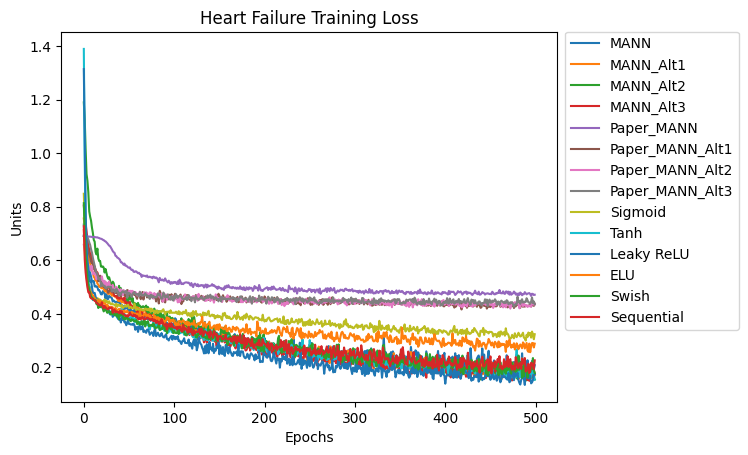

In [12]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Heart Failure Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

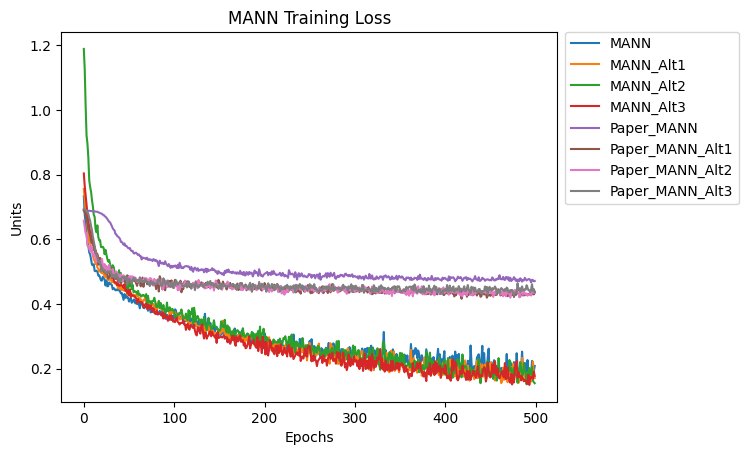

In [13]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')

plt.title('MANN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

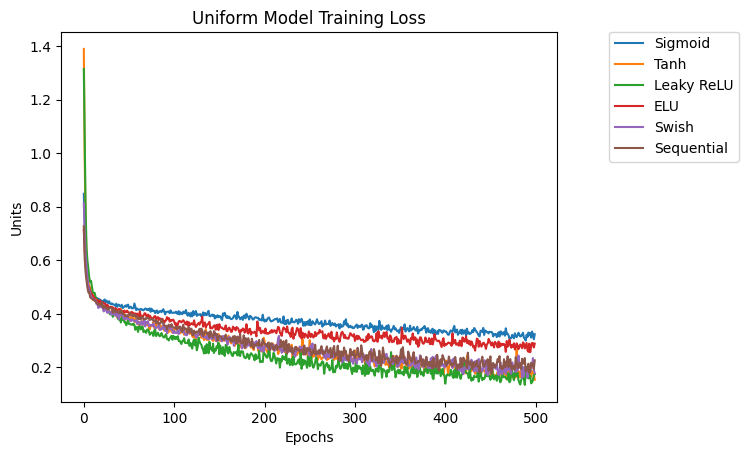

In [14]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Uniform Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

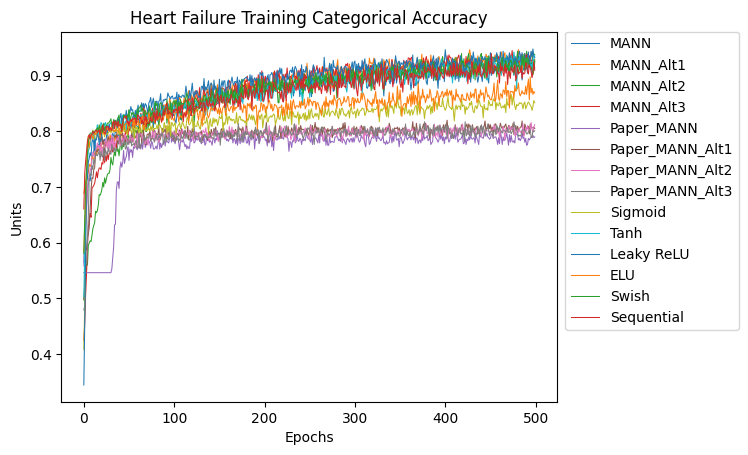

In [15]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Heart Failure Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

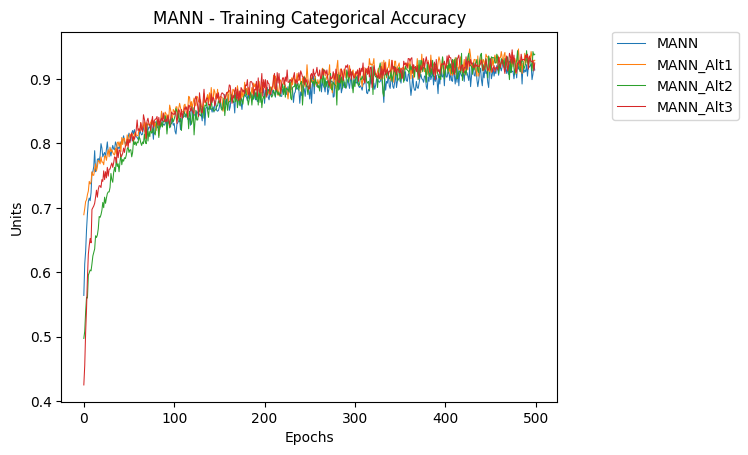

In [16]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

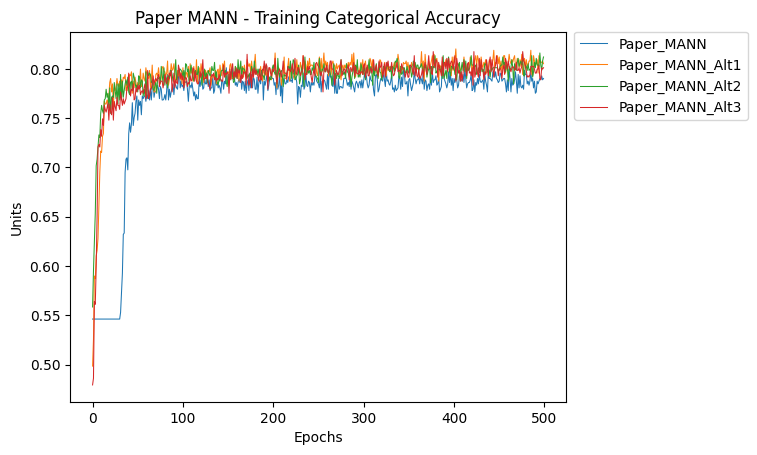

In [17]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

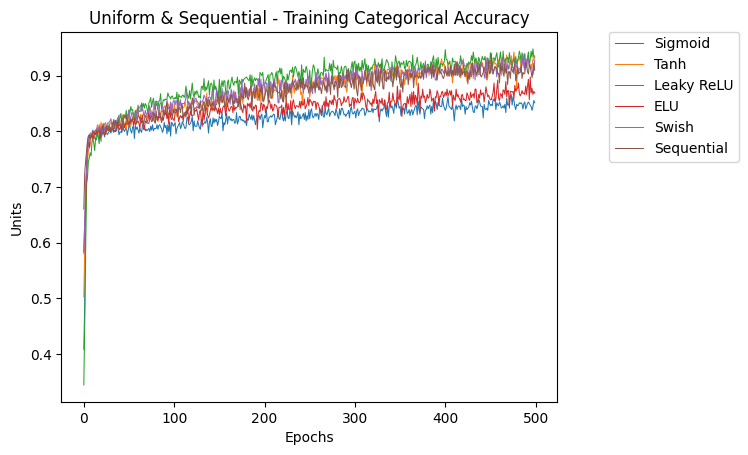

In [18]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

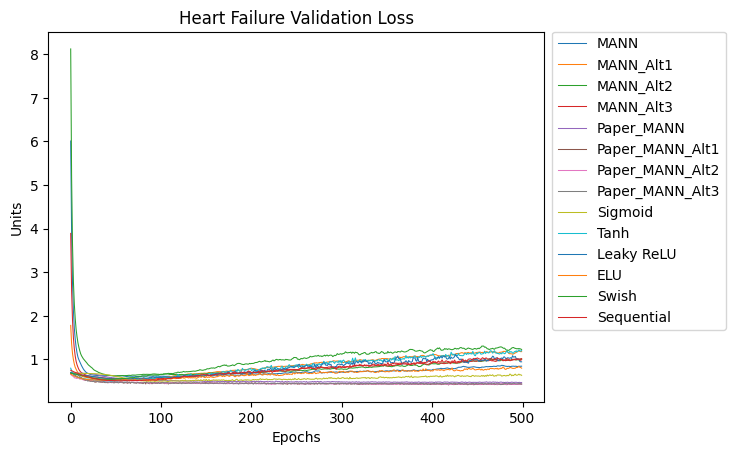

In [19]:
# Plot the validation loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['val_loss'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['val_loss'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['val_loss'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['val_loss'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['val_loss'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['val_loss'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['val_loss'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['val_loss'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['val_loss'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['val_loss'], label='Sequential', linewidth=0.75)

plt.title('Heart Failure Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')
#plt.ylim([0,1.5])
plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

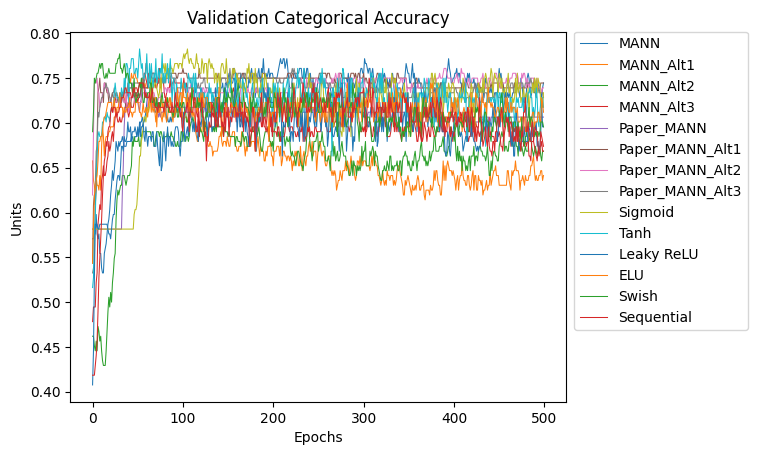

In [20]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

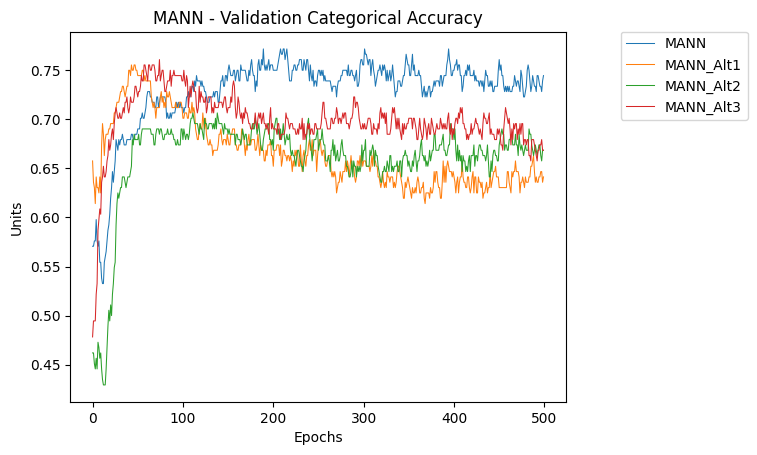

In [21]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

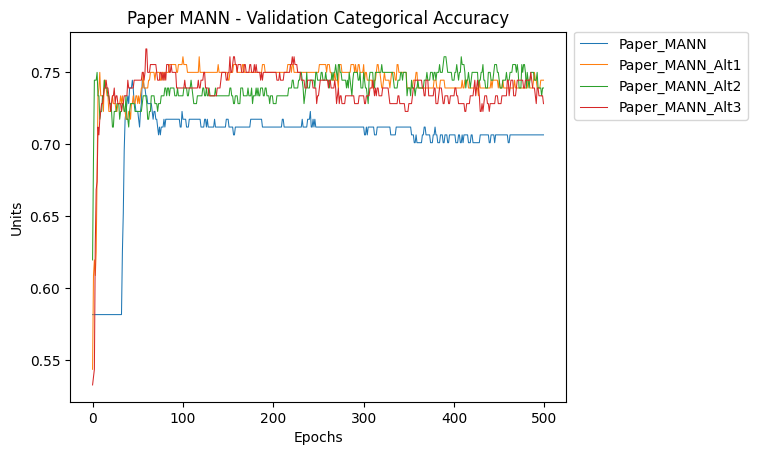

In [22]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

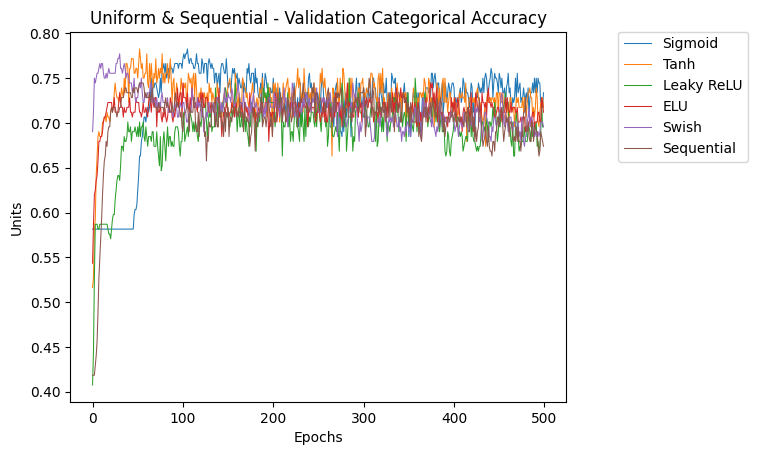

In [23]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

In [24]:
# Save training history
train_hist_df = pd.DataFrame()
val_hist_df = pd.DataFrame()
for name, callback in histories.items():
    train_hist_df = pd.concat((train_hist_df, pd.DataFrame(callback.history['loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    val_hist_df = pd.concat((val_hist_df, pd.DataFrame(callback.history['val_loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    
train_hist_df.to_csv('Binary.training_hist.csv')
val_hist_df.to_csv('Binary.validation_hist.csv')

In [25]:
# Get performance metrics for each model
# Get the testing loss for each model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, one_hot.inverse_transform(y_train).ravel())

metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test.to_numpy(), one_hot.transform(log_reg.predict(X_test).reshape(-1,1)))
log_reg_loss = metric.result().numpy()

MANN_loss = models['MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt1_loss = models['MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt2_loss = models['MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt3_loss = models['MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Paper_MANN_loss = models['Paper_MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt1_loss = models['Paper_MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt2_loss = models['Paper_MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt3_loss = models['Paper_MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sigmoid_loss = models['Sigmoid'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Tanh_loss = models['Tanh'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

LeakyReLU_loss = models['LeakyReLU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

ELU_loss = models['ELU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Swish_loss = models['Swish'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sequential_loss = models['Sequential'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

6/6 [==============================] - 0s 7ms/step - loss: 0.9972 - categorical_accuracy: 0.6739


In [26]:
# Save metrics to a table and display results
# Save testing Accuracy to table and display results
results = pd.DataFrame([MANN_loss, MANN_Alt1_loss, MANN_Alt2_loss, MANN_Alt3_loss, Paper_MANN_loss, Paper_MANN_Alt1_loss, Paper_MANN_Alt2_loss, Paper_MANN_Alt3_loss,Sigmoid_loss, Tanh_loss, LeakyReLU_loss, ELU_loss, Swish_loss, Sequential_loss],
                      index=['MANN', 'MANN_Alt1', 'MANN_Alt2', 'MANN_Alt3', 'Paper MANN', 'Paper Alternate MANN 1', 'Paper Alternate MANN 2', 'Paper Alternate MANN 3', 'Sigmoid NN', 'Tanh NN', 'Leaky ReLU NN', 'ELU NN', 'Swish NN', 'Sequential NN'],
                      columns=['Categorical Accuracy'])
results.sort_values('Categorical Accuracy', inplace=True, ascending=False)
results.head(20)

Categorical Accuracy
MANN                                0.744565
Paper Alternate MANN 1              0.744565
Paper Alternate MANN 2              0.739130
Sigmoid NN                          0.733696
Paper Alternate MANN 3              0.728261
Tanh NN                             0.717391
ELU NN                              0.711957
Paper MANN                          0.706522
Leaky ReLU NN                       0.695652
Swish NN                            0.695652
Sequential NN                       0.673913
MANN_Alt2                           0.668478
MANN_Alt3                           0.668478
MANN_Alt1                           0.641304

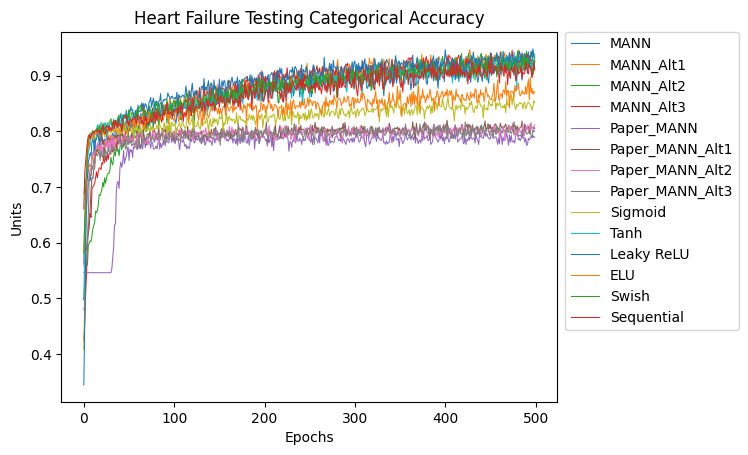

In [27]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Heart Failure Testing Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

# 

# 

# Pulling Cirrhosis Prediction Dataset data from the csv

In [28]:
# Load the data and split into testing and training for processing
CirrhosisData = pd.read_csv('./Datasets/cirrhosis.csv')

CirrhosisData.describe()

ID       N_Days           Age   Bilirubin  Cholesterol  \
count  418.000000   418.000000    418.000000  418.000000   284.000000   
mean   209.500000  1917.782297  18533.351675    3.220813   369.510563   
std    120.810458  1104.672992   3815.845055    4.407506   231.944545   
min      1.000000    41.000000   9598.000000    0.300000   120.000000   
25%    105.250000  1092.750000  15644.500000    0.800000   249.500000   
50%    209.500000  1730.000000  18628.000000    1.400000   309.500000   
75%    313.750000  2613.500000  21272.500000    3.400000   400.000000   
max    418.000000  4795.000000  28650.000000   28.000000  1775.000000   

          Albumin      Copper      Alk_Phos        SGOT  Tryglicerides  \
count  418.000000  310.000000    312.000000  312.000000     282.000000   
mean     3.497440   97.648387   1982.655769  122.556346     124.702128   
std      0.424972   85.613920   2140.388824   56.699525      65.148639   
min      1.960000    4.000000    289.000000   26.350000      33.000000   
25%      3.242500   41.250000    871.500000   80.600000      84.250000   
50%      3.530000   73.000000   1259.000000  114.700000     108.000000   
75%      3.770000  123.000000   1980.000000  151.900000     151.000000   
max      4.640000  588.000000  13862.400000  457.250000     598.000000   

        Platelets  Prothrombin       Stage  
count  407.000000   416.000000  412.000000  
mean   257.024570    10.731731    3.024272  
std     98.325585     1.022000    0.882042  
min     62.000000     9.000000    1.000000  
25%    188.500000    10.000000    2.000000  
50%    251.000000    10.600000    3.000000  
75%    318.000000    11.100000    4.000000  
max    721.000000    18.000000    4.000000

In [29]:
CirrhosisData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [30]:
CirrhosisData.isnull().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

## Replace nan values with the mean for float type columns 10-19

In [31]:
CirrhosisData["Stage"] = CirrhosisData["Stage"].fillna(0)

In [32]:
CirrhosisData.isnull().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              0
dtype: int64

## Assigning features and targets from dataset

In [33]:
CirrhosisData = CirrhosisData.dropna()

In [34]:
features = CirrhosisData.drop(['ID', 'Stage'], axis=1)
features["Age"] = (features["Age"]/365).astype("int64")

target = CirrhosisData['Stage']

In [35]:
features.head()

N_Days Status             Drug  Age Sex Ascites Hepatomegaly Spiders Edema  \
0     400      D  D-penicillamine   58   F       Y            Y       Y     Y   
1    4500      C  D-penicillamine   56   F       N            Y       Y     N   
2    1012      D  D-penicillamine   70   M       N            N       N     S   
3    1925      D  D-penicillamine   54   F       N            Y       Y     S   
4    1504     CL          Placebo   38   F       N            Y       Y     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0       14.5        261.0     2.60   156.0    1718.0  137.95          172.0   
1        1.1        302.0     4.14    54.0    7394.8  113.52           88.0   
2        1.4        176.0     3.48   210.0     516.0   96.10           55.0   
3        1.8        244.0     2.54    64.0    6121.8   60.63           92.0   
4        3.4        279.0     3.53   143.0     671.0  113.15           72.0   

   Platelets  Prothrombin  
0      190.0         12.2  
1      221.0         10.6  
2      151.0         12.0  
3      183.0         10.3  
4      136.0         10.9

In [36]:
target.value_counts()

3.0    111
4.0     94
2.0     59
1.0     12
Name: Stage, dtype: int64

In [37]:
CirrhosisData.isnull().sum()

ID               0
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

## Training the models

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

## Normalizing dataset

In [39]:
# Process and normalize the data
one_hot = OneHotEncoder(sparse_output=False)

# One-Hot encode categorical columns
X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']]), columns=one_hot.get_feature_names_out()))
X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']]), columns=one_hot.get_feature_names_out()))

# Drop the transformed columns and unneeded columns
X_train.drop(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis = 1, inplace=True)
X_test.drop(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis=1, inplace=True)



# Normalize numerical columns
scaler = StandardScaler()
X_train[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']]= scaler.fit_transform(X_train[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']])
X_test[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']] = scaler.transform(X_test[['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']])

C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_44820\876908666.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']]), columns=one_hot.get_feature_names_out()))
C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_44820\876908666.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']]), columns=one_hot.get_feature_names_out()))


In [40]:
# One-Hot encode target labels
y_train = pd.DataFrame(data=one_hot.fit_transform(y_train.to_numpy().reshape(-1,1)), columns=one_hot.categories_)
y_test = pd.DataFrame(data=one_hot.transform(y_test.to_numpy().reshape(-1,1)), columns=one_hot.categories_)

In [41]:
print(one_hot.categories_[0])
print(len(one_hot.categories_[0]))

[1. 2. 3. 4.]
4


In [42]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   (1.0,)  220 non-null    float64
 1   (2.0,)  220 non-null    float64
 2   (3.0,)  220 non-null    float64
 3   (4.0,)  220 non-null    float64
dtypes: float64(4)
memory usage: 7.0 KB


In [43]:
# Create and fit all neural networks for evaluations

models, histories = test(X_train.to_numpy(), y_train.to_numpy(), X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), num_classes=len(one_hot.categories_[0]), task='classification', epochs=500, batch_size=128, task_name='Cirrhosis')

Training Multi Activation Neural Network...
Epoch 1/500
2/2 [==============================] - 3s 434ms/step - loss: 1.6801 - categorical_accuracy: 0.2091 - val_loss: 39.2316 - val_categorical_accuracy: 0.2321
Epoch 2/500
2/2 [==============================] - 0s 167ms/step - loss: 1.6730 - categorical_accuracy: 0.2227 - val_loss: 29.3756 - val_categorical_accuracy: 0.2500
Epoch 3/500
2/2 [==============================] - 0s 183ms/step - loss: 1.6564 - categorical_accuracy: 0.2682 - val_loss: 22.9010 - val_categorical_accuracy: 0.2500
Epoch 4/500
2/2 [==============================] - 0s 150ms/step - loss: 1.6429 - categorical_accuracy: 0.2227 - val_loss: 18.6670 - val_categorical_accuracy: 0.2143
Epoch 5/500
2/2 [==============================] - 0s 159ms/step - loss: 1.6069 - categorical_accuracy: 0.2455 - val_loss: 15.4688 - val_categorical_accuracy: 0.1964
Epoch 6/500
2/2 [==============================] - 0s 150ms/step - loss: 1.6075 - categorical_accuracy: 0.2409 - val_loss: 13.

2/2 [==============================] - 0s 152ms/step - loss: 1.1846 - categorical_accuracy: 0.4727 - val_loss: 1.4824 - val_categorical_accuracy: 0.2679
Epoch 51/500
2/2 [==============================] - 0s 151ms/step - loss: 1.1795 - categorical_accuracy: 0.4818 - val_loss: 1.4754 - val_categorical_accuracy: 0.2857
Epoch 52/500
2/2 [==============================] - 0s 159ms/step - loss: 1.1832 - categorical_accuracy: 0.4909 - val_loss: 1.4674 - val_categorical_accuracy: 0.2857
Epoch 53/500
2/2 [==============================] - 0s 145ms/step - loss: 1.1624 - categorical_accuracy: 0.5091 - val_loss: 1.4610 - val_categorical_accuracy: 0.3036
Epoch 54/500
2/2 [==============================] - 0s 159ms/step - loss: 1.1755 - categorical_accuracy: 0.4864 - val_loss: 1.4541 - val_categorical_accuracy: 0.3036
Epoch 55/500
2/2 [==============================] - 0s 158ms/step - loss: 1.1601 - categorical_accuracy: 0.4864 - val_loss: 1.4465 - val_categorical_accuracy: 0.3036
Epoch 56/500
2/2 

2/2 [==============================] - 0s 88ms/step - loss: 0.9349 - categorical_accuracy: 0.6591 - val_loss: 1.4064 - val_categorical_accuracy: 0.3571
Epoch 100/500
2/2 [==============================] - 0s 93ms/step - loss: 0.9262 - categorical_accuracy: 0.6545 - val_loss: 1.4081 - val_categorical_accuracy: 0.3750
Epoch 101/500
2/2 [==============================] - 0s 89ms/step - loss: 0.9291 - categorical_accuracy: 0.6500 - val_loss: 1.4105 - val_categorical_accuracy: 0.3750
Epoch 102/500
2/2 [==============================] - 0s 90ms/step - loss: 0.9232 - categorical_accuracy: 0.6727 - val_loss: 1.4138 - val_categorical_accuracy: 0.3750
Epoch 103/500
2/2 [==============================] - 0s 89ms/step - loss: 0.9172 - categorical_accuracy: 0.6455 - val_loss: 1.4164 - val_categorical_accuracy: 0.3750
Epoch 104/500
2/2 [==============================] - 0s 89ms/step - loss: 0.9259 - categorical_accuracy: 0.6182 - val_loss: 1.4188 - val_categorical_accuracy: 0.3750
Epoch 105/500
2/2 

2/2 [==============================] - 0s 87ms/step - loss: 0.7275 - categorical_accuracy: 0.7409 - val_loss: 1.4843 - val_categorical_accuracy: 0.4643
Epoch 149/500
2/2 [==============================] - 0s 92ms/step - loss: 0.7997 - categorical_accuracy: 0.7045 - val_loss: 1.4877 - val_categorical_accuracy: 0.4643
Epoch 150/500
2/2 [==============================] - 0s 89ms/step - loss: 0.7239 - categorical_accuracy: 0.7409 - val_loss: 1.4835 - val_categorical_accuracy: 0.4643
Epoch 151/500
2/2 [==============================] - 0s 87ms/step - loss: 0.7415 - categorical_accuracy: 0.7182 - val_loss: 1.4832 - val_categorical_accuracy: 0.4643
Epoch 152/500
2/2 [==============================] - 0s 87ms/step - loss: 0.7343 - categorical_accuracy: 0.7227 - val_loss: 1.4863 - val_categorical_accuracy: 0.4643
Epoch 153/500
2/2 [==============================] - 0s 89ms/step - loss: 0.7370 - categorical_accuracy: 0.7318 - val_loss: 1.4883 - val_categorical_accuracy: 0.4643
Epoch 154/500
2/2 

2/2 [==============================] - 0s 89ms/step - loss: 0.5490 - categorical_accuracy: 0.8227 - val_loss: 1.6552 - val_categorical_accuracy: 0.4286
Epoch 198/500
2/2 [==============================] - 0s 92ms/step - loss: 0.5635 - categorical_accuracy: 0.8227 - val_loss: 1.6561 - val_categorical_accuracy: 0.4286
Epoch 199/500
2/2 [==============================] - 0s 89ms/step - loss: 0.5590 - categorical_accuracy: 0.8409 - val_loss: 1.6640 - val_categorical_accuracy: 0.4107
Epoch 200/500
2/2 [==============================] - 0s 91ms/step - loss: 0.5430 - categorical_accuracy: 0.8364 - val_loss: 1.6685 - val_categorical_accuracy: 0.4107
Epoch 201/500
2/2 [==============================] - 0s 89ms/step - loss: 0.5572 - categorical_accuracy: 0.8364 - val_loss: 1.6699 - val_categorical_accuracy: 0.4107
Epoch 202/500
2/2 [==============================] - 0s 89ms/step - loss: 0.5400 - categorical_accuracy: 0.8409 - val_loss: 1.6718 - val_categorical_accuracy: 0.4107
Epoch 203/500
2/2 

2/2 [==============================] - 0s 88ms/step - loss: 0.4883 - categorical_accuracy: 0.8455 - val_loss: 1.8411 - val_categorical_accuracy: 0.4107
Epoch 247/500
2/2 [==============================] - 0s 86ms/step - loss: 0.4285 - categorical_accuracy: 0.8682 - val_loss: 1.8443 - val_categorical_accuracy: 0.4107
Epoch 248/500
2/2 [==============================] - 0s 86ms/step - loss: 0.5256 - categorical_accuracy: 0.8182 - val_loss: 1.8387 - val_categorical_accuracy: 0.4107
Epoch 249/500
2/2 [==============================] - 0s 90ms/step - loss: 0.4271 - categorical_accuracy: 0.8773 - val_loss: 1.8434 - val_categorical_accuracy: 0.4107
Epoch 250/500
2/2 [==============================] - 0s 90ms/step - loss: 0.4099 - categorical_accuracy: 0.8773 - val_loss: 1.8475 - val_categorical_accuracy: 0.4107
Epoch 251/500
2/2 [==============================] - 0s 86ms/step - loss: 0.4634 - categorical_accuracy: 0.8455 - val_loss: 1.8613 - val_categorical_accuracy: 0.4107
Epoch 252/500
2/2 

2/2 [==============================] - 0s 87ms/step - loss: 0.3381 - categorical_accuracy: 0.9227 - val_loss: 2.1183 - val_categorical_accuracy: 0.3929
Epoch 296/500
2/2 [==============================] - 0s 88ms/step - loss: 0.3481 - categorical_accuracy: 0.8955 - val_loss: 2.1237 - val_categorical_accuracy: 0.3929
Epoch 297/500
2/2 [==============================] - 0s 88ms/step - loss: 0.3395 - categorical_accuracy: 0.9091 - val_loss: 2.1282 - val_categorical_accuracy: 0.3929
Epoch 298/500
2/2 [==============================] - 0s 89ms/step - loss: 0.3581 - categorical_accuracy: 0.9045 - val_loss: 2.1380 - val_categorical_accuracy: 0.3929
Epoch 299/500
2/2 [==============================] - 0s 87ms/step - loss: 0.3071 - categorical_accuracy: 0.9182 - val_loss: 2.1457 - val_categorical_accuracy: 0.3929
Epoch 300/500
2/2 [==============================] - 0s 89ms/step - loss: 0.3288 - categorical_accuracy: 0.9091 - val_loss: 2.1473 - val_categorical_accuracy: 0.3929
Epoch 301/500
2/2 

2/2 [==============================] - 0s 86ms/step - loss: 0.2987 - categorical_accuracy: 0.9045 - val_loss: 2.3447 - val_categorical_accuracy: 0.4107
Epoch 345/500
2/2 [==============================] - 0s 86ms/step - loss: 0.2674 - categorical_accuracy: 0.9182 - val_loss: 2.3289 - val_categorical_accuracy: 0.4107
Epoch 346/500
2/2 [==============================] - 0s 87ms/step - loss: 0.3068 - categorical_accuracy: 0.9000 - val_loss: 2.3296 - val_categorical_accuracy: 0.4107
Epoch 347/500
2/2 [==============================] - 0s 91ms/step - loss: 0.2556 - categorical_accuracy: 0.9364 - val_loss: 2.3343 - val_categorical_accuracy: 0.4107
Epoch 348/500
2/2 [==============================] - 0s 92ms/step - loss: 0.2993 - categorical_accuracy: 0.9182 - val_loss: 2.3189 - val_categorical_accuracy: 0.4286
Epoch 349/500
2/2 [==============================] - 0s 90ms/step - loss: 0.2364 - categorical_accuracy: 0.9318 - val_loss: 2.3243 - val_categorical_accuracy: 0.4286
Epoch 350/500
2/2 

2/2 [==============================] - 0s 90ms/step - loss: 0.2520 - categorical_accuracy: 0.9227 - val_loss: 2.5339 - val_categorical_accuracy: 0.3929
Epoch 394/500
2/2 [==============================] - 0s 87ms/step - loss: 0.2298 - categorical_accuracy: 0.9364 - val_loss: 2.5447 - val_categorical_accuracy: 0.4107
Epoch 395/500
2/2 [==============================] - 0s 86ms/step - loss: 0.1823 - categorical_accuracy: 0.9455 - val_loss: 2.5470 - val_categorical_accuracy: 0.4107
Epoch 396/500
2/2 [==============================] - 0s 87ms/step - loss: 0.2110 - categorical_accuracy: 0.9455 - val_loss: 2.5446 - val_categorical_accuracy: 0.4107
Epoch 397/500
2/2 [==============================] - 0s 88ms/step - loss: 0.2489 - categorical_accuracy: 0.9273 - val_loss: 2.5487 - val_categorical_accuracy: 0.4107
Epoch 398/500
2/2 [==============================] - 0s 89ms/step - loss: 0.2039 - categorical_accuracy: 0.9455 - val_loss: 2.5576 - val_categorical_accuracy: 0.4107
Epoch 399/500
2/2 

2/2 [==============================] - 0s 89ms/step - loss: 0.1770 - categorical_accuracy: 0.9545 - val_loss: 2.7424 - val_categorical_accuracy: 0.4107
Epoch 443/500
2/2 [==============================] - 0s 90ms/step - loss: 0.1757 - categorical_accuracy: 0.9500 - val_loss: 2.7689 - val_categorical_accuracy: 0.4107
Epoch 444/500
2/2 [==============================] - 0s 89ms/step - loss: 0.1788 - categorical_accuracy: 0.9500 - val_loss: 2.7749 - val_categorical_accuracy: 0.4107
Epoch 445/500
2/2 [==============================] - 0s 88ms/step - loss: 0.1684 - categorical_accuracy: 0.9545 - val_loss: 2.7832 - val_categorical_accuracy: 0.4107
Epoch 446/500
2/2 [==============================] - 0s 89ms/step - loss: 0.1893 - categorical_accuracy: 0.9500 - val_loss: 2.7774 - val_categorical_accuracy: 0.4107
Epoch 447/500
2/2 [==============================] - 0s 89ms/step - loss: 0.1516 - categorical_accuracy: 0.9591 - val_loss: 2.7882 - val_categorical_accuracy: 0.4286
Epoch 448/500
2/2 

2/2 [==============================] - 0s 87ms/step - loss: 0.1287 - categorical_accuracy: 0.9773 - val_loss: 3.0336 - val_categorical_accuracy: 0.3750
Epoch 492/500
2/2 [==============================] - 0s 89ms/step - loss: 0.1143 - categorical_accuracy: 0.9864 - val_loss: 3.0359 - val_categorical_accuracy: 0.3750
Epoch 493/500
2/2 [==============================] - 0s 85ms/step - loss: 0.0998 - categorical_accuracy: 0.9864 - val_loss: 3.0350 - val_categorical_accuracy: 0.3750
Epoch 494/500
2/2 [==============================] - 0s 87ms/step - loss: 0.1292 - categorical_accuracy: 0.9773 - val_loss: 3.0362 - val_categorical_accuracy: 0.3929
Epoch 495/500
2/2 [==============================] - 0s 85ms/step - loss: 0.1179 - categorical_accuracy: 0.9636 - val_loss: 3.0353 - val_categorical_accuracy: 0.3929
Epoch 496/500
2/2 [==============================] - 0s 86ms/step - loss: 0.1290 - categorical_accuracy: 0.9591 - val_loss: 3.0371 - val_categorical_accuracy: 0.3929
Epoch 497/500
2/2 

Epoch 40/500
2/2 [==============================] - 0s 159ms/step - loss: 1.3990 - categorical_accuracy: 0.3045 - val_loss: 1.9893 - val_categorical_accuracy: 0.1607
Epoch 41/500
2/2 [==============================] - 0s 147ms/step - loss: 1.3861 - categorical_accuracy: 0.2955 - val_loss: 1.9615 - val_categorical_accuracy: 0.1607
Epoch 42/500
2/2 [==============================] - 0s 152ms/step - loss: 1.3844 - categorical_accuracy: 0.3136 - val_loss: 1.9371 - val_categorical_accuracy: 0.1607
Epoch 43/500
2/2 [==============================] - 0s 150ms/step - loss: 1.3768 - categorical_accuracy: 0.2955 - val_loss: 1.9107 - val_categorical_accuracy: 0.1429
Epoch 44/500
2/2 [==============================] - 0s 160ms/step - loss: 1.3553 - categorical_accuracy: 0.3091 - val_loss: 1.8882 - val_categorical_accuracy: 0.1429
Epoch 45/500
2/2 [==============================] - 0s 158ms/step - loss: 1.3565 - categorical_accuracy: 0.3318 - val_loss: 1.8640 - val_categorical_accuracy: 0.1429
Epoc

2/2 [==============================] - 0s 158ms/step - loss: 1.0993 - categorical_accuracy: 0.5318 - val_loss: 1.3849 - val_categorical_accuracy: 0.4286
Epoch 90/500
2/2 [==============================] - 0s 153ms/step - loss: 1.0919 - categorical_accuracy: 0.5500 - val_loss: 1.3803 - val_categorical_accuracy: 0.4286
Epoch 91/500
2/2 [==============================] - 0s 163ms/step - loss: 1.0920 - categorical_accuracy: 0.5182 - val_loss: 1.3747 - val_categorical_accuracy: 0.4464
Epoch 92/500
2/2 [==============================] - 0s 159ms/step - loss: 1.1093 - categorical_accuracy: 0.5182 - val_loss: 1.3686 - val_categorical_accuracy: 0.4464
Epoch 93/500
2/2 [==============================] - 0s 156ms/step - loss: 1.1105 - categorical_accuracy: 0.5136 - val_loss: 1.3635 - val_categorical_accuracy: 0.4464
Epoch 94/500
2/2 [==============================] - 0s 162ms/step - loss: 1.0633 - categorical_accuracy: 0.5545 - val_loss: 1.3600 - val_categorical_accuracy: 0.4286
Epoch 95/500
2/2 

2/2 [==============================] - 0s 87ms/step - loss: 0.8847 - categorical_accuracy: 0.6727 - val_loss: 1.3625 - val_categorical_accuracy: 0.3929
Epoch 139/500
2/2 [==============================] - 0s 86ms/step - loss: 0.8823 - categorical_accuracy: 0.6591 - val_loss: 1.3628 - val_categorical_accuracy: 0.3929
Epoch 140/500
2/2 [==============================] - 0s 88ms/step - loss: 0.8659 - categorical_accuracy: 0.6773 - val_loss: 1.3636 - val_categorical_accuracy: 0.3929
Epoch 141/500
2/2 [==============================] - 0s 88ms/step - loss: 0.8836 - categorical_accuracy: 0.6727 - val_loss: 1.3634 - val_categorical_accuracy: 0.3750
Epoch 142/500
2/2 [==============================] - 0s 88ms/step - loss: 0.8959 - categorical_accuracy: 0.6682 - val_loss: 1.3631 - val_categorical_accuracy: 0.3750
Epoch 143/500
2/2 [==============================] - 0s 88ms/step - loss: 0.8959 - categorical_accuracy: 0.6909 - val_loss: 1.3644 - val_categorical_accuracy: 0.3750
Epoch 144/500
2/2 

2/2 [==============================] - 0s 85ms/step - loss: 0.7198 - categorical_accuracy: 0.7682 - val_loss: 1.4610 - val_categorical_accuracy: 0.3929
Epoch 188/500
2/2 [==============================] - 0s 86ms/step - loss: 0.7299 - categorical_accuracy: 0.7727 - val_loss: 1.4632 - val_categorical_accuracy: 0.3929
Epoch 189/500
2/2 [==============================] - 0s 87ms/step - loss: 0.7128 - categorical_accuracy: 0.7864 - val_loss: 1.4672 - val_categorical_accuracy: 0.3929
Epoch 190/500
2/2 [==============================] - 0s 87ms/step - loss: 0.7360 - categorical_accuracy: 0.7773 - val_loss: 1.4688 - val_categorical_accuracy: 0.3929
Epoch 191/500
2/2 [==============================] - 0s 83ms/step - loss: 0.7096 - categorical_accuracy: 0.7773 - val_loss: 1.4711 - val_categorical_accuracy: 0.3929
Epoch 192/500
2/2 [==============================] - 0s 89ms/step - loss: 0.7289 - categorical_accuracy: 0.7591 - val_loss: 1.4718 - val_categorical_accuracy: 0.3929
Epoch 193/500
2/2 

2/2 [==============================] - 0s 90ms/step - loss: 0.5851 - categorical_accuracy: 0.8318 - val_loss: 1.6074 - val_categorical_accuracy: 0.3929
Epoch 237/500
2/2 [==============================] - 0s 90ms/step - loss: 0.5992 - categorical_accuracy: 0.8091 - val_loss: 1.6105 - val_categorical_accuracy: 0.3929
Epoch 238/500
2/2 [==============================] - 0s 87ms/step - loss: 0.5934 - categorical_accuracy: 0.8091 - val_loss: 1.6125 - val_categorical_accuracy: 0.3929
Epoch 239/500
2/2 [==============================] - 0s 89ms/step - loss: 0.5918 - categorical_accuracy: 0.8136 - val_loss: 1.6138 - val_categorical_accuracy: 0.3929
Epoch 240/500
2/2 [==============================] - 0s 89ms/step - loss: 0.5576 - categorical_accuracy: 0.8455 - val_loss: 1.6194 - val_categorical_accuracy: 0.3929
Epoch 241/500
2/2 [==============================] - 0s 91ms/step - loss: 0.5645 - categorical_accuracy: 0.8182 - val_loss: 1.6226 - val_categorical_accuracy: 0.3929
Epoch 242/500
2/2 

2/2 [==============================] - 0s 90ms/step - loss: 0.4634 - categorical_accuracy: 0.8591 - val_loss: 1.7448 - val_categorical_accuracy: 0.3750
Epoch 286/500
2/2 [==============================] - 0s 91ms/step - loss: 0.4982 - categorical_accuracy: 0.8318 - val_loss: 1.7474 - val_categorical_accuracy: 0.3750
Epoch 287/500
2/2 [==============================] - 0s 89ms/step - loss: 0.4952 - categorical_accuracy: 0.8364 - val_loss: 1.7549 - val_categorical_accuracy: 0.3750
Epoch 288/500
2/2 [==============================] - 0s 87ms/step - loss: 0.4433 - categorical_accuracy: 0.8864 - val_loss: 1.7574 - val_categorical_accuracy: 0.3750
Epoch 289/500
2/2 [==============================] - 0s 88ms/step - loss: 0.4833 - categorical_accuracy: 0.8636 - val_loss: 1.7649 - val_categorical_accuracy: 0.3750
Epoch 290/500
2/2 [==============================] - 0s 88ms/step - loss: 0.4705 - categorical_accuracy: 0.8682 - val_loss: 1.7691 - val_categorical_accuracy: 0.3750
Epoch 291/500
2/2 

2/2 [==============================] - 0s 85ms/step - loss: 0.3992 - categorical_accuracy: 0.8955 - val_loss: 1.9674 - val_categorical_accuracy: 0.4286
Epoch 335/500
2/2 [==============================] - 0s 89ms/step - loss: 0.3820 - categorical_accuracy: 0.8955 - val_loss: 1.9642 - val_categorical_accuracy: 0.4286
Epoch 336/500
2/2 [==============================] - 0s 92ms/step - loss: 0.4228 - categorical_accuracy: 0.8909 - val_loss: 1.9601 - val_categorical_accuracy: 0.4107
Epoch 337/500
2/2 [==============================] - 0s 85ms/step - loss: 0.3825 - categorical_accuracy: 0.8864 - val_loss: 1.9627 - val_categorical_accuracy: 0.4286
Epoch 338/500
2/2 [==============================] - 0s 87ms/step - loss: 0.3626 - categorical_accuracy: 0.9000 - val_loss: 1.9606 - val_categorical_accuracy: 0.4286
Epoch 339/500
2/2 [==============================] - 0s 92ms/step - loss: 0.4287 - categorical_accuracy: 0.8773 - val_loss: 1.9684 - val_categorical_accuracy: 0.4107
Epoch 340/500
2/2 

2/2 [==============================] - 0s 75ms/step - loss: 0.2976 - categorical_accuracy: 0.9364 - val_loss: 2.1972 - val_categorical_accuracy: 0.4286
Epoch 384/500
2/2 [==============================] - 0s 84ms/step - loss: 0.3483 - categorical_accuracy: 0.9000 - val_loss: 2.1999 - val_categorical_accuracy: 0.4286
Epoch 385/500
2/2 [==============================] - 0s 76ms/step - loss: 0.2899 - categorical_accuracy: 0.9455 - val_loss: 2.2043 - val_categorical_accuracy: 0.4286
Epoch 386/500
2/2 [==============================] - 0s 80ms/step - loss: 0.3345 - categorical_accuracy: 0.9182 - val_loss: 2.2070 - val_categorical_accuracy: 0.4107
Epoch 387/500
2/2 [==============================] - 0s 64ms/step - loss: 0.3000 - categorical_accuracy: 0.9409 - val_loss: 2.2168 - val_categorical_accuracy: 0.3750
Epoch 388/500
2/2 [==============================] - 0s 67ms/step - loss: 0.3548 - categorical_accuracy: 0.8909 - val_loss: 2.2191 - val_categorical_accuracy: 0.4286
Epoch 389/500
2/2 

2/2 [==============================] - 0s 74ms/step - loss: 0.2677 - categorical_accuracy: 0.9500 - val_loss: 2.3866 - val_categorical_accuracy: 0.3929
Epoch 433/500
2/2 [==============================] - 0s 73ms/step - loss: 0.3713 - categorical_accuracy: 0.9000 - val_loss: 2.4000 - val_categorical_accuracy: 0.4107
Epoch 434/500
2/2 [==============================] - 0s 69ms/step - loss: 0.2375 - categorical_accuracy: 0.9545 - val_loss: 2.4036 - val_categorical_accuracy: 0.3750
Epoch 435/500
2/2 [==============================] - 0s 75ms/step - loss: 0.2902 - categorical_accuracy: 0.9182 - val_loss: 2.4203 - val_categorical_accuracy: 0.3929
Epoch 436/500
2/2 [==============================] - 0s 69ms/step - loss: 0.2751 - categorical_accuracy: 0.9409 - val_loss: 2.4211 - val_categorical_accuracy: 0.3750
Epoch 437/500
2/2 [==============================] - 0s 71ms/step - loss: 0.2824 - categorical_accuracy: 0.9364 - val_loss: 2.4124 - val_categorical_accuracy: 0.4107
Epoch 438/500
2/2 

2/2 [==============================] - 0s 78ms/step - loss: 0.2290 - categorical_accuracy: 0.9545 - val_loss: 2.5497 - val_categorical_accuracy: 0.4286
Epoch 482/500
2/2 [==============================] - 0s 83ms/step - loss: 0.2635 - categorical_accuracy: 0.9364 - val_loss: 2.5582 - val_categorical_accuracy: 0.4286
Epoch 483/500
2/2 [==============================] - 0s 79ms/step - loss: 0.2249 - categorical_accuracy: 0.9636 - val_loss: 2.5582 - val_categorical_accuracy: 0.4107
Epoch 484/500
2/2 [==============================] - 0s 89ms/step - loss: 0.2416 - categorical_accuracy: 0.9500 - val_loss: 2.5633 - val_categorical_accuracy: 0.4107
Epoch 485/500
2/2 [==============================] - 0s 81ms/step - loss: 0.2371 - categorical_accuracy: 0.9409 - val_loss: 2.5683 - val_categorical_accuracy: 0.4107
Epoch 486/500
2/2 [==============================] - 0s 105ms/step - loss: 0.2462 - categorical_accuracy: 0.9455 - val_loss: 2.5636 - val_categorical_accuracy: 0.4107
Epoch 487/500
2/2

Epoch 30/500
2/2 [==============================] - 0s 142ms/step - loss: 1.3060 - categorical_accuracy: 0.4227 - val_loss: 2.5947 - val_categorical_accuracy: 0.2143
Epoch 31/500
2/2 [==============================] - 0s 151ms/step - loss: 1.3167 - categorical_accuracy: 0.4136 - val_loss: 2.5174 - val_categorical_accuracy: 0.1964
Epoch 32/500
2/2 [==============================] - 0s 157ms/step - loss: 1.2735 - categorical_accuracy: 0.4409 - val_loss: 2.4461 - val_categorical_accuracy: 0.1964
Epoch 33/500
2/2 [==============================] - 0s 160ms/step - loss: 1.2877 - categorical_accuracy: 0.4364 - val_loss: 2.3817 - val_categorical_accuracy: 0.2143
Epoch 34/500
2/2 [==============================] - 0s 193ms/step - loss: 1.2944 - categorical_accuracy: 0.4273 - val_loss: 2.3235 - val_categorical_accuracy: 0.2143
Epoch 35/500
2/2 [==============================] - 0s 156ms/step - loss: 1.2534 - categorical_accuracy: 0.4864 - val_loss: 2.2675 - val_categorical_accuracy: 0.2143
Epoc

2/2 [==============================] - 0s 158ms/step - loss: 0.9738 - categorical_accuracy: 0.6636 - val_loss: 1.5998 - val_categorical_accuracy: 0.2857
Epoch 80/500
2/2 [==============================] - 0s 165ms/step - loss: 0.9972 - categorical_accuracy: 0.6136 - val_loss: 1.5964 - val_categorical_accuracy: 0.2857
Epoch 81/500
2/2 [==============================] - 0s 163ms/step - loss: 0.9714 - categorical_accuracy: 0.6364 - val_loss: 1.5950 - val_categorical_accuracy: 0.3036
Epoch 82/500
2/2 [==============================] - 0s 170ms/step - loss: 0.9976 - categorical_accuracy: 0.6091 - val_loss: 1.5884 - val_categorical_accuracy: 0.3214
Epoch 83/500
2/2 [==============================] - 0s 152ms/step - loss: 1.0040 - categorical_accuracy: 0.6227 - val_loss: 1.5819 - val_categorical_accuracy: 0.3393
Epoch 84/500
2/2 [==============================] - 0s 152ms/step - loss: 0.9663 - categorical_accuracy: 0.6136 - val_loss: 1.5786 - val_categorical_accuracy: 0.3393
Epoch 85/500
2/2 

2/2 [==============================] - 0s 80ms/step - loss: 0.7916 - categorical_accuracy: 0.7000 - val_loss: 1.6084 - val_categorical_accuracy: 0.3571
Epoch 129/500
2/2 [==============================] - 0s 71ms/step - loss: 0.7688 - categorical_accuracy: 0.7091 - val_loss: 1.6146 - val_categorical_accuracy: 0.3571
Epoch 130/500
2/2 [==============================] - 0s 71ms/step - loss: 0.7792 - categorical_accuracy: 0.7227 - val_loss: 1.6170 - val_categorical_accuracy: 0.3214
Epoch 131/500
2/2 [==============================] - 0s 71ms/step - loss: 0.7893 - categorical_accuracy: 0.7091 - val_loss: 1.6195 - val_categorical_accuracy: 0.3214
Epoch 132/500
2/2 [==============================] - 0s 71ms/step - loss: 0.8211 - categorical_accuracy: 0.6909 - val_loss: 1.6236 - val_categorical_accuracy: 0.3214
Epoch 133/500
2/2 [==============================] - 0s 78ms/step - loss: 0.7757 - categorical_accuracy: 0.7182 - val_loss: 1.6256 - val_categorical_accuracy: 0.3214
Epoch 134/500
2/2 

2/2 [==============================] - 0s 73ms/step - loss: 0.6630 - categorical_accuracy: 0.7455 - val_loss: 1.7791 - val_categorical_accuracy: 0.3214
Epoch 178/500
2/2 [==============================] - 0s 62ms/step - loss: 0.6788 - categorical_accuracy: 0.7545 - val_loss: 1.7879 - val_categorical_accuracy: 0.3214
Epoch 179/500
2/2 [==============================] - 0s 61ms/step - loss: 0.6861 - categorical_accuracy: 0.7364 - val_loss: 1.7864 - val_categorical_accuracy: 0.3214
Epoch 180/500
2/2 [==============================] - 0s 80ms/step - loss: 0.6212 - categorical_accuracy: 0.7773 - val_loss: 1.7895 - val_categorical_accuracy: 0.3036
Epoch 181/500
2/2 [==============================] - 0s 74ms/step - loss: 0.6530 - categorical_accuracy: 0.7364 - val_loss: 1.7924 - val_categorical_accuracy: 0.3214
Epoch 182/500
2/2 [==============================] - 0s 77ms/step - loss: 0.6385 - categorical_accuracy: 0.7682 - val_loss: 1.8002 - val_categorical_accuracy: 0.3214
Epoch 183/500
2/2 

2/2 [==============================] - 0s 65ms/step - loss: 0.5402 - categorical_accuracy: 0.8091 - val_loss: 1.9833 - val_categorical_accuracy: 0.3214
Epoch 227/500
2/2 [==============================] - 0s 97ms/step - loss: 0.5345 - categorical_accuracy: 0.8091 - val_loss: 1.9852 - val_categorical_accuracy: 0.3036
Epoch 228/500
2/2 [==============================] - 0s 94ms/step - loss: 0.5218 - categorical_accuracy: 0.8136 - val_loss: 1.9966 - val_categorical_accuracy: 0.3036
Epoch 229/500
2/2 [==============================] - 0s 89ms/step - loss: 0.5022 - categorical_accuracy: 0.8364 - val_loss: 2.0092 - val_categorical_accuracy: 0.3036
Epoch 230/500
2/2 [==============================] - 0s 71ms/step - loss: 0.5208 - categorical_accuracy: 0.8091 - val_loss: 2.0137 - val_categorical_accuracy: 0.3036
Epoch 231/500
2/2 [==============================] - 0s 62ms/step - loss: 0.5214 - categorical_accuracy: 0.8364 - val_loss: 2.0224 - val_categorical_accuracy: 0.3036
Epoch 232/500
2/2 

2/2 [==============================] - 0s 77ms/step - loss: 0.3896 - categorical_accuracy: 0.8909 - val_loss: 2.2123 - val_categorical_accuracy: 0.3571
Epoch 276/500
2/2 [==============================] - 0s 85ms/step - loss: 0.3868 - categorical_accuracy: 0.8909 - val_loss: 2.2174 - val_categorical_accuracy: 0.3571
Epoch 277/500
2/2 [==============================] - 0s 83ms/step - loss: 0.4032 - categorical_accuracy: 0.8773 - val_loss: 2.2295 - val_categorical_accuracy: 0.3571
Epoch 278/500
2/2 [==============================] - 0s 84ms/step - loss: 0.4081 - categorical_accuracy: 0.8773 - val_loss: 2.2251 - val_categorical_accuracy: 0.3571
Epoch 279/500
2/2 [==============================] - 0s 90ms/step - loss: 0.4337 - categorical_accuracy: 0.8591 - val_loss: 2.2243 - val_categorical_accuracy: 0.3571
Epoch 280/500
2/2 [==============================] - 0s 92ms/step - loss: 0.3811 - categorical_accuracy: 0.8955 - val_loss: 2.2291 - val_categorical_accuracy: 0.3571
Epoch 281/500
2/2 

2/2 [==============================] - 0s 75ms/step - loss: 0.3213 - categorical_accuracy: 0.9273 - val_loss: 2.4827 - val_categorical_accuracy: 0.3571
Epoch 325/500
2/2 [==============================] - 0s 94ms/step - loss: 0.3342 - categorical_accuracy: 0.9000 - val_loss: 2.4828 - val_categorical_accuracy: 0.3571
Epoch 326/500
2/2 [==============================] - 0s 81ms/step - loss: 0.3032 - categorical_accuracy: 0.9273 - val_loss: 2.4847 - val_categorical_accuracy: 0.3571
Epoch 327/500
2/2 [==============================] - 0s 76ms/step - loss: 0.2625 - categorical_accuracy: 0.9500 - val_loss: 2.4899 - val_categorical_accuracy: 0.3571
Epoch 328/500
2/2 [==============================] - 0s 70ms/step - loss: 0.3259 - categorical_accuracy: 0.9045 - val_loss: 2.4937 - val_categorical_accuracy: 0.3571
Epoch 329/500
2/2 [==============================] - 0s 62ms/step - loss: 0.3048 - categorical_accuracy: 0.9227 - val_loss: 2.4864 - val_categorical_accuracy: 0.3571
Epoch 330/500
2/2 

2/2 [==============================] - 0s 96ms/step - loss: 0.2240 - categorical_accuracy: 0.9545 - val_loss: 2.7619 - val_categorical_accuracy: 0.3393
Epoch 374/500
2/2 [==============================] - 0s 94ms/step - loss: 0.2307 - categorical_accuracy: 0.9455 - val_loss: 2.7758 - val_categorical_accuracy: 0.3214
Epoch 375/500
2/2 [==============================] - 0s 96ms/step - loss: 0.2293 - categorical_accuracy: 0.9500 - val_loss: 2.7845 - val_categorical_accuracy: 0.3393
Epoch 376/500
2/2 [==============================] - 0s 93ms/step - loss: 0.2296 - categorical_accuracy: 0.9500 - val_loss: 2.7933 - val_categorical_accuracy: 0.3393
Epoch 377/500
2/2 [==============================] - 0s 93ms/step - loss: 0.2424 - categorical_accuracy: 0.9318 - val_loss: 2.7932 - val_categorical_accuracy: 0.3393
Epoch 378/500
2/2 [==============================] - 0s 96ms/step - loss: 0.2385 - categorical_accuracy: 0.9318 - val_loss: 2.8157 - val_categorical_accuracy: 0.3214
Epoch 379/500
2/2 

2/2 [==============================] - 0s 95ms/step - loss: 0.1787 - categorical_accuracy: 0.9545 - val_loss: 2.9820 - val_categorical_accuracy: 0.3571
Epoch 423/500
2/2 [==============================] - 0s 95ms/step - loss: 0.1618 - categorical_accuracy: 0.9682 - val_loss: 2.9856 - val_categorical_accuracy: 0.3571
Epoch 424/500
2/2 [==============================] - 0s 94ms/step - loss: 0.1726 - categorical_accuracy: 0.9591 - val_loss: 3.0022 - val_categorical_accuracy: 0.3571
Epoch 425/500
2/2 [==============================] - 0s 99ms/step - loss: 0.2318 - categorical_accuracy: 0.9409 - val_loss: 3.0041 - val_categorical_accuracy: 0.3571
Epoch 426/500
2/2 [==============================] - 0s 98ms/step - loss: 0.1555 - categorical_accuracy: 0.9636 - val_loss: 3.0080 - val_categorical_accuracy: 0.3571
Epoch 427/500
2/2 [==============================] - 0s 99ms/step - loss: 0.2263 - categorical_accuracy: 0.9500 - val_loss: 3.0257 - val_categorical_accuracy: 0.3571
Epoch 428/500
2/2 

2/2 [==============================] - 0s 97ms/step - loss: 0.1686 - categorical_accuracy: 0.9682 - val_loss: 3.1776 - val_categorical_accuracy: 0.3393
Epoch 472/500
2/2 [==============================] - 0s 97ms/step - loss: 0.1380 - categorical_accuracy: 0.9636 - val_loss: 3.1826 - val_categorical_accuracy: 0.3393
Epoch 473/500
2/2 [==============================] - 0s 100ms/step - loss: 0.2054 - categorical_accuracy: 0.9455 - val_loss: 3.1740 - val_categorical_accuracy: 0.3393
Epoch 474/500
2/2 [==============================] - 0s 88ms/step - loss: 0.1386 - categorical_accuracy: 0.9727 - val_loss: 3.1769 - val_categorical_accuracy: 0.3393
Epoch 475/500
2/2 [==============================] - 0s 77ms/step - loss: 0.1861 - categorical_accuracy: 0.9500 - val_loss: 3.1660 - val_categorical_accuracy: 0.3393
Epoch 476/500
2/2 [==============================] - 0s 66ms/step - loss: 0.1968 - categorical_accuracy: 0.9636 - val_loss: 3.1577 - val_categorical_accuracy: 0.3214
Epoch 477/500
2/2

Epoch 20/500
2/2 [==============================] - 0s 164ms/step - loss: 1.3010 - categorical_accuracy: 0.4682 - val_loss: 2.4254 - val_categorical_accuracy: 0.2321
Epoch 21/500
2/2 [==============================] - 0s 161ms/step - loss: 1.2621 - categorical_accuracy: 0.5000 - val_loss: 2.3587 - val_categorical_accuracy: 0.2143
Epoch 22/500
2/2 [==============================] - 0s 165ms/step - loss: 1.2668 - categorical_accuracy: 0.4727 - val_loss: 2.2948 - val_categorical_accuracy: 0.2143
Epoch 23/500
2/2 [==============================] - 0s 164ms/step - loss: 1.2546 - categorical_accuracy: 0.5091 - val_loss: 2.2374 - val_categorical_accuracy: 0.2143
Epoch 24/500
2/2 [==============================] - 0s 159ms/step - loss: 1.2296 - categorical_accuracy: 0.5000 - val_loss: 2.1855 - val_categorical_accuracy: 0.2143
Epoch 25/500
2/2 [==============================] - 0s 152ms/step - loss: 1.2390 - categorical_accuracy: 0.5045 - val_loss: 2.1395 - val_categorical_accuracy: 0.1964
Epoc

2/2 [==============================] - 0s 130ms/step - loss: 0.9815 - categorical_accuracy: 0.6045 - val_loss: 1.5102 - val_categorical_accuracy: 0.3036
Epoch 70/500
2/2 [==============================] - 0s 145ms/step - loss: 1.0020 - categorical_accuracy: 0.6091 - val_loss: 1.5040 - val_categorical_accuracy: 0.3214
Epoch 71/500
2/2 [==============================] - 0s 158ms/step - loss: 0.9918 - categorical_accuracy: 0.6409 - val_loss: 1.5013 - val_categorical_accuracy: 0.3214
Epoch 72/500
2/2 [==============================] - 0s 164ms/step - loss: 0.9676 - categorical_accuracy: 0.6273 - val_loss: 1.4988 - val_categorical_accuracy: 0.3214
Epoch 73/500
2/2 [==============================] - 0s 158ms/step - loss: 0.9744 - categorical_accuracy: 0.6045 - val_loss: 1.4941 - val_categorical_accuracy: 0.3214
Epoch 74/500
2/2 [==============================] - 0s 161ms/step - loss: 0.9648 - categorical_accuracy: 0.6364 - val_loss: 1.4938 - val_categorical_accuracy: 0.3214
Epoch 75/500
2/2 

2/2 [==============================] - 0s 92ms/step - loss: 0.8008 - categorical_accuracy: 0.6909 - val_loss: 1.4984 - val_categorical_accuracy: 0.4107
Epoch 119/500
2/2 [==============================] - 0s 96ms/step - loss: 0.7879 - categorical_accuracy: 0.7091 - val_loss: 1.5003 - val_categorical_accuracy: 0.3929
Epoch 120/500
2/2 [==============================] - 0s 95ms/step - loss: 0.7944 - categorical_accuracy: 0.6909 - val_loss: 1.5024 - val_categorical_accuracy: 0.3929
Epoch 121/500
2/2 [==============================] - 0s 96ms/step - loss: 0.7787 - categorical_accuracy: 0.6955 - val_loss: 1.5040 - val_categorical_accuracy: 0.3929
Epoch 122/500
2/2 [==============================] - 0s 64ms/step - loss: 0.7856 - categorical_accuracy: 0.6909 - val_loss: 1.5066 - val_categorical_accuracy: 0.3929
Epoch 123/500
2/2 [==============================] - 0s 90ms/step - loss: 0.7708 - categorical_accuracy: 0.7182 - val_loss: 1.5115 - val_categorical_accuracy: 0.4107
Epoch 124/500
2/2 

2/2 [==============================] - 0s 67ms/step - loss: 0.6417 - categorical_accuracy: 0.7591 - val_loss: 1.6069 - val_categorical_accuracy: 0.4464
Epoch 168/500
2/2 [==============================] - 0s 75ms/step - loss: 0.6841 - categorical_accuracy: 0.7364 - val_loss: 1.6117 - val_categorical_accuracy: 0.4464
Epoch 169/500
2/2 [==============================] - 0s 97ms/step - loss: 0.6607 - categorical_accuracy: 0.7455 - val_loss: 1.6098 - val_categorical_accuracy: 0.4464
Epoch 170/500
2/2 [==============================] - 0s 87ms/step - loss: 0.6546 - categorical_accuracy: 0.7500 - val_loss: 1.6119 - val_categorical_accuracy: 0.4464
Epoch 171/500
2/2 [==============================] - 0s 98ms/step - loss: 0.6674 - categorical_accuracy: 0.7455 - val_loss: 1.6140 - val_categorical_accuracy: 0.4464
Epoch 172/500
2/2 [==============================] - 0s 99ms/step - loss: 0.6585 - categorical_accuracy: 0.7455 - val_loss: 1.6186 - val_categorical_accuracy: 0.4464
Epoch 173/500
2/2 

2/2 [==============================] - 0s 59ms/step - loss: 0.5228 - categorical_accuracy: 0.8227 - val_loss: 1.6891 - val_categorical_accuracy: 0.4464
Epoch 217/500
2/2 [==============================] - 0s 55ms/step - loss: 0.5391 - categorical_accuracy: 0.8273 - val_loss: 1.6884 - val_categorical_accuracy: 0.4464
Epoch 218/500
2/2 [==============================] - 0s 59ms/step - loss: 0.5092 - categorical_accuracy: 0.8500 - val_loss: 1.6867 - val_categorical_accuracy: 0.4286
Epoch 219/500
2/2 [==============================] - 0s 65ms/step - loss: 0.5654 - categorical_accuracy: 0.8000 - val_loss: 1.6915 - val_categorical_accuracy: 0.4643
Epoch 220/500
2/2 [==============================] - 0s 150ms/step - loss: 0.5361 - categorical_accuracy: 0.8136 - val_loss: 1.6893 - val_categorical_accuracy: 0.4643
Epoch 221/500
2/2 [==============================] - 0s 64ms/step - loss: 0.5341 - categorical_accuracy: 0.8273 - val_loss: 1.6935 - val_categorical_accuracy: 0.4464
Epoch 222/500
2/2

2/2 [==============================] - 0s 63ms/step - loss: 0.4310 - categorical_accuracy: 0.8727 - val_loss: 1.7292 - val_categorical_accuracy: 0.4821
Epoch 266/500
2/2 [==============================] - 0s 55ms/step - loss: 0.4103 - categorical_accuracy: 0.8864 - val_loss: 1.7361 - val_categorical_accuracy: 0.4821
Epoch 267/500
2/2 [==============================] - 0s 52ms/step - loss: 0.4296 - categorical_accuracy: 0.8727 - val_loss: 1.7322 - val_categorical_accuracy: 0.4821
Epoch 268/500
2/2 [==============================] - 0s 54ms/step - loss: 0.4315 - categorical_accuracy: 0.8818 - val_loss: 1.7347 - val_categorical_accuracy: 0.4821
Epoch 269/500
2/2 [==============================] - 0s 48ms/step - loss: 0.4074 - categorical_accuracy: 0.8864 - val_loss: 1.7283 - val_categorical_accuracy: 0.4821
Epoch 270/500
2/2 [==============================] - 0s 57ms/step - loss: 0.4427 - categorical_accuracy: 0.8591 - val_loss: 1.7291 - val_categorical_accuracy: 0.4643
Epoch 271/500
2/2 

2/2 [==============================] - 0s 69ms/step - loss: 0.2906 - categorical_accuracy: 0.9273 - val_loss: 1.7278 - val_categorical_accuracy: 0.5000
Epoch 315/500
2/2 [==============================] - 0s 51ms/step - loss: 0.2914 - categorical_accuracy: 0.9227 - val_loss: 1.7296 - val_categorical_accuracy: 0.4821
Epoch 316/500
2/2 [==============================] - 0s 46ms/step - loss: 0.3168 - categorical_accuracy: 0.9000 - val_loss: 1.7295 - val_categorical_accuracy: 0.5000
Epoch 317/500
2/2 [==============================] - 0s 66ms/step - loss: 0.3086 - categorical_accuracy: 0.9227 - val_loss: 1.7315 - val_categorical_accuracy: 0.5179
Epoch 318/500
2/2 [==============================] - 0s 49ms/step - loss: 0.3291 - categorical_accuracy: 0.9182 - val_loss: 1.7535 - val_categorical_accuracy: 0.5179
Epoch 319/500
2/2 [==============================] - 0s 47ms/step - loss: 0.3148 - categorical_accuracy: 0.9136 - val_loss: 1.7639 - val_categorical_accuracy: 0.5000
Epoch 320/500
2/2 

2/2 [==============================] - 0s 48ms/step - loss: 0.2450 - categorical_accuracy: 0.9364 - val_loss: 1.8868 - val_categorical_accuracy: 0.4643
Epoch 364/500
2/2 [==============================] - 0s 49ms/step - loss: 0.3895 - categorical_accuracy: 0.8727 - val_loss: 1.9010 - val_categorical_accuracy: 0.4643
Epoch 365/500
2/2 [==============================] - 0s 46ms/step - loss: 0.2367 - categorical_accuracy: 0.9455 - val_loss: 1.8953 - val_categorical_accuracy: 0.4643
Epoch 366/500
2/2 [==============================] - 0s 47ms/step - loss: 0.2919 - categorical_accuracy: 0.9000 - val_loss: 1.8985 - val_categorical_accuracy: 0.4643
Epoch 367/500
2/2 [==============================] - 0s 51ms/step - loss: 0.2420 - categorical_accuracy: 0.9318 - val_loss: 1.9015 - val_categorical_accuracy: 0.4643
Epoch 368/500
2/2 [==============================] - 0s 50ms/step - loss: 0.3072 - categorical_accuracy: 0.9182 - val_loss: 1.9104 - val_categorical_accuracy: 0.4643
Epoch 369/500
2/2 

2/2 [==============================] - 0s 47ms/step - loss: 0.1816 - categorical_accuracy: 0.9636 - val_loss: 1.9884 - val_categorical_accuracy: 0.4643
Epoch 413/500
2/2 [==============================] - 0s 46ms/step - loss: 0.2284 - categorical_accuracy: 0.9318 - val_loss: 1.9858 - val_categorical_accuracy: 0.4643
Epoch 414/500
2/2 [==============================] - 0s 60ms/step - loss: 0.1929 - categorical_accuracy: 0.9500 - val_loss: 1.9969 - val_categorical_accuracy: 0.4643
Epoch 415/500
2/2 [==============================] - 0s 54ms/step - loss: 0.2095 - categorical_accuracy: 0.9545 - val_loss: 2.0023 - val_categorical_accuracy: 0.4643
Epoch 416/500
2/2 [==============================] - 0s 52ms/step - loss: 0.1867 - categorical_accuracy: 0.9545 - val_loss: 2.0052 - val_categorical_accuracy: 0.4643
Epoch 417/500
2/2 [==============================] - 0s 54ms/step - loss: 0.2267 - categorical_accuracy: 0.9318 - val_loss: 1.9910 - val_categorical_accuracy: 0.4821
Epoch 418/500
2/2 

2/2 [==============================] - 0s 69ms/step - loss: 0.2320 - categorical_accuracy: 0.9273 - val_loss: 2.2513 - val_categorical_accuracy: 0.3929
Epoch 462/500
2/2 [==============================] - 0s 53ms/step - loss: 0.1577 - categorical_accuracy: 0.9500 - val_loss: 2.2518 - val_categorical_accuracy: 0.4107
Epoch 463/500
2/2 [==============================] - 0s 52ms/step - loss: 0.1947 - categorical_accuracy: 0.9409 - val_loss: 2.2569 - val_categorical_accuracy: 0.4107
Epoch 464/500
2/2 [==============================] - 0s 52ms/step - loss: 0.1587 - categorical_accuracy: 0.9545 - val_loss: 2.2609 - val_categorical_accuracy: 0.4107
Epoch 465/500
2/2 [==============================] - 0s 48ms/step - loss: 0.1758 - categorical_accuracy: 0.9636 - val_loss: 2.2600 - val_categorical_accuracy: 0.4107
Epoch 466/500
2/2 [==============================] - 0s 48ms/step - loss: 0.1550 - categorical_accuracy: 0.9591 - val_loss: 2.2787 - val_categorical_accuracy: 0.4107
Epoch 467/500
2/2 

Epoch 10/500
2/2 [==============================] - 0s 58ms/step - loss: 1.5648 - categorical_accuracy: 0.0500 - val_loss: 1.5776 - val_categorical_accuracy: 0.0179
Epoch 11/500
2/2 [==============================] - 0s 60ms/step - loss: 1.5573 - categorical_accuracy: 0.0500 - val_loss: 1.5683 - val_categorical_accuracy: 0.0179
Epoch 12/500
2/2 [==============================] - 0s 56ms/step - loss: 1.5494 - categorical_accuracy: 0.0500 - val_loss: 1.5592 - val_categorical_accuracy: 0.0179
Epoch 13/500
2/2 [==============================] - 0s 60ms/step - loss: 1.5418 - categorical_accuracy: 0.0500 - val_loss: 1.5502 - val_categorical_accuracy: 0.0179
Epoch 14/500
2/2 [==============================] - 0s 58ms/step - loss: 1.5331 - categorical_accuracy: 0.0500 - val_loss: 1.5415 - val_categorical_accuracy: 0.0179
Epoch 15/500
2/2 [==============================] - 0s 61ms/step - loss: 1.5215 - categorical_accuracy: 0.0500 - val_loss: 1.5329 - val_categorical_accuracy: 0.0179
Epoch 16/5

Epoch 60/500
2/2 [==============================] - 0s 52ms/step - loss: 1.3712 - categorical_accuracy: 0.3364 - val_loss: 1.3647 - val_categorical_accuracy: 0.3571
Epoch 61/500
2/2 [==============================] - 0s 61ms/step - loss: 1.3713 - categorical_accuracy: 0.3364 - val_loss: 1.3632 - val_categorical_accuracy: 0.3571
Epoch 62/500
2/2 [==============================] - 0s 56ms/step - loss: 1.3683 - categorical_accuracy: 0.3364 - val_loss: 1.3617 - val_categorical_accuracy: 0.3571
Epoch 63/500
2/2 [==============================] - 0s 75ms/step - loss: 1.3691 - categorical_accuracy: 0.3364 - val_loss: 1.3602 - val_categorical_accuracy: 0.3571
Epoch 64/500
2/2 [==============================] - 0s 78ms/step - loss: 1.3675 - categorical_accuracy: 0.3364 - val_loss: 1.3588 - val_categorical_accuracy: 0.3571
Epoch 65/500
2/2 [==============================] - 0s 66ms/step - loss: 1.3648 - categorical_accuracy: 0.3364 - val_loss: 1.3574 - val_categorical_accuracy: 0.3571
Epoch 66/5

2/2 [==============================] - 0s 61ms/step - loss: 1.3302 - categorical_accuracy: 0.3364 - val_loss: 1.3134 - val_categorical_accuracy: 0.3571
Epoch 110/500
2/2 [==============================] - 0s 54ms/step - loss: 1.3288 - categorical_accuracy: 0.3364 - val_loss: 1.3127 - val_categorical_accuracy: 0.3571
Epoch 111/500
2/2 [==============================] - 0s 53ms/step - loss: 1.3296 - categorical_accuracy: 0.3364 - val_loss: 1.3120 - val_categorical_accuracy: 0.3571
Epoch 112/500
2/2 [==============================] - 0s 54ms/step - loss: 1.3290 - categorical_accuracy: 0.3364 - val_loss: 1.3112 - val_categorical_accuracy: 0.3571
Epoch 113/500
2/2 [==============================] - 0s 53ms/step - loss: 1.3283 - categorical_accuracy: 0.3364 - val_loss: 1.3105 - val_categorical_accuracy: 0.3571
Epoch 114/500
2/2 [==============================] - 0s 59ms/step - loss: 1.3268 - categorical_accuracy: 0.3364 - val_loss: 1.3098 - val_categorical_accuracy: 0.3571
Epoch 115/500
2/2 

2/2 [==============================] - 0s 53ms/step - loss: 1.3039 - categorical_accuracy: 0.3364 - val_loss: 1.2826 - val_categorical_accuracy: 0.3571
Epoch 159/500
2/2 [==============================] - 0s 58ms/step - loss: 1.3042 - categorical_accuracy: 0.3364 - val_loss: 1.2821 - val_categorical_accuracy: 0.3571
Epoch 160/500
2/2 [==============================] - 0s 54ms/step - loss: 1.3042 - categorical_accuracy: 0.3364 - val_loss: 1.2816 - val_categorical_accuracy: 0.3571
Epoch 161/500
2/2 [==============================] - 0s 56ms/step - loss: 1.3026 - categorical_accuracy: 0.3364 - val_loss: 1.2810 - val_categorical_accuracy: 0.3571
Epoch 162/500
2/2 [==============================] - 0s 55ms/step - loss: 1.3034 - categorical_accuracy: 0.3364 - val_loss: 1.2805 - val_categorical_accuracy: 0.3571
Epoch 163/500
2/2 [==============================] - 0s 61ms/step - loss: 1.3031 - categorical_accuracy: 0.3364 - val_loss: 1.2800 - val_categorical_accuracy: 0.3571
Epoch 164/500
2/2 

2/2 [==============================] - 0s 87ms/step - loss: 1.2875 - categorical_accuracy: 0.3364 - val_loss: 1.2593 - val_categorical_accuracy: 0.3571
Epoch 208/500
2/2 [==============================] - 0s 101ms/step - loss: 1.2867 - categorical_accuracy: 0.3364 - val_loss: 1.2589 - val_categorical_accuracy: 0.3571
Epoch 209/500
2/2 [==============================] - 0s 75ms/step - loss: 1.2862 - categorical_accuracy: 0.3364 - val_loss: 1.2585 - val_categorical_accuracy: 0.3571
Epoch 210/500
2/2 [==============================] - 0s 103ms/step - loss: 1.2862 - categorical_accuracy: 0.3364 - val_loss: 1.2581 - val_categorical_accuracy: 0.3571
Epoch 211/500
2/2 [==============================] - 0s 96ms/step - loss: 1.2858 - categorical_accuracy: 0.3364 - val_loss: 1.2577 - val_categorical_accuracy: 0.3571
Epoch 212/500
2/2 [==============================] - 0s 88ms/step - loss: 1.2849 - categorical_accuracy: 0.3364 - val_loss: 1.2573 - val_categorical_accuracy: 0.3571
Epoch 213/500
2/

2/2 [==============================] - 0s 80ms/step - loss: 1.2731 - categorical_accuracy: 0.3591 - val_loss: 1.2406 - val_categorical_accuracy: 0.3571
Epoch 257/500
2/2 [==============================] - 0s 72ms/step - loss: 1.2725 - categorical_accuracy: 0.3545 - val_loss: 1.2402 - val_categorical_accuracy: 0.3571
Epoch 258/500
2/2 [==============================] - 0s 78ms/step - loss: 1.2728 - categorical_accuracy: 0.3591 - val_loss: 1.2399 - val_categorical_accuracy: 0.3571
Epoch 259/500
2/2 [==============================] - 0s 86ms/step - loss: 1.2720 - categorical_accuracy: 0.3500 - val_loss: 1.2395 - val_categorical_accuracy: 0.3571
Epoch 260/500
2/2 [==============================] - 0s 72ms/step - loss: 1.2718 - categorical_accuracy: 0.3727 - val_loss: 1.2392 - val_categorical_accuracy: 0.3571
Epoch 261/500
2/2 [==============================] - 0s 79ms/step - loss: 1.2716 - categorical_accuracy: 0.3864 - val_loss: 1.2389 - val_categorical_accuracy: 0.3571
Epoch 262/500
2/2 

2/2 [==============================] - 0s 69ms/step - loss: 1.2613 - categorical_accuracy: 0.4455 - val_loss: 1.2252 - val_categorical_accuracy: 0.4643
Epoch 306/500
2/2 [==============================] - 0s 72ms/step - loss: 1.2611 - categorical_accuracy: 0.4091 - val_loss: 1.2249 - val_categorical_accuracy: 0.4643
Epoch 307/500
2/2 [==============================] - 0s 77ms/step - loss: 1.2611 - categorical_accuracy: 0.4545 - val_loss: 1.2246 - val_categorical_accuracy: 0.4464
Epoch 308/500
2/2 [==============================] - 0s 76ms/step - loss: 1.2613 - categorical_accuracy: 0.4227 - val_loss: 1.2243 - val_categorical_accuracy: 0.4464
Epoch 309/500
2/2 [==============================] - 0s 71ms/step - loss: 1.2605 - categorical_accuracy: 0.4364 - val_loss: 1.2240 - val_categorical_accuracy: 0.4464
Epoch 310/500
2/2 [==============================] - 0s 67ms/step - loss: 1.2604 - categorical_accuracy: 0.4455 - val_loss: 1.2237 - val_categorical_accuracy: 0.4464
Epoch 311/500
2/2 

2/2 [==============================] - 0s 75ms/step - loss: 1.2525 - categorical_accuracy: 0.4045 - val_loss: 1.2123 - val_categorical_accuracy: 0.4286
Epoch 355/500
2/2 [==============================] - 0s 69ms/step - loss: 1.2520 - categorical_accuracy: 0.4091 - val_loss: 1.2120 - val_categorical_accuracy: 0.4286
Epoch 356/500
2/2 [==============================] - 0s 86ms/step - loss: 1.2519 - categorical_accuracy: 0.3955 - val_loss: 1.2118 - val_categorical_accuracy: 0.4286
Epoch 357/500
2/2 [==============================] - 0s 81ms/step - loss: 1.2521 - categorical_accuracy: 0.3909 - val_loss: 1.2116 - val_categorical_accuracy: 0.4286
Epoch 358/500
2/2 [==============================] - 0s 69ms/step - loss: 1.2521 - categorical_accuracy: 0.3955 - val_loss: 1.2113 - val_categorical_accuracy: 0.4286
Epoch 359/500
2/2 [==============================] - 0s 68ms/step - loss: 1.2519 - categorical_accuracy: 0.4000 - val_loss: 1.2111 - val_categorical_accuracy: 0.4286
Epoch 360/500
2/2 

2/2 [==============================] - 0s 70ms/step - loss: 1.2446 - categorical_accuracy: 0.3955 - val_loss: 1.2012 - val_categorical_accuracy: 0.4286
Epoch 404/500
2/2 [==============================] - 0s 74ms/step - loss: 1.2443 - categorical_accuracy: 0.3955 - val_loss: 1.2010 - val_categorical_accuracy: 0.4286
Epoch 405/500
2/2 [==============================] - 0s 71ms/step - loss: 1.2439 - categorical_accuracy: 0.4045 - val_loss: 1.2008 - val_categorical_accuracy: 0.4286
Epoch 406/500
2/2 [==============================] - 0s 85ms/step - loss: 1.2439 - categorical_accuracy: 0.4045 - val_loss: 1.2006 - val_categorical_accuracy: 0.4286
Epoch 407/500
2/2 [==============================] - 0s 77ms/step - loss: 1.2440 - categorical_accuracy: 0.4000 - val_loss: 1.2003 - val_categorical_accuracy: 0.4286
Epoch 408/500
2/2 [==============================] - 0s 67ms/step - loss: 1.2435 - categorical_accuracy: 0.4000 - val_loss: 1.2001 - val_categorical_accuracy: 0.4286
Epoch 409/500
2/2 

2/2 [==============================] - 0s 66ms/step - loss: 1.2366 - categorical_accuracy: 0.4182 - val_loss: 1.1911 - val_categorical_accuracy: 0.4286
Epoch 453/500
2/2 [==============================] - 0s 122ms/step - loss: 1.2368 - categorical_accuracy: 0.4273 - val_loss: 1.1909 - val_categorical_accuracy: 0.4286
Epoch 454/500
2/2 [==============================] - 0s 75ms/step - loss: 1.2366 - categorical_accuracy: 0.4136 - val_loss: 1.1907 - val_categorical_accuracy: 0.4286
Epoch 455/500
2/2 [==============================] - 0s 83ms/step - loss: 1.2367 - categorical_accuracy: 0.4182 - val_loss: 1.1905 - val_categorical_accuracy: 0.4286
Epoch 456/500
2/2 [==============================] - 0s 74ms/step - loss: 1.2363 - categorical_accuracy: 0.4318 - val_loss: 1.1903 - val_categorical_accuracy: 0.4286
Epoch 457/500
2/2 [==============================] - 0s 72ms/step - loss: 1.2366 - categorical_accuracy: 0.4091 - val_loss: 1.1901 - val_categorical_accuracy: 0.4286
Epoch 458/500
2/2

Training Complete


************Training Multi Activation Neural Network...************
Epoch 1/500
2/2 [==============================] - 1s 159ms/step - loss: 1.4054 - categorical_accuracy: 0.3818 - val_loss: 1.3851 - val_categorical_accuracy: 0.4464
Epoch 2/500
2/2 [==============================] - 0s 89ms/step - loss: 1.4002 - categorical_accuracy: 0.3773 - val_loss: 1.3811 - val_categorical_accuracy: 0.4643
Epoch 3/500
2/2 [==============================] - 0s 77ms/step - loss: 1.3865 - categorical_accuracy: 0.4227 - val_loss: 1.3740 - val_categorical_accuracy: 0.5000
Epoch 4/500
2/2 [==============================] - 0s 74ms/step - loss: 1.3640 - categorical_accuracy: 0.4182 - val_loss: 1.3650 - val_categorical_accuracy: 0.5000
Epoch 5/500
2/2 [==============================] - 0s 79ms/step - loss: 1.3807 - categorical_accuracy: 0.3727 - val_loss: 1.3595 - val_categorical_accuracy: 0.4821
Epoch 6/500
2/2 [==============================] - 0s 82ms/step - loss: 1.3596 - categorica

2/2 [==============================] - 0s 59ms/step - loss: 1.2091 - categorical_accuracy: 0.5409 - val_loss: 1.2551 - val_categorical_accuracy: 0.5000
Epoch 51/500
2/2 [==============================] - 0s 56ms/step - loss: 1.2006 - categorical_accuracy: 0.5545 - val_loss: 1.2544 - val_categorical_accuracy: 0.5000
Epoch 52/500
2/2 [==============================] - 0s 55ms/step - loss: 1.1846 - categorical_accuracy: 0.5727 - val_loss: 1.2535 - val_categorical_accuracy: 0.5000
Epoch 53/500
2/2 [==============================] - 0s 22ms/step - loss: 1.1788 - categorical_accuracy: 0.5591 - val_loss: 1.2546 - val_categorical_accuracy: 0.5000
Epoch 54/500
2/2 [==============================] - 0s 37ms/step - loss: 1.2304 - categorical_accuracy: 0.5727 - val_loss: 1.2548 - val_categorical_accuracy: 0.5000
Epoch 55/500
2/2 [==============================] - 0s 65ms/step - loss: 1.2204 - categorical_accuracy: 0.5273 - val_loss: 1.2507 - val_categorical_accuracy: 0.5179
Epoch 56/500
2/2 [=====

Epoch 100/500
2/2 [==============================] - 0s 28ms/step - loss: 1.1319 - categorical_accuracy: 0.5773 - val_loss: 1.2328 - val_categorical_accuracy: 0.5357
Epoch 101/500
2/2 [==============================] - 0s 27ms/step - loss: 1.0987 - categorical_accuracy: 0.5864 - val_loss: 1.2351 - val_categorical_accuracy: 0.5357
Epoch 102/500
2/2 [==============================] - 0s 32ms/step - loss: 1.1229 - categorical_accuracy: 0.6000 - val_loss: 1.2323 - val_categorical_accuracy: 0.5357
Epoch 103/500
2/2 [==============================] - 0s 34ms/step - loss: 1.1276 - categorical_accuracy: 0.5636 - val_loss: 1.2321 - val_categorical_accuracy: 0.5357
Epoch 104/500
2/2 [==============================] - 0s 32ms/step - loss: 1.1749 - categorical_accuracy: 0.5500 - val_loss: 1.2312 - val_categorical_accuracy: 0.5357
Epoch 105/500
2/2 [==============================] - 0s 34ms/step - loss: 1.1410 - categorical_accuracy: 0.5636 - val_loss: 1.2303 - val_categorical_accuracy: 0.5357
Epoc

2/2 [==============================] - 0s 39ms/step - loss: 1.0608 - categorical_accuracy: 0.5682 - val_loss: 1.2075 - val_categorical_accuracy: 0.5357
Epoch 150/500
2/2 [==============================] - 0s 33ms/step - loss: 1.0931 - categorical_accuracy: 0.5955 - val_loss: 1.2078 - val_categorical_accuracy: 0.5357
Epoch 151/500
2/2 [==============================] - 0s 33ms/step - loss: 1.0944 - categorical_accuracy: 0.5682 - val_loss: 1.2095 - val_categorical_accuracy: 0.5357
Epoch 152/500
2/2 [==============================] - 0s 33ms/step - loss: 1.0514 - categorical_accuracy: 0.5955 - val_loss: 1.2089 - val_categorical_accuracy: 0.5357
Epoch 153/500
2/2 [==============================] - 0s 28ms/step - loss: 1.0994 - categorical_accuracy: 0.5727 - val_loss: 1.2077 - val_categorical_accuracy: 0.5357
Epoch 154/500
2/2 [==============================] - 0s 29ms/step - loss: 1.0895 - categorical_accuracy: 0.5773 - val_loss: 1.2051 - val_categorical_accuracy: 0.5357
Epoch 155/500
2/2 

2/2 [==============================] - 0s 26ms/step - loss: 1.0388 - categorical_accuracy: 0.6091 - val_loss: 1.1926 - val_categorical_accuracy: 0.5536
Epoch 199/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0192 - categorical_accuracy: 0.6182 - val_loss: 1.1948 - val_categorical_accuracy: 0.5536
Epoch 200/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0167 - categorical_accuracy: 0.6000 - val_loss: 1.1957 - val_categorical_accuracy: 0.5536
Epoch 201/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0310 - categorical_accuracy: 0.6000 - val_loss: 1.1939 - val_categorical_accuracy: 0.5536
Epoch 202/500
2/2 [==============================] - 0s 26ms/step - loss: 1.0645 - categorical_accuracy: 0.5545 - val_loss: 1.1915 - val_categorical_accuracy: 0.5714
Epoch 203/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0097 - categorical_accuracy: 0.6136 - val_loss: 1.1932 - val_categorical_accuracy: 0.5536
Epoch 204/500
2/2 

2/2 [==============================] - 0s 34ms/step - loss: 1.0366 - categorical_accuracy: 0.5864 - val_loss: 1.1918 - val_categorical_accuracy: 0.5714
Epoch 248/500
2/2 [==============================] - 0s 38ms/step - loss: 1.0310 - categorical_accuracy: 0.6045 - val_loss: 1.1908 - val_categorical_accuracy: 0.5714
Epoch 249/500
2/2 [==============================] - 0s 38ms/step - loss: 1.0198 - categorical_accuracy: 0.6091 - val_loss: 1.1911 - val_categorical_accuracy: 0.5714
Epoch 250/500
2/2 [==============================] - 0s 39ms/step - loss: 1.0225 - categorical_accuracy: 0.5955 - val_loss: 1.1902 - val_categorical_accuracy: 0.5714
Epoch 251/500
2/2 [==============================] - 0s 37ms/step - loss: 1.0322 - categorical_accuracy: 0.5727 - val_loss: 1.1880 - val_categorical_accuracy: 0.5714
Epoch 252/500
2/2 [==============================] - 0s 35ms/step - loss: 1.0141 - categorical_accuracy: 0.6136 - val_loss: 1.1880 - val_categorical_accuracy: 0.5714
Epoch 253/500
2/2 

2/2 [==============================] - 0s 27ms/step - loss: 0.9589 - categorical_accuracy: 0.6182 - val_loss: 1.1886 - val_categorical_accuracy: 0.5714
Epoch 297/500
2/2 [==============================] - 0s 28ms/step - loss: 1.0105 - categorical_accuracy: 0.6045 - val_loss: 1.1874 - val_categorical_accuracy: 0.5714
Epoch 298/500
2/2 [==============================] - 0s 27ms/step - loss: 0.9639 - categorical_accuracy: 0.6045 - val_loss: 1.1870 - val_categorical_accuracy: 0.5714
Epoch 299/500
2/2 [==============================] - 0s 29ms/step - loss: 0.9544 - categorical_accuracy: 0.6318 - val_loss: 1.1868 - val_categorical_accuracy: 0.5714
Epoch 300/500
2/2 [==============================] - 0s 31ms/step - loss: 1.0018 - categorical_accuracy: 0.6136 - val_loss: 1.1863 - val_categorical_accuracy: 0.5714
Epoch 301/500
2/2 [==============================] - 0s 33ms/step - loss: 1.0220 - categorical_accuracy: 0.6091 - val_loss: 1.1829 - val_categorical_accuracy: 0.5714
Epoch 302/500
2/2 

2/2 [==============================] - 0s 31ms/step - loss: 0.9523 - categorical_accuracy: 0.6000 - val_loss: 1.2032 - val_categorical_accuracy: 0.5714
Epoch 346/500
2/2 [==============================] - 0s 35ms/step - loss: 0.9804 - categorical_accuracy: 0.6091 - val_loss: 1.2013 - val_categorical_accuracy: 0.5714
Epoch 347/500
2/2 [==============================] - 0s 32ms/step - loss: 0.9369 - categorical_accuracy: 0.6273 - val_loss: 1.2012 - val_categorical_accuracy: 0.5714
Epoch 348/500
2/2 [==============================] - 0s 35ms/step - loss: 0.9658 - categorical_accuracy: 0.6136 - val_loss: 1.2028 - val_categorical_accuracy: 0.5714
Epoch 349/500
2/2 [==============================] - 0s 52ms/step - loss: 0.9954 - categorical_accuracy: 0.5955 - val_loss: 1.2033 - val_categorical_accuracy: 0.5714
Epoch 350/500
2/2 [==============================] - 0s 47ms/step - loss: 0.9717 - categorical_accuracy: 0.6364 - val_loss: 1.2057 - val_categorical_accuracy: 0.5714
Epoch 351/500
2/2 

2/2 [==============================] - 0s 36ms/step - loss: 0.9362 - categorical_accuracy: 0.6136 - val_loss: 1.2082 - val_categorical_accuracy: 0.5536
Epoch 395/500
2/2 [==============================] - 0s 36ms/step - loss: 0.9504 - categorical_accuracy: 0.6318 - val_loss: 1.2063 - val_categorical_accuracy: 0.5536
Epoch 396/500
2/2 [==============================] - 0s 38ms/step - loss: 0.9589 - categorical_accuracy: 0.6182 - val_loss: 1.2079 - val_categorical_accuracy: 0.5536
Epoch 397/500
2/2 [==============================] - 0s 38ms/step - loss: 0.9634 - categorical_accuracy: 0.6318 - val_loss: 1.2095 - val_categorical_accuracy: 0.5536
Epoch 398/500
2/2 [==============================] - 0s 41ms/step - loss: 0.9451 - categorical_accuracy: 0.6318 - val_loss: 1.2112 - val_categorical_accuracy: 0.5714
Epoch 399/500
2/2 [==============================] - 0s 37ms/step - loss: 0.9701 - categorical_accuracy: 0.6227 - val_loss: 1.2100 - val_categorical_accuracy: 0.5714
Epoch 400/500
2/2 

2/2 [==============================] - 0s 42ms/step - loss: 0.9838 - categorical_accuracy: 0.6045 - val_loss: 1.2097 - val_categorical_accuracy: 0.5536
Epoch 444/500
2/2 [==============================] - 0s 38ms/step - loss: 0.9141 - categorical_accuracy: 0.6273 - val_loss: 1.2098 - val_categorical_accuracy: 0.5536
Epoch 445/500
2/2 [==============================] - 0s 39ms/step - loss: 0.9507 - categorical_accuracy: 0.6182 - val_loss: 1.2092 - val_categorical_accuracy: 0.5536
Epoch 446/500
2/2 [==============================] - 0s 39ms/step - loss: 0.9107 - categorical_accuracy: 0.6273 - val_loss: 1.2075 - val_categorical_accuracy: 0.5536
Epoch 447/500
2/2 [==============================] - 0s 37ms/step - loss: 0.9527 - categorical_accuracy: 0.6000 - val_loss: 1.2069 - val_categorical_accuracy: 0.5536
Epoch 448/500
2/2 [==============================] - 0s 39ms/step - loss: 0.9516 - categorical_accuracy: 0.6227 - val_loss: 1.2043 - val_categorical_accuracy: 0.5536
Epoch 449/500
2/2 

2/2 [==============================] - 0s 39ms/step - loss: 0.9142 - categorical_accuracy: 0.6318 - val_loss: 1.2287 - val_categorical_accuracy: 0.5714
Epoch 493/500
2/2 [==============================] - 0s 40ms/step - loss: 0.9514 - categorical_accuracy: 0.6273 - val_loss: 1.2276 - val_categorical_accuracy: 0.5714
Epoch 494/500
2/2 [==============================] - 0s 42ms/step - loss: 0.9577 - categorical_accuracy: 0.6273 - val_loss: 1.2259 - val_categorical_accuracy: 0.5536
Epoch 495/500
2/2 [==============================] - 0s 39ms/step - loss: 0.9265 - categorical_accuracy: 0.6045 - val_loss: 1.2250 - val_categorical_accuracy: 0.5536
Epoch 496/500
2/2 [==============================] - 0s 32ms/step - loss: 0.9172 - categorical_accuracy: 0.6318 - val_loss: 1.2256 - val_categorical_accuracy: 0.5536
Epoch 497/500
2/2 [==============================] - 0s 39ms/step - loss: 0.9462 - categorical_accuracy: 0.6227 - val_loss: 1.2253 - val_categorical_accuracy: 0.5536
Epoch 498/500
2/2 

Epoch 41/500
2/2 [==============================] - 0s 79ms/step - loss: 1.2502 - categorical_accuracy: 0.4955 - val_loss: 1.2737 - val_categorical_accuracy: 0.4643
Epoch 42/500
2/2 [==============================] - 0s 82ms/step - loss: 1.2529 - categorical_accuracy: 0.5091 - val_loss: 1.2732 - val_categorical_accuracy: 0.4821
Epoch 43/500
2/2 [==============================] - 0s 80ms/step - loss: 1.2420 - categorical_accuracy: 0.4682 - val_loss: 1.2726 - val_categorical_accuracy: 0.4643
Epoch 44/500
2/2 [==============================] - 0s 49ms/step - loss: 1.2628 - categorical_accuracy: 0.4682 - val_loss: 1.2729 - val_categorical_accuracy: 0.4643
Epoch 45/500
2/2 [==============================] - 0s 66ms/step - loss: 1.2306 - categorical_accuracy: 0.4864 - val_loss: 1.2727 - val_categorical_accuracy: 0.4643
Epoch 46/500
2/2 [==============================] - 0s 79ms/step - loss: 1.2306 - categorical_accuracy: 0.4636 - val_loss: 1.2717 - val_categorical_accuracy: 0.4821
Epoch 47/5

Epoch 91/500
2/2 [==============================] - 0s 74ms/step - loss: 1.1686 - categorical_accuracy: 0.5545 - val_loss: 1.2538 - val_categorical_accuracy: 0.5000
Epoch 92/500
2/2 [==============================] - 0s 73ms/step - loss: 1.1497 - categorical_accuracy: 0.5545 - val_loss: 1.2518 - val_categorical_accuracy: 0.5000
Epoch 93/500
2/2 [==============================] - 0s 42ms/step - loss: 1.1366 - categorical_accuracy: 0.5591 - val_loss: 1.2541 - val_categorical_accuracy: 0.5000
Epoch 94/500
2/2 [==============================] - 0s 35ms/step - loss: 1.1530 - categorical_accuracy: 0.5591 - val_loss: 1.2519 - val_categorical_accuracy: 0.5000
Epoch 95/500
2/2 [==============================] - 0s 70ms/step - loss: 1.1840 - categorical_accuracy: 0.5409 - val_loss: 1.2488 - val_categorical_accuracy: 0.5000
Epoch 96/500
2/2 [==============================] - 0s 37ms/step - loss: 1.1445 - categorical_accuracy: 0.5364 - val_loss: 1.2489 - val_categorical_accuracy: 0.5179
Epoch 97/5

2/2 [==============================] - 0s 75ms/step - loss: 1.0802 - categorical_accuracy: 0.5818 - val_loss: 1.2180 - val_categorical_accuracy: 0.5357
Epoch 141/500
2/2 [==============================] - 0s 47ms/step - loss: 1.0934 - categorical_accuracy: 0.5591 - val_loss: 1.2180 - val_categorical_accuracy: 0.5357
Epoch 142/500
2/2 [==============================] - 0s 78ms/step - loss: 1.1115 - categorical_accuracy: 0.5636 - val_loss: 1.2152 - val_categorical_accuracy: 0.5357
Epoch 143/500
2/2 [==============================] - 0s 71ms/step - loss: 1.1300 - categorical_accuracy: 0.5636 - val_loss: 1.2145 - val_categorical_accuracy: 0.5357
Epoch 144/500
2/2 [==============================] - 0s 72ms/step - loss: 1.0753 - categorical_accuracy: 0.5727 - val_loss: 1.2141 - val_categorical_accuracy: 0.5357
Epoch 145/500
2/2 [==============================] - 0s 66ms/step - loss: 1.1088 - categorical_accuracy: 0.5545 - val_loss: 1.2100 - val_categorical_accuracy: 0.5357
Epoch 146/500
2/2 

2/2 [==============================] - 0s 33ms/step - loss: 1.0902 - categorical_accuracy: 0.5682 - val_loss: 1.2045 - val_categorical_accuracy: 0.5357
Epoch 190/500
2/2 [==============================] - 0s 30ms/step - loss: 1.0551 - categorical_accuracy: 0.5773 - val_loss: 1.2035 - val_categorical_accuracy: 0.5357
Epoch 191/500
2/2 [==============================] - 0s 38ms/step - loss: 1.0450 - categorical_accuracy: 0.5682 - val_loss: 1.2052 - val_categorical_accuracy: 0.5357
Epoch 192/500
2/2 [==============================] - 0s 45ms/step - loss: 1.0828 - categorical_accuracy: 0.5591 - val_loss: 1.2003 - val_categorical_accuracy: 0.5357
Epoch 193/500
2/2 [==============================] - 0s 35ms/step - loss: 1.0756 - categorical_accuracy: 0.5864 - val_loss: 1.2004 - val_categorical_accuracy: 0.5357
Epoch 194/500
2/2 [==============================] - 0s 33ms/step - loss: 1.0720 - categorical_accuracy: 0.5864 - val_loss: 1.2007 - val_categorical_accuracy: 0.5357
Epoch 195/500
2/2 

2/2 [==============================] - 0s 38ms/step - loss: 0.9869 - categorical_accuracy: 0.6136 - val_loss: 1.2155 - val_categorical_accuracy: 0.5000
Epoch 239/500
2/2 [==============================] - 0s 40ms/step - loss: 1.0329 - categorical_accuracy: 0.5909 - val_loss: 1.2154 - val_categorical_accuracy: 0.5000
Epoch 240/500
2/2 [==============================] - 0s 30ms/step - loss: 1.0308 - categorical_accuracy: 0.5864 - val_loss: 1.2115 - val_categorical_accuracy: 0.5000
Epoch 241/500
2/2 [==============================] - 0s 29ms/step - loss: 1.0546 - categorical_accuracy: 0.5682 - val_loss: 1.2070 - val_categorical_accuracy: 0.5179
Epoch 242/500
2/2 [==============================] - 0s 30ms/step - loss: 1.0557 - categorical_accuracy: 0.5864 - val_loss: 1.2035 - val_categorical_accuracy: 0.5179
Epoch 243/500
2/2 [==============================] - 0s 36ms/step - loss: 1.0075 - categorical_accuracy: 0.6136 - val_loss: 1.2026 - val_categorical_accuracy: 0.5179
Epoch 244/500
2/2 

2/2 [==============================] - 0s 38ms/step - loss: 0.9906 - categorical_accuracy: 0.6091 - val_loss: 1.2110 - val_categorical_accuracy: 0.5000
Epoch 288/500
2/2 [==============================] - 0s 40ms/step - loss: 0.9812 - categorical_accuracy: 0.6045 - val_loss: 1.2111 - val_categorical_accuracy: 0.5179
Epoch 289/500
2/2 [==============================] - 0s 42ms/step - loss: 0.9857 - categorical_accuracy: 0.5909 - val_loss: 1.2112 - val_categorical_accuracy: 0.5000
Epoch 290/500
2/2 [==============================] - 0s 38ms/step - loss: 1.0063 - categorical_accuracy: 0.5864 - val_loss: 1.2099 - val_categorical_accuracy: 0.5000
Epoch 291/500
2/2 [==============================] - 0s 41ms/step - loss: 0.9786 - categorical_accuracy: 0.6045 - val_loss: 1.2112 - val_categorical_accuracy: 0.5000
Epoch 292/500
2/2 [==============================] - 0s 31ms/step - loss: 0.9373 - categorical_accuracy: 0.6227 - val_loss: 1.2137 - val_categorical_accuracy: 0.5000
Epoch 293/500
2/2 

2/2 [==============================] - 0s 45ms/step - loss: 0.9669 - categorical_accuracy: 0.6136 - val_loss: 1.2098 - val_categorical_accuracy: 0.5179
Epoch 337/500
2/2 [==============================] - 0s 38ms/step - loss: 1.0125 - categorical_accuracy: 0.6091 - val_loss: 1.2057 - val_categorical_accuracy: 0.5179
Epoch 338/500
2/2 [==============================] - 0s 50ms/step - loss: 0.9536 - categorical_accuracy: 0.6227 - val_loss: 1.2073 - val_categorical_accuracy: 0.5179
Epoch 339/500
2/2 [==============================] - 0s 40ms/step - loss: 1.0100 - categorical_accuracy: 0.5864 - val_loss: 1.2053 - val_categorical_accuracy: 0.5179
Epoch 340/500
2/2 [==============================] - 0s 40ms/step - loss: 0.9410 - categorical_accuracy: 0.6136 - val_loss: 1.2068 - val_categorical_accuracy: 0.5179
Epoch 341/500
2/2 [==============================] - 0s 36ms/step - loss: 0.9649 - categorical_accuracy: 0.6136 - val_loss: 1.2059 - val_categorical_accuracy: 0.5179
Epoch 342/500
2/2 

2/2 [==============================] - 0s 34ms/step - loss: 0.9560 - categorical_accuracy: 0.6091 - val_loss: 1.2223 - val_categorical_accuracy: 0.5179
Epoch 386/500
2/2 [==============================] - 0s 35ms/step - loss: 0.9176 - categorical_accuracy: 0.6364 - val_loss: 1.2227 - val_categorical_accuracy: 0.5179
Epoch 387/500
2/2 [==============================] - 0s 28ms/step - loss: 0.9523 - categorical_accuracy: 0.5909 - val_loss: 1.2255 - val_categorical_accuracy: 0.5179
Epoch 388/500
2/2 [==============================] - 0s 31ms/step - loss: 0.9666 - categorical_accuracy: 0.6045 - val_loss: 1.2249 - val_categorical_accuracy: 0.5179
Epoch 389/500
2/2 [==============================] - 0s 28ms/step - loss: 0.9302 - categorical_accuracy: 0.6318 - val_loss: 1.2275 - val_categorical_accuracy: 0.5179
Epoch 390/500
2/2 [==============================] - 0s 32ms/step - loss: 0.9467 - categorical_accuracy: 0.6318 - val_loss: 1.2304 - val_categorical_accuracy: 0.5000
Epoch 391/500
2/2 

2/2 [==============================] - 0s 33ms/step - loss: 0.9558 - categorical_accuracy: 0.6045 - val_loss: 1.2324 - val_categorical_accuracy: 0.5179
Epoch 435/500
2/2 [==============================] - 0s 35ms/step - loss: 0.9413 - categorical_accuracy: 0.6045 - val_loss: 1.2313 - val_categorical_accuracy: 0.5179
Epoch 436/500
2/2 [==============================] - 0s 28ms/step - loss: 0.9792 - categorical_accuracy: 0.6182 - val_loss: 1.2282 - val_categorical_accuracy: 0.5357
Epoch 437/500
2/2 [==============================] - 0s 27ms/step - loss: 0.9389 - categorical_accuracy: 0.6409 - val_loss: 1.2293 - val_categorical_accuracy: 0.5357
Epoch 438/500
2/2 [==============================] - 0s 30ms/step - loss: 0.9263 - categorical_accuracy: 0.6182 - val_loss: 1.2304 - val_categorical_accuracy: 0.5357
Epoch 439/500
2/2 [==============================] - 0s 32ms/step - loss: 0.9493 - categorical_accuracy: 0.6273 - val_loss: 1.2322 - val_categorical_accuracy: 0.5357
Epoch 440/500
2/2 

2/2 [==============================] - 0s 31ms/step - loss: 0.9055 - categorical_accuracy: 0.6273 - val_loss: 1.2586 - val_categorical_accuracy: 0.5179
Epoch 484/500
2/2 [==============================] - 0s 35ms/step - loss: 0.9277 - categorical_accuracy: 0.6318 - val_loss: 1.2558 - val_categorical_accuracy: 0.5179
Epoch 485/500
2/2 [==============================] - 0s 33ms/step - loss: 0.8961 - categorical_accuracy: 0.6318 - val_loss: 1.2560 - val_categorical_accuracy: 0.5000
Epoch 486/500
2/2 [==============================] - 0s 31ms/step - loss: 0.8920 - categorical_accuracy: 0.6318 - val_loss: 1.2558 - val_categorical_accuracy: 0.5000
Epoch 487/500
2/2 [==============================] - 0s 33ms/step - loss: 0.9324 - categorical_accuracy: 0.6182 - val_loss: 1.2548 - val_categorical_accuracy: 0.5000
Epoch 488/500
2/2 [==============================] - 0s 40ms/step - loss: 0.9696 - categorical_accuracy: 0.6227 - val_loss: 1.2527 - val_categorical_accuracy: 0.5179
Epoch 489/500
2/2 

Epoch 32/500
2/2 [==============================] - 0s 84ms/step - loss: 1.2753 - categorical_accuracy: 0.4909 - val_loss: 1.2504 - val_categorical_accuracy: 0.4286
Epoch 33/500
2/2 [==============================] - 0s 66ms/step - loss: 1.2594 - categorical_accuracy: 0.5182 - val_loss: 1.2482 - val_categorical_accuracy: 0.4286
Epoch 34/500
2/2 [==============================] - 0s 71ms/step - loss: 1.2347 - categorical_accuracy: 0.5273 - val_loss: 1.2469 - val_categorical_accuracy: 0.4286
Epoch 35/500
2/2 [==============================] - 0s 74ms/step - loss: 1.2420 - categorical_accuracy: 0.5182 - val_loss: 1.2445 - val_categorical_accuracy: 0.4286
Epoch 36/500
2/2 [==============================] - 0s 70ms/step - loss: 1.2573 - categorical_accuracy: 0.5455 - val_loss: 1.2420 - val_categorical_accuracy: 0.4286
Epoch 37/500
2/2 [==============================] - 0s 76ms/step - loss: 1.2232 - categorical_accuracy: 0.5182 - val_loss: 1.2407 - val_categorical_accuracy: 0.4286
Epoch 38/5

Epoch 82/500
2/2 [==============================] - 0s 40ms/step - loss: 1.1441 - categorical_accuracy: 0.4909 - val_loss: 1.1997 - val_categorical_accuracy: 0.4643
Epoch 83/500
2/2 [==============================] - 0s 41ms/step - loss: 1.1552 - categorical_accuracy: 0.5500 - val_loss: 1.1993 - val_categorical_accuracy: 0.4643
Epoch 84/500
2/2 [==============================] - 0s 34ms/step - loss: 1.1255 - categorical_accuracy: 0.5545 - val_loss: 1.1993 - val_categorical_accuracy: 0.4643
Epoch 85/500
2/2 [==============================] - 0s 35ms/step - loss: 1.1414 - categorical_accuracy: 0.5727 - val_loss: 1.1968 - val_categorical_accuracy: 0.4643
Epoch 86/500
2/2 [==============================] - 0s 30ms/step - loss: 1.1837 - categorical_accuracy: 0.5045 - val_loss: 1.1956 - val_categorical_accuracy: 0.4643
Epoch 87/500
2/2 [==============================] - 0s 88ms/step - loss: 1.1114 - categorical_accuracy: 0.5273 - val_loss: 1.1954 - val_categorical_accuracy: 0.4643
Epoch 88/5

2/2 [==============================] - 0s 75ms/step - loss: 1.0917 - categorical_accuracy: 0.5864 - val_loss: 1.1819 - val_categorical_accuracy: 0.5179
Epoch 132/500
2/2 [==============================] - 0s 34ms/step - loss: 1.0599 - categorical_accuracy: 0.6000 - val_loss: 1.1826 - val_categorical_accuracy: 0.5179
Epoch 133/500
2/2 [==============================] - 0s 59ms/step - loss: 1.0739 - categorical_accuracy: 0.5864 - val_loss: 1.1819 - val_categorical_accuracy: 0.5179
Epoch 134/500
2/2 [==============================] - 0s 75ms/step - loss: 1.0850 - categorical_accuracy: 0.5773 - val_loss: 1.1797 - val_categorical_accuracy: 0.5179
Epoch 135/500
2/2 [==============================] - 0s 73ms/step - loss: 1.0747 - categorical_accuracy: 0.5727 - val_loss: 1.1786 - val_categorical_accuracy: 0.5179
Epoch 136/500
2/2 [==============================] - 0s 63ms/step - loss: 1.0795 - categorical_accuracy: 0.5682 - val_loss: 1.1766 - val_categorical_accuracy: 0.5357
Epoch 137/500
2/2 

2/2 [==============================] - 0s 42ms/step - loss: 1.0358 - categorical_accuracy: 0.5955 - val_loss: 1.1693 - val_categorical_accuracy: 0.5179
Epoch 181/500
2/2 [==============================] - 0s 68ms/step - loss: 1.0148 - categorical_accuracy: 0.6182 - val_loss: 1.1690 - val_categorical_accuracy: 0.5179
Epoch 182/500
2/2 [==============================] - 0s 74ms/step - loss: 1.0494 - categorical_accuracy: 0.5955 - val_loss: 1.1665 - val_categorical_accuracy: 0.5357
Epoch 183/500
2/2 [==============================] - 0s 63ms/step - loss: 1.0563 - categorical_accuracy: 0.6045 - val_loss: 1.1652 - val_categorical_accuracy: 0.5357
Epoch 184/500
2/2 [==============================] - 0s 37ms/step - loss: 1.0345 - categorical_accuracy: 0.6091 - val_loss: 1.1656 - val_categorical_accuracy: 0.5357
Epoch 185/500
2/2 [==============================] - 0s 60ms/step - loss: 1.0555 - categorical_accuracy: 0.5818 - val_loss: 1.1628 - val_categorical_accuracy: 0.5357
Epoch 186/500
2/2 

2/2 [==============================] - 0s 36ms/step - loss: 0.9879 - categorical_accuracy: 0.6091 - val_loss: 1.1675 - val_categorical_accuracy: 0.5357
Epoch 230/500
2/2 [==============================] - 0s 34ms/step - loss: 1.0221 - categorical_accuracy: 0.6227 - val_loss: 1.1636 - val_categorical_accuracy: 0.5357
Epoch 231/500
2/2 [==============================] - 0s 31ms/step - loss: 0.9843 - categorical_accuracy: 0.6182 - val_loss: 1.1631 - val_categorical_accuracy: 0.5357
Epoch 232/500
2/2 [==============================] - 0s 33ms/step - loss: 1.0329 - categorical_accuracy: 0.6182 - val_loss: 1.1595 - val_categorical_accuracy: 0.5357
Epoch 233/500
2/2 [==============================] - 0s 27ms/step - loss: 0.9997 - categorical_accuracy: 0.6318 - val_loss: 1.1598 - val_categorical_accuracy: 0.5357
Epoch 234/500
2/2 [==============================] - 0s 32ms/step - loss: 0.9889 - categorical_accuracy: 0.6091 - val_loss: 1.1588 - val_categorical_accuracy: 0.5357
Epoch 235/500
2/2 

2/2 [==============================] - 0s 32ms/step - loss: 0.9809 - categorical_accuracy: 0.6091 - val_loss: 1.1478 - val_categorical_accuracy: 0.5357
Epoch 279/500
2/2 [==============================] - 0s 31ms/step - loss: 0.9973 - categorical_accuracy: 0.6182 - val_loss: 1.1482 - val_categorical_accuracy: 0.5357
Epoch 280/500
2/2 [==============================] - 0s 28ms/step - loss: 0.9703 - categorical_accuracy: 0.6227 - val_loss: 1.1499 - val_categorical_accuracy: 0.5357
Epoch 281/500
2/2 [==============================] - 0s 30ms/step - loss: 0.9956 - categorical_accuracy: 0.6227 - val_loss: 1.1505 - val_categorical_accuracy: 0.5357
Epoch 282/500
2/2 [==============================] - 0s 30ms/step - loss: 0.9684 - categorical_accuracy: 0.6182 - val_loss: 1.1522 - val_categorical_accuracy: 0.5357
Epoch 283/500
2/2 [==============================] - 0s 31ms/step - loss: 0.9865 - categorical_accuracy: 0.6136 - val_loss: 1.1534 - val_categorical_accuracy: 0.5357
Epoch 284/500
2/2 

2/2 [==============================] - 0s 31ms/step - loss: 0.9686 - categorical_accuracy: 0.6091 - val_loss: 1.1632 - val_categorical_accuracy: 0.5536
Epoch 328/500
2/2 [==============================] - 0s 27ms/step - loss: 0.9708 - categorical_accuracy: 0.6182 - val_loss: 1.1631 - val_categorical_accuracy: 0.5536
Epoch 329/500
2/2 [==============================] - 0s 24ms/step - loss: 0.9482 - categorical_accuracy: 0.6227 - val_loss: 1.1630 - val_categorical_accuracy: 0.5536
Epoch 330/500
2/2 [==============================] - 0s 27ms/step - loss: 0.9727 - categorical_accuracy: 0.6182 - val_loss: 1.1644 - val_categorical_accuracy: 0.5536
Epoch 331/500
2/2 [==============================] - 0s 24ms/step - loss: 1.0011 - categorical_accuracy: 0.6136 - val_loss: 1.1628 - val_categorical_accuracy: 0.5536
Epoch 332/500
2/2 [==============================] - 0s 25ms/step - loss: 0.9511 - categorical_accuracy: 0.6045 - val_loss: 1.1630 - val_categorical_accuracy: 0.5536
Epoch 333/500
2/2 

2/2 [==============================] - 0s 27ms/step - loss: 0.9529 - categorical_accuracy: 0.6091 - val_loss: 1.1677 - val_categorical_accuracy: 0.5536
Epoch 377/500
2/2 [==============================] - 0s 27ms/step - loss: 0.9480 - categorical_accuracy: 0.6091 - val_loss: 1.1694 - val_categorical_accuracy: 0.5536
Epoch 378/500
2/2 [==============================] - 0s 32ms/step - loss: 0.9443 - categorical_accuracy: 0.6136 - val_loss: 1.1694 - val_categorical_accuracy: 0.5536
Epoch 379/500
2/2 [==============================] - 0s 30ms/step - loss: 0.9216 - categorical_accuracy: 0.6273 - val_loss: 1.1714 - val_categorical_accuracy: 0.5536
Epoch 380/500
2/2 [==============================] - 0s 31ms/step - loss: 0.9621 - categorical_accuracy: 0.6227 - val_loss: 1.1701 - val_categorical_accuracy: 0.5536
Epoch 381/500
2/2 [==============================] - 0s 29ms/step - loss: 0.9312 - categorical_accuracy: 0.6000 - val_loss: 1.1717 - val_categorical_accuracy: 0.5536
Epoch 382/500
2/2 

2/2 [==============================] - 0s 26ms/step - loss: 0.9240 - categorical_accuracy: 0.6318 - val_loss: 1.1754 - val_categorical_accuracy: 0.5536
Epoch 426/500
2/2 [==============================] - 0s 26ms/step - loss: 0.9312 - categorical_accuracy: 0.6364 - val_loss: 1.1767 - val_categorical_accuracy: 0.5536
Epoch 427/500
2/2 [==============================] - 0s 28ms/step - loss: 0.9274 - categorical_accuracy: 0.6364 - val_loss: 1.1781 - val_categorical_accuracy: 0.5536
Epoch 428/500
2/2 [==============================] - 0s 35ms/step - loss: 0.9707 - categorical_accuracy: 0.6045 - val_loss: 1.1775 - val_categorical_accuracy: 0.5536
Epoch 429/500
2/2 [==============================] - 0s 156ms/step - loss: 0.9163 - categorical_accuracy: 0.6318 - val_loss: 1.1763 - val_categorical_accuracy: 0.5536
Epoch 430/500
2/2 [==============================] - 0s 51ms/step - loss: 0.8946 - categorical_accuracy: 0.6364 - val_loss: 1.1771 - val_categorical_accuracy: 0.5536
Epoch 431/500
2/2

2/2 [==============================] - 0s 27ms/step - loss: 0.9229 - categorical_accuracy: 0.6273 - val_loss: 1.1894 - val_categorical_accuracy: 0.5536
Epoch 475/500
2/2 [==============================] - 0s 23ms/step - loss: 0.9714 - categorical_accuracy: 0.6136 - val_loss: 1.1868 - val_categorical_accuracy: 0.5536
Epoch 476/500
2/2 [==============================] - 0s 25ms/step - loss: 0.9267 - categorical_accuracy: 0.6182 - val_loss: 1.1864 - val_categorical_accuracy: 0.5536
Epoch 477/500
2/2 [==============================] - 0s 24ms/step - loss: 0.9381 - categorical_accuracy: 0.6091 - val_loss: 1.1847 - val_categorical_accuracy: 0.5357
Epoch 478/500
2/2 [==============================] - 0s 25ms/step - loss: 0.8863 - categorical_accuracy: 0.6227 - val_loss: 1.1877 - val_categorical_accuracy: 0.5536
Epoch 479/500
2/2 [==============================] - 0s 30ms/step - loss: 0.9334 - categorical_accuracy: 0.6227 - val_loss: 1.1843 - val_categorical_accuracy: 0.5357
Epoch 480/500
2/2 

2/2 [==============================] - 0s 122ms/step - loss: 1.1708 - categorical_accuracy: 0.4591 - val_loss: 1.4471 - val_categorical_accuracy: 0.1964
Epoch 23/500
2/2 [==============================] - 0s 128ms/step - loss: 1.1723 - categorical_accuracy: 0.4727 - val_loss: 1.4424 - val_categorical_accuracy: 0.1964
Epoch 24/500
2/2 [==============================] - 0s 124ms/step - loss: 1.1438 - categorical_accuracy: 0.4773 - val_loss: 1.4374 - val_categorical_accuracy: 0.1964
Epoch 25/500
2/2 [==============================] - 0s 112ms/step - loss: 1.1497 - categorical_accuracy: 0.4591 - val_loss: 1.4323 - val_categorical_accuracy: 0.1964
Epoch 26/500
2/2 [==============================] - 0s 137ms/step - loss: 1.1264 - categorical_accuracy: 0.4909 - val_loss: 1.4274 - val_categorical_accuracy: 0.1964
Epoch 27/500
2/2 [==============================] - 0s 121ms/step - loss: 1.1055 - categorical_accuracy: 0.5045 - val_loss: 1.4222 - val_categorical_accuracy: 0.1964
Epoch 28/500
2/2 

2/2 [==============================] - 0s 100ms/step - loss: 0.8462 - categorical_accuracy: 0.6864 - val_loss: 1.2649 - val_categorical_accuracy: 0.4286
Epoch 72/500
2/2 [==============================] - 0s 93ms/step - loss: 0.8256 - categorical_accuracy: 0.7136 - val_loss: 1.2628 - val_categorical_accuracy: 0.4286
Epoch 73/500
2/2 [==============================] - 0s 87ms/step - loss: 0.8249 - categorical_accuracy: 0.6955 - val_loss: 1.2604 - val_categorical_accuracy: 0.4286
Epoch 74/500
2/2 [==============================] - 0s 86ms/step - loss: 0.8216 - categorical_accuracy: 0.6909 - val_loss: 1.2584 - val_categorical_accuracy: 0.4286
Epoch 75/500
2/2 [==============================] - 0s 97ms/step - loss: 0.8073 - categorical_accuracy: 0.7409 - val_loss: 1.2564 - val_categorical_accuracy: 0.4286
Epoch 76/500
2/2 [==============================] - 0s 86ms/step - loss: 0.7964 - categorical_accuracy: 0.7136 - val_loss: 1.2544 - val_categorical_accuracy: 0.4286
Epoch 77/500
2/2 [====

2/2 [==============================] - 0s 111ms/step - loss: 0.6764 - categorical_accuracy: 0.7591 - val_loss: 1.1852 - val_categorical_accuracy: 0.4821
Epoch 121/500
2/2 [==============================] - 0s 43ms/step - loss: 0.6587 - categorical_accuracy: 0.7591 - val_loss: 1.1852 - val_categorical_accuracy: 0.4821
Epoch 122/500
2/2 [==============================] - 0s 141ms/step - loss: 0.6471 - categorical_accuracy: 0.7909 - val_loss: 1.1837 - val_categorical_accuracy: 0.5000
Epoch 123/500
2/2 [==============================] - 0s 99ms/step - loss: 0.6447 - categorical_accuracy: 0.8045 - val_loss: 1.1823 - val_categorical_accuracy: 0.4821
Epoch 124/500
2/2 [==============================] - 0s 89ms/step - loss: 0.6642 - categorical_accuracy: 0.7682 - val_loss: 1.1808 - val_categorical_accuracy: 0.4821
Epoch 125/500
2/2 [==============================] - 0s 38ms/step - loss: 0.6457 - categorical_accuracy: 0.8045 - val_loss: 1.1821 - val_categorical_accuracy: 0.4643
Epoch 126/500
2/

2/2 [==============================] - 0s 55ms/step - loss: 0.5670 - categorical_accuracy: 0.8182 - val_loss: 1.2026 - val_categorical_accuracy: 0.5000
Epoch 170/500
2/2 [==============================] - 0s 51ms/step - loss: 0.5703 - categorical_accuracy: 0.8136 - val_loss: 1.1961 - val_categorical_accuracy: 0.5000
Epoch 171/500
2/2 [==============================] - 0s 40ms/step - loss: 0.5379 - categorical_accuracy: 0.8500 - val_loss: 1.1956 - val_categorical_accuracy: 0.5179
Epoch 172/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5261 - categorical_accuracy: 0.8591 - val_loss: 1.1980 - val_categorical_accuracy: 0.5179
Epoch 173/500
2/2 [==============================] - 0s 47ms/step - loss: 0.5195 - categorical_accuracy: 0.8364 - val_loss: 1.2038 - val_categorical_accuracy: 0.5179
Epoch 174/500
2/2 [==============================] - 0s 46ms/step - loss: 0.5512 - categorical_accuracy: 0.7864 - val_loss: 1.2029 - val_categorical_accuracy: 0.5179
Epoch 175/500
2/2 

2/2 [==============================] - 0s 34ms/step - loss: 0.4685 - categorical_accuracy: 0.8227 - val_loss: 1.4313 - val_categorical_accuracy: 0.5179
Epoch 219/500
2/2 [==============================] - 0s 30ms/step - loss: 0.4318 - categorical_accuracy: 0.9045 - val_loss: 1.4254 - val_categorical_accuracy: 0.5179
Epoch 220/500
2/2 [==============================] - 0s 32ms/step - loss: 0.4683 - categorical_accuracy: 0.8364 - val_loss: 1.4353 - val_categorical_accuracy: 0.5000
Epoch 221/500
2/2 [==============================] - 0s 34ms/step - loss: 0.4508 - categorical_accuracy: 0.8455 - val_loss: 1.4264 - val_categorical_accuracy: 0.5179
Epoch 222/500
2/2 [==============================] - 0s 34ms/step - loss: 0.4482 - categorical_accuracy: 0.8727 - val_loss: 1.4671 - val_categorical_accuracy: 0.4821
Epoch 223/500
2/2 [==============================] - 0s 42ms/step - loss: 0.4508 - categorical_accuracy: 0.8455 - val_loss: 1.4679 - val_categorical_accuracy: 0.5179
Epoch 224/500
2/2 

2/2 [==============================] - 0s 33ms/step - loss: 0.3685 - categorical_accuracy: 0.9045 - val_loss: 1.8225 - val_categorical_accuracy: 0.3750
Epoch 268/500
2/2 [==============================] - 0s 47ms/step - loss: 0.3315 - categorical_accuracy: 0.9136 - val_loss: 1.8313 - val_categorical_accuracy: 0.3929
Epoch 269/500
2/2 [==============================] - 0s 50ms/step - loss: 0.3605 - categorical_accuracy: 0.8773 - val_loss: 1.8276 - val_categorical_accuracy: 0.4107
Epoch 270/500
2/2 [==============================] - 0s 37ms/step - loss: 0.3714 - categorical_accuracy: 0.8955 - val_loss: 1.8706 - val_categorical_accuracy: 0.3929
Epoch 271/500
2/2 [==============================] - 0s 34ms/step - loss: 0.3684 - categorical_accuracy: 0.8909 - val_loss: 1.8557 - val_categorical_accuracy: 0.4107
Epoch 272/500
2/2 [==============================] - 0s 35ms/step - loss: 0.3501 - categorical_accuracy: 0.9000 - val_loss: 1.8639 - val_categorical_accuracy: 0.3929
Epoch 273/500
2/2 

2/2 [==============================] - 0s 51ms/step - loss: 0.2740 - categorical_accuracy: 0.9182 - val_loss: 2.2088 - val_categorical_accuracy: 0.3393
Epoch 317/500
2/2 [==============================] - 0s 38ms/step - loss: 0.2644 - categorical_accuracy: 0.9318 - val_loss: 2.2335 - val_categorical_accuracy: 0.3929
Epoch 318/500
2/2 [==============================] - 0s 36ms/step - loss: 0.2827 - categorical_accuracy: 0.9182 - val_loss: 2.1707 - val_categorical_accuracy: 0.3929
Epoch 319/500
2/2 [==============================] - 0s 44ms/step - loss: 0.2846 - categorical_accuracy: 0.9045 - val_loss: 2.1445 - val_categorical_accuracy: 0.3750
Epoch 320/500
2/2 [==============================] - 0s 35ms/step - loss: 0.3013 - categorical_accuracy: 0.9136 - val_loss: 2.2459 - val_categorical_accuracy: 0.3929
Epoch 321/500
2/2 [==============================] - 0s 36ms/step - loss: 0.2840 - categorical_accuracy: 0.9227 - val_loss: 2.2371 - val_categorical_accuracy: 0.3750
Epoch 322/500
2/2 

2/2 [==============================] - 0s 48ms/step - loss: 0.2461 - categorical_accuracy: 0.9182 - val_loss: 2.5355 - val_categorical_accuracy: 0.2857
Epoch 366/500
2/2 [==============================] - 0s 35ms/step - loss: 0.2390 - categorical_accuracy: 0.9500 - val_loss: 2.5457 - val_categorical_accuracy: 0.3214
Epoch 367/500
2/2 [==============================] - 0s 35ms/step - loss: 0.2418 - categorical_accuracy: 0.9318 - val_loss: 2.5176 - val_categorical_accuracy: 0.3750
Epoch 368/500
2/2 [==============================] - 0s 54ms/step - loss: 0.2627 - categorical_accuracy: 0.9091 - val_loss: 2.5325 - val_categorical_accuracy: 0.3571
Epoch 369/500
2/2 [==============================] - 0s 44ms/step - loss: 0.2560 - categorical_accuracy: 0.9000 - val_loss: 2.5974 - val_categorical_accuracy: 0.3393
Epoch 370/500
2/2 [==============================] - 0s 45ms/step - loss: 0.2942 - categorical_accuracy: 0.9000 - val_loss: 2.6925 - val_categorical_accuracy: 0.3214
Epoch 371/500
2/2 

2/2 [==============================] - 0s 42ms/step - loss: 0.2109 - categorical_accuracy: 0.9364 - val_loss: 2.7935 - val_categorical_accuracy: 0.3571
Epoch 415/500
2/2 [==============================] - 0s 47ms/step - loss: 0.2497 - categorical_accuracy: 0.9182 - val_loss: 3.0368 - val_categorical_accuracy: 0.3571
Epoch 416/500
2/2 [==============================] - 0s 53ms/step - loss: 0.2270 - categorical_accuracy: 0.9318 - val_loss: 2.8187 - val_categorical_accuracy: 0.3393
Epoch 417/500
2/2 [==============================] - 0s 42ms/step - loss: 0.1979 - categorical_accuracy: 0.9455 - val_loss: 2.8873 - val_categorical_accuracy: 0.3393
Epoch 418/500
2/2 [==============================] - 0s 40ms/step - loss: 0.2237 - categorical_accuracy: 0.9364 - val_loss: 2.8459 - val_categorical_accuracy: 0.3393
Epoch 419/500
2/2 [==============================] - 0s 64ms/step - loss: 0.2744 - categorical_accuracy: 0.8955 - val_loss: 2.8594 - val_categorical_accuracy: 0.3214
Epoch 420/500
2/2 

2/2 [==============================] - 0s 38ms/step - loss: 0.1826 - categorical_accuracy: 0.9409 - val_loss: 3.0036 - val_categorical_accuracy: 0.3214
Epoch 464/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1598 - categorical_accuracy: 0.9727 - val_loss: 3.0833 - val_categorical_accuracy: 0.3393
Epoch 465/500
2/2 [==============================] - 0s 41ms/step - loss: 0.2007 - categorical_accuracy: 0.9318 - val_loss: 2.8881 - val_categorical_accuracy: 0.3750
Epoch 466/500
2/2 [==============================] - 0s 39ms/step - loss: 0.1460 - categorical_accuracy: 0.9682 - val_loss: 3.0836 - val_categorical_accuracy: 0.3393
Epoch 467/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1697 - categorical_accuracy: 0.9409 - val_loss: 3.0558 - val_categorical_accuracy: 0.3750
Epoch 468/500
2/2 [==============================] - 0s 40ms/step - loss: 0.1526 - categorical_accuracy: 0.9636 - val_loss: 2.9907 - val_categorical_accuracy: 0.3929
Epoch 469/500
2/2 

2/2 [==============================] - 0s 140ms/step - loss: 1.2134 - categorical_accuracy: 0.4500 - val_loss: 1.3659 - val_categorical_accuracy: 0.3036
Epoch 12/500
2/2 [==============================] - 0s 159ms/step - loss: 1.1703 - categorical_accuracy: 0.4682 - val_loss: 1.3633 - val_categorical_accuracy: 0.3393
Epoch 13/500
2/2 [==============================] - 0s 165ms/step - loss: 1.1615 - categorical_accuracy: 0.4591 - val_loss: 1.3599 - val_categorical_accuracy: 0.3214
Epoch 14/500
2/2 [==============================] - 0s 134ms/step - loss: 1.1448 - categorical_accuracy: 0.4545 - val_loss: 1.3586 - val_categorical_accuracy: 0.3214
Epoch 15/500
2/2 [==============================] - 0s 115ms/step - loss: 1.1312 - categorical_accuracy: 0.4773 - val_loss: 1.3575 - val_categorical_accuracy: 0.3036
Epoch 16/500
2/2 [==============================] - 0s 106ms/step - loss: 1.1065 - categorical_accuracy: 0.5045 - val_loss: 1.3570 - val_categorical_accuracy: 0.3036
Epoch 17/500
2/2 

Epoch 61/500
2/2 [==============================] - 0s 35ms/step - loss: 0.6879 - categorical_accuracy: 0.8091 - val_loss: 1.4508 - val_categorical_accuracy: 0.3750
Epoch 62/500
2/2 [==============================] - 0s 34ms/step - loss: 0.6704 - categorical_accuracy: 0.8273 - val_loss: 1.4607 - val_categorical_accuracy: 0.3750
Epoch 63/500
2/2 [==============================] - 0s 39ms/step - loss: 0.6863 - categorical_accuracy: 0.8045 - val_loss: 1.4595 - val_categorical_accuracy: 0.3750
Epoch 64/500
2/2 [==============================] - 0s 38ms/step - loss: 0.6623 - categorical_accuracy: 0.8318 - val_loss: 1.4599 - val_categorical_accuracy: 0.3750
Epoch 65/500
2/2 [==============================] - 0s 34ms/step - loss: 0.6572 - categorical_accuracy: 0.8045 - val_loss: 1.4648 - val_categorical_accuracy: 0.3750
Epoch 66/500
2/2 [==============================] - 0s 35ms/step - loss: 0.7074 - categorical_accuracy: 0.7727 - val_loss: 1.4725 - val_categorical_accuracy: 0.3929
Epoch 67/5

2/2 [==============================] - 0s 38ms/step - loss: 0.3898 - categorical_accuracy: 0.9045 - val_loss: 1.7091 - val_categorical_accuracy: 0.3214
Epoch 111/500
2/2 [==============================] - 0s 54ms/step - loss: 0.3986 - categorical_accuracy: 0.8955 - val_loss: 1.7202 - val_categorical_accuracy: 0.3393
Epoch 112/500
2/2 [==============================] - 0s 40ms/step - loss: 0.3796 - categorical_accuracy: 0.9182 - val_loss: 1.7113 - val_categorical_accuracy: 0.3393
Epoch 113/500
2/2 [==============================] - 0s 41ms/step - loss: 0.3949 - categorical_accuracy: 0.8864 - val_loss: 1.7069 - val_categorical_accuracy: 0.3214
Epoch 114/500
2/2 [==============================] - 0s 40ms/step - loss: 0.4021 - categorical_accuracy: 0.8909 - val_loss: 1.7148 - val_categorical_accuracy: 0.3571
Epoch 115/500
2/2 [==============================] - 0s 39ms/step - loss: 0.4057 - categorical_accuracy: 0.8864 - val_loss: 1.7407 - val_categorical_accuracy: 0.3571
Epoch 116/500
2/2 

2/2 [==============================] - 0s 58ms/step - loss: 0.2549 - categorical_accuracy: 0.9364 - val_loss: 2.1036 - val_categorical_accuracy: 0.3214
Epoch 160/500
2/2 [==============================] - 0s 42ms/step - loss: 0.2480 - categorical_accuracy: 0.9364 - val_loss: 2.1258 - val_categorical_accuracy: 0.3214
Epoch 161/500
2/2 [==============================] - 0s 49ms/step - loss: 0.2464 - categorical_accuracy: 0.9409 - val_loss: 2.1003 - val_categorical_accuracy: 0.3571
Epoch 162/500
2/2 [==============================] - 0s 41ms/step - loss: 0.2429 - categorical_accuracy: 0.9409 - val_loss: 2.1307 - val_categorical_accuracy: 0.3393
Epoch 163/500
2/2 [==============================] - 0s 40ms/step - loss: 0.2371 - categorical_accuracy: 0.9409 - val_loss: 2.1690 - val_categorical_accuracy: 0.3393
Epoch 164/500
2/2 [==============================] - 0s 49ms/step - loss: 0.2543 - categorical_accuracy: 0.9364 - val_loss: 2.1685 - val_categorical_accuracy: 0.3214
Epoch 165/500
2/2 

2/2 [==============================] - 0s 50ms/step - loss: 0.1769 - categorical_accuracy: 0.9636 - val_loss: 2.5902 - val_categorical_accuracy: 0.3214
Epoch 209/500
2/2 [==============================] - 0s 46ms/step - loss: 0.2030 - categorical_accuracy: 0.9500 - val_loss: 2.6145 - val_categorical_accuracy: 0.3214
Epoch 210/500
2/2 [==============================] - 0s 43ms/step - loss: 0.1754 - categorical_accuracy: 0.9545 - val_loss: 2.5583 - val_categorical_accuracy: 0.3214
Epoch 211/500
2/2 [==============================] - 0s 39ms/step - loss: 0.1883 - categorical_accuracy: 0.9545 - val_loss: 2.6320 - val_categorical_accuracy: 0.3214
Epoch 212/500
2/2 [==============================] - 0s 46ms/step - loss: 0.1616 - categorical_accuracy: 0.9545 - val_loss: 2.5939 - val_categorical_accuracy: 0.3214
Epoch 213/500
2/2 [==============================] - 0s 40ms/step - loss: 0.1618 - categorical_accuracy: 0.9636 - val_loss: 2.5609 - val_categorical_accuracy: 0.3214
Epoch 214/500
2/2 

2/2 [==============================] - 0s 37ms/step - loss: 0.1016 - categorical_accuracy: 0.9864 - val_loss: 2.8664 - val_categorical_accuracy: 0.3036
Epoch 258/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1447 - categorical_accuracy: 0.9545 - val_loss: 2.7436 - val_categorical_accuracy: 0.3214
Epoch 259/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1478 - categorical_accuracy: 0.9545 - val_loss: 2.8925 - val_categorical_accuracy: 0.3036
Epoch 260/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1199 - categorical_accuracy: 0.9773 - val_loss: 2.8197 - val_categorical_accuracy: 0.3036
Epoch 261/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1252 - categorical_accuracy: 0.9773 - val_loss: 2.7858 - val_categorical_accuracy: 0.3393
Epoch 262/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1269 - categorical_accuracy: 0.9727 - val_loss: 2.8432 - val_categorical_accuracy: 0.3214
Epoch 263/500
2/2 

2/2 [==============================] - 0s 40ms/step - loss: 0.0687 - categorical_accuracy: 0.9955 - val_loss: 3.0076 - val_categorical_accuracy: 0.3393
Epoch 307/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0782 - categorical_accuracy: 0.9864 - val_loss: 3.0857 - val_categorical_accuracy: 0.3036
Epoch 308/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0646 - categorical_accuracy: 0.9955 - val_loss: 3.0740 - val_categorical_accuracy: 0.3036
Epoch 309/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0925 - categorical_accuracy: 0.9773 - val_loss: 3.0314 - val_categorical_accuracy: 0.3393
Epoch 310/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0754 - categorical_accuracy: 0.9909 - val_loss: 3.0689 - val_categorical_accuracy: 0.3214
Epoch 311/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1035 - categorical_accuracy: 0.9818 - val_loss: 3.0625 - val_categorical_accuracy: 0.3036
Epoch 312/500
2/2 

2/2 [==============================] - 0s 46ms/step - loss: 0.0549 - categorical_accuracy: 0.9955 - val_loss: 3.1868 - val_categorical_accuracy: 0.3571
Epoch 356/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0674 - categorical_accuracy: 0.9955 - val_loss: 3.2939 - val_categorical_accuracy: 0.3393
Epoch 357/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0638 - categorical_accuracy: 0.9955 - val_loss: 3.2487 - val_categorical_accuracy: 0.3571
Epoch 358/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0454 - categorical_accuracy: 0.9955 - val_loss: 3.2634 - val_categorical_accuracy: 0.3750
Epoch 359/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0566 - categorical_accuracy: 0.9955 - val_loss: 3.2172 - val_categorical_accuracy: 0.3571
Epoch 360/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0721 - categorical_accuracy: 0.9955 - val_loss: 3.1724 - val_categorical_accuracy: 0.3393
Epoch 361/500
2/2 

2/2 [==============================] - 0s 54ms/step - loss: 0.0279 - categorical_accuracy: 1.0000 - val_loss: 3.2874 - val_categorical_accuracy: 0.3571
Epoch 405/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0346 - categorical_accuracy: 1.0000 - val_loss: 3.3027 - val_categorical_accuracy: 0.3571
Epoch 406/500
2/2 [==============================] - 0s 49ms/step - loss: 0.0443 - categorical_accuracy: 0.9955 - val_loss: 3.2521 - val_categorical_accuracy: 0.3571
Epoch 407/500
2/2 [==============================] - 0s 48ms/step - loss: 0.0458 - categorical_accuracy: 1.0000 - val_loss: 3.2938 - val_categorical_accuracy: 0.3750
Epoch 408/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0488 - categorical_accuracy: 0.9955 - val_loss: 3.3349 - val_categorical_accuracy: 0.3750
Epoch 409/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0522 - categorical_accuracy: 0.9955 - val_loss: 3.3128 - val_categorical_accuracy: 0.3750
Epoch 410/500
2/2 

2/2 [==============================] - 0s 56ms/step - loss: 0.0294 - categorical_accuracy: 0.9955 - val_loss: 3.3481 - val_categorical_accuracy: 0.3750
Epoch 454/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0249 - categorical_accuracy: 1.0000 - val_loss: 3.3429 - val_categorical_accuracy: 0.3750
Epoch 455/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0258 - categorical_accuracy: 1.0000 - val_loss: 3.3468 - val_categorical_accuracy: 0.3571
Epoch 456/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0301 - categorical_accuracy: 0.9955 - val_loss: 3.3459 - val_categorical_accuracy: 0.3571
Epoch 457/500
2/2 [==============================] - 0s 57ms/step - loss: 0.0313 - categorical_accuracy: 1.0000 - val_loss: 3.3503 - val_categorical_accuracy: 0.3571
Epoch 458/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0242 - categorical_accuracy: 1.0000 - val_loss: 3.3545 - val_categorical_accuracy: 0.3571
Epoch 459/500
2/2 

2/2 [==============================] - 2s 224ms/step - loss: 1.6579 - categorical_accuracy: 0.2636 - val_loss: 1.4104 - val_categorical_accuracy: 0.1250
Epoch 2/500
2/2 [==============================] - 0s 115ms/step - loss: 1.5795 - categorical_accuracy: 0.3091 - val_loss: 1.4080 - val_categorical_accuracy: 0.1607
Epoch 3/500
2/2 [==============================] - 0s 118ms/step - loss: 1.5426 - categorical_accuracy: 0.3136 - val_loss: 1.4058 - val_categorical_accuracy: 0.1786
Epoch 4/500
2/2 [==============================] - 0s 123ms/step - loss: 1.5398 - categorical_accuracy: 0.3091 - val_loss: 1.4041 - val_categorical_accuracy: 0.2321
Epoch 5/500
2/2 [==============================] - 0s 131ms/step - loss: 1.5023 - categorical_accuracy: 0.3227 - val_loss: 1.4022 - val_categorical_accuracy: 0.2321
Epoch 6/500
2/2 [==============================] - 0s 95ms/step - loss: 1.4677 - categorical_accuracy: 0.3500 - val_loss: 1.3999 - val_categorical_accuracy: 0.2500
Epoch 7/500
2/2 [======

2/2 [==============================] - 0s 54ms/step - loss: 0.8964 - categorical_accuracy: 0.7045 - val_loss: 1.3722 - val_categorical_accuracy: 0.3750
Epoch 51/500
2/2 [==============================] - 0s 54ms/step - loss: 0.8802 - categorical_accuracy: 0.7273 - val_loss: 1.3706 - val_categorical_accuracy: 0.3750
Epoch 52/500
2/2 [==============================] - 0s 54ms/step - loss: 0.8718 - categorical_accuracy: 0.7045 - val_loss: 1.3744 - val_categorical_accuracy: 0.3393
Epoch 53/500
2/2 [==============================] - 0s 48ms/step - loss: 0.8679 - categorical_accuracy: 0.7318 - val_loss: 1.3778 - val_categorical_accuracy: 0.3750
Epoch 54/500
2/2 [==============================] - 0s 53ms/step - loss: 0.8563 - categorical_accuracy: 0.7227 - val_loss: 1.3806 - val_categorical_accuracy: 0.3750
Epoch 55/500
2/2 [==============================] - 0s 51ms/step - loss: 0.8630 - categorical_accuracy: 0.7182 - val_loss: 1.3801 - val_categorical_accuracy: 0.3750
Epoch 56/500
2/2 [=====

Epoch 100/500
2/2 [==============================] - 0s 34ms/step - loss: 0.6211 - categorical_accuracy: 0.8136 - val_loss: 1.5449 - val_categorical_accuracy: 0.3393
Epoch 101/500
2/2 [==============================] - 0s 36ms/step - loss: 0.5584 - categorical_accuracy: 0.8500 - val_loss: 1.5520 - val_categorical_accuracy: 0.3571
Epoch 102/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5530 - categorical_accuracy: 0.8500 - val_loss: 1.5659 - val_categorical_accuracy: 0.3571
Epoch 103/500
2/2 [==============================] - 0s 48ms/step - loss: 0.5400 - categorical_accuracy: 0.8636 - val_loss: 1.5646 - val_categorical_accuracy: 0.3571
Epoch 104/500
2/2 [==============================] - 0s 49ms/step - loss: 0.6123 - categorical_accuracy: 0.8091 - val_loss: 1.5649 - val_categorical_accuracy: 0.3750
Epoch 105/500
2/2 [==============================] - 0s 56ms/step - loss: 0.5447 - categorical_accuracy: 0.8500 - val_loss: 1.5759 - val_categorical_accuracy: 0.3750
Epoc

2/2 [==============================] - 0s 42ms/step - loss: 0.3871 - categorical_accuracy: 0.9091 - val_loss: 1.8577 - val_categorical_accuracy: 0.4286
Epoch 150/500
2/2 [==============================] - 0s 34ms/step - loss: 0.3805 - categorical_accuracy: 0.9000 - val_loss: 1.8395 - val_categorical_accuracy: 0.4286
Epoch 151/500
2/2 [==============================] - 0s 35ms/step - loss: 0.3845 - categorical_accuracy: 0.9045 - val_loss: 1.8333 - val_categorical_accuracy: 0.4107
Epoch 152/500
2/2 [==============================] - 0s 44ms/step - loss: 0.4115 - categorical_accuracy: 0.8864 - val_loss: 1.8668 - val_categorical_accuracy: 0.4107
Epoch 153/500
2/2 [==============================] - 0s 41ms/step - loss: 0.3857 - categorical_accuracy: 0.9091 - val_loss: 1.8731 - val_categorical_accuracy: 0.3929
Epoch 154/500
2/2 [==============================] - 0s 37ms/step - loss: 0.3802 - categorical_accuracy: 0.8864 - val_loss: 1.8972 - val_categorical_accuracy: 0.4107
Epoch 155/500
2/2 

2/2 [==============================] - 0s 41ms/step - loss: 0.2850 - categorical_accuracy: 0.9273 - val_loss: 2.1967 - val_categorical_accuracy: 0.4464
Epoch 199/500
2/2 [==============================] - 0s 45ms/step - loss: 0.2772 - categorical_accuracy: 0.9364 - val_loss: 2.1956 - val_categorical_accuracy: 0.4643
Epoch 200/500
2/2 [==============================] - 0s 43ms/step - loss: 0.3062 - categorical_accuracy: 0.9227 - val_loss: 2.2290 - val_categorical_accuracy: 0.4821
Epoch 201/500
2/2 [==============================] - 0s 43ms/step - loss: 0.3076 - categorical_accuracy: 0.9091 - val_loss: 2.2305 - val_categorical_accuracy: 0.4464
Epoch 202/500
2/2 [==============================] - 0s 39ms/step - loss: 0.2662 - categorical_accuracy: 0.9273 - val_loss: 2.2091 - val_categorical_accuracy: 0.4643
Epoch 203/500
2/2 [==============================] - 0s 41ms/step - loss: 0.2989 - categorical_accuracy: 0.9273 - val_loss: 2.2846 - val_categorical_accuracy: 0.4464
Epoch 204/500
2/2 

2/2 [==============================] - 0s 38ms/step - loss: 0.1947 - categorical_accuracy: 0.9545 - val_loss: 2.6112 - val_categorical_accuracy: 0.4107
Epoch 248/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1934 - categorical_accuracy: 0.9545 - val_loss: 2.6282 - val_categorical_accuracy: 0.4643
Epoch 249/500
2/2 [==============================] - 0s 40ms/step - loss: 0.2072 - categorical_accuracy: 0.9409 - val_loss: 2.6252 - val_categorical_accuracy: 0.4643
Epoch 250/500
2/2 [==============================] - 0s 41ms/step - loss: 0.1851 - categorical_accuracy: 0.9545 - val_loss: 2.6402 - val_categorical_accuracy: 0.4643
Epoch 251/500
2/2 [==============================] - 0s 41ms/step - loss: 0.1969 - categorical_accuracy: 0.9500 - val_loss: 2.6609 - val_categorical_accuracy: 0.4464
Epoch 252/500
2/2 [==============================] - 0s 40ms/step - loss: 0.1994 - categorical_accuracy: 0.9455 - val_loss: 2.6800 - val_categorical_accuracy: 0.4821
Epoch 253/500
2/2 

2/2 [==============================] - 0s 53ms/step - loss: 0.1985 - categorical_accuracy: 0.9500 - val_loss: 3.0970 - val_categorical_accuracy: 0.4107
Epoch 297/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1426 - categorical_accuracy: 0.9682 - val_loss: 3.0916 - val_categorical_accuracy: 0.4107
Epoch 298/500
2/2 [==============================] - 0s 43ms/step - loss: 0.1414 - categorical_accuracy: 0.9545 - val_loss: 3.0967 - val_categorical_accuracy: 0.3929
Epoch 299/500
2/2 [==============================] - 0s 48ms/step - loss: 0.1522 - categorical_accuracy: 0.9545 - val_loss: 3.0891 - val_categorical_accuracy: 0.4107
Epoch 300/500
2/2 [==============================] - 0s 58ms/step - loss: 0.1649 - categorical_accuracy: 0.9636 - val_loss: 3.0925 - val_categorical_accuracy: 0.4107
Epoch 301/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1664 - categorical_accuracy: 0.9545 - val_loss: 2.9946 - val_categorical_accuracy: 0.4286
Epoch 302/500
2/2 

2/2 [==============================] - 0s 37ms/step - loss: 0.1292 - categorical_accuracy: 0.9727 - val_loss: 3.5367 - val_categorical_accuracy: 0.3571
Epoch 346/500
2/2 [==============================] - 0s 39ms/step - loss: 0.1280 - categorical_accuracy: 0.9682 - val_loss: 3.5494 - val_categorical_accuracy: 0.3571
Epoch 347/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0996 - categorical_accuracy: 0.9773 - val_loss: 3.5370 - val_categorical_accuracy: 0.3571
Epoch 348/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1476 - categorical_accuracy: 0.9682 - val_loss: 3.5452 - val_categorical_accuracy: 0.3750
Epoch 349/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1313 - categorical_accuracy: 0.9682 - val_loss: 3.4930 - val_categorical_accuracy: 0.3750
Epoch 350/500
2/2 [==============================] - 0s 48ms/step - loss: 0.1164 - categorical_accuracy: 0.9682 - val_loss: 3.5154 - val_categorical_accuracy: 0.3750
Epoch 351/500
2/2 

2/2 [==============================] - 0s 58ms/step - loss: 0.0912 - categorical_accuracy: 0.9909 - val_loss: 3.6298 - val_categorical_accuracy: 0.4286
Epoch 395/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0869 - categorical_accuracy: 0.9864 - val_loss: 3.6728 - val_categorical_accuracy: 0.4107
Epoch 396/500
2/2 [==============================] - 0s 54ms/step - loss: 0.1073 - categorical_accuracy: 0.9682 - val_loss: 3.6719 - val_categorical_accuracy: 0.3750
Epoch 397/500
2/2 [==============================] - 0s 40ms/step - loss: 0.1047 - categorical_accuracy: 0.9773 - val_loss: 3.6942 - val_categorical_accuracy: 0.4107
Epoch 398/500
2/2 [==============================] - 0s 42ms/step - loss: 0.1131 - categorical_accuracy: 0.9636 - val_loss: 3.7484 - val_categorical_accuracy: 0.3929
Epoch 399/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1344 - categorical_accuracy: 0.9636 - val_loss: 3.8241 - val_categorical_accuracy: 0.3750
Epoch 400/500
2/2 

2/2 [==============================] - 0s 45ms/step - loss: 0.0836 - categorical_accuracy: 0.9864 - val_loss: 4.1003 - val_categorical_accuracy: 0.3571
Epoch 444/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0634 - categorical_accuracy: 0.9909 - val_loss: 4.0834 - val_categorical_accuracy: 0.3571
Epoch 445/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0577 - categorical_accuracy: 0.9909 - val_loss: 4.0564 - val_categorical_accuracy: 0.3571
Epoch 446/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0652 - categorical_accuracy: 0.9864 - val_loss: 4.0232 - val_categorical_accuracy: 0.3571
Epoch 447/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0554 - categorical_accuracy: 0.9909 - val_loss: 3.9973 - val_categorical_accuracy: 0.3571
Epoch 448/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0605 - categorical_accuracy: 0.9864 - val_loss: 3.9895 - val_categorical_accuracy: 0.3929
Epoch 449/500
2/2 

2/2 [==============================] - 0s 55ms/step - loss: 0.0861 - categorical_accuracy: 0.9818 - val_loss: 4.2710 - val_categorical_accuracy: 0.3571
Epoch 493/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0504 - categorical_accuracy: 1.0000 - val_loss: 4.2571 - val_categorical_accuracy: 0.3571
Epoch 494/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0496 - categorical_accuracy: 0.9955 - val_loss: 4.1811 - val_categorical_accuracy: 0.3571
Epoch 495/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0550 - categorical_accuracy: 0.9909 - val_loss: 4.1229 - val_categorical_accuracy: 0.3571
Epoch 496/500
2/2 [==============================] - 0s 49ms/step - loss: 0.0630 - categorical_accuracy: 0.9864 - val_loss: 3.9230 - val_categorical_accuracy: 0.4107
Epoch 497/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0928 - categorical_accuracy: 0.9727 - val_loss: 3.8068 - val_categorical_accuracy: 0.4464
Epoch 498/500
2/2 

2/2 [==============================] - 0s 109ms/step - loss: 1.0016 - categorical_accuracy: 0.6227 - val_loss: 1.3110 - val_categorical_accuracy: 0.4107
Epoch 41/500
2/2 [==============================] - 0s 100ms/step - loss: 0.9812 - categorical_accuracy: 0.6045 - val_loss: 1.3102 - val_categorical_accuracy: 0.4107
Epoch 42/500
2/2 [==============================] - 0s 113ms/step - loss: 1.0052 - categorical_accuracy: 0.6227 - val_loss: 1.3062 - val_categorical_accuracy: 0.3929
Epoch 43/500
2/2 [==============================] - 0s 100ms/step - loss: 0.9569 - categorical_accuracy: 0.6545 - val_loss: 1.3032 - val_categorical_accuracy: 0.3929
Epoch 44/500
2/2 [==============================] - 0s 97ms/step - loss: 0.9518 - categorical_accuracy: 0.6545 - val_loss: 1.3012 - val_categorical_accuracy: 0.4107
Epoch 45/500
2/2 [==============================] - 0s 92ms/step - loss: 0.9441 - categorical_accuracy: 0.6364 - val_loss: 1.2988 - val_categorical_accuracy: 0.4107
Epoch 46/500
2/2 [=

2/2 [==============================] - 0s 95ms/step - loss: 0.6995 - categorical_accuracy: 0.7773 - val_loss: 1.2298 - val_categorical_accuracy: 0.5000
Epoch 90/500
2/2 [==============================] - 0s 99ms/step - loss: 0.6989 - categorical_accuracy: 0.7818 - val_loss: 1.2276 - val_categorical_accuracy: 0.5179
Epoch 91/500
2/2 [==============================] - 0s 93ms/step - loss: 0.6918 - categorical_accuracy: 0.7909 - val_loss: 1.2257 - val_categorical_accuracy: 0.5000
Epoch 92/500
2/2 [==============================] - 0s 43ms/step - loss: 0.7064 - categorical_accuracy: 0.7682 - val_loss: 1.2357 - val_categorical_accuracy: 0.5179
Epoch 93/500
2/2 [==============================] - 0s 43ms/step - loss: 0.6883 - categorical_accuracy: 0.7864 - val_loss: 1.2325 - val_categorical_accuracy: 0.4643
Epoch 94/500
2/2 [==============================] - 0s 54ms/step - loss: 0.6628 - categorical_accuracy: 0.8000 - val_loss: 1.2343 - val_categorical_accuracy: 0.4821
Epoch 95/500
2/2 [=====

2/2 [==============================] - 0s 37ms/step - loss: 0.5195 - categorical_accuracy: 0.8091 - val_loss: 1.4149 - val_categorical_accuracy: 0.4643
Epoch 139/500
2/2 [==============================] - 0s 39ms/step - loss: 0.5270 - categorical_accuracy: 0.8364 - val_loss: 1.4278 - val_categorical_accuracy: 0.4643
Epoch 140/500
2/2 [==============================] - 0s 54ms/step - loss: 0.5003 - categorical_accuracy: 0.8591 - val_loss: 1.4036 - val_categorical_accuracy: 0.5000
Epoch 141/500
2/2 [==============================] - 0s 41ms/step - loss: 0.5053 - categorical_accuracy: 0.8500 - val_loss: 1.4111 - val_categorical_accuracy: 0.5000
Epoch 142/500
2/2 [==============================] - 0s 50ms/step - loss: 0.5175 - categorical_accuracy: 0.8409 - val_loss: 1.3942 - val_categorical_accuracy: 0.5000
Epoch 143/500
2/2 [==============================] - 0s 66ms/step - loss: 0.5395 - categorical_accuracy: 0.8227 - val_loss: 1.4121 - val_categorical_accuracy: 0.5000
Epoch 144/500
2/2 

2/2 [==============================] - 0s 45ms/step - loss: 0.4150 - categorical_accuracy: 0.8773 - val_loss: 1.8256 - val_categorical_accuracy: 0.4464
Epoch 188/500
2/2 [==============================] - 0s 43ms/step - loss: 0.4280 - categorical_accuracy: 0.8455 - val_loss: 1.8168 - val_categorical_accuracy: 0.4286
Epoch 189/500
2/2 [==============================] - 0s 42ms/step - loss: 0.3906 - categorical_accuracy: 0.8818 - val_loss: 1.8178 - val_categorical_accuracy: 0.4643
Epoch 190/500
2/2 [==============================] - 0s 55ms/step - loss: 0.3866 - categorical_accuracy: 0.9045 - val_loss: 1.8068 - val_categorical_accuracy: 0.4643
Epoch 191/500
2/2 [==============================] - 0s 48ms/step - loss: 0.3943 - categorical_accuracy: 0.8818 - val_loss: 1.8469 - val_categorical_accuracy: 0.4286
Epoch 192/500
2/2 [==============================] - 0s 36ms/step - loss: 0.3876 - categorical_accuracy: 0.8955 - val_loss: 1.9186 - val_categorical_accuracy: 0.4464
Epoch 193/500
2/2 

2/2 [==============================] - 0s 46ms/step - loss: 0.3466 - categorical_accuracy: 0.8955 - val_loss: 2.2216 - val_categorical_accuracy: 0.3750
Epoch 237/500
2/2 [==============================] - 0s 40ms/step - loss: 0.2994 - categorical_accuracy: 0.9273 - val_loss: 2.1941 - val_categorical_accuracy: 0.3750
Epoch 238/500
2/2 [==============================] - 0s 39ms/step - loss: 0.3217 - categorical_accuracy: 0.9091 - val_loss: 2.3074 - val_categorical_accuracy: 0.3750
Epoch 239/500
2/2 [==============================] - 0s 38ms/step - loss: 0.3192 - categorical_accuracy: 0.9091 - val_loss: 2.2715 - val_categorical_accuracy: 0.3750
Epoch 240/500
2/2 [==============================] - 0s 46ms/step - loss: 0.3371 - categorical_accuracy: 0.8955 - val_loss: 2.2106 - val_categorical_accuracy: 0.3929
Epoch 241/500
2/2 [==============================] - 0s 55ms/step - loss: 0.2896 - categorical_accuracy: 0.9227 - val_loss: 2.2637 - val_categorical_accuracy: 0.3750
Epoch 242/500
2/2 

2/2 [==============================] - 0s 62ms/step - loss: 0.2475 - categorical_accuracy: 0.9364 - val_loss: 2.6213 - val_categorical_accuracy: 0.3571
Epoch 286/500
2/2 [==============================] - 0s 70ms/step - loss: 0.2337 - categorical_accuracy: 0.9364 - val_loss: 2.6438 - val_categorical_accuracy: 0.3571
Epoch 287/500
2/2 [==============================] - 0s 83ms/step - loss: 0.2710 - categorical_accuracy: 0.9091 - val_loss: 2.8400 - val_categorical_accuracy: 0.3393
Epoch 288/500
2/2 [==============================] - 0s 77ms/step - loss: 0.2279 - categorical_accuracy: 0.9409 - val_loss: 2.8221 - val_categorical_accuracy: 0.3571
Epoch 289/500
2/2 [==============================] - 0s 75ms/step - loss: 0.2226 - categorical_accuracy: 0.9545 - val_loss: 2.8232 - val_categorical_accuracy: 0.3571
Epoch 290/500
2/2 [==============================] - 0s 71ms/step - loss: 0.2512 - categorical_accuracy: 0.9318 - val_loss: 2.7543 - val_categorical_accuracy: 0.3750
Epoch 291/500
2/2 

2/2 [==============================] - 0s 44ms/step - loss: 0.2273 - categorical_accuracy: 0.9227 - val_loss: 3.0178 - val_categorical_accuracy: 0.3393
Epoch 335/500
2/2 [==============================] - 0s 72ms/step - loss: 0.1755 - categorical_accuracy: 0.9636 - val_loss: 3.0516 - val_categorical_accuracy: 0.3571
Epoch 336/500
2/2 [==============================] - 0s 74ms/step - loss: 0.1930 - categorical_accuracy: 0.9455 - val_loss: 3.1092 - val_categorical_accuracy: 0.3393
Epoch 337/500
2/2 [==============================] - 0s 77ms/step - loss: 0.1686 - categorical_accuracy: 0.9727 - val_loss: 3.1049 - val_categorical_accuracy: 0.3214
Epoch 338/500
2/2 [==============================] - 0s 86ms/step - loss: 0.1753 - categorical_accuracy: 0.9682 - val_loss: 3.0887 - val_categorical_accuracy: 0.3214
Epoch 339/500
2/2 [==============================] - 0s 85ms/step - loss: 0.1901 - categorical_accuracy: 0.9500 - val_loss: 3.0782 - val_categorical_accuracy: 0.3214
Epoch 340/500
2/2 

2/2 [==============================] - 0s 59ms/step - loss: 0.1617 - categorical_accuracy: 0.9545 - val_loss: 3.7097 - val_categorical_accuracy: 0.3036
Epoch 384/500
2/2 [==============================] - 0s 59ms/step - loss: 0.1458 - categorical_accuracy: 0.9773 - val_loss: 3.6802 - val_categorical_accuracy: 0.3036
Epoch 385/500
2/2 [==============================] - 0s 64ms/step - loss: 0.1337 - categorical_accuracy: 0.9682 - val_loss: 3.6226 - val_categorical_accuracy: 0.3036
Epoch 386/500
2/2 [==============================] - 0s 65ms/step - loss: 0.1457 - categorical_accuracy: 0.9682 - val_loss: 3.5483 - val_categorical_accuracy: 0.3036
Epoch 387/500
2/2 [==============================] - 0s 77ms/step - loss: 0.1557 - categorical_accuracy: 0.9636 - val_loss: 3.5186 - val_categorical_accuracy: 0.2857
Epoch 388/500
2/2 [==============================] - 0s 81ms/step - loss: 0.1228 - categorical_accuracy: 0.9773 - val_loss: 3.5432 - val_categorical_accuracy: 0.2857
Epoch 389/500
2/2 

2/2 [==============================] - 0s 59ms/step - loss: 0.1148 - categorical_accuracy: 0.9727 - val_loss: 3.8001 - val_categorical_accuracy: 0.3036
Epoch 433/500
2/2 [==============================] - 0s 61ms/step - loss: 0.1144 - categorical_accuracy: 0.9682 - val_loss: 3.7899 - val_categorical_accuracy: 0.3214
Epoch 434/500
2/2 [==============================] - 0s 58ms/step - loss: 0.1236 - categorical_accuracy: 0.9682 - val_loss: 3.7901 - val_categorical_accuracy: 0.3214
Epoch 435/500
2/2 [==============================] - 0s 85ms/step - loss: 0.0923 - categorical_accuracy: 0.9864 - val_loss: 3.7337 - val_categorical_accuracy: 0.3214
Epoch 436/500
2/2 [==============================] - 0s 60ms/step - loss: 0.1385 - categorical_accuracy: 0.9591 - val_loss: 3.7340 - val_categorical_accuracy: 0.3036
Epoch 437/500
2/2 [==============================] - 0s 58ms/step - loss: 0.1196 - categorical_accuracy: 0.9727 - val_loss: 3.8195 - val_categorical_accuracy: 0.3214
Epoch 438/500
2/2 

2/2 [==============================] - 0s 73ms/step - loss: 0.0912 - categorical_accuracy: 0.9955 - val_loss: 4.0918 - val_categorical_accuracy: 0.3393
Epoch 482/500
2/2 [==============================] - 0s 72ms/step - loss: 0.0871 - categorical_accuracy: 0.9864 - val_loss: 3.9978 - val_categorical_accuracy: 0.3214
Epoch 483/500
2/2 [==============================] - 0s 63ms/step - loss: 0.1056 - categorical_accuracy: 0.9727 - val_loss: 4.0805 - val_categorical_accuracy: 0.3214
Epoch 484/500
2/2 [==============================] - 0s 70ms/step - loss: 0.0983 - categorical_accuracy: 0.9818 - val_loss: 4.2744 - val_categorical_accuracy: 0.3036
Epoch 485/500
2/2 [==============================] - 0s 64ms/step - loss: 0.1430 - categorical_accuracy: 0.9591 - val_loss: 4.1382 - val_categorical_accuracy: 0.3036
Epoch 486/500
2/2 [==============================] - 0s 71ms/step - loss: 0.1020 - categorical_accuracy: 0.9727 - val_loss: 4.0072 - val_categorical_accuracy: 0.3393
Epoch 487/500
2/2 

2/2 [==============================] - 0s 145ms/step - loss: 1.0733 - categorical_accuracy: 0.5500 - val_loss: 1.3231 - val_categorical_accuracy: 0.4107
Epoch 30/500
2/2 [==============================] - 0s 210ms/step - loss: 1.0577 - categorical_accuracy: 0.5591 - val_loss: 1.3212 - val_categorical_accuracy: 0.4107
Epoch 31/500
2/2 [==============================] - 0s 141ms/step - loss: 1.0429 - categorical_accuracy: 0.5955 - val_loss: 1.3191 - val_categorical_accuracy: 0.4286
Epoch 32/500
2/2 [==============================] - 0s 146ms/step - loss: 1.0470 - categorical_accuracy: 0.5636 - val_loss: 1.3168 - val_categorical_accuracy: 0.4286
Epoch 33/500
2/2 [==============================] - 0s 218ms/step - loss: 1.0564 - categorical_accuracy: 0.5545 - val_loss: 1.3144 - val_categorical_accuracy: 0.4464
Epoch 34/500
2/2 [==============================] - 0s 148ms/step - loss: 1.0347 - categorical_accuracy: 0.6045 - val_loss: 1.3122 - val_categorical_accuracy: 0.4286
Epoch 35/500
2/2 

2/2 [==============================] - 0s 125ms/step - loss: 0.7778 - categorical_accuracy: 0.7500 - val_loss: 1.2118 - val_categorical_accuracy: 0.4643
Epoch 79/500
2/2 [==============================] - 0s 110ms/step - loss: 0.7626 - categorical_accuracy: 0.7455 - val_loss: 1.2092 - val_categorical_accuracy: 0.4643
Epoch 80/500
2/2 [==============================] - 0s 63ms/step - loss: 0.7533 - categorical_accuracy: 0.7455 - val_loss: 1.2095 - val_categorical_accuracy: 0.4643
Epoch 81/500
2/2 [==============================] - 0s 58ms/step - loss: 0.7603 - categorical_accuracy: 0.7364 - val_loss: 1.2092 - val_categorical_accuracy: 0.4643
Epoch 82/500
2/2 [==============================] - 0s 55ms/step - loss: 0.7625 - categorical_accuracy: 0.7409 - val_loss: 1.2099 - val_categorical_accuracy: 0.4643
Epoch 83/500
2/2 [==============================] - 0s 104ms/step - loss: 0.7385 - categorical_accuracy: 0.7636 - val_loss: 1.2086 - val_categorical_accuracy: 0.4643
Epoch 84/500
2/2 [==

2/2 [==============================] - 0s 43ms/step - loss: 0.5569 - categorical_accuracy: 0.8136 - val_loss: 1.2785 - val_categorical_accuracy: 0.4464
Epoch 128/500
2/2 [==============================] - 0s 52ms/step - loss: 0.5392 - categorical_accuracy: 0.8455 - val_loss: 1.2867 - val_categorical_accuracy: 0.4643
Epoch 129/500
2/2 [==============================] - 0s 46ms/step - loss: 0.5368 - categorical_accuracy: 0.8591 - val_loss: 1.2874 - val_categorical_accuracy: 0.4643
Epoch 130/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5399 - categorical_accuracy: 0.8227 - val_loss: 1.2956 - val_categorical_accuracy: 0.4643
Epoch 131/500
2/2 [==============================] - 0s 46ms/step - loss: 0.5363 - categorical_accuracy: 0.8227 - val_loss: 1.3079 - val_categorical_accuracy: 0.4821
Epoch 132/500
2/2 [==============================] - 0s 48ms/step - loss: 0.5466 - categorical_accuracy: 0.8591 - val_loss: 1.3085 - val_categorical_accuracy: 0.4643
Epoch 133/500
2/2 

2/2 [==============================] - 0s 48ms/step - loss: 0.3453 - categorical_accuracy: 0.9136 - val_loss: 1.7311 - val_categorical_accuracy: 0.4286
Epoch 177/500
2/2 [==============================] - 0s 47ms/step - loss: 0.3515 - categorical_accuracy: 0.9091 - val_loss: 1.7546 - val_categorical_accuracy: 0.4286
Epoch 178/500
2/2 [==============================] - 0s 43ms/step - loss: 0.3604 - categorical_accuracy: 0.9000 - val_loss: 1.7376 - val_categorical_accuracy: 0.4286
Epoch 179/500
2/2 [==============================] - 0s 43ms/step - loss: 0.3484 - categorical_accuracy: 0.9045 - val_loss: 1.7524 - val_categorical_accuracy: 0.4286
Epoch 180/500
2/2 [==============================] - 0s 49ms/step - loss: 0.3582 - categorical_accuracy: 0.9182 - val_loss: 1.7606 - val_categorical_accuracy: 0.4286
Epoch 181/500
2/2 [==============================] - 0s 43ms/step - loss: 0.3447 - categorical_accuracy: 0.9227 - val_loss: 1.7864 - val_categorical_accuracy: 0.4286
Epoch 182/500
2/2 

2/2 [==============================] - 0s 44ms/step - loss: 0.2536 - categorical_accuracy: 0.9455 - val_loss: 2.2123 - val_categorical_accuracy: 0.4286
Epoch 226/500
2/2 [==============================] - 0s 56ms/step - loss: 0.2237 - categorical_accuracy: 0.9591 - val_loss: 2.2278 - val_categorical_accuracy: 0.4286
Epoch 227/500
2/2 [==============================] - 0s 45ms/step - loss: 0.2584 - categorical_accuracy: 0.9409 - val_loss: 2.2198 - val_categorical_accuracy: 0.4286
Epoch 228/500
2/2 [==============================] - 0s 48ms/step - loss: 0.2792 - categorical_accuracy: 0.9409 - val_loss: 2.2376 - val_categorical_accuracy: 0.4286
Epoch 229/500
2/2 [==============================] - 0s 47ms/step - loss: 0.2417 - categorical_accuracy: 0.9500 - val_loss: 2.2332 - val_categorical_accuracy: 0.4107
Epoch 230/500
2/2 [==============================] - 0s 43ms/step - loss: 0.2548 - categorical_accuracy: 0.9182 - val_loss: 2.2376 - val_categorical_accuracy: 0.4107
Epoch 231/500
2/2 

2/2 [==============================] - 0s 54ms/step - loss: 0.1797 - categorical_accuracy: 0.9591 - val_loss: 2.5407 - val_categorical_accuracy: 0.3750
Epoch 275/500
2/2 [==============================] - 0s 44ms/step - loss: 0.1746 - categorical_accuracy: 0.9727 - val_loss: 2.5482 - val_categorical_accuracy: 0.3750
Epoch 276/500
2/2 [==============================] - 0s 47ms/step - loss: 0.1724 - categorical_accuracy: 0.9591 - val_loss: 2.5383 - val_categorical_accuracy: 0.3750
Epoch 277/500
2/2 [==============================] - 0s 43ms/step - loss: 0.1779 - categorical_accuracy: 0.9682 - val_loss: 2.5420 - val_categorical_accuracy: 0.3750
Epoch 278/500
2/2 [==============================] - 0s 46ms/step - loss: 0.1770 - categorical_accuracy: 0.9727 - val_loss: 2.5521 - val_categorical_accuracy: 0.3214
Epoch 279/500
2/2 [==============================] - 0s 49ms/step - loss: 0.1984 - categorical_accuracy: 0.9500 - val_loss: 2.5486 - val_categorical_accuracy: 0.3393
Epoch 280/500
2/2 

2/2 [==============================] - 0s 53ms/step - loss: 0.1046 - categorical_accuracy: 0.9818 - val_loss: 2.8846 - val_categorical_accuracy: 0.3036
Epoch 324/500
2/2 [==============================] - 0s 48ms/step - loss: 0.1478 - categorical_accuracy: 0.9727 - val_loss: 2.9656 - val_categorical_accuracy: 0.3393
Epoch 325/500
2/2 [==============================] - 0s 51ms/step - loss: 0.1364 - categorical_accuracy: 0.9727 - val_loss: 2.9658 - val_categorical_accuracy: 0.3571
Epoch 326/500
2/2 [==============================] - 0s 49ms/step - loss: 0.1563 - categorical_accuracy: 0.9545 - val_loss: 2.9706 - val_categorical_accuracy: 0.3571
Epoch 327/500
2/2 [==============================] - 0s 50ms/step - loss: 0.1310 - categorical_accuracy: 0.9773 - val_loss: 2.9377 - val_categorical_accuracy: 0.3393
Epoch 328/500
2/2 [==============================] - 0s 46ms/step - loss: 0.1586 - categorical_accuracy: 0.9545 - val_loss: 2.9294 - val_categorical_accuracy: 0.3214
Epoch 329/500
2/2 

2/2 [==============================] - 0s 46ms/step - loss: 0.1136 - categorical_accuracy: 0.9864 - val_loss: 3.2614 - val_categorical_accuracy: 0.3036
Epoch 373/500
2/2 [==============================] - 0s 42ms/step - loss: 0.1256 - categorical_accuracy: 0.9682 - val_loss: 3.3110 - val_categorical_accuracy: 0.3036
Epoch 374/500
2/2 [==============================] - 0s 51ms/step - loss: 0.1080 - categorical_accuracy: 0.9864 - val_loss: 3.3345 - val_categorical_accuracy: 0.3214
Epoch 375/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0907 - categorical_accuracy: 0.9909 - val_loss: 3.3118 - val_categorical_accuracy: 0.3036
Epoch 376/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0883 - categorical_accuracy: 0.9955 - val_loss: 3.3410 - val_categorical_accuracy: 0.3214
Epoch 377/500
2/2 [==============================] - 0s 51ms/step - loss: 0.1205 - categorical_accuracy: 0.9727 - val_loss: 3.3035 - val_categorical_accuracy: 0.3214
Epoch 378/500
2/2 

2/2 [==============================] - 0s 52ms/step - loss: 0.0758 - categorical_accuracy: 0.9864 - val_loss: 3.4616 - val_categorical_accuracy: 0.3393
Epoch 422/500
2/2 [==============================] - 0s 67ms/step - loss: 0.0902 - categorical_accuracy: 0.9818 - val_loss: 3.4446 - val_categorical_accuracy: 0.3571
Epoch 423/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0674 - categorical_accuracy: 0.9864 - val_loss: 3.4253 - val_categorical_accuracy: 0.3571
Epoch 424/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0831 - categorical_accuracy: 0.9818 - val_loss: 3.5118 - val_categorical_accuracy: 0.3571
Epoch 425/500
2/2 [==============================] - 0s 67ms/step - loss: 0.0748 - categorical_accuracy: 0.9818 - val_loss: 3.5262 - val_categorical_accuracy: 0.3393
Epoch 426/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0938 - categorical_accuracy: 0.9682 - val_loss: 3.5366 - val_categorical_accuracy: 0.3393
Epoch 427/500
2/2 

2/2 [==============================] - 0s 51ms/step - loss: 0.1148 - categorical_accuracy: 0.9773 - val_loss: 3.8834 - val_categorical_accuracy: 0.2857
Epoch 471/500
2/2 [==============================] - 0s 49ms/step - loss: 0.1172 - categorical_accuracy: 0.9500 - val_loss: 3.9838 - val_categorical_accuracy: 0.2857
Epoch 472/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0630 - categorical_accuracy: 0.9955 - val_loss: 4.0320 - val_categorical_accuracy: 0.2857
Epoch 473/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0787 - categorical_accuracy: 0.9864 - val_loss: 4.0231 - val_categorical_accuracy: 0.2857
Epoch 474/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0624 - categorical_accuracy: 0.9909 - val_loss: 3.9786 - val_categorical_accuracy: 0.2857
Epoch 475/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0709 - categorical_accuracy: 0.9818 - val_loss: 3.9433 - val_categorical_accuracy: 0.2321
Epoch 476/500
2/2 

2/2 [==============================] - 0s 109ms/step - loss: 1.1436 - categorical_accuracy: 0.5000 - val_loss: 1.5056 - val_categorical_accuracy: 0.0179
Epoch 19/500
2/2 [==============================] - 0s 128ms/step - loss: 1.1396 - categorical_accuracy: 0.4955 - val_loss: 1.4980 - val_categorical_accuracy: 0.0179
Epoch 20/500
2/2 [==============================] - 0s 115ms/step - loss: 1.1134 - categorical_accuracy: 0.5182 - val_loss: 1.4907 - val_categorical_accuracy: 0.0179
Epoch 21/500
2/2 [==============================] - 0s 129ms/step - loss: 1.1098 - categorical_accuracy: 0.5091 - val_loss: 1.4836 - val_categorical_accuracy: 0.0179
Epoch 22/500
2/2 [==============================] - 0s 115ms/step - loss: 1.0965 - categorical_accuracy: 0.5273 - val_loss: 1.4769 - val_categorical_accuracy: 0.0179
Epoch 23/500
2/2 [==============================] - 0s 120ms/step - loss: 1.0880 - categorical_accuracy: 0.5591 - val_loss: 1.4699 - val_categorical_accuracy: 0.0179
Epoch 24/500
2/2 

2/2 [==============================] - 0s 157ms/step - loss: 0.7474 - categorical_accuracy: 0.7636 - val_loss: 1.2639 - val_categorical_accuracy: 0.5179
Epoch 68/500
2/2 [==============================] - 0s 115ms/step - loss: 0.7587 - categorical_accuracy: 0.7364 - val_loss: 1.2586 - val_categorical_accuracy: 0.5179
Epoch 69/500
2/2 [==============================] - 0s 119ms/step - loss: 0.7375 - categorical_accuracy: 0.7682 - val_loss: 1.2568 - val_categorical_accuracy: 0.5179
Epoch 70/500
2/2 [==============================] - 0s 113ms/step - loss: 0.7301 - categorical_accuracy: 0.7727 - val_loss: 1.2546 - val_categorical_accuracy: 0.5179
Epoch 71/500
2/2 [==============================] - 0s 107ms/step - loss: 0.7176 - categorical_accuracy: 0.7864 - val_loss: 1.2511 - val_categorical_accuracy: 0.5179
Epoch 72/500
2/2 [==============================] - 0s 106ms/step - loss: 0.7360 - categorical_accuracy: 0.7545 - val_loss: 1.2497 - val_categorical_accuracy: 0.5179
Epoch 73/500
2/2 

2/2 [==============================] - 0s 65ms/step - loss: 0.5307 - categorical_accuracy: 0.8591 - val_loss: 1.1844 - val_categorical_accuracy: 0.5000
Epoch 117/500
2/2 [==============================] - 0s 66ms/step - loss: 0.5539 - categorical_accuracy: 0.8364 - val_loss: 1.1851 - val_categorical_accuracy: 0.5000
Epoch 118/500
2/2 [==============================] - 0s 62ms/step - loss: 0.5173 - categorical_accuracy: 0.8455 - val_loss: 1.1882 - val_categorical_accuracy: 0.5000
Epoch 119/500
2/2 [==============================] - 0s 64ms/step - loss: 0.5361 - categorical_accuracy: 0.8273 - val_loss: 1.1882 - val_categorical_accuracy: 0.5000
Epoch 120/500
2/2 [==============================] - 0s 62ms/step - loss: 0.5236 - categorical_accuracy: 0.8455 - val_loss: 1.1888 - val_categorical_accuracy: 0.5000
Epoch 121/500
2/2 [==============================] - 0s 52ms/step - loss: 0.5546 - categorical_accuracy: 0.8318 - val_loss: 1.1846 - val_categorical_accuracy: 0.5000
Epoch 122/500
2/2 

2/2 [==============================] - 0s 50ms/step - loss: 0.4202 - categorical_accuracy: 0.8727 - val_loss: 1.2874 - val_categorical_accuracy: 0.5357
Epoch 166/500
2/2 [==============================] - 0s 52ms/step - loss: 0.4327 - categorical_accuracy: 0.8955 - val_loss: 1.2933 - val_categorical_accuracy: 0.5179
Epoch 167/500
2/2 [==============================] - 0s 52ms/step - loss: 0.4275 - categorical_accuracy: 0.8818 - val_loss: 1.2933 - val_categorical_accuracy: 0.5179
Epoch 168/500
2/2 [==============================] - 0s 49ms/step - loss: 0.4159 - categorical_accuracy: 0.8727 - val_loss: 1.2970 - val_categorical_accuracy: 0.5179
Epoch 169/500
2/2 [==============================] - 0s 48ms/step - loss: 0.4153 - categorical_accuracy: 0.8818 - val_loss: 1.2942 - val_categorical_accuracy: 0.5179
Epoch 170/500
2/2 [==============================] - 0s 50ms/step - loss: 0.3980 - categorical_accuracy: 0.8955 - val_loss: 1.3004 - val_categorical_accuracy: 0.5179
Epoch 171/500
2/2 

2/2 [==============================] - 0s 46ms/step - loss: 0.3047 - categorical_accuracy: 0.9455 - val_loss: 1.4750 - val_categorical_accuracy: 0.4286
Epoch 215/500
2/2 [==============================] - 0s 48ms/step - loss: 0.3314 - categorical_accuracy: 0.9227 - val_loss: 1.4968 - val_categorical_accuracy: 0.4286
Epoch 216/500
2/2 [==============================] - 0s 68ms/step - loss: 0.3282 - categorical_accuracy: 0.9182 - val_loss: 1.5056 - val_categorical_accuracy: 0.4107
Epoch 217/500
2/2 [==============================] - 0s 53ms/step - loss: 0.3270 - categorical_accuracy: 0.9182 - val_loss: 1.5026 - val_categorical_accuracy: 0.4107
Epoch 218/500
2/2 [==============================] - 0s 46ms/step - loss: 0.3139 - categorical_accuracy: 0.9182 - val_loss: 1.5079 - val_categorical_accuracy: 0.4286
Epoch 219/500
2/2 [==============================] - 0s 45ms/step - loss: 0.3391 - categorical_accuracy: 0.9045 - val_loss: 1.5153 - val_categorical_accuracy: 0.4286
Epoch 220/500
2/2 

2/2 [==============================] - 0s 54ms/step - loss: 0.2493 - categorical_accuracy: 0.9545 - val_loss: 1.7713 - val_categorical_accuracy: 0.4107
Epoch 264/500
2/2 [==============================] - 0s 59ms/step - loss: 0.2891 - categorical_accuracy: 0.9136 - val_loss: 1.7982 - val_categorical_accuracy: 0.4107
Epoch 265/500
2/2 [==============================] - 0s 45ms/step - loss: 0.2174 - categorical_accuracy: 0.9682 - val_loss: 1.7992 - val_categorical_accuracy: 0.4286
Epoch 266/500
2/2 [==============================] - 0s 66ms/step - loss: 0.2210 - categorical_accuracy: 0.9636 - val_loss: 1.7901 - val_categorical_accuracy: 0.4107
Epoch 267/500
2/2 [==============================] - 0s 68ms/step - loss: 0.2576 - categorical_accuracy: 0.9182 - val_loss: 1.7899 - val_categorical_accuracy: 0.4107
Epoch 268/500
2/2 [==============================] - 0s 63ms/step - loss: 0.2691 - categorical_accuracy: 0.9273 - val_loss: 1.8407 - val_categorical_accuracy: 0.3929
Epoch 269/500
2/2 

2/2 [==============================] - 0s 59ms/step - loss: 0.2185 - categorical_accuracy: 0.9409 - val_loss: 2.0750 - val_categorical_accuracy: 0.4107
Epoch 313/500
2/2 [==============================] - 0s 47ms/step - loss: 0.2019 - categorical_accuracy: 0.9682 - val_loss: 2.0758 - val_categorical_accuracy: 0.3929
Epoch 314/500
2/2 [==============================] - 0s 65ms/step - loss: 0.1809 - categorical_accuracy: 0.9591 - val_loss: 2.0749 - val_categorical_accuracy: 0.4107
Epoch 315/500
2/2 [==============================] - 0s 61ms/step - loss: 0.1814 - categorical_accuracy: 0.9773 - val_loss: 2.0895 - val_categorical_accuracy: 0.4107
Epoch 316/500
2/2 [==============================] - 0s 45ms/step - loss: 0.1972 - categorical_accuracy: 0.9636 - val_loss: 2.0974 - val_categorical_accuracy: 0.4107
Epoch 317/500
2/2 [==============================] - 0s 44ms/step - loss: 0.2036 - categorical_accuracy: 0.9273 - val_loss: 2.0811 - val_categorical_accuracy: 0.3929
Epoch 318/500
2/2 

2/2 [==============================] - 0s 76ms/step - loss: 0.1430 - categorical_accuracy: 0.9727 - val_loss: 2.3710 - val_categorical_accuracy: 0.3393
Epoch 362/500
2/2 [==============================] - 0s 66ms/step - loss: 0.1641 - categorical_accuracy: 0.9727 - val_loss: 2.3523 - val_categorical_accuracy: 0.3393
Epoch 363/500
2/2 [==============================] - 0s 60ms/step - loss: 0.1475 - categorical_accuracy: 0.9727 - val_loss: 2.3708 - val_categorical_accuracy: 0.3393
Epoch 364/500
2/2 [==============================] - 0s 63ms/step - loss: 0.1454 - categorical_accuracy: 0.9682 - val_loss: 2.3083 - val_categorical_accuracy: 0.3393
Epoch 365/500
2/2 [==============================] - 0s 59ms/step - loss: 0.1832 - categorical_accuracy: 0.9545 - val_loss: 2.3572 - val_categorical_accuracy: 0.3571
Epoch 366/500
2/2 [==============================] - 0s 60ms/step - loss: 0.1681 - categorical_accuracy: 0.9591 - val_loss: 2.3272 - val_categorical_accuracy: 0.3393
Epoch 367/500
2/2 

2/2 [==============================] - 0s 39ms/step - loss: 0.0967 - categorical_accuracy: 0.9864 - val_loss: 2.5129 - val_categorical_accuracy: 0.3571
Epoch 411/500
2/2 [==============================] - 0s 48ms/step - loss: 0.1026 - categorical_accuracy: 0.9818 - val_loss: 2.4814 - val_categorical_accuracy: 0.3571
Epoch 412/500
2/2 [==============================] - 0s 45ms/step - loss: 0.1109 - categorical_accuracy: 0.9864 - val_loss: 2.5258 - val_categorical_accuracy: 0.3571
Epoch 413/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1331 - categorical_accuracy: 0.9773 - val_loss: 2.5577 - val_categorical_accuracy: 0.3393
Epoch 414/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1005 - categorical_accuracy: 0.9818 - val_loss: 2.6102 - val_categorical_accuracy: 0.3571
Epoch 415/500
2/2 [==============================] - 0s 38ms/step - loss: 0.1283 - categorical_accuracy: 0.9727 - val_loss: 2.6189 - val_categorical_accuracy: 0.3571
Epoch 416/500
2/2 

2/2 [==============================] - 0s 46ms/step - loss: 0.0749 - categorical_accuracy: 0.9909 - val_loss: 2.6976 - val_categorical_accuracy: 0.3214
Epoch 460/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0986 - categorical_accuracy: 0.9773 - val_loss: 2.7108 - val_categorical_accuracy: 0.3393
Epoch 461/500
2/2 [==============================] - 0s 58ms/step - loss: 0.1184 - categorical_accuracy: 0.9818 - val_loss: 2.6496 - val_categorical_accuracy: 0.3571
Epoch 462/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0778 - categorical_accuracy: 0.9909 - val_loss: 2.7081 - val_categorical_accuracy: 0.3750
Epoch 463/500
2/2 [==============================] - 0s 51ms/step - loss: 0.1190 - categorical_accuracy: 0.9773 - val_loss: 2.7073 - val_categorical_accuracy: 0.3750
Epoch 464/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0820 - categorical_accuracy: 0.9955 - val_loss: 2.7198 - val_categorical_accuracy: 0.3571
Epoch 465/500
2/2 

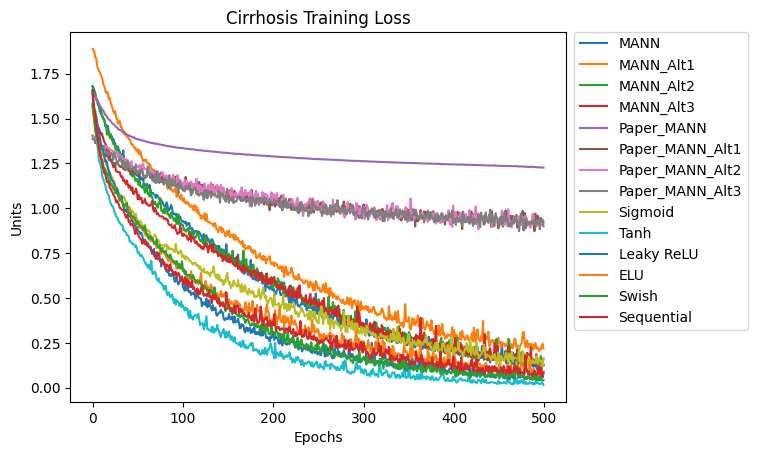

In [44]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Cirrhosis Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

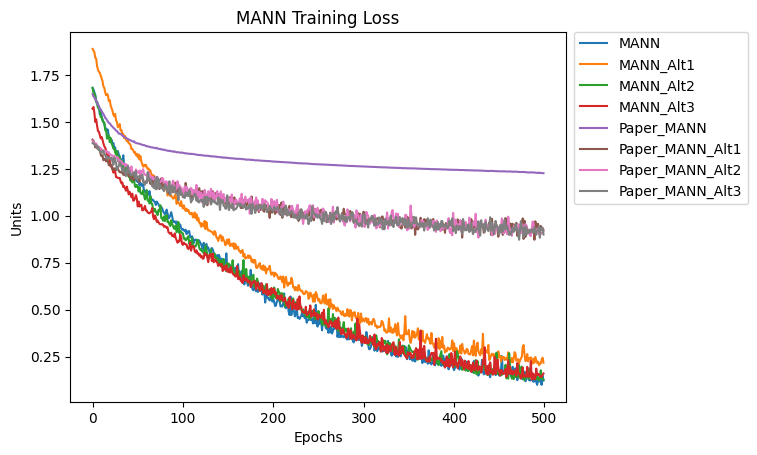

In [45]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')

plt.title('MANN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

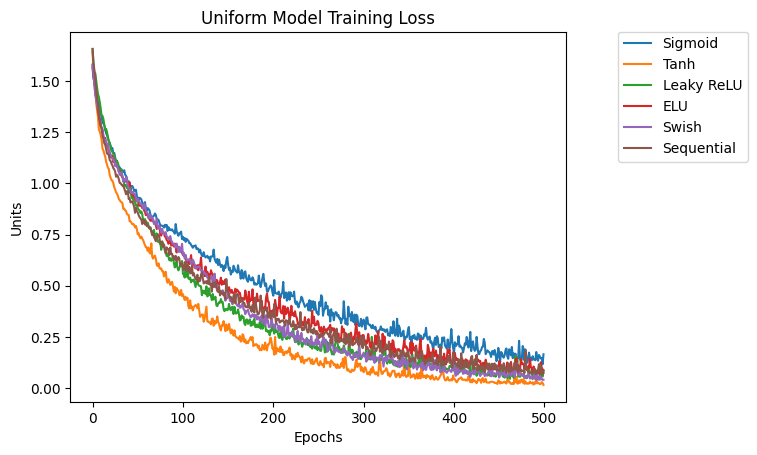

In [46]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Uniform Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

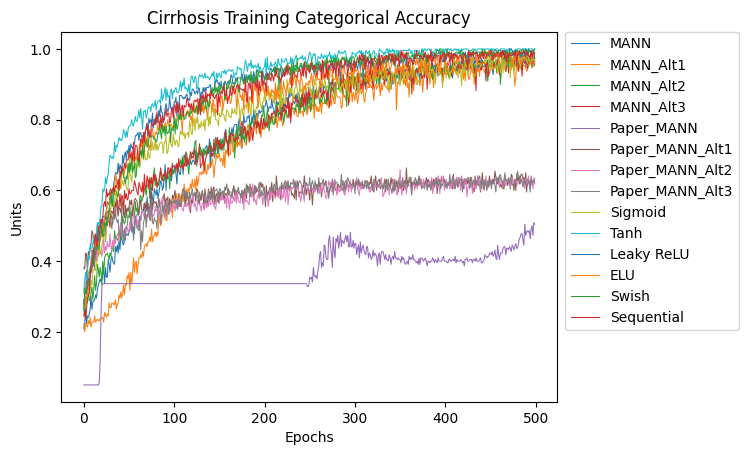

In [47]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Cirrhosis Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

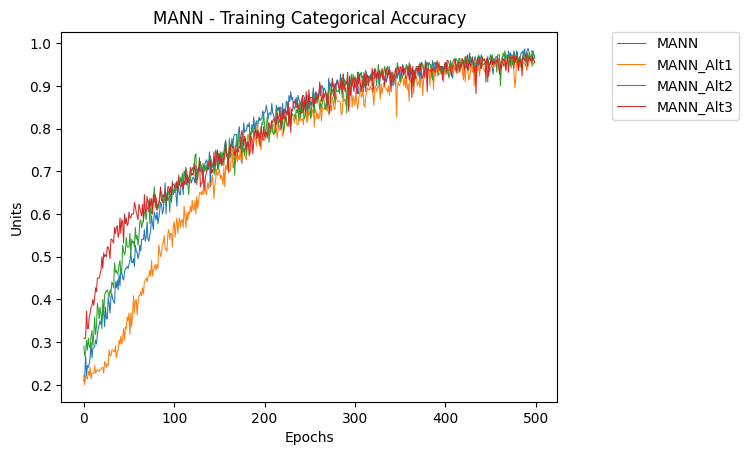

In [48]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

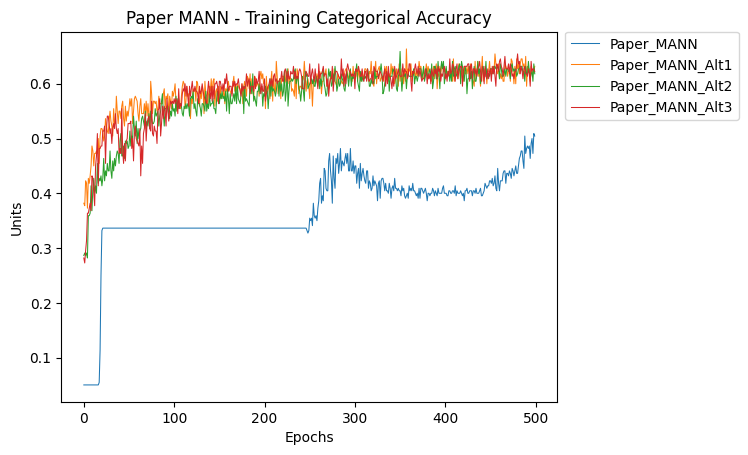

In [49]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

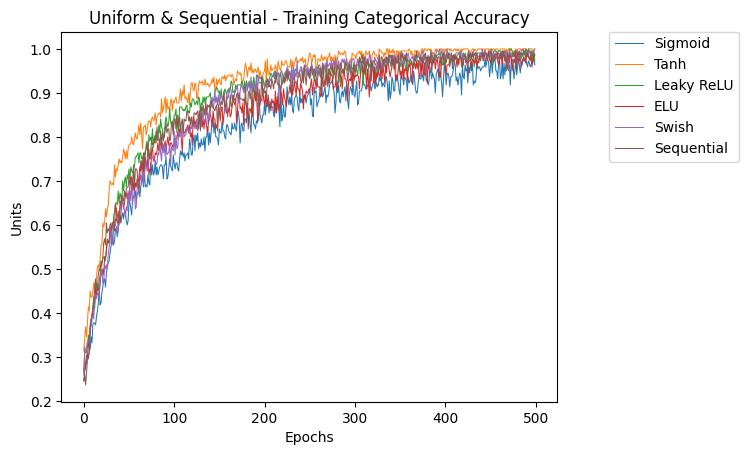

In [50]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

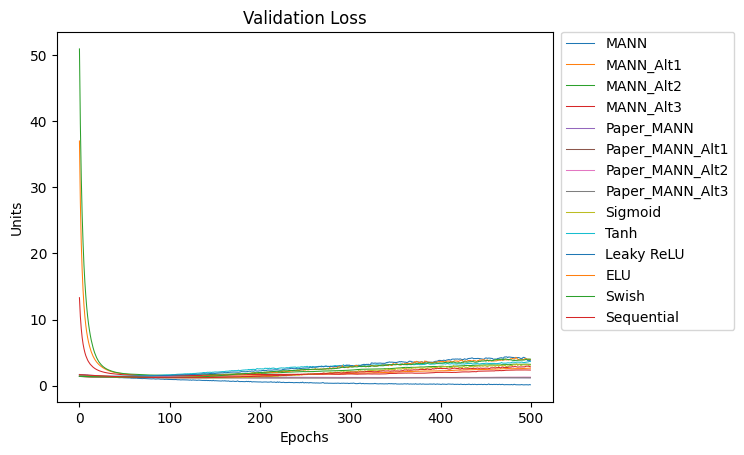

In [51]:
# Plot the validation loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['val_loss'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['val_loss'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['val_loss'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['val_loss'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['val_loss'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['val_loss'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['val_loss'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['val_loss'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['val_loss'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['val_loss'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['val_loss'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['val_loss'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['val_loss'], label='Sequential', linewidth=0.75)

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')
#plt.ylim([0,1.5])
plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

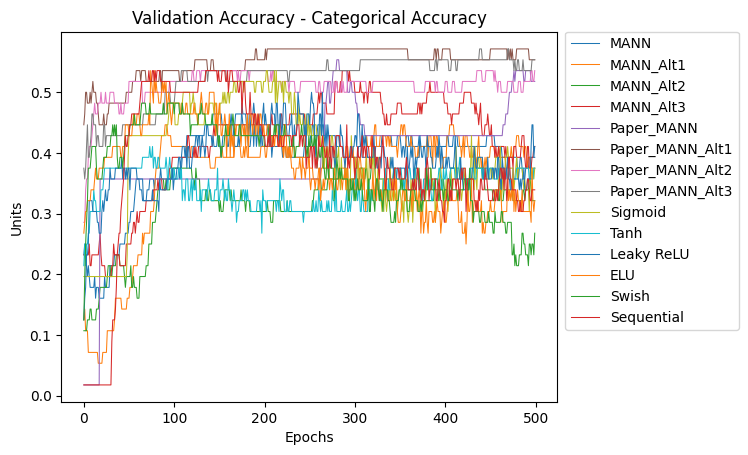

In [52]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Validation Accuracy - Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

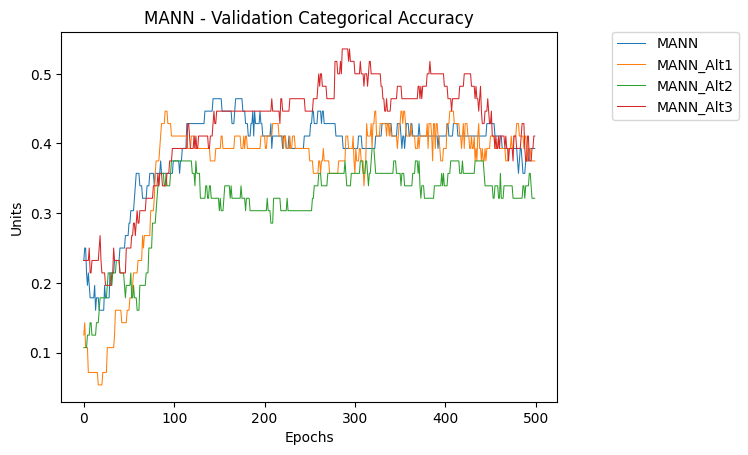

In [53]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

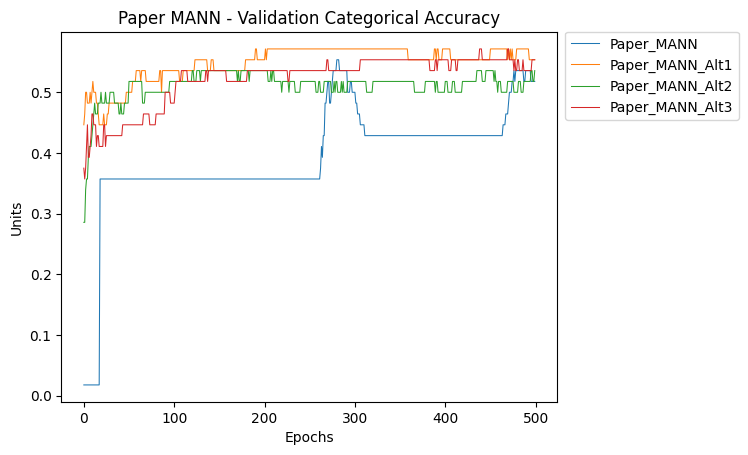

In [54]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

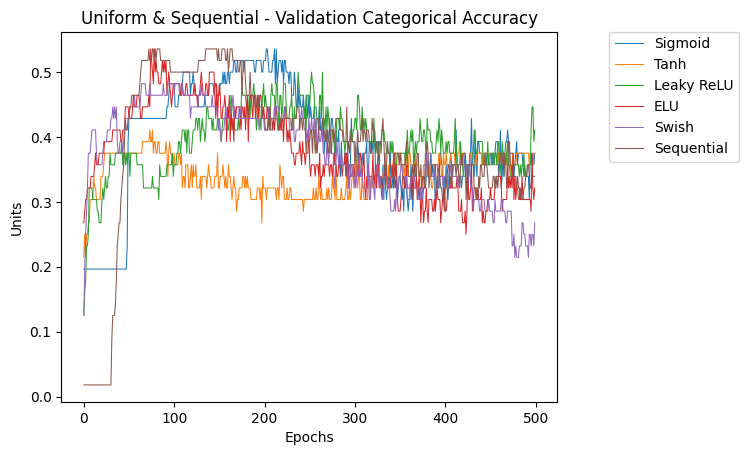

In [55]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

In [56]:
# Save training history
train_hist_df = pd.DataFrame()
val_hist_df = pd.DataFrame()
for name, callback in histories.items():
    train_hist_df = pd.concat((train_hist_df, pd.DataFrame(callback.history['loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    val_hist_df = pd.concat((val_hist_df, pd.DataFrame(callback.history['val_loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    
train_hist_df.to_csv('Binary.training_hist.csv')
val_hist_df.to_csv('Binary.validation_hist.csv')

In [57]:
# Get performance metrics for each model
# Get the testing loss for each model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, one_hot.inverse_transform(y_train).ravel())

metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test.to_numpy(), one_hot.transform(log_reg.predict(X_test).reshape(-1,1)))
log_reg_loss = metric.result().numpy()

MANN_loss = models['MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt1_loss = models['MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt2_loss = models['MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt3_loss = models['MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Paper_MANN_loss = models['Paper_MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt1_loss = models['Paper_MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt2_loss = models['Paper_MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt3_loss = models['Paper_MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sigmoid_loss = models['Sigmoid'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Tanh_loss = models['Tanh'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

LeakyReLU_loss = models['LeakyReLU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

ELU_loss = models['ELU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Swish_loss = models['Swish'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sequential_loss = models['Sequential'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

2/2 [==============================] - 0s 14ms/step - loss: 2.8412 - categorical_accuracy: 0.3393


In [58]:
# Save metrics to a table and display results
# Save testing loss to table and display results
results = pd.DataFrame([MANN_loss, MANN_Alt1_loss, MANN_Alt2_loss, MANN_Alt3_loss, Paper_MANN_loss, Paper_MANN_Alt1_loss, Paper_MANN_Alt2_loss, Paper_MANN_Alt3_loss,Sigmoid_loss, Tanh_loss, LeakyReLU_loss, ELU_loss, Swish_loss, Sequential_loss],
                      index=['MANN', 'MANN_Alt1', 'MANN_Alt2', 'MANN_Alt3', 'Paper MANN', 'Paper Alternate MANN 1', 'Paper Alternate MANN 2', 'Paper Alternate MANN 3', 'Sigmoid NN', 'Tanh NN', 'Leaky ReLU NN', 'ELU NN', 'Swish NN', 'Sequential NN'],
                      columns=['Categorical Accuracy'])
results.sort_values('Categorical Accuracy', inplace=True, ascending=False)
results.head(20)

Categorical Accuracy
Paper Alternate MANN 1              0.553571
Paper Alternate MANN 3              0.553571
Paper Alternate MANN 2              0.535714
Paper MANN                          0.517857
MANN_Alt3                           0.410714
Leaky ReLU NN                       0.410714
MANN                                0.392857
MANN_Alt1                           0.375000
Sigmoid NN                          0.375000
Tanh NN                             0.375000
Sequential NN                       0.339286
MANN_Alt2                           0.321429
ELU NN                              0.321429
Swish NN                            0.267857

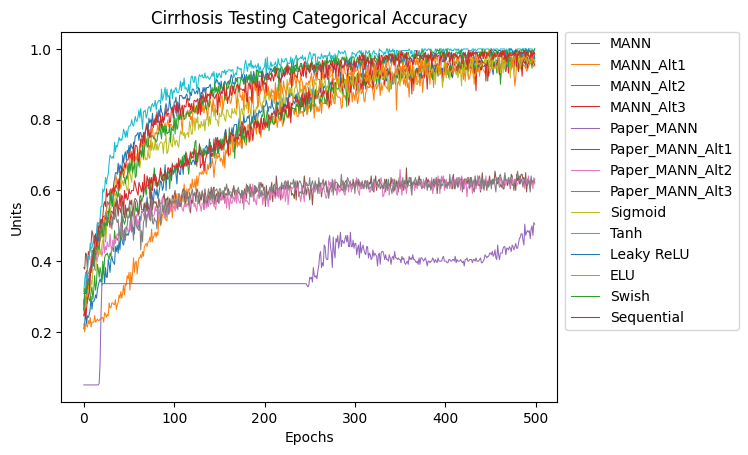

In [59]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Cirrhosis Testing Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

# 

# 

# Pulling HepatitisCdata Prediction Dataset data from the csv

In [60]:
# Load the data and split into testing and training for processing
HepatitisCdata = pd.read_csv('./Datasets/HepatitisCdata.csv')

HepatitisCdata.describe()

Unnamed: 0         Age         ALB         ALP         ALT         AST  \
count  615.000000  615.000000  614.000000  597.000000  614.000000  615.000000   
mean   308.000000   47.408130   41.620195   68.283920   28.450814   34.786341   
std    177.679487   10.055105    5.780629   26.028315   25.469689   33.090690   
min      1.000000   19.000000   14.900000   11.300000    0.900000   10.600000   
25%    154.500000   39.000000   38.800000   52.500000   16.400000   21.600000   
50%    308.000000   47.000000   41.950000   66.200000   23.000000   25.900000   
75%    461.500000   54.000000   45.200000   80.100000   33.075000   32.900000   
max    615.000000   77.000000   82.200000  416.600000  325.300000  324.000000   

              BIL         CHE        CHOL         CREA         GGT        PROT  
count  615.000000  615.000000  605.000000   615.000000  615.000000  614.000000  
mean    11.396748    8.196634    5.368099    81.287805   39.533171   72.044137  
std     19.673150    2.205657    1.132728    49.756166   54.661071    5.402636  
min      0.800000    1.420000    1.430000     8.000000    4.500000   44.800000  
25%      5.300000    6.935000    4.610000    67.000000   15.700000   69.300000  
50%      7.300000    8.260000    5.300000    77.000000   23.300000   72.200000  
75%     11.200000    9.590000    6.060000    88.000000   40.200000   75.400000  
max    254.000000   16.410000    9.670000  1079.100000  650.900000   90.000000

In [61]:
HepatitisCdata.head()

Unnamed: 0       Category  Age Sex   ALB   ALP   ALT   AST   BIL    CHE  \
0           1  0=Blood Donor   32   m  38.5  52.5   7.7  22.1   7.5   6.93   
1           2  0=Blood Donor   32   m  38.5  70.3  18.0  24.7   3.9  11.17   
2           3  0=Blood Donor   32   m  46.9  74.7  36.2  52.6   6.1   8.84   
3           4  0=Blood Donor   32   m  43.2  52.0  30.6  22.6  18.9   7.33   
4           5  0=Blood Donor   32   m  39.2  74.1  32.6  24.8   9.6   9.15   

   CHOL   CREA   GGT  PROT  
0  3.23  106.0  12.1  69.0  
1  4.80   74.0  15.6  76.5  
2  5.20   86.0  33.2  79.3  
3  4.74   80.0  33.8  75.7  
4  4.32   76.0  29.9  68.7

In [62]:
HepatitisCdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [63]:
HepatitisCdata.isnull().sum()

Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64

## Assigning features and targets from dataset

In [71]:
HepatitisCdata = HepatitisCdata.dropna()

In [72]:
features = HepatitisCdata.drop(['Unnamed: 0','Category'], axis=1)

target = HepatitisCdata['Category']

In [73]:
features.head()

Age Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA   GGT  PROT
0   32   m  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0  12.1  69.0
1   32   m  38.5  70.3  18.0  24.7   3.9  11.17  4.80   74.0  15.6  76.5
2   32   m  46.9  74.7  36.2  52.6   6.1   8.84  5.20   86.0  33.2  79.3
3   32   m  43.2  52.0  30.6  22.6  18.9   7.33  4.74   80.0  33.8  75.7
4   32   m  39.2  74.1  32.6  24.8   9.6   9.15  4.32   76.0  29.9  68.7

In [74]:
target.value_counts()

0=Blood Donor             526
3=Cirrhosis                24
1=Hepatitis                20
2=Fibrosis                 12
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [75]:
target = target.replace(regex={'0=Blood Donor': '0', '3=Cirrhosis': '3', '1=Hepatitis':'1', '2=Fibrosis':'2', '0s=suspect Blood Donor':'0'})

In [76]:
target.value_counts()

0    533
3     24
1     20
2     12
Name: Category, dtype: int64

In [77]:
HepatitisCdata.isnull().sum()

Unnamed: 0    0
Category      0
Age           0
Sex           0
ALB           0
ALP           0
ALT           0
AST           0
BIL           0
CHE           0
CHOL          0
CREA          0
GGT           0
PROT          0
dtype: int64

## Training the models

In [78]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

## Normalizing dataset

In [79]:
# Process and normalize the data
one_hot = OneHotEncoder(sparse_output=False)

# One-Hot encode categorical columns
X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Sex']]), columns=one_hot.get_feature_names_out()))
X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Sex']]), columns=one_hot.get_feature_names_out()))

# Drop the transformed columns and unneeded columns
X_train.drop(['Sex'], axis = 1, inplace=True)
X_test.drop(['Sex'], axis=1, inplace=True)



# Normalize numerical columns
scaler = StandardScaler()
X_train[['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT', 'PROT']]= scaler.fit_transform(X_train[['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT', 'PROT']])
X_test[['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT', 'PROT']] = scaler.transform(X_test[['Age','ALB','ALP','ALT','AST','BIL','CHE','CHOL','CREA','GGT', 'PROT']])

C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_44820\2507058565.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.append(pd.DataFrame(data=one_hot.fit_transform(X_train[['Sex']]), columns=one_hot.get_feature_names_out()))
C:\Users\Jaskirat\AppData\Local\Temp\ipykernel_44820\2507058565.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test.append(pd.DataFrame(data=one_hot.transform(X_test[['Sex']]), columns=one_hot.get_feature_names_out()))


In [80]:
# One-Hot encode target labels
y_train = pd.DataFrame(data=one_hot.fit_transform(y_train.to_numpy().reshape(-1,1)), columns=one_hot.categories_)
y_test = pd.DataFrame(data=one_hot.transform(y_test.to_numpy().reshape(-1,1)), columns=one_hot.categories_)

In [81]:
print(one_hot.categories_[0])
print(len(one_hot.categories_[0]))

['0' '1' '2' '3']
4


In [82]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   (0,)    471 non-null    float64
 1   (1,)    471 non-null    float64
 2   (2,)    471 non-null    float64
 3   (3,)    471 non-null    float64
dtypes: float64(4)
memory usage: 14.8 KB


In [83]:
# Create and fit all neural networks for evaluations

models, histories = test(X_train.to_numpy(), y_train.to_numpy(), X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), num_classes=len(one_hot.categories_[0]), task='classification', epochs=250, batch_size=128, task_name='HepatitisC')

Training Multi Activation Neural Network...
Epoch 1/250
4/4 [==============================] - 4s 153ms/step - loss: 1.6045 - categorical_accuracy: 0.2505 - val_loss: 14.3897 - val_categorical_accuracy: 0.8475
Epoch 2/250
4/4 [==============================] - 0s 65ms/step - loss: 1.5851 - categorical_accuracy: 0.2505 - val_loss: 8.9024 - val_categorical_accuracy: 0.8390
Epoch 3/250
4/4 [==============================] - 0s 74ms/step - loss: 1.5587 - categorical_accuracy: 0.2527 - val_loss: 6.0340 - val_categorical_accuracy: 0.8051
Epoch 4/250
4/4 [==============================] - 0s 80ms/step - loss: 1.5340 - categorical_accuracy: 0.2569 - val_loss: 4.3395 - val_categorical_accuracy: 0.7966
Epoch 5/250
4/4 [==============================] - 0s 77ms/step - loss: 1.5196 - categorical_accuracy: 0.2569 - val_loss: 3.2916 - val_categorical_accuracy: 0.7797
Epoch 6/250
4/4 [==============================] - 1s 199ms/step - loss: 1.4942 - categorical_accuracy: 0.2633 - val_loss: 2.6383 - va

4/4 [==============================] - 0s 108ms/step - loss: 0.7875 - categorical_accuracy: 0.8747 - val_loss: 0.7235 - val_categorical_accuracy: 0.8475
Epoch 51/250
4/4 [==============================] - 0s 84ms/step - loss: 0.7679 - categorical_accuracy: 0.8981 - val_loss: 0.7098 - val_categorical_accuracy: 0.8390
Epoch 52/250
4/4 [==============================] - 0s 68ms/step - loss: 0.7522 - categorical_accuracy: 0.9066 - val_loss: 0.6980 - val_categorical_accuracy: 0.8559
Epoch 53/250
4/4 [==============================] - 0s 69ms/step - loss: 0.7563 - categorical_accuracy: 0.8896 - val_loss: 0.6873 - val_categorical_accuracy: 0.8559
Epoch 54/250
4/4 [==============================] - 0s 69ms/step - loss: 0.7361 - categorical_accuracy: 0.8960 - val_loss: 0.6753 - val_categorical_accuracy: 0.8644
Epoch 55/250
4/4 [==============================] - 0s 78ms/step - loss: 0.7074 - categorical_accuracy: 0.9193 - val_loss: 0.6621 - val_categorical_accuracy: 0.8644
Epoch 56/250
4/4 [====

Epoch 100/250
4/4 [==============================] - 0s 61ms/step - loss: 0.2767 - categorical_accuracy: 0.9533 - val_loss: 0.4017 - val_categorical_accuracy: 0.9068
Epoch 101/250
4/4 [==============================] - 0s 51ms/step - loss: 0.2754 - categorical_accuracy: 0.9575 - val_loss: 0.3992 - val_categorical_accuracy: 0.9068
Epoch 102/250
4/4 [==============================] - 0s 53ms/step - loss: 0.2767 - categorical_accuracy: 0.9533 - val_loss: 0.3979 - val_categorical_accuracy: 0.8983
Epoch 103/250
4/4 [==============================] - 0s 52ms/step - loss: 0.2630 - categorical_accuracy: 0.9554 - val_loss: 0.3974 - val_categorical_accuracy: 0.8983
Epoch 104/250
4/4 [==============================] - 0s 52ms/step - loss: 0.2627 - categorical_accuracy: 0.9533 - val_loss: 0.3962 - val_categorical_accuracy: 0.8898
Epoch 105/250
4/4 [==============================] - 0s 55ms/step - loss: 0.2566 - categorical_accuracy: 0.9575 - val_loss: 0.3953 - val_categorical_accuracy: 0.8898
Epoc

4/4 [==============================] - 0s 59ms/step - loss: 0.1419 - categorical_accuracy: 0.9703 - val_loss: 0.3352 - val_categorical_accuracy: 0.8898
Epoch 150/250
4/4 [==============================] - 0s 79ms/step - loss: 0.1459 - categorical_accuracy: 0.9618 - val_loss: 0.3341 - val_categorical_accuracy: 0.8898
Epoch 151/250
4/4 [==============================] - 0s 70ms/step - loss: 0.1384 - categorical_accuracy: 0.9660 - val_loss: 0.3334 - val_categorical_accuracy: 0.8898
Epoch 152/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1480 - categorical_accuracy: 0.9703 - val_loss: 0.3303 - val_categorical_accuracy: 0.8898
Epoch 153/250
4/4 [==============================] - 0s 59ms/step - loss: 0.1359 - categorical_accuracy: 0.9724 - val_loss: 0.3303 - val_categorical_accuracy: 0.8814
Epoch 154/250
4/4 [==============================] - 0s 61ms/step - loss: 0.1390 - categorical_accuracy: 0.9660 - val_loss: 0.3301 - val_categorical_accuracy: 0.8814
Epoch 155/250
4/4 

4/4 [==============================] - 0s 46ms/step - loss: 0.0989 - categorical_accuracy: 0.9809 - val_loss: 0.3223 - val_categorical_accuracy: 0.8814
Epoch 199/250
4/4 [==============================] - 0s 103ms/step - loss: 0.1003 - categorical_accuracy: 0.9724 - val_loss: 0.3220 - val_categorical_accuracy: 0.8814
Epoch 200/250
4/4 [==============================] - 0s 76ms/step - loss: 0.0989 - categorical_accuracy: 0.9745 - val_loss: 0.3215 - val_categorical_accuracy: 0.8814
Epoch 201/250
4/4 [==============================] - 0s 75ms/step - loss: 0.1220 - categorical_accuracy: 0.9639 - val_loss: 0.3194 - val_categorical_accuracy: 0.8814
Epoch 202/250
4/4 [==============================] - 0s 70ms/step - loss: 0.1004 - categorical_accuracy: 0.9724 - val_loss: 0.3195 - val_categorical_accuracy: 0.8814
Epoch 203/250
4/4 [==============================] - 0s 60ms/step - loss: 0.0940 - categorical_accuracy: 0.9766 - val_loss: 0.3192 - val_categorical_accuracy: 0.8814
Epoch 204/250
4/4

4/4 [==============================] - 0s 59ms/step - loss: 0.0707 - categorical_accuracy: 0.9809 - val_loss: 0.3484 - val_categorical_accuracy: 0.8983
Epoch 248/250
4/4 [==============================] - 0s 53ms/step - loss: 0.0766 - categorical_accuracy: 0.9809 - val_loss: 0.3497 - val_categorical_accuracy: 0.8983
Epoch 249/250
4/4 [==============================] - 0s 58ms/step - loss: 0.1005 - categorical_accuracy: 0.9724 - val_loss: 0.3511 - val_categorical_accuracy: 0.8983
Epoch 250/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0792 - categorical_accuracy: 0.9766 - val_loss: 0.3508 - val_categorical_accuracy: 0.9068
INFO:tensorflow:Assets written to: ./Models/HepatitisC/MANN\assets
Training Complete
Epoch 1/250
4/4 [==============================] - 3s 194ms/step - loss: 1.9389 - categorical_accuracy: 0.3079 - val_loss: 2.8981 - val_categorical_accuracy: 0.4661
Epoch 2/250
4/4 [==============================] - 0s 76ms/step - loss: 1.9181 - categorical_accurac

4/4 [==============================] - 0s 76ms/step - loss: 0.8325 - categorical_accuracy: 0.7749 - val_loss: 0.7714 - val_categorical_accuracy: 0.7288
Epoch 47/250
4/4 [==============================] - 0s 79ms/step - loss: 0.8047 - categorical_accuracy: 0.7749 - val_loss: 0.7556 - val_categorical_accuracy: 0.7542
Epoch 48/250
4/4 [==============================] - 0s 79ms/step - loss: 0.7883 - categorical_accuracy: 0.7898 - val_loss: 0.7414 - val_categorical_accuracy: 0.8051
Epoch 49/250
4/4 [==============================] - 0s 78ms/step - loss: 0.7818 - categorical_accuracy: 0.8238 - val_loss: 0.7318 - val_categorical_accuracy: 0.8051
Epoch 50/250
4/4 [==============================] - 0s 77ms/step - loss: 0.7510 - categorical_accuracy: 0.8429 - val_loss: 0.7185 - val_categorical_accuracy: 0.8136
Epoch 51/250
4/4 [==============================] - 0s 77ms/step - loss: 0.7419 - categorical_accuracy: 0.8556 - val_loss: 0.7054 - val_categorical_accuracy: 0.8305
Epoch 52/250
4/4 [=====

Epoch 96/250
4/4 [==============================] - 0s 63ms/step - loss: 0.2909 - categorical_accuracy: 0.9639 - val_loss: 0.3489 - val_categorical_accuracy: 0.9068
Epoch 97/250
4/4 [==============================] - 0s 73ms/step - loss: 0.2798 - categorical_accuracy: 0.9639 - val_loss: 0.3445 - val_categorical_accuracy: 0.9068
Epoch 98/250
4/4 [==============================] - 0s 54ms/step - loss: 0.2782 - categorical_accuracy: 0.9682 - val_loss: 0.3408 - val_categorical_accuracy: 0.9068
Epoch 99/250
4/4 [==============================] - 0s 55ms/step - loss: 0.2890 - categorical_accuracy: 0.9597 - val_loss: 0.3371 - val_categorical_accuracy: 0.9068
Epoch 100/250
4/4 [==============================] - 0s 54ms/step - loss: 0.2832 - categorical_accuracy: 0.9533 - val_loss: 0.3326 - val_categorical_accuracy: 0.9068
Epoch 101/250
4/4 [==============================] - 0s 54ms/step - loss: 0.2753 - categorical_accuracy: 0.9618 - val_loss: 0.3287 - val_categorical_accuracy: 0.9153
Epoch 10

4/4 [==============================] - 0s 66ms/step - loss: 0.1517 - categorical_accuracy: 0.9788 - val_loss: 0.2288 - val_categorical_accuracy: 0.9407
Epoch 146/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1401 - categorical_accuracy: 0.9788 - val_loss: 0.2280 - val_categorical_accuracy: 0.9407
Epoch 147/250
4/4 [==============================] - 0s 67ms/step - loss: 0.1381 - categorical_accuracy: 0.9660 - val_loss: 0.2269 - val_categorical_accuracy: 0.9322
Epoch 148/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1417 - categorical_accuracy: 0.9703 - val_loss: 0.2262 - val_categorical_accuracy: 0.9407
Epoch 149/250
4/4 [==============================] - 0s 75ms/step - loss: 0.1446 - categorical_accuracy: 0.9809 - val_loss: 0.2251 - val_categorical_accuracy: 0.9407
Epoch 150/250
4/4 [==============================] - 0s 66ms/step - loss: 0.1372 - categorical_accuracy: 0.9809 - val_loss: 0.2243 - val_categorical_accuracy: 0.9407
Epoch 151/250
4/4 

4/4 [==============================] - 0s 43ms/step - loss: 0.0975 - categorical_accuracy: 0.9766 - val_loss: 0.1968 - val_categorical_accuracy: 0.9322
Epoch 195/250
4/4 [==============================] - 0s 43ms/step - loss: 0.1088 - categorical_accuracy: 0.9703 - val_loss: 0.1975 - val_categorical_accuracy: 0.9322
Epoch 196/250
4/4 [==============================] - 0s 43ms/step - loss: 0.0927 - categorical_accuracy: 0.9809 - val_loss: 0.1976 - val_categorical_accuracy: 0.9322
Epoch 197/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0964 - categorical_accuracy: 0.9724 - val_loss: 0.1979 - val_categorical_accuracy: 0.9322
Epoch 198/250
4/4 [==============================] - 0s 56ms/step - loss: 0.0985 - categorical_accuracy: 0.9745 - val_loss: 0.1981 - val_categorical_accuracy: 0.9322
Epoch 199/250
4/4 [==============================] - 0s 44ms/step - loss: 0.1049 - categorical_accuracy: 0.9745 - val_loss: 0.1965 - val_categorical_accuracy: 0.9322
Epoch 200/250
4/4 

4/4 [==============================] - 0s 45ms/step - loss: 0.0742 - categorical_accuracy: 0.9830 - val_loss: 0.1806 - val_categorical_accuracy: 0.9153
Epoch 244/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0739 - categorical_accuracy: 0.9788 - val_loss: 0.1805 - val_categorical_accuracy: 0.9237
Epoch 245/250
4/4 [==============================] - 0s 46ms/step - loss: 0.0756 - categorical_accuracy: 0.9766 - val_loss: 0.1801 - val_categorical_accuracy: 0.9153
Epoch 246/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0630 - categorical_accuracy: 0.9809 - val_loss: 0.1807 - val_categorical_accuracy: 0.9153
Epoch 247/250
4/4 [==============================] - 0s 45ms/step - loss: 0.0668 - categorical_accuracy: 0.9809 - val_loss: 0.1806 - val_categorical_accuracy: 0.9153
Epoch 248/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0664 - categorical_accuracy: 0.9809 - val_loss: 0.1804 - val_categorical_accuracy: 0.9153
Epoch 249/250
4/4 

4/4 [==============================] - 0s 92ms/step - loss: 0.9126 - categorical_accuracy: 0.7304 - val_loss: 0.7217 - val_categorical_accuracy: 0.8220
Epoch 43/250
4/4 [==============================] - 0s 73ms/step - loss: 0.9052 - categorical_accuracy: 0.7240 - val_loss: 0.7152 - val_categorical_accuracy: 0.8220
Epoch 44/250
4/4 [==============================] - 0s 66ms/step - loss: 0.8821 - categorical_accuracy: 0.7537 - val_loss: 0.7089 - val_categorical_accuracy: 0.8390
Epoch 45/250
4/4 [==============================] - 0s 64ms/step - loss: 0.8771 - categorical_accuracy: 0.7686 - val_loss: 0.7047 - val_categorical_accuracy: 0.8390
Epoch 46/250
4/4 [==============================] - 0s 70ms/step - loss: 0.8453 - categorical_accuracy: 0.7771 - val_loss: 0.6997 - val_categorical_accuracy: 0.8475
Epoch 47/250
4/4 [==============================] - 0s 70ms/step - loss: 0.8427 - categorical_accuracy: 0.7813 - val_loss: 0.6917 - val_categorical_accuracy: 0.8559
Epoch 48/250
4/4 [=====

Epoch 92/250
4/4 [==============================] - 0s 68ms/step - loss: 0.3540 - categorical_accuracy: 0.9554 - val_loss: 0.4054 - val_categorical_accuracy: 0.9068
Epoch 93/250
4/4 [==============================] - 0s 82ms/step - loss: 0.3489 - categorical_accuracy: 0.9597 - val_loss: 0.4030 - val_categorical_accuracy: 0.8983
Epoch 94/250
4/4 [==============================] - 0s 68ms/step - loss: 0.3334 - categorical_accuracy: 0.9575 - val_loss: 0.3999 - val_categorical_accuracy: 0.9068
Epoch 95/250
4/4 [==============================] - 0s 68ms/step - loss: 0.3342 - categorical_accuracy: 0.9597 - val_loss: 0.3964 - val_categorical_accuracy: 0.9068
Epoch 96/250
4/4 [==============================] - 0s 63ms/step - loss: 0.3287 - categorical_accuracy: 0.9512 - val_loss: 0.3930 - val_categorical_accuracy: 0.9153
Epoch 97/250
4/4 [==============================] - 0s 61ms/step - loss: 0.3267 - categorical_accuracy: 0.9512 - val_loss: 0.3899 - val_categorical_accuracy: 0.9153
Epoch 98/2

4/4 [==============================] - 0s 64ms/step - loss: 0.1735 - categorical_accuracy: 0.9703 - val_loss: 0.3219 - val_categorical_accuracy: 0.9068
Epoch 142/250
4/4 [==============================] - 0s 64ms/step - loss: 0.1793 - categorical_accuracy: 0.9618 - val_loss: 0.3200 - val_categorical_accuracy: 0.9068
Epoch 143/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1717 - categorical_accuracy: 0.9639 - val_loss: 0.3192 - val_categorical_accuracy: 0.9068
Epoch 144/250
4/4 [==============================] - 0s 72ms/step - loss: 0.1758 - categorical_accuracy: 0.9682 - val_loss: 0.3181 - val_categorical_accuracy: 0.9068
Epoch 145/250
4/4 [==============================] - 0s 67ms/step - loss: 0.1758 - categorical_accuracy: 0.9575 - val_loss: 0.3181 - val_categorical_accuracy: 0.9068
Epoch 146/250
4/4 [==============================] - 0s 90ms/step - loss: 0.1661 - categorical_accuracy: 0.9639 - val_loss: 0.3172 - val_categorical_accuracy: 0.9068
Epoch 147/250
4/4 

4/4 [==============================] - 0s 53ms/step - loss: 0.1138 - categorical_accuracy: 0.9809 - val_loss: 0.2971 - val_categorical_accuracy: 0.9322
Epoch 191/250
4/4 [==============================] - 0s 79ms/step - loss: 0.1090 - categorical_accuracy: 0.9724 - val_loss: 0.2975 - val_categorical_accuracy: 0.9322
Epoch 192/250
4/4 [==============================] - 0s 66ms/step - loss: 0.1142 - categorical_accuracy: 0.9682 - val_loss: 0.2984 - val_categorical_accuracy: 0.9322
Epoch 193/250
4/4 [==============================] - 0s 56ms/step - loss: 0.1152 - categorical_accuracy: 0.9766 - val_loss: 0.2996 - val_categorical_accuracy: 0.9322
Epoch 194/250
4/4 [==============================] - 0s 46ms/step - loss: 0.1139 - categorical_accuracy: 0.9788 - val_loss: 0.3007 - val_categorical_accuracy: 0.9322
Epoch 195/250
4/4 [==============================] - 0s 51ms/step - loss: 0.1130 - categorical_accuracy: 0.9788 - val_loss: 0.3019 - val_categorical_accuracy: 0.9322
Epoch 196/250
4/4 

4/4 [==============================] - 0s 62ms/step - loss: 0.0913 - categorical_accuracy: 0.9809 - val_loss: 0.2927 - val_categorical_accuracy: 0.9322
Epoch 240/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0864 - categorical_accuracy: 0.9830 - val_loss: 0.2923 - val_categorical_accuracy: 0.9322
Epoch 241/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0918 - categorical_accuracy: 0.9766 - val_loss: 0.2917 - val_categorical_accuracy: 0.9322
Epoch 242/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0817 - categorical_accuracy: 0.9873 - val_loss: 0.2904 - val_categorical_accuracy: 0.9322
Epoch 243/250
4/4 [==============================] - 0s 55ms/step - loss: 0.0945 - categorical_accuracy: 0.9766 - val_loss: 0.2883 - val_categorical_accuracy: 0.9322
Epoch 244/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0956 - categorical_accuracy: 0.9724 - val_loss: 0.2865 - val_categorical_accuracy: 0.9322
Epoch 245/250
4/4 

4/4 [==============================] - 0s 76ms/step - loss: 0.9405 - categorical_accuracy: 0.7792 - val_loss: 1.1335 - val_categorical_accuracy: 0.6271
Epoch 39/250
4/4 [==============================] - 0s 70ms/step - loss: 0.9315 - categorical_accuracy: 0.7834 - val_loss: 1.1064 - val_categorical_accuracy: 0.6356
Epoch 40/250
4/4 [==============================] - 0s 78ms/step - loss: 0.9212 - categorical_accuracy: 0.7707 - val_loss: 1.0791 - val_categorical_accuracy: 0.6441
Epoch 41/250
4/4 [==============================] - 0s 69ms/step - loss: 0.9179 - categorical_accuracy: 0.7749 - val_loss: 1.0526 - val_categorical_accuracy: 0.6525
Epoch 42/250
4/4 [==============================] - 0s 67ms/step - loss: 0.8830 - categorical_accuracy: 0.8238 - val_loss: 1.0255 - val_categorical_accuracy: 0.6949
Epoch 43/250
4/4 [==============================] - 0s 74ms/step - loss: 0.8703 - categorical_accuracy: 0.7898 - val_loss: 1.0002 - val_categorical_accuracy: 0.7203
Epoch 44/250
4/4 [=====

Epoch 88/250
4/4 [==============================] - 0s 78ms/step - loss: 0.3227 - categorical_accuracy: 0.9639 - val_loss: 0.3748 - val_categorical_accuracy: 0.9068
Epoch 89/250
4/4 [==============================] - 0s 75ms/step - loss: 0.3298 - categorical_accuracy: 0.9406 - val_loss: 0.3705 - val_categorical_accuracy: 0.9068
Epoch 90/250
4/4 [==============================] - 0s 66ms/step - loss: 0.3100 - categorical_accuracy: 0.9618 - val_loss: 0.3672 - val_categorical_accuracy: 0.9153
Epoch 91/250
4/4 [==============================] - 0s 68ms/step - loss: 0.3165 - categorical_accuracy: 0.9575 - val_loss: 0.3634 - val_categorical_accuracy: 0.9153
Epoch 92/250
4/4 [==============================] - 0s 65ms/step - loss: 0.3090 - categorical_accuracy: 0.9575 - val_loss: 0.3598 - val_categorical_accuracy: 0.9068
Epoch 93/250
4/4 [==============================] - 0s 71ms/step - loss: 0.2825 - categorical_accuracy: 0.9639 - val_loss: 0.3552 - val_categorical_accuracy: 0.9068
Epoch 94/2

4/4 [==============================] - 0s 57ms/step - loss: 0.1336 - categorical_accuracy: 0.9766 - val_loss: 0.2921 - val_categorical_accuracy: 0.9153
Epoch 138/250
4/4 [==============================] - 0s 68ms/step - loss: 0.1271 - categorical_accuracy: 0.9766 - val_loss: 0.2908 - val_categorical_accuracy: 0.9153
Epoch 139/250
4/4 [==============================] - 0s 69ms/step - loss: 0.1403 - categorical_accuracy: 0.9703 - val_loss: 0.2900 - val_categorical_accuracy: 0.9153
Epoch 140/250
4/4 [==============================] - 0s 70ms/step - loss: 0.1219 - categorical_accuracy: 0.9766 - val_loss: 0.2899 - val_categorical_accuracy: 0.9153
Epoch 141/250
4/4 [==============================] - 0s 67ms/step - loss: 0.1373 - categorical_accuracy: 0.9703 - val_loss: 0.2892 - val_categorical_accuracy: 0.9153
Epoch 142/250
4/4 [==============================] - 0s 72ms/step - loss: 0.1258 - categorical_accuracy: 0.9724 - val_loss: 0.2888 - val_categorical_accuracy: 0.9153
Epoch 143/250
4/4 

4/4 [==============================] - 0s 49ms/step - loss: 0.0943 - categorical_accuracy: 0.9766 - val_loss: 0.2741 - val_categorical_accuracy: 0.9153
Epoch 187/250
4/4 [==============================] - 0s 50ms/step - loss: 0.0839 - categorical_accuracy: 0.9788 - val_loss: 0.2755 - val_categorical_accuracy: 0.9153
Epoch 188/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0763 - categorical_accuracy: 0.9830 - val_loss: 0.2751 - val_categorical_accuracy: 0.9153
Epoch 189/250
4/4 [==============================] - 0s 50ms/step - loss: 0.0886 - categorical_accuracy: 0.9766 - val_loss: 0.2743 - val_categorical_accuracy: 0.9153
Epoch 190/250
4/4 [==============================] - 0s 59ms/step - loss: 0.0802 - categorical_accuracy: 0.9788 - val_loss: 0.2730 - val_categorical_accuracy: 0.9153
Epoch 191/250
4/4 [==============================] - 0s 58ms/step - loss: 0.0858 - categorical_accuracy: 0.9724 - val_loss: 0.2727 - val_categorical_accuracy: 0.9153
Epoch 192/250
4/4 

4/4 [==============================] - 0s 52ms/step - loss: 0.0605 - categorical_accuracy: 0.9809 - val_loss: 0.2669 - val_categorical_accuracy: 0.9237
Epoch 236/250
4/4 [==============================] - 0s 53ms/step - loss: 0.0555 - categorical_accuracy: 0.9809 - val_loss: 0.2681 - val_categorical_accuracy: 0.9237
Epoch 237/250
4/4 [==============================] - 0s 47ms/step - loss: 0.0569 - categorical_accuracy: 0.9788 - val_loss: 0.2673 - val_categorical_accuracy: 0.9237
Epoch 238/250
4/4 [==============================] - 0s 52ms/step - loss: 0.0517 - categorical_accuracy: 0.9830 - val_loss: 0.2674 - val_categorical_accuracy: 0.9237
Epoch 239/250
4/4 [==============================] - 0s 50ms/step - loss: 0.0861 - categorical_accuracy: 0.9745 - val_loss: 0.2716 - val_categorical_accuracy: 0.9237
Epoch 240/250
4/4 [==============================] - 0s 56ms/step - loss: 0.0546 - categorical_accuracy: 0.9830 - val_loss: 0.2705 - val_categorical_accuracy: 0.9237
Epoch 241/250
4/4 

Epoch 34/250
4/4 [==============================] - 0s 29ms/step - loss: 1.2320 - categorical_accuracy: 0.9172 - val_loss: 1.2451 - val_categorical_accuracy: 0.8559
Epoch 35/250
4/4 [==============================] - 0s 34ms/step - loss: 1.2272 - categorical_accuracy: 0.9172 - val_loss: 1.2405 - val_categorical_accuracy: 0.8559
Epoch 36/250
4/4 [==============================] - 0s 35ms/step - loss: 1.2222 - categorical_accuracy: 0.9172 - val_loss: 1.2359 - val_categorical_accuracy: 0.8559
Epoch 37/250
4/4 [==============================] - 0s 30ms/step - loss: 1.2172 - categorical_accuracy: 0.9172 - val_loss: 1.2314 - val_categorical_accuracy: 0.8559
Epoch 38/250
4/4 [==============================] - 0s 35ms/step - loss: 1.2122 - categorical_accuracy: 0.9172 - val_loss: 1.2269 - val_categorical_accuracy: 0.8559
Epoch 39/250
4/4 [==============================] - 0s 28ms/step - loss: 1.2071 - categorical_accuracy: 0.9172 - val_loss: 1.2225 - val_categorical_accuracy: 0.8559
Epoch 40/2

Epoch 84/250
4/4 [==============================] - 0s 39ms/step - loss: 1.0131 - categorical_accuracy: 0.9172 - val_loss: 1.0498 - val_categorical_accuracy: 0.8559
Epoch 85/250
4/4 [==============================] - 0s 38ms/step - loss: 1.0090 - categorical_accuracy: 0.9172 - val_loss: 1.0464 - val_categorical_accuracy: 0.8559
Epoch 86/250
4/4 [==============================] - 0s 39ms/step - loss: 1.0052 - categorical_accuracy: 0.9172 - val_loss: 1.0431 - val_categorical_accuracy: 0.8559
Epoch 87/250
4/4 [==============================] - 0s 34ms/step - loss: 1.0017 - categorical_accuracy: 0.9172 - val_loss: 1.0397 - val_categorical_accuracy: 0.8559
Epoch 88/250
4/4 [==============================] - 0s 31ms/step - loss: 0.9979 - categorical_accuracy: 0.9172 - val_loss: 1.0364 - val_categorical_accuracy: 0.8559
Epoch 89/250
4/4 [==============================] - 0s 33ms/step - loss: 0.9940 - categorical_accuracy: 0.9172 - val_loss: 1.0331 - val_categorical_accuracy: 0.8559
Epoch 90/2

4/4 [==============================] - 0s 39ms/step - loss: 0.8476 - categorical_accuracy: 0.9172 - val_loss: 0.9055 - val_categorical_accuracy: 0.8559
Epoch 134/250
4/4 [==============================] - 0s 36ms/step - loss: 0.8446 - categorical_accuracy: 0.9172 - val_loss: 0.9029 - val_categorical_accuracy: 0.8559
Epoch 135/250
4/4 [==============================] - 0s 41ms/step - loss: 0.8417 - categorical_accuracy: 0.9172 - val_loss: 0.9004 - val_categorical_accuracy: 0.8559
Epoch 136/250
4/4 [==============================] - 0s 37ms/step - loss: 0.8386 - categorical_accuracy: 0.9172 - val_loss: 0.8979 - val_categorical_accuracy: 0.8559
Epoch 137/250
4/4 [==============================] - 0s 30ms/step - loss: 0.8357 - categorical_accuracy: 0.9172 - val_loss: 0.8954 - val_categorical_accuracy: 0.8559
Epoch 138/250
4/4 [==============================] - 0s 33ms/step - loss: 0.8328 - categorical_accuracy: 0.9172 - val_loss: 0.8929 - val_categorical_accuracy: 0.8559
Epoch 139/250
4/4 

4/4 [==============================] - 0s 42ms/step - loss: 0.7211 - categorical_accuracy: 0.9172 - val_loss: 0.7982 - val_categorical_accuracy: 0.8559
Epoch 183/250
4/4 [==============================] - 0s 36ms/step - loss: 0.7188 - categorical_accuracy: 0.9172 - val_loss: 0.7964 - val_categorical_accuracy: 0.8559
Epoch 184/250
4/4 [==============================] - 0s 29ms/step - loss: 0.7166 - categorical_accuracy: 0.9172 - val_loss: 0.7945 - val_categorical_accuracy: 0.8559
Epoch 185/250
4/4 [==============================] - 0s 35ms/step - loss: 0.7143 - categorical_accuracy: 0.9172 - val_loss: 0.7927 - val_categorical_accuracy: 0.8559
Epoch 186/250
4/4 [==============================] - 0s 38ms/step - loss: 0.7122 - categorical_accuracy: 0.9172 - val_loss: 0.7908 - val_categorical_accuracy: 0.8559
Epoch 187/250
4/4 [==============================] - 0s 32ms/step - loss: 0.7101 - categorical_accuracy: 0.9172 - val_loss: 0.7890 - val_categorical_accuracy: 0.8559
Epoch 188/250
4/4 

4/4 [==============================] - 0s 31ms/step - loss: 0.6264 - categorical_accuracy: 0.9172 - val_loss: 0.7209 - val_categorical_accuracy: 0.8559
Epoch 232/250
4/4 [==============================] - 0s 29ms/step - loss: 0.6248 - categorical_accuracy: 0.9172 - val_loss: 0.7196 - val_categorical_accuracy: 0.8559
Epoch 233/250
4/4 [==============================] - 0s 36ms/step - loss: 0.6232 - categorical_accuracy: 0.9172 - val_loss: 0.7183 - val_categorical_accuracy: 0.8559
Epoch 234/250
4/4 [==============================] - 0s 35ms/step - loss: 0.6216 - categorical_accuracy: 0.9172 - val_loss: 0.7170 - val_categorical_accuracy: 0.8559
Epoch 235/250
4/4 [==============================] - 0s 42ms/step - loss: 0.6199 - categorical_accuracy: 0.9172 - val_loss: 0.7157 - val_categorical_accuracy: 0.8559
Epoch 236/250
4/4 [==============================] - 0s 28ms/step - loss: 0.6183 - categorical_accuracy: 0.9172 - val_loss: 0.7144 - val_categorical_accuracy: 0.8559
Epoch 237/250
4/4 

Epoch 30/250
4/4 [==============================] - 0s 30ms/step - loss: 0.2513 - categorical_accuracy: 0.9384 - val_loss: 0.2937 - val_categorical_accuracy: 0.9068
Epoch 31/250
4/4 [==============================] - 0s 31ms/step - loss: 0.2535 - categorical_accuracy: 0.9469 - val_loss: 0.2885 - val_categorical_accuracy: 0.9068
Epoch 32/250
4/4 [==============================] - 0s 29ms/step - loss: 0.2676 - categorical_accuracy: 0.9490 - val_loss: 0.2844 - val_categorical_accuracy: 0.9068
Epoch 33/250
4/4 [==============================] - 0s 29ms/step - loss: 0.2162 - categorical_accuracy: 0.9490 - val_loss: 0.2806 - val_categorical_accuracy: 0.9068
Epoch 34/250
4/4 [==============================] - 0s 35ms/step - loss: 0.2125 - categorical_accuracy: 0.9512 - val_loss: 0.2769 - val_categorical_accuracy: 0.9068
Epoch 35/250
4/4 [==============================] - 0s 32ms/step - loss: 0.2384 - categorical_accuracy: 0.9384 - val_loss: 0.2748 - val_categorical_accuracy: 0.9068
Epoch 36/2

Epoch 80/250
4/4 [==============================] - 0s 37ms/step - loss: 0.1535 - categorical_accuracy: 0.9469 - val_loss: 0.2051 - val_categorical_accuracy: 0.9068
Epoch 81/250
4/4 [==============================] - 0s 35ms/step - loss: 0.1361 - categorical_accuracy: 0.9512 - val_loss: 0.2046 - val_categorical_accuracy: 0.9068
Epoch 82/250
4/4 [==============================] - 0s 37ms/step - loss: 0.1495 - categorical_accuracy: 0.9490 - val_loss: 0.2035 - val_categorical_accuracy: 0.9068
Epoch 83/250
4/4 [==============================] - 0s 27ms/step - loss: 0.1466 - categorical_accuracy: 0.9512 - val_loss: 0.2037 - val_categorical_accuracy: 0.9068
Epoch 84/250
4/4 [==============================] - 0s 41ms/step - loss: 0.1357 - categorical_accuracy: 0.9533 - val_loss: 0.2031 - val_categorical_accuracy: 0.9068
Epoch 85/250
4/4 [==============================] - 0s 40ms/step - loss: 0.1571 - categorical_accuracy: 0.9469 - val_loss: 0.2022 - val_categorical_accuracy: 0.9068
Epoch 86/2

4/4 [==============================] - 0s 18ms/step - loss: 0.1183 - categorical_accuracy: 0.9512 - val_loss: 0.1962 - val_categorical_accuracy: 0.9068
Epoch 130/250
4/4 [==============================] - 0s 22ms/step - loss: 0.1221 - categorical_accuracy: 0.9533 - val_loss: 0.1965 - val_categorical_accuracy: 0.9068
Epoch 131/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1113 - categorical_accuracy: 0.9533 - val_loss: 0.1960 - val_categorical_accuracy: 0.9068
Epoch 132/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1213 - categorical_accuracy: 0.9490 - val_loss: 0.1963 - val_categorical_accuracy: 0.9068
Epoch 133/250
4/4 [==============================] - 0s 22ms/step - loss: 0.1183 - categorical_accuracy: 0.9490 - val_loss: 0.1962 - val_categorical_accuracy: 0.9068
Epoch 134/250
4/4 [==============================] - 0s 22ms/step - loss: 0.1233 - categorical_accuracy: 0.9490 - val_loss: 0.1965 - val_categorical_accuracy: 0.9068
Epoch 135/250
4/4 

4/4 [==============================] - 0s 32ms/step - loss: 0.1088 - categorical_accuracy: 0.9512 - val_loss: 0.1954 - val_categorical_accuracy: 0.9068
Epoch 179/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1204 - categorical_accuracy: 0.9512 - val_loss: 0.1950 - val_categorical_accuracy: 0.9068
Epoch 180/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1149 - categorical_accuracy: 0.9512 - val_loss: 0.1950 - val_categorical_accuracy: 0.9068
Epoch 181/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1043 - categorical_accuracy: 0.9533 - val_loss: 0.1951 - val_categorical_accuracy: 0.9068
Epoch 182/250
4/4 [==============================] - 0s 23ms/step - loss: 0.1175 - categorical_accuracy: 0.9512 - val_loss: 0.1955 - val_categorical_accuracy: 0.9068
Epoch 183/250
4/4 [==============================] - 0s 24ms/step - loss: 0.1062 - categorical_accuracy: 0.9512 - val_loss: 0.1957 - val_categorical_accuracy: 0.9068
Epoch 184/250
4/4 

4/4 [==============================] - 0s 25ms/step - loss: 0.0958 - categorical_accuracy: 0.9533 - val_loss: 0.1969 - val_categorical_accuracy: 0.9068
Epoch 228/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0959 - categorical_accuracy: 0.9533 - val_loss: 0.1976 - val_categorical_accuracy: 0.9068
Epoch 229/250
4/4 [==============================] - 0s 24ms/step - loss: 0.1068 - categorical_accuracy: 0.9512 - val_loss: 0.1978 - val_categorical_accuracy: 0.9068
Epoch 230/250
4/4 [==============================] - 0s 23ms/step - loss: 0.1033 - categorical_accuracy: 0.9533 - val_loss: 0.1975 - val_categorical_accuracy: 0.9068
Epoch 231/250
4/4 [==============================] - 0s 22ms/step - loss: 0.1040 - categorical_accuracy: 0.9533 - val_loss: 0.1960 - val_categorical_accuracy: 0.9068
Epoch 232/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1030 - categorical_accuracy: 0.9490 - val_loss: 0.1953 - val_categorical_accuracy: 0.9068
Epoch 233/250
4/4 

Epoch 26/250
4/4 [==============================] - 0s 32ms/step - loss: 0.6339 - categorical_accuracy: 0.9172 - val_loss: 0.6224 - val_categorical_accuracy: 0.8559
Epoch 27/250
4/4 [==============================] - 0s 30ms/step - loss: 0.5993 - categorical_accuracy: 0.9172 - val_loss: 0.5731 - val_categorical_accuracy: 0.8559
Epoch 28/250
4/4 [==============================] - 0s 28ms/step - loss: 0.5511 - categorical_accuracy: 0.9172 - val_loss: 0.5283 - val_categorical_accuracy: 0.8559
Epoch 29/250
4/4 [==============================] - 0s 29ms/step - loss: 0.5112 - categorical_accuracy: 0.9172 - val_loss: 0.4897 - val_categorical_accuracy: 0.8559
Epoch 30/250
4/4 [==============================] - 0s 29ms/step - loss: 0.4609 - categorical_accuracy: 0.9172 - val_loss: 0.4565 - val_categorical_accuracy: 0.8559
Epoch 31/250
4/4 [==============================] - 0s 28ms/step - loss: 0.4497 - categorical_accuracy: 0.9172 - val_loss: 0.4304 - val_categorical_accuracy: 0.8559
Epoch 32/2

Epoch 76/250
4/4 [==============================] - 0s 26ms/step - loss: 0.1747 - categorical_accuracy: 0.9214 - val_loss: 0.2720 - val_categorical_accuracy: 0.8729
Epoch 77/250
4/4 [==============================] - 0s 27ms/step - loss: 0.1774 - categorical_accuracy: 0.9172 - val_loss: 0.2712 - val_categorical_accuracy: 0.8729
Epoch 78/250
4/4 [==============================] - 0s 27ms/step - loss: 0.1731 - categorical_accuracy: 0.9193 - val_loss: 0.2703 - val_categorical_accuracy: 0.8729
Epoch 79/250
4/4 [==============================] - 0s 26ms/step - loss: 0.1848 - categorical_accuracy: 0.9172 - val_loss: 0.2697 - val_categorical_accuracy: 0.8729
Epoch 80/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1736 - categorical_accuracy: 0.9172 - val_loss: 0.2686 - val_categorical_accuracy: 0.8729
Epoch 81/250
4/4 [==============================] - 0s 28ms/step - loss: 0.1749 - categorical_accuracy: 0.9193 - val_loss: 0.2679 - val_categorical_accuracy: 0.8729
Epoch 82/2

4/4 [==============================] - 0s 34ms/step - loss: 0.1328 - categorical_accuracy: 0.9172 - val_loss: 0.2368 - val_categorical_accuracy: 0.8729
Epoch 126/250
4/4 [==============================] - 0s 39ms/step - loss: 0.1392 - categorical_accuracy: 0.9236 - val_loss: 0.2361 - val_categorical_accuracy: 0.8729
Epoch 127/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1339 - categorical_accuracy: 0.9236 - val_loss: 0.2356 - val_categorical_accuracy: 0.8729
Epoch 128/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1424 - categorical_accuracy: 0.9236 - val_loss: 0.2351 - val_categorical_accuracy: 0.8729
Epoch 129/250
4/4 [==============================] - 0s 55ms/step - loss: 0.1349 - categorical_accuracy: 0.9236 - val_loss: 0.2343 - val_categorical_accuracy: 0.8729
Epoch 130/250
4/4 [==============================] - 0s 52ms/step - loss: 0.1384 - categorical_accuracy: 0.9214 - val_loss: 0.2333 - val_categorical_accuracy: 0.8729
Epoch 131/250
4/4 

4/4 [==============================] - 0s 28ms/step - loss: 0.1213 - categorical_accuracy: 0.9533 - val_loss: 0.2194 - val_categorical_accuracy: 0.9068
Epoch 175/250
4/4 [==============================] - 0s 27ms/step - loss: 0.1172 - categorical_accuracy: 0.9533 - val_loss: 0.2193 - val_categorical_accuracy: 0.9068
Epoch 176/250
4/4 [==============================] - 0s 30ms/step - loss: 0.1127 - categorical_accuracy: 0.9512 - val_loss: 0.2191 - val_categorical_accuracy: 0.9068
Epoch 177/250
4/4 [==============================] - 0s 27ms/step - loss: 0.1177 - categorical_accuracy: 0.9512 - val_loss: 0.2189 - val_categorical_accuracy: 0.9068
Epoch 178/250
4/4 [==============================] - 0s 30ms/step - loss: 0.1157 - categorical_accuracy: 0.9533 - val_loss: 0.2187 - val_categorical_accuracy: 0.9068
Epoch 179/250
4/4 [==============================] - 0s 26ms/step - loss: 0.1134 - categorical_accuracy: 0.9533 - val_loss: 0.2187 - val_categorical_accuracy: 0.9068
Epoch 180/250
4/4 

4/4 [==============================] - 0s 16ms/step - loss: 0.0983 - categorical_accuracy: 0.9554 - val_loss: 0.2161 - val_categorical_accuracy: 0.9068
Epoch 224/250
4/4 [==============================] - 0s 22ms/step - loss: 0.1038 - categorical_accuracy: 0.9512 - val_loss: 0.2167 - val_categorical_accuracy: 0.9068
Epoch 225/250
4/4 [==============================] - 0s 24ms/step - loss: 0.0922 - categorical_accuracy: 0.9554 - val_loss: 0.2166 - val_categorical_accuracy: 0.9068
Epoch 226/250
4/4 [==============================] - 0s 26ms/step - loss: 0.1026 - categorical_accuracy: 0.9554 - val_loss: 0.2162 - val_categorical_accuracy: 0.9068
Epoch 227/250
4/4 [==============================] - 0s 25ms/step - loss: 0.1116 - categorical_accuracy: 0.9533 - val_loss: 0.2156 - val_categorical_accuracy: 0.9068
Epoch 228/250
4/4 [==============================] - 0s 21ms/step - loss: 0.1054 - categorical_accuracy: 0.9533 - val_loss: 0.2153 - val_categorical_accuracy: 0.9068
Epoch 229/250
4/4 

4/4 [==============================] - 0s 30ms/step - loss: 0.3992 - categorical_accuracy: 0.9172 - val_loss: 0.4794 - val_categorical_accuracy: 0.8559
Epoch 22/250
4/4 [==============================] - 0s 28ms/step - loss: 0.3697 - categorical_accuracy: 0.9193 - val_loss: 0.4692 - val_categorical_accuracy: 0.8559
Epoch 23/250
4/4 [==============================] - 0s 30ms/step - loss: 0.3797 - categorical_accuracy: 0.9236 - val_loss: 0.4621 - val_categorical_accuracy: 0.8559
Epoch 24/250
4/4 [==============================] - 0s 28ms/step - loss: 0.3399 - categorical_accuracy: 0.9193 - val_loss: 0.4565 - val_categorical_accuracy: 0.8559
Epoch 25/250
4/4 [==============================] - 0s 29ms/step - loss: 0.3319 - categorical_accuracy: 0.9214 - val_loss: 0.4505 - val_categorical_accuracy: 0.8559
Epoch 26/250
4/4 [==============================] - 0s 29ms/step - loss: 0.3305 - categorical_accuracy: 0.9193 - val_loss: 0.4423 - val_categorical_accuracy: 0.8559
Epoch 27/250
4/4 [=====

Epoch 71/250
4/4 [==============================] - 0s 28ms/step - loss: 0.1604 - categorical_accuracy: 0.9321 - val_loss: 0.2736 - val_categorical_accuracy: 0.8814
Epoch 72/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1905 - categorical_accuracy: 0.9299 - val_loss: 0.2724 - val_categorical_accuracy: 0.8814
Epoch 73/250
4/4 [==============================] - 0s 21ms/step - loss: 0.1695 - categorical_accuracy: 0.9321 - val_loss: 0.2732 - val_categorical_accuracy: 0.8814
Epoch 74/250
4/4 [==============================] - 0s 22ms/step - loss: 0.1786 - categorical_accuracy: 0.9299 - val_loss: 0.2732 - val_categorical_accuracy: 0.8814
Epoch 75/250
4/4 [==============================] - 0s 36ms/step - loss: 0.1777 - categorical_accuracy: 0.9278 - val_loss: 0.2721 - val_categorical_accuracy: 0.8814
Epoch 76/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1759 - categorical_accuracy: 0.9321 - val_loss: 0.2721 - val_categorical_accuracy: 0.8814
Epoch 77/2

4/4 [==============================] - 0s 18ms/step - loss: 0.1414 - categorical_accuracy: 0.9321 - val_loss: 0.2499 - val_categorical_accuracy: 0.8814
Epoch 121/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1500 - categorical_accuracy: 0.9278 - val_loss: 0.2498 - val_categorical_accuracy: 0.8814
Epoch 122/250
4/4 [==============================] - 0s 17ms/step - loss: 0.1440 - categorical_accuracy: 0.9342 - val_loss: 0.2497 - val_categorical_accuracy: 0.8814
Epoch 123/250
4/4 [==============================] - 0s 17ms/step - loss: 0.1549 - categorical_accuracy: 0.9321 - val_loss: 0.2490 - val_categorical_accuracy: 0.8814
Epoch 124/250
4/4 [==============================] - 0s 17ms/step - loss: 0.1400 - categorical_accuracy: 0.9299 - val_loss: 0.2485 - val_categorical_accuracy: 0.8814
Epoch 125/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1397 - categorical_accuracy: 0.9299 - val_loss: 0.2480 - val_categorical_accuracy: 0.8814
Epoch 126/250
4/4 

4/4 [==============================] - 0s 20ms/step - loss: 0.1444 - categorical_accuracy: 0.9321 - val_loss: 0.2425 - val_categorical_accuracy: 0.8814
Epoch 170/250
4/4 [==============================] - 0s 18ms/step - loss: 0.1298 - categorical_accuracy: 0.9384 - val_loss: 0.2434 - val_categorical_accuracy: 0.8814
Epoch 171/250
4/4 [==============================] - 0s 17ms/step - loss: 0.1429 - categorical_accuracy: 0.9299 - val_loss: 0.2427 - val_categorical_accuracy: 0.8814
Epoch 172/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1322 - categorical_accuracy: 0.9363 - val_loss: 0.2432 - val_categorical_accuracy: 0.8814
Epoch 173/250
4/4 [==============================] - 0s 17ms/step - loss: 0.1298 - categorical_accuracy: 0.9321 - val_loss: 0.2436 - val_categorical_accuracy: 0.8814
Epoch 174/250
4/4 [==============================] - 0s 18ms/step - loss: 0.1256 - categorical_accuracy: 0.9363 - val_loss: 0.2428 - val_categorical_accuracy: 0.8814
Epoch 175/250
4/4 

4/4 [==============================] - 0s 18ms/step - loss: 0.1253 - categorical_accuracy: 0.9342 - val_loss: 0.2470 - val_categorical_accuracy: 0.8729
Epoch 219/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1189 - categorical_accuracy: 0.9363 - val_loss: 0.2475 - val_categorical_accuracy: 0.8729
Epoch 220/250
4/4 [==============================] - 0s 17ms/step - loss: 0.1354 - categorical_accuracy: 0.9448 - val_loss: 0.2455 - val_categorical_accuracy: 0.8729
Epoch 221/250
4/4 [==============================] - 0s 19ms/step - loss: 0.1260 - categorical_accuracy: 0.9342 - val_loss: 0.2454 - val_categorical_accuracy: 0.8729
Epoch 222/250
4/4 [==============================] - 0s 18ms/step - loss: 0.1258 - categorical_accuracy: 0.9342 - val_loss: 0.2455 - val_categorical_accuracy: 0.8729
Epoch 223/250
4/4 [==============================] - 0s 18ms/step - loss: 0.1179 - categorical_accuracy: 0.9363 - val_loss: 0.2459 - val_categorical_accuracy: 0.8729
Epoch 224/250
4/4 

4/4 [==============================] - 0s 57ms/step - loss: 1.0980 - categorical_accuracy: 0.6985 - val_loss: 1.5155 - val_categorical_accuracy: 0.0254
Epoch 17/250
4/4 [==============================] - 0s 63ms/step - loss: 1.0795 - categorical_accuracy: 0.7049 - val_loss: 1.4987 - val_categorical_accuracy: 0.0254
Epoch 18/250
4/4 [==============================] - 0s 53ms/step - loss: 1.0607 - categorical_accuracy: 0.7261 - val_loss: 1.4821 - val_categorical_accuracy: 0.0254
Epoch 19/250
4/4 [==============================] - 0s 55ms/step - loss: 1.0472 - categorical_accuracy: 0.7134 - val_loss: 1.4652 - val_categorical_accuracy: 0.0254
Epoch 20/250
4/4 [==============================] - 0s 55ms/step - loss: 1.0182 - categorical_accuracy: 0.7665 - val_loss: 1.4481 - val_categorical_accuracy: 0.0254
Epoch 21/250
4/4 [==============================] - 0s 54ms/step - loss: 1.0084 - categorical_accuracy: 0.7622 - val_loss: 1.4308 - val_categorical_accuracy: 0.0254
Epoch 22/250
4/4 [=====

Epoch 66/250
4/4 [==============================] - 0s 110ms/step - loss: 0.3648 - categorical_accuracy: 0.9745 - val_loss: 0.6185 - val_categorical_accuracy: 0.8559
Epoch 67/250
4/4 [==============================] - 0s 57ms/step - loss: 0.3622 - categorical_accuracy: 0.9809 - val_loss: 0.6000 - val_categorical_accuracy: 0.8559
Epoch 68/250
4/4 [==============================] - 0s 46ms/step - loss: 0.3656 - categorical_accuracy: 0.9703 - val_loss: 0.5932 - val_categorical_accuracy: 0.8559
Epoch 69/250
4/4 [==============================] - 0s 41ms/step - loss: 0.3420 - categorical_accuracy: 0.9724 - val_loss: 0.5841 - val_categorical_accuracy: 0.8559
Epoch 70/250
4/4 [==============================] - 0s 44ms/step - loss: 0.3510 - categorical_accuracy: 0.9660 - val_loss: 0.5689 - val_categorical_accuracy: 0.8559
Epoch 71/250
4/4 [==============================] - 0s 42ms/step - loss: 0.3271 - categorical_accuracy: 0.9724 - val_loss: 0.5642 - val_categorical_accuracy: 0.8559
Epoch 72/

4/4 [==============================] - 0s 60ms/step - loss: 0.1197 - categorical_accuracy: 0.9873 - val_loss: 0.3045 - val_categorical_accuracy: 0.8983
Epoch 116/250
4/4 [==============================] - 0s 49ms/step - loss: 0.1367 - categorical_accuracy: 0.9851 - val_loss: 0.3019 - val_categorical_accuracy: 0.8983
Epoch 117/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1231 - categorical_accuracy: 0.9915 - val_loss: 0.3033 - val_categorical_accuracy: 0.8983
Epoch 118/250
4/4 [==============================] - 0s 48ms/step - loss: 0.1108 - categorical_accuracy: 0.9894 - val_loss: 0.2935 - val_categorical_accuracy: 0.8983
Epoch 119/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1204 - categorical_accuracy: 0.9873 - val_loss: 0.3049 - val_categorical_accuracy: 0.8983
Epoch 120/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1117 - categorical_accuracy: 0.9915 - val_loss: 0.2980 - val_categorical_accuracy: 0.8983
Epoch 121/250
4/4 

4/4 [==============================] - 0s 47ms/step - loss: 0.0571 - categorical_accuracy: 0.9979 - val_loss: 0.1607 - val_categorical_accuracy: 0.9492
Epoch 165/250
4/4 [==============================] - 0s 25ms/step - loss: 0.0605 - categorical_accuracy: 0.9979 - val_loss: 0.1622 - val_categorical_accuracy: 0.9407
Epoch 166/250
4/4 [==============================] - 0s 24ms/step - loss: 0.0664 - categorical_accuracy: 0.9979 - val_loss: 0.1621 - val_categorical_accuracy: 0.9407
Epoch 167/250
4/4 [==============================] - 0s 25ms/step - loss: 0.0600 - categorical_accuracy: 0.9958 - val_loss: 0.1608 - val_categorical_accuracy: 0.9407
Epoch 168/250
4/4 [==============================] - 0s 47ms/step - loss: 0.0526 - categorical_accuracy: 0.9958 - val_loss: 0.1574 - val_categorical_accuracy: 0.9492
Epoch 169/250
4/4 [==============================] - 0s 43ms/step - loss: 0.0591 - categorical_accuracy: 0.9979 - val_loss: 0.1562 - val_categorical_accuracy: 0.9492
Epoch 170/250
4/4 

4/4 [==============================] - 0s 30ms/step - loss: 0.0519 - categorical_accuracy: 0.9936 - val_loss: 0.1579 - val_categorical_accuracy: 0.9407
Epoch 214/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0396 - categorical_accuracy: 0.9979 - val_loss: 0.1496 - val_categorical_accuracy: 0.9492
Epoch 215/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0367 - categorical_accuracy: 1.0000 - val_loss: 0.1453 - val_categorical_accuracy: 0.9492
Epoch 216/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0352 - categorical_accuracy: 1.0000 - val_loss: 0.1429 - val_categorical_accuracy: 0.9492
Epoch 217/250
4/4 [==============================] - 0s 24ms/step - loss: 0.0280 - categorical_accuracy: 1.0000 - val_loss: 0.1403 - val_categorical_accuracy: 0.9492
Epoch 218/250
4/4 [==============================] - 0s 27ms/step - loss: 0.0300 - categorical_accuracy: 1.0000 - val_loss: 0.1380 - val_categorical_accuracy: 0.9492
Epoch 219/250
4/4 

4/4 [==============================] - 0s 48ms/step - loss: 1.2282 - categorical_accuracy: 0.4501 - val_loss: 1.1873 - val_categorical_accuracy: 0.7119
Epoch 12/250
4/4 [==============================] - 0s 45ms/step - loss: 1.2104 - categorical_accuracy: 0.4735 - val_loss: 1.1651 - val_categorical_accuracy: 0.7458
Epoch 13/250
4/4 [==============================] - 0s 50ms/step - loss: 1.1886 - categorical_accuracy: 0.4968 - val_loss: 1.1403 - val_categorical_accuracy: 0.7881
Epoch 14/250
4/4 [==============================] - 0s 78ms/step - loss: 1.1684 - categorical_accuracy: 0.5223 - val_loss: 1.1115 - val_categorical_accuracy: 0.8220
Epoch 15/250
4/4 [==============================] - 0s 53ms/step - loss: 1.1564 - categorical_accuracy: 0.5648 - val_loss: 1.0871 - val_categorical_accuracy: 0.8475
Epoch 16/250
4/4 [==============================] - 0s 53ms/step - loss: 1.1335 - categorical_accuracy: 0.6072 - val_loss: 1.0595 - val_categorical_accuracy: 0.8644
Epoch 17/250
4/4 [=====

Epoch 61/250
4/4 [==============================] - 0s 39ms/step - loss: 0.3971 - categorical_accuracy: 0.9724 - val_loss: 0.3386 - val_categorical_accuracy: 0.9153
Epoch 62/250
4/4 [==============================] - 0s 54ms/step - loss: 0.3894 - categorical_accuracy: 0.9703 - val_loss: 0.3311 - val_categorical_accuracy: 0.9068
Epoch 63/250
4/4 [==============================] - 0s 53ms/step - loss: 0.3714 - categorical_accuracy: 0.9788 - val_loss: 0.3270 - val_categorical_accuracy: 0.9068
Epoch 64/250
4/4 [==============================] - 0s 55ms/step - loss: 0.3527 - categorical_accuracy: 0.9830 - val_loss: 0.3203 - val_categorical_accuracy: 0.9153
Epoch 65/250
4/4 [==============================] - 0s 54ms/step - loss: 0.3506 - categorical_accuracy: 0.9788 - val_loss: 0.3190 - val_categorical_accuracy: 0.9153
Epoch 66/250
4/4 [==============================] - 0s 95ms/step - loss: 0.3343 - categorical_accuracy: 0.9788 - val_loss: 0.3135 - val_categorical_accuracy: 0.9153
Epoch 67/2

4/4 [==============================] - 0s 61ms/step - loss: 0.1211 - categorical_accuracy: 1.0000 - val_loss: 0.2308 - val_categorical_accuracy: 0.9322
Epoch 111/250
4/4 [==============================] - 0s 61ms/step - loss: 0.1220 - categorical_accuracy: 0.9873 - val_loss: 0.2244 - val_categorical_accuracy: 0.9237
Epoch 112/250
4/4 [==============================] - 0s 44ms/step - loss: 0.1219 - categorical_accuracy: 0.9936 - val_loss: 0.2304 - val_categorical_accuracy: 0.9322
Epoch 113/250
4/4 [==============================] - 0s 35ms/step - loss: 0.1143 - categorical_accuracy: 0.9958 - val_loss: 0.2316 - val_categorical_accuracy: 0.9322
Epoch 114/250
4/4 [==============================] - 0s 37ms/step - loss: 0.1077 - categorical_accuracy: 0.9936 - val_loss: 0.2351 - val_categorical_accuracy: 0.9322
Epoch 115/250
4/4 [==============================] - 0s 33ms/step - loss: 0.1084 - categorical_accuracy: 0.9958 - val_loss: 0.2298 - val_categorical_accuracy: 0.9322
Epoch 116/250
4/4 

4/4 [==============================] - 0s 44ms/step - loss: 0.0519 - categorical_accuracy: 0.9979 - val_loss: 0.2186 - val_categorical_accuracy: 0.9237
Epoch 160/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0472 - categorical_accuracy: 0.9979 - val_loss: 0.2205 - val_categorical_accuracy: 0.9237
Epoch 161/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0501 - categorical_accuracy: 1.0000 - val_loss: 0.2300 - val_categorical_accuracy: 0.9237
Epoch 162/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0474 - categorical_accuracy: 0.9979 - val_loss: 0.2222 - val_categorical_accuracy: 0.9237
Epoch 163/250
4/4 [==============================] - 0s 27ms/step - loss: 0.0436 - categorical_accuracy: 1.0000 - val_loss: 0.2193 - val_categorical_accuracy: 0.9237
Epoch 164/250
4/4 [==============================] - 0s 26ms/step - loss: 0.0431 - categorical_accuracy: 1.0000 - val_loss: 0.2243 - val_categorical_accuracy: 0.9237
Epoch 165/250
4/4 

4/4 [==============================] - 0s 30ms/step - loss: 0.0236 - categorical_accuracy: 1.0000 - val_loss: 0.2534 - val_categorical_accuracy: 0.9237
Epoch 209/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0261 - categorical_accuracy: 1.0000 - val_loss: 0.2590 - val_categorical_accuracy: 0.9237
Epoch 210/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0242 - categorical_accuracy: 1.0000 - val_loss: 0.2566 - val_categorical_accuracy: 0.9237
Epoch 211/250
4/4 [==============================] - 0s 29ms/step - loss: 0.0281 - categorical_accuracy: 0.9979 - val_loss: 0.2486 - val_categorical_accuracy: 0.9237
Epoch 212/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0224 - categorical_accuracy: 1.0000 - val_loss: 0.2485 - val_categorical_accuracy: 0.9237
Epoch 213/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0207 - categorical_accuracy: 1.0000 - val_loss: 0.2494 - val_categorical_accuracy: 0.9237
Epoch 214/250
4/4 

4/4 [==============================] - 0s 52ms/step - loss: 1.3435 - categorical_accuracy: 0.4544 - val_loss: 1.2652 - val_categorical_accuracy: 0.8220
Epoch 7/250
4/4 [==============================] - 0s 51ms/step - loss: 1.2999 - categorical_accuracy: 0.5011 - val_loss: 1.2483 - val_categorical_accuracy: 0.8475
Epoch 8/250
4/4 [==============================] - 0s 57ms/step - loss: 1.2496 - categorical_accuracy: 0.5393 - val_loss: 1.2281 - val_categorical_accuracy: 0.8644
Epoch 9/250
4/4 [==============================] - 0s 56ms/step - loss: 1.2182 - categorical_accuracy: 0.5541 - val_loss: 1.2054 - val_categorical_accuracy: 0.8644
Epoch 10/250
4/4 [==============================] - 0s 53ms/step - loss: 1.2104 - categorical_accuracy: 0.5902 - val_loss: 1.1836 - val_categorical_accuracy: 0.8729
Epoch 11/250
4/4 [==============================] - 0s 51ms/step - loss: 1.1679 - categorical_accuracy: 0.6285 - val_loss: 1.1606 - val_categorical_accuracy: 0.8983
Epoch 12/250
4/4 [========

Epoch 56/250
4/4 [==============================] - 0s 42ms/step - loss: 0.4458 - categorical_accuracy: 0.9384 - val_loss: 0.3326 - val_categorical_accuracy: 0.9576
Epoch 57/250
4/4 [==============================] - 0s 41ms/step - loss: 0.3859 - categorical_accuracy: 0.9575 - val_loss: 0.3259 - val_categorical_accuracy: 0.9576
Epoch 58/250
4/4 [==============================] - 0s 40ms/step - loss: 0.3634 - categorical_accuracy: 0.9682 - val_loss: 0.3191 - val_categorical_accuracy: 0.9492
Epoch 59/250
4/4 [==============================] - 0s 41ms/step - loss: 0.3449 - categorical_accuracy: 0.9703 - val_loss: 0.3101 - val_categorical_accuracy: 0.9492
Epoch 60/250
4/4 [==============================] - 0s 38ms/step - loss: 0.3394 - categorical_accuracy: 0.9703 - val_loss: 0.3026 - val_categorical_accuracy: 0.9492
Epoch 61/250
4/4 [==============================] - 0s 42ms/step - loss: 0.3423 - categorical_accuracy: 0.9618 - val_loss: 0.2977 - val_categorical_accuracy: 0.9492
Epoch 62/2

4/4 [==============================] - 0s 50ms/step - loss: 0.1404 - categorical_accuracy: 0.9830 - val_loss: 0.1895 - val_categorical_accuracy: 0.9407
Epoch 106/250
4/4 [==============================] - 0s 56ms/step - loss: 0.1291 - categorical_accuracy: 0.9851 - val_loss: 0.1890 - val_categorical_accuracy: 0.9322
Epoch 107/250
4/4 [==============================] - 0s 49ms/step - loss: 0.1309 - categorical_accuracy: 0.9873 - val_loss: 0.1882 - val_categorical_accuracy: 0.9322
Epoch 108/250
4/4 [==============================] - 0s 48ms/step - loss: 0.1264 - categorical_accuracy: 0.9809 - val_loss: 0.1869 - val_categorical_accuracy: 0.9322
Epoch 109/250
4/4 [==============================] - 0s 51ms/step - loss: 0.1288 - categorical_accuracy: 0.9873 - val_loss: 0.1857 - val_categorical_accuracy: 0.9322
Epoch 110/250
4/4 [==============================] - 0s 47ms/step - loss: 0.1288 - categorical_accuracy: 0.9851 - val_loss: 0.1853 - val_categorical_accuracy: 0.9322
Epoch 111/250
4/4 

4/4 [==============================] - 0s 25ms/step - loss: 0.0711 - categorical_accuracy: 0.9873 - val_loss: 0.1729 - val_categorical_accuracy: 0.9407
Epoch 155/250
4/4 [==============================] - 0s 29ms/step - loss: 0.0821 - categorical_accuracy: 0.9830 - val_loss: 0.1715 - val_categorical_accuracy: 0.9407
Epoch 156/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0669 - categorical_accuracy: 0.9873 - val_loss: 0.1722 - val_categorical_accuracy: 0.9322
Epoch 157/250
4/4 [==============================] - 0s 36ms/step - loss: 0.0639 - categorical_accuracy: 0.9915 - val_loss: 0.1757 - val_categorical_accuracy: 0.9407
Epoch 158/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0726 - categorical_accuracy: 0.9873 - val_loss: 0.1789 - val_categorical_accuracy: 0.9407
Epoch 159/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0680 - categorical_accuracy: 0.9851 - val_loss: 0.1768 - val_categorical_accuracy: 0.9407
Epoch 160/250
4/4 

4/4 [==============================] - 0s 29ms/step - loss: 0.0582 - categorical_accuracy: 0.9873 - val_loss: 0.1745 - val_categorical_accuracy: 0.9322
Epoch 204/250
4/4 [==============================] - 0s 29ms/step - loss: 0.0506 - categorical_accuracy: 0.9894 - val_loss: 0.1771 - val_categorical_accuracy: 0.9322
Epoch 205/250
4/4 [==============================] - 0s 27ms/step - loss: 0.0420 - categorical_accuracy: 0.9936 - val_loss: 0.1771 - val_categorical_accuracy: 0.9322
Epoch 206/250
4/4 [==============================] - 0s 37ms/step - loss: 0.0487 - categorical_accuracy: 0.9915 - val_loss: 0.1788 - val_categorical_accuracy: 0.9322
Epoch 207/250
4/4 [==============================] - 0s 29ms/step - loss: 0.0502 - categorical_accuracy: 0.9894 - val_loss: 0.1909 - val_categorical_accuracy: 0.9322
Epoch 208/250
4/4 [==============================] - 0s 28ms/step - loss: 0.0472 - categorical_accuracy: 0.9915 - val_loss: 0.1886 - val_categorical_accuracy: 0.9322
Epoch 209/250
4/4 

4/4 [==============================] - 2s 114ms/step - loss: 1.7465 - categorical_accuracy: 0.0892 - val_loss: 1.4306 - val_categorical_accuracy: 0.0847
Epoch 2/250
4/4 [==============================] - 0s 53ms/step - loss: 1.6222 - categorical_accuracy: 0.0977 - val_loss: 1.4075 - val_categorical_accuracy: 0.1102
Epoch 3/250
4/4 [==============================] - 0s 51ms/step - loss: 1.5485 - categorical_accuracy: 0.1104 - val_loss: 1.3787 - val_categorical_accuracy: 0.1441
Epoch 4/250
4/4 [==============================] - 0s 51ms/step - loss: 1.4758 - categorical_accuracy: 0.1231 - val_loss: 1.3468 - val_categorical_accuracy: 0.2712
Epoch 5/250
4/4 [==============================] - 0s 51ms/step - loss: 1.4287 - categorical_accuracy: 0.1720 - val_loss: 1.3134 - val_categorical_accuracy: 0.3814
Epoch 6/250
4/4 [==============================] - 0s 57ms/step - loss: 1.3804 - categorical_accuracy: 0.2314 - val_loss: 1.2767 - val_categorical_accuracy: 0.4915
Epoch 7/250
4/4 [==========

Epoch 51/250
4/4 [==============================] - 0s 51ms/step - loss: 0.4895 - categorical_accuracy: 0.9512 - val_loss: 0.3200 - val_categorical_accuracy: 0.9322
Epoch 52/250
4/4 [==============================] - 0s 50ms/step - loss: 0.5078 - categorical_accuracy: 0.9321 - val_loss: 0.3150 - val_categorical_accuracy: 0.9237
Epoch 53/250
4/4 [==============================] - 0s 56ms/step - loss: 0.4606 - categorical_accuracy: 0.9618 - val_loss: 0.3006 - val_categorical_accuracy: 0.9322
Epoch 54/250
4/4 [==============================] - 0s 48ms/step - loss: 0.4709 - categorical_accuracy: 0.9427 - val_loss: 0.2933 - val_categorical_accuracy: 0.9322
Epoch 55/250
4/4 [==============================] - 0s 47ms/step - loss: 0.4680 - categorical_accuracy: 0.9406 - val_loss: 0.2911 - val_categorical_accuracy: 0.9322
Epoch 56/250
4/4 [==============================] - 0s 60ms/step - loss: 0.4496 - categorical_accuracy: 0.9490 - val_loss: 0.2806 - val_categorical_accuracy: 0.9322
Epoch 57/2

Epoch 101/250
4/4 [==============================] - 0s 49ms/step - loss: 0.1665 - categorical_accuracy: 0.9766 - val_loss: 0.1737 - val_categorical_accuracy: 0.9492
Epoch 102/250
4/4 [==============================] - 0s 29ms/step - loss: 0.1846 - categorical_accuracy: 0.9766 - val_loss: 0.1772 - val_categorical_accuracy: 0.9492
Epoch 103/250
4/4 [==============================] - 0s 31ms/step - loss: 0.2300 - categorical_accuracy: 0.9639 - val_loss: 0.1757 - val_categorical_accuracy: 0.9492
Epoch 104/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1660 - categorical_accuracy: 0.9745 - val_loss: 0.1754 - val_categorical_accuracy: 0.9492
Epoch 105/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1754 - categorical_accuracy: 0.9766 - val_loss: 0.1760 - val_categorical_accuracy: 0.9492
Epoch 106/250
4/4 [==============================] - 0s 60ms/step - loss: 0.1586 - categorical_accuracy: 0.9766 - val_loss: 0.1690 - val_categorical_accuracy: 0.9492
Epoc

4/4 [==============================] - 0s 35ms/step - loss: 0.0934 - categorical_accuracy: 0.9851 - val_loss: 0.1545 - val_categorical_accuracy: 0.9492
Epoch 151/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0803 - categorical_accuracy: 0.9894 - val_loss: 0.1525 - val_categorical_accuracy: 0.9407
Epoch 152/250
4/4 [==============================] - 0s 50ms/step - loss: 0.0795 - categorical_accuracy: 0.9873 - val_loss: 0.1535 - val_categorical_accuracy: 0.9407
Epoch 153/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0777 - categorical_accuracy: 0.9873 - val_loss: 0.1539 - val_categorical_accuracy: 0.9407
Epoch 154/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0768 - categorical_accuracy: 0.9894 - val_loss: 0.1534 - val_categorical_accuracy: 0.9492
Epoch 155/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0760 - categorical_accuracy: 0.9873 - val_loss: 0.1535 - val_categorical_accuracy: 0.9492
Epoch 156/250
4/4 

4/4 [==============================] - 0s 31ms/step - loss: 0.0481 - categorical_accuracy: 0.9936 - val_loss: 0.1575 - val_categorical_accuracy: 0.9492
Epoch 200/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0460 - categorical_accuracy: 0.9958 - val_loss: 0.1561 - val_categorical_accuracy: 0.9492
Epoch 201/250
4/4 [==============================] - 0s 33ms/step - loss: 0.0537 - categorical_accuracy: 0.9936 - val_loss: 0.1571 - val_categorical_accuracy: 0.9492
Epoch 202/250
4/4 [==============================] - 0s 29ms/step - loss: 0.0447 - categorical_accuracy: 0.9958 - val_loss: 0.1572 - val_categorical_accuracy: 0.9492
Epoch 203/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0461 - categorical_accuracy: 0.9894 - val_loss: 0.1567 - val_categorical_accuracy: 0.9492
Epoch 204/250
4/4 [==============================] - 0s 45ms/step - loss: 0.0456 - categorical_accuracy: 0.9936 - val_loss: 0.1580 - val_categorical_accuracy: 0.9492
Epoch 205/250
4/4 

4/4 [==============================] - 0s 30ms/step - loss: 0.0331 - categorical_accuracy: 0.9915 - val_loss: 0.1417 - val_categorical_accuracy: 0.9407
Epoch 249/250
4/4 [==============================] - 0s 29ms/step - loss: 0.0300 - categorical_accuracy: 0.9979 - val_loss: 0.1414 - val_categorical_accuracy: 0.9407
Epoch 250/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0294 - categorical_accuracy: 0.9936 - val_loss: 0.1414 - val_categorical_accuracy: 0.9407
INFO:tensorflow:Assets written to: ./Models/HepatitisC/UniformELU\assets
Training Complete


************Training Swish Uniform Activation Neural Network...
Epoch 1/250
4/4 [==============================] - 2s 93ms/step - loss: 1.6533 - categorical_accuracy: 0.1826 - val_loss: 1.3829 - val_categorical_accuracy: 0.2373
Epoch 2/250
4/4 [==============================] - 0s 69ms/step - loss: 1.6031 - categorical_accuracy: 0.1975 - val_loss: 1.3825 - val_categorical_accuracy: 0.2203
Epoch 3/250
4/4 [==============

Epoch 47/250
4/4 [==============================] - 0s 69ms/step - loss: 0.7161 - categorical_accuracy: 0.9384 - val_loss: 0.7496 - val_categorical_accuracy: 0.8898
Epoch 48/250
4/4 [==============================] - 0s 68ms/step - loss: 0.7079 - categorical_accuracy: 0.9363 - val_loss: 0.7225 - val_categorical_accuracy: 0.8898
Epoch 49/250
4/4 [==============================] - 0s 75ms/step - loss: 0.6847 - categorical_accuracy: 0.9299 - val_loss: 0.6989 - val_categorical_accuracy: 0.8898
Epoch 50/250
4/4 [==============================] - 0s 71ms/step - loss: 0.6726 - categorical_accuracy: 0.9384 - val_loss: 0.6736 - val_categorical_accuracy: 0.8898
Epoch 51/250
4/4 [==============================] - 0s 75ms/step - loss: 0.6684 - categorical_accuracy: 0.9427 - val_loss: 0.6512 - val_categorical_accuracy: 0.8898
Epoch 52/250
4/4 [==============================] - 0s 69ms/step - loss: 0.6441 - categorical_accuracy: 0.9384 - val_loss: 0.6279 - val_categorical_accuracy: 0.8898
Epoch 53/2

Epoch 97/250
4/4 [==============================] - 0s 42ms/step - loss: 0.2652 - categorical_accuracy: 0.9639 - val_loss: 0.2196 - val_categorical_accuracy: 0.9068
Epoch 98/250
4/4 [==============================] - 0s 47ms/step - loss: 0.2049 - categorical_accuracy: 0.9724 - val_loss: 0.2190 - val_categorical_accuracy: 0.9068
Epoch 99/250
4/4 [==============================] - 0s 56ms/step - loss: 0.1915 - categorical_accuracy: 0.9745 - val_loss: 0.2180 - val_categorical_accuracy: 0.8983
Epoch 100/250
4/4 [==============================] - 0s 44ms/step - loss: 0.1856 - categorical_accuracy: 0.9766 - val_loss: 0.2163 - val_categorical_accuracy: 0.9068
Epoch 101/250
4/4 [==============================] - 0s 25ms/step - loss: 0.2274 - categorical_accuracy: 0.9639 - val_loss: 0.2234 - val_categorical_accuracy: 0.8983
Epoch 102/250
4/4 [==============================] - 0s 24ms/step - loss: 0.1829 - categorical_accuracy: 0.9724 - val_loss: 0.2239 - val_categorical_accuracy: 0.8983
Epoch 1

4/4 [==============================] - 0s 61ms/step - loss: 0.0924 - categorical_accuracy: 0.9830 - val_loss: 0.1599 - val_categorical_accuracy: 0.9237
Epoch 147/250
4/4 [==============================] - 0s 49ms/step - loss: 0.1185 - categorical_accuracy: 0.9724 - val_loss: 0.1596 - val_categorical_accuracy: 0.9237
Epoch 148/250
4/4 [==============================] - 0s 57ms/step - loss: 0.0903 - categorical_accuracy: 0.9788 - val_loss: 0.1564 - val_categorical_accuracy: 0.9237
Epoch 149/250
4/4 [==============================] - 0s 33ms/step - loss: 0.0902 - categorical_accuracy: 0.9830 - val_loss: 0.1566 - val_categorical_accuracy: 0.9237
Epoch 150/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1654 - categorical_accuracy: 0.9766 - val_loss: 0.1609 - val_categorical_accuracy: 0.9237
Epoch 151/250
4/4 [==============================] - 0s 44ms/step - loss: 0.0968 - categorical_accuracy: 0.9809 - val_loss: 0.1602 - val_categorical_accuracy: 0.9237
Epoch 152/250
4/4 

4/4 [==============================] - 0s 46ms/step - loss: 0.0643 - categorical_accuracy: 0.9851 - val_loss: 0.1326 - val_categorical_accuracy: 0.9322
Epoch 196/250
4/4 [==============================] - 0s 33ms/step - loss: 0.0549 - categorical_accuracy: 0.9915 - val_loss: 0.1298 - val_categorical_accuracy: 0.9322
Epoch 197/250
4/4 [==============================] - 0s 52ms/step - loss: 0.0550 - categorical_accuracy: 0.9915 - val_loss: 0.1282 - val_categorical_accuracy: 0.9322
Epoch 198/250
4/4 [==============================] - 0s 55ms/step - loss: 0.0595 - categorical_accuracy: 0.9873 - val_loss: 0.1263 - val_categorical_accuracy: 0.9407
Epoch 199/250
4/4 [==============================] - 0s 52ms/step - loss: 0.0505 - categorical_accuracy: 0.9915 - val_loss: 0.1241 - val_categorical_accuracy: 0.9407
Epoch 200/250
4/4 [==============================] - 0s 51ms/step - loss: 0.0513 - categorical_accuracy: 0.9894 - val_loss: 0.1231 - val_categorical_accuracy: 0.9407
Epoch 201/250
4/4 

4/4 [==============================] - 0s 29ms/step - loss: 0.0365 - categorical_accuracy: 0.9979 - val_loss: 0.1262 - val_categorical_accuracy: 0.9237
Epoch 245/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0408 - categorical_accuracy: 0.9936 - val_loss: 0.1245 - val_categorical_accuracy: 0.9237
Epoch 246/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0363 - categorical_accuracy: 0.9979 - val_loss: 0.1222 - val_categorical_accuracy: 0.9237
Epoch 247/250
4/4 [==============================] - 0s 39ms/step - loss: 0.0391 - categorical_accuracy: 0.9915 - val_loss: 0.1211 - val_categorical_accuracy: 0.9237
Epoch 248/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0339 - categorical_accuracy: 0.9979 - val_loss: 0.1197 - val_categorical_accuracy: 0.9237
Epoch 249/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0375 - categorical_accuracy: 0.9979 - val_loss: 0.1195 - val_categorical_accuracy: 0.9237
Epoch 250/250
4/4 

Epoch 43/250
4/4 [==============================] - 0s 41ms/step - loss: 0.7562 - categorical_accuracy: 0.9236 - val_loss: 0.6612 - val_categorical_accuracy: 0.9237
Epoch 44/250
4/4 [==============================] - 0s 43ms/step - loss: 0.7350 - categorical_accuracy: 0.9045 - val_loss: 0.6456 - val_categorical_accuracy: 0.9237
Epoch 45/250
4/4 [==============================] - 0s 40ms/step - loss: 0.6780 - categorical_accuracy: 0.9427 - val_loss: 0.6289 - val_categorical_accuracy: 0.9237
Epoch 46/250
4/4 [==============================] - 0s 43ms/step - loss: 0.6549 - categorical_accuracy: 0.9575 - val_loss: 0.6110 - val_categorical_accuracy: 0.9237
Epoch 47/250
4/4 [==============================] - 0s 46ms/step - loss: 0.6462 - categorical_accuracy: 0.9533 - val_loss: 0.5946 - val_categorical_accuracy: 0.9237
Epoch 48/250
4/4 [==============================] - 0s 46ms/step - loss: 0.6565 - categorical_accuracy: 0.9299 - val_loss: 0.5780 - val_categorical_accuracy: 0.9237
Epoch 49/2

Epoch 93/250
4/4 [==============================] - 0s 83ms/step - loss: 0.2004 - categorical_accuracy: 0.9894 - val_loss: 0.2298 - val_categorical_accuracy: 0.9322
Epoch 94/250
4/4 [==============================] - 0s 57ms/step - loss: 0.1977 - categorical_accuracy: 0.9851 - val_loss: 0.2331 - val_categorical_accuracy: 0.9322
Epoch 95/250
4/4 [==============================] - 0s 87ms/step - loss: 0.1932 - categorical_accuracy: 0.9830 - val_loss: 0.2294 - val_categorical_accuracy: 0.9322
Epoch 96/250
4/4 [==============================] - 0s 52ms/step - loss: 0.1785 - categorical_accuracy: 0.9915 - val_loss: 0.2321 - val_categorical_accuracy: 0.9322
Epoch 97/250
4/4 [==============================] - 0s 93ms/step - loss: 0.2031 - categorical_accuracy: 0.9851 - val_loss: 0.2271 - val_categorical_accuracy: 0.9322
Epoch 98/250
4/4 [==============================] - 0s 85ms/step - loss: 0.1663 - categorical_accuracy: 0.9958 - val_loss: 0.2219 - val_categorical_accuracy: 0.9322
Epoch 99/2

4/4 [==============================] - 0s 31ms/step - loss: 0.0608 - categorical_accuracy: 1.0000 - val_loss: 0.1684 - val_categorical_accuracy: 0.9492
Epoch 143/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0608 - categorical_accuracy: 1.0000 - val_loss: 0.1684 - val_categorical_accuracy: 0.9492
Epoch 144/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0733 - categorical_accuracy: 0.9936 - val_loss: 0.1788 - val_categorical_accuracy: 0.9407
Epoch 145/250
4/4 [==============================] - 0s 27ms/step - loss: 0.0788 - categorical_accuracy: 0.9958 - val_loss: 0.1846 - val_categorical_accuracy: 0.9407
Epoch 146/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0603 - categorical_accuracy: 0.9979 - val_loss: 0.1806 - val_categorical_accuracy: 0.9407
Epoch 147/250
4/4 [==============================] - 0s 27ms/step - loss: 0.0652 - categorical_accuracy: 0.9958 - val_loss: 0.1788 - val_categorical_accuracy: 0.9492
Epoch 148/250
4/4 

4/4 [==============================] - 0s 22ms/step - loss: 0.0345 - categorical_accuracy: 1.0000 - val_loss: 0.1857 - val_categorical_accuracy: 0.9407
Epoch 192/250
4/4 [==============================] - 0s 22ms/step - loss: 0.0298 - categorical_accuracy: 1.0000 - val_loss: 0.1839 - val_categorical_accuracy: 0.9492
Epoch 193/250
4/4 [==============================] - 0s 24ms/step - loss: 0.0432 - categorical_accuracy: 0.9979 - val_loss: 0.1867 - val_categorical_accuracy: 0.9407
Epoch 194/250
4/4 [==============================] - 0s 23ms/step - loss: 0.0348 - categorical_accuracy: 1.0000 - val_loss: 0.1858 - val_categorical_accuracy: 0.9407
Epoch 195/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0430 - categorical_accuracy: 0.9979 - val_loss: 0.1841 - val_categorical_accuracy: 0.9407
Epoch 196/250
4/4 [==============================] - 0s 37ms/step - loss: 0.0387 - categorical_accuracy: 0.9958 - val_loss: 0.1830 - val_categorical_accuracy: 0.9407
Epoch 197/250
4/4 

4/4 [==============================] - 0s 44ms/step - loss: 0.0312 - categorical_accuracy: 0.9979 - val_loss: 0.1816 - val_categorical_accuracy: 0.9492
Epoch 241/250
4/4 [==============================] - 0s 23ms/step - loss: 0.0233 - categorical_accuracy: 1.0000 - val_loss: 0.1829 - val_categorical_accuracy: 0.9492
Epoch 242/250
4/4 [==============================] - 0s 23ms/step - loss: 0.0282 - categorical_accuracy: 0.9979 - val_loss: 0.1836 - val_categorical_accuracy: 0.9492
Epoch 243/250
4/4 [==============================] - 0s 25ms/step - loss: 0.0195 - categorical_accuracy: 1.0000 - val_loss: 0.1845 - val_categorical_accuracy: 0.9492
Epoch 244/250
4/4 [==============================] - 0s 36ms/step - loss: 0.0186 - categorical_accuracy: 1.0000 - val_loss: 0.1872 - val_categorical_accuracy: 0.9492
Epoch 245/250
4/4 [==============================] - 0s 32ms/step - loss: 0.0217 - categorical_accuracy: 1.0000 - val_loss: 0.1853 - val_categorical_accuracy: 0.9492
Epoch 246/250
4/4 

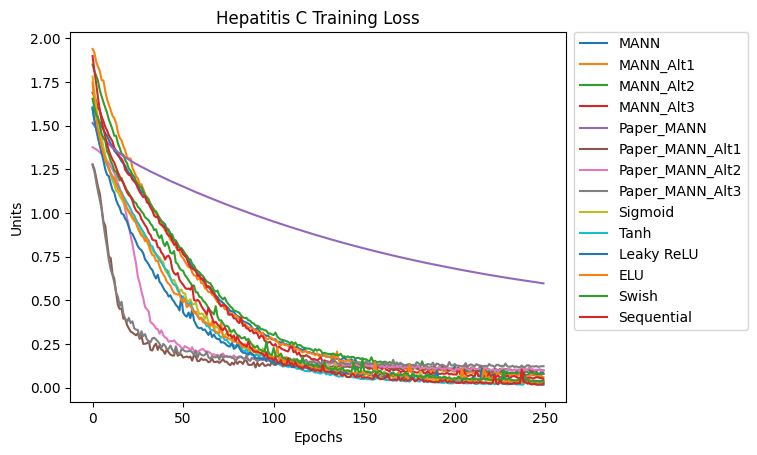

In [84]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Hepatitis C Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

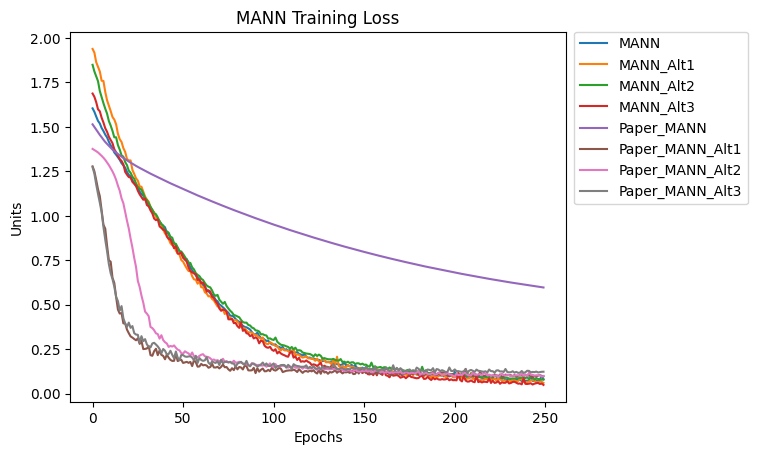

In [85]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['loss'], label='MANN')

plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['loss'], label='MANN_Alt1')

plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['loss'], label='MANN_Alt2')

plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['loss'], label='MANN_Alt3')

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['loss'], label='Paper_MANN')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['loss'], label='Paper_MANN_Alt1')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['loss'], label='Paper_MANN_Alt2')

plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['loss'], label='Paper_MANN_Alt3')

plt.title('MANN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

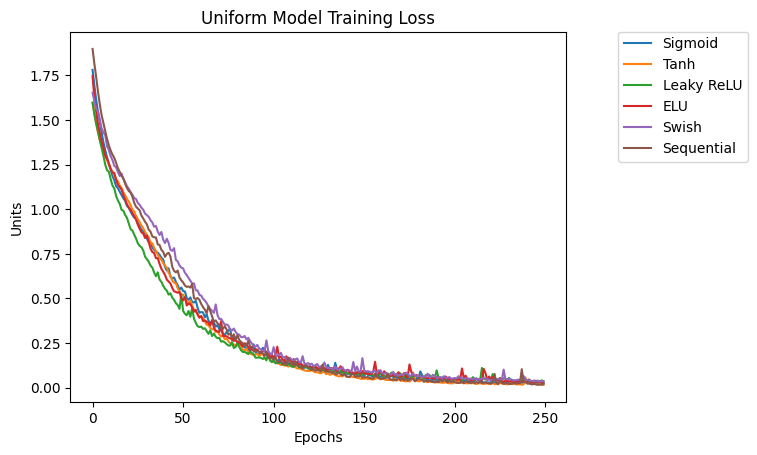

In [86]:
# Plot the training loss over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['loss'], label='Sigmoid')

plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['loss'], label='Tanh')

plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['loss'], label='Leaky ReLU')

plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['loss'], label='ELU')

plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['loss'], label='Swish')

plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['loss'], label='Sequential')

plt.title('Uniform Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')

plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

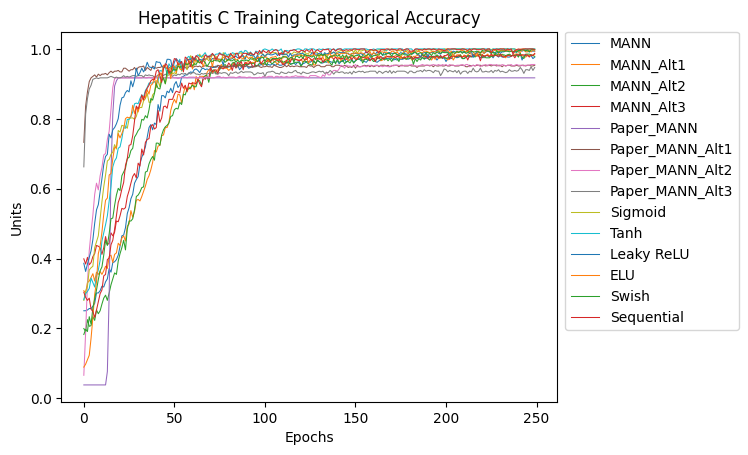

In [87]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Hepatitis C Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

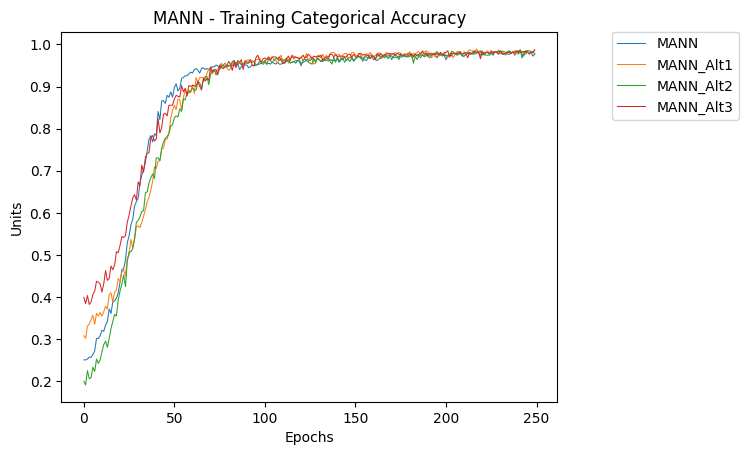

In [88]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

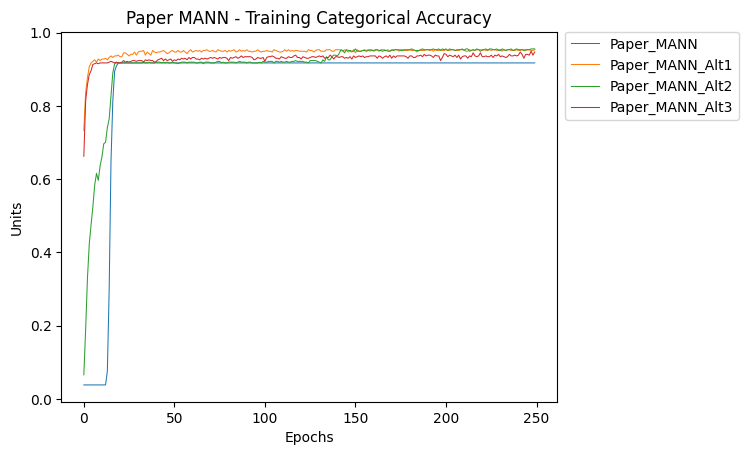

In [89]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

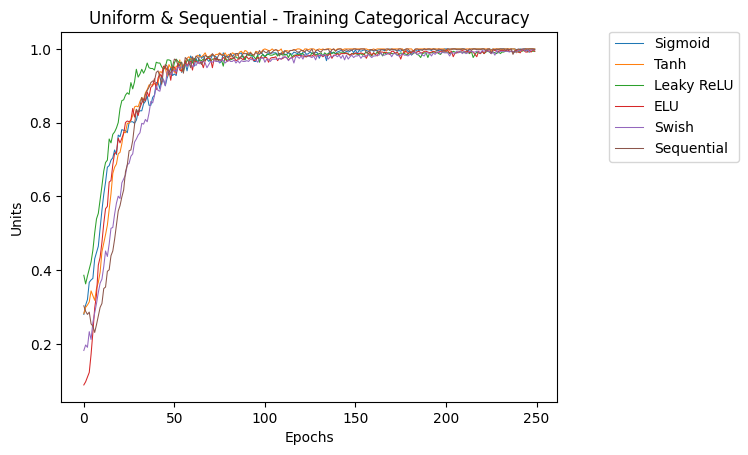

In [90]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Training Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

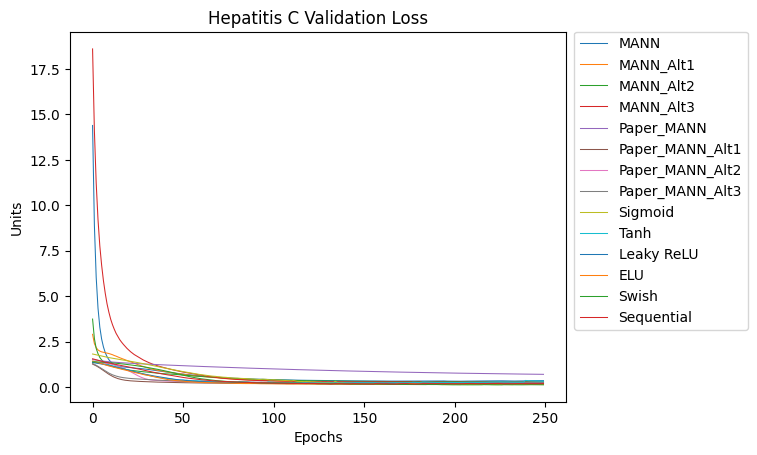

In [91]:
# Plot the validation loss over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['loss']))), histories['MANN'].history['val_loss'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['loss']))), histories['MANN_Alt1'].history['val_loss'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['loss']))), histories['MANN_Alt2'].history['val_loss'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['loss']))), histories['MANN_Alt3'].history['val_loss'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['loss']))), histories['Paper_MANN'].history['val_loss'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['loss']))), histories['Paper_MANN_Alt1'].history['val_loss'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['loss']))), histories['Paper_MANN_Alt2'].history['val_loss'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['loss']))), histories['Paper_MANN_Alt3'].history['val_loss'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['loss']))), histories['Sigmoid'].history['val_loss'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['loss']))), histories['Tanh'].history['val_loss'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['loss']))), histories['LeakyReLU'].history['val_loss'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['loss']))), histories['ELU'].history['val_loss'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['loss']))), histories['Swish'].history['val_loss'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['loss']))), histories['Sequential'].history['val_loss'], label='Sequential', linewidth=0.75)

plt.title('Hepatitis C Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Units')
#plt.ylim([0,1.5])
plt.legend(bbox_to_anchor=(1.38, 1.02))
plt.show()

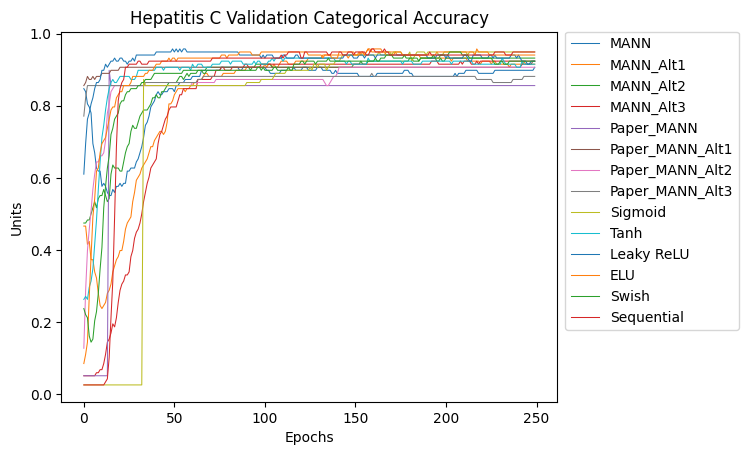

In [92]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Hepatitis C Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

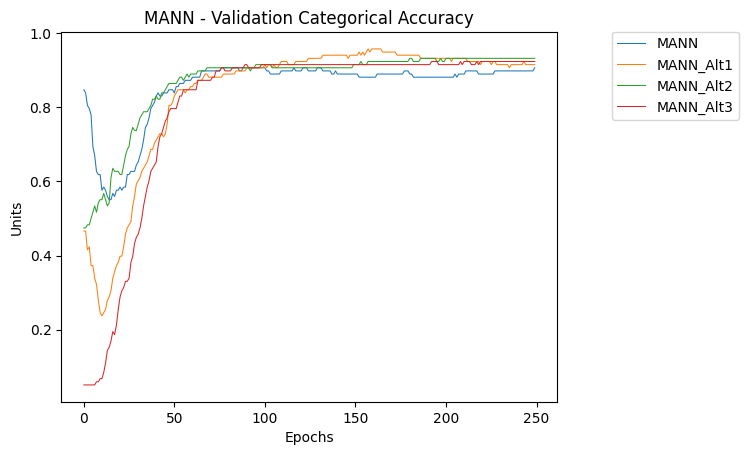

In [93]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['val_categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['val_categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['val_categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['val_categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

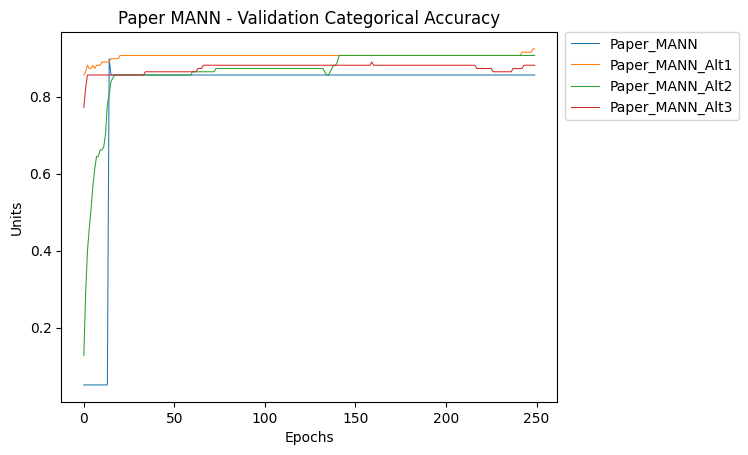

In [94]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['val_categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['val_categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['val_categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['val_categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Paper MANN - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

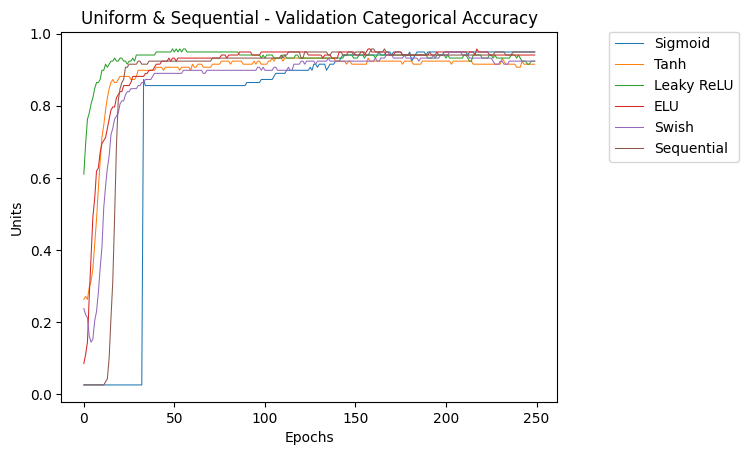

In [95]:
# Plot the validation Accuracy over the epochs
plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['val_categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['val_categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['val_categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['val_categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['val_categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['val_categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Uniform & Sequential - Validation Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

In [96]:
# Save training history
train_hist_df = pd.DataFrame()
val_hist_df = pd.DataFrame()
for name, callback in histories.items():
    train_hist_df = pd.concat((train_hist_df, pd.DataFrame(callback.history['loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    val_hist_df = pd.concat((val_hist_df, pd.DataFrame(callback.history['val_loss'], columns=[name])), axis=1, join='inner', ignore_index=True)
    
train_hist_df.to_csv('Binary.training_hist.csv')
val_hist_df.to_csv('Binary.validation_hist.csv')

In [97]:
# Get performance metrics for each model
# Get the testing loss for each model

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, one_hot.inverse_transform(y_train).ravel())

metric = keras.metrics.CategoricalAccuracy()
metric.update_state(y_test.to_numpy(), one_hot.transform(log_reg.predict(X_test).reshape(-1,1)))
log_reg_loss = metric.result().numpy()

MANN_loss = models['MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt1_loss = models['MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt2_loss = models['MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
MANN_Alt3_loss = models['MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Paper_MANN_loss = models['Paper_MANN'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt1_loss = models['Paper_MANN_Alt1'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt2_loss = models['Paper_MANN_Alt2'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']
Paper_MANN_Alt3_loss = models['Paper_MANN_Alt3'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sigmoid_loss = models['Sigmoid'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Tanh_loss = models['Tanh'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

LeakyReLU_loss = models['LeakyReLU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

ELU_loss = models['ELU'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Swish_loss = models['Swish'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

Sequential_loss = models['Sequential'].evaluate(X_test, y_test.to_numpy(),return_dict=True)['categorical_accuracy']

4/4 [==============================] - 0s 5ms/step - loss: 0.1956 - categorical_accuracy: 0.9492


In [98]:
# Save metrics to a table and display results
# Save testing loss to table and display results
results = pd.DataFrame([MANN_loss, MANN_Alt1_loss, MANN_Alt2_loss, MANN_Alt3_loss, Paper_MANN_loss, Paper_MANN_Alt1_loss, Paper_MANN_Alt2_loss, Paper_MANN_Alt3_loss,Sigmoid_loss, Tanh_loss, LeakyReLU_loss, ELU_loss, Swish_loss, Sequential_loss],
                      index=['MANN', 'MANN_Alt1', 'MANN_Alt2', 'MANN_Alt3', 'Paper MANN', 'Paper Alternate MANN 1', 'Paper Alternate MANN 2', 'Paper Alternate MANN 3', 'Sigmoid NN', 'Tanh NN', 'Leaky ReLU NN', 'ELU NN', 'Swish NN', 'Sequential NN'],
                      columns=['Categorical Accuracy'])
results.sort_values('Categorical Accuracy', inplace=True, ascending=False)
results.head(20)

Categorical Accuracy
Sigmoid NN                          0.949153
Sequential NN                       0.949153
ELU NN                              0.940678
MANN_Alt2                           0.932203
MANN_Alt3                           0.923729
Paper Alternate MANN 1              0.923729
Leaky ReLU NN                       0.923729
Swish NN                            0.923729
MANN_Alt1                           0.915254
Tanh NN                             0.915254
MANN                                0.906780
Paper Alternate MANN 2              0.906780
Paper Alternate MANN 3              0.881356
Paper MANN                          0.855932

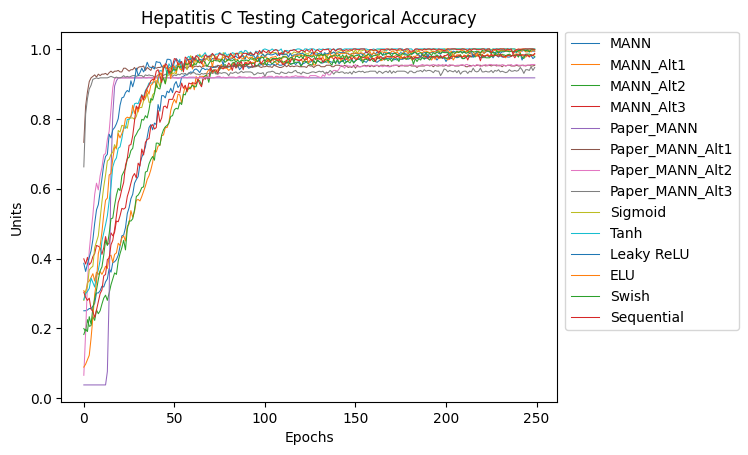

In [99]:
# Plot the Testing Accuracy over the epochs
plt.plot(np.array(range(len(histories['MANN'].history['categorical_accuracy']))), histories['MANN'].history['categorical_accuracy'], label='MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt1'].history['categorical_accuracy']))), histories['MANN_Alt1'].history['categorical_accuracy'], label='MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt2'].history['categorical_accuracy']))), histories['MANN_Alt2'].history['categorical_accuracy'], label='MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['MANN_Alt3'].history['categorical_accuracy']))), histories['MANN_Alt3'].history['categorical_accuracy'], label='MANN_Alt3', linewidth=0.75)

plt.plot(np.array(range(len(histories['Paper_MANN'].history['categorical_accuracy']))), histories['Paper_MANN'].history['categorical_accuracy'], label='Paper_MANN', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt1'].history['categorical_accuracy']))), histories['Paper_MANN_Alt1'].history['categorical_accuracy'], label='Paper_MANN_Alt1', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt2'].history['categorical_accuracy']))), histories['Paper_MANN_Alt2'].history['categorical_accuracy'], label='Paper_MANN_Alt2', linewidth=0.75)
plt.plot(np.array(range(len(histories['Paper_MANN_Alt3'].history['categorical_accuracy']))), histories['Paper_MANN_Alt3'].history['categorical_accuracy'], label='Paper_MANN_Alt3', linewidth=0.75)


plt.plot(np.array(range(len(histories['Sigmoid'].history['categorical_accuracy']))), histories['Sigmoid'].history['categorical_accuracy'], label='Sigmoid', linewidth=0.75)
plt.plot(np.array(range(len(histories['Tanh'].history['categorical_accuracy']))), histories['Tanh'].history['categorical_accuracy'], label='Tanh', linewidth=0.75)
plt.plot(np.array(range(len(histories['LeakyReLU'].history['categorical_accuracy']))), histories['LeakyReLU'].history['categorical_accuracy'], label='Leaky ReLU', linewidth=0.75)
plt.plot(np.array(range(len(histories['ELU'].history['categorical_accuracy']))), histories['ELU'].history['categorical_accuracy'], label='ELU', linewidth=0.75)
plt.plot(np.array(range(len(histories['Swish'].history['categorical_accuracy']))), histories['Swish'].history['categorical_accuracy'], label='Swish', linewidth=0.75)
plt.plot(np.array(range(len(histories['Sequential'].history['categorical_accuracy']))), histories['Sequential'].history['categorical_accuracy'], label='Sequential', linewidth=0.75)

plt.legend(bbox_to_anchor=(1.38, 1.02))

plt.title('Hepatitis C Testing Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Units')
plt.show()

# 

# 